In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
import numpy as np
import scipy.linalg as sl
from enterprise.signals import (gp_signals, parameter, signal_base, utils,
                                white_signals)
from hasasia import sensitivity as hasens
import healpy as hp
import matplotlib.pyplot as plt

from scipy.special import gamma
from scipy.optimize import curve_fit
import scipy.stats as stats
import time

import multiprocessing as mp
def chisq(x, k):
    prefactor = 1/(2**(k/2) * gamma(k/2))
    postfactor = x**(k/2 - 1) * np.exp(-x/2)
    
    return prefactor*postfactor

def nc_chisq_wrapper(x, k, nc):
    return stats.ncx2.pdf(x, k, nc, loc=0, scale=1)

def make_Mmat(toas):
    DesignM = np.ones((len(toas), 3))
    DesignM[:,1] = toas
    DesignM[:,2] = DesignM[:,1]**2
    return DesignM

def flatten(xss):
    return [x for xs in xss for x in xs]

def nc_chisq_fixedk_coh(x, nc):
    return stats.ncx2.pdf(x, 2, nc, loc=0, scale=1)

def nc_chisq_fixedk_incoh(x, nc):
    return stats.ncx2.pdf(x, 40, nc, loc=0, scale=1)

# Rmtx only for WN
# def make_Rmat(toas):
#     I = np.identity(len(toas))
#     DesignM = make_Mmat(toas)
#     return I - np.einsum('kn,nm,pm->kp', DesignM, np.linalg.inv(np.einsum('km,kn->nm',DesignM,DesignM)),DesignM)

def make_Rmat(toas, ninv):
    I = np.identity(len(toas))
    DesignM = make_Mmat(toas)
    print(DesignM.shape)
    print(ninv.shape)
    print("Computing internal product")
    internal = np.linalg.inv(np.einsum('ij,jk,kl->il',DesignM.T,ninv,DesignM))
    print("Computing final product")
    # result = I - np.einsum('kn,nm,mp,pq->kq', DesignM, internal ,DesignM.T, ninv)
    print("Completed result")
    result = I - DesignM@internal@DesignM.T@ninv
    return result
def make_Rmat_wn(toas):
    I = np.identity(len(toas))
    DesignM = make_Mmat(toas)
    return I - np.einsum('kn,nm,pm->kp', DesignM, np.linalg.inv(np.einsum('km,kn->nm',DesignM,DesignM)),DesignM)

def inner_prod(x,y,C):
    return (x.T@C)@y


import pta_replicator as ptr
from pta_replicator import sim as ptrsim
from pta_replicator import spharmORFbasis as anis

def create_rn_timseries(base_toas, amplitude, gamma, components=30):

    Tspan = max(base_toas) - min(base_toas)
    YR_IN_SEC = 3600*24*365.25
    fyr = 1/YR_IN_SEC
    F, freqs = ptrsim.createfourierdesignmatrix_red(base_toas, nmodes=components)
    prior = amplitude**2 * (freqs/fyr)**(-gamma) / (12 * np.pi**2 * Tspan) * YR_IN_SEC**3

    y = np.sqrt(prior) * np.random.randn(freqs.size)
    rn_timeseries = np.dot(F, y)
    return rn_timeseries

def compute_redpsd(amp, gamma, freqs):
    psd = np.zeros(len(freqs))
    Tspan = 1/freqs[0]
    YR_IN_SEC = 3600*24*365.25
    fyr = 1/YR_IN_SEC
    for freq_idx, freq in enumerate(freqs):
        psd[freq_idx] = amp**2 * (freq/fyr)**(-gamma) / (12 * np.pi**2) * YR_IN_SEC**3
    return psd

In [6]:
def figsize(scale):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    #golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    golden_mean= 0.3333
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size
plt.rcParams.update(plt.rcParamsDefault)

params = {'backend': 'pdf',
        'axes.labelsize': 18,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 12,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        #'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath,calrsfs}', r'\DeclareMathAlphabet{\pazocal}{OMS}{zplm}{m}{n}'],
        'text.usetex':False,
        'figure.figsize': figsize(1.2)}

plt.rcParams.update(params)

In [7]:
def bwm_delay(toas, pos, log10_h=-14.0, cos_gwtheta=0.0, gwphi=0.0, gwpol=0.0, t0=55000*24*3600,
              antenna_pattern_fn=None):
    """
    Function that calculates the earth-term gravitational-wave
    burst-with-memory signal, as described in:
    Seto et al, van haasteren and Levin, phsirkov et al, Cordes and Jenet.
    This version uses the F+/Fx polarization modes, as verified with the
    Continuous Wave and Anisotropy papers.

    :param toas: Time-of-arrival measurements [s]
    :param pos: Unit vector from Earth to pulsar
    :param log10_h: log10 of GW strain
    :param cos_gwtheta: Cosine of GW polar angle
    :param gwphi: GW azimuthal polar angle [rad]
    :param gwpol: GW polarization angle
    :param t0: Burst central time [s]
    :param antenna_pattern_fn:
        User defined function that takes `pos`, `gwtheta`, `gwphi` as
        arguments and returns (fplus, fcross)

    :return: the waveform as induced timing residuals (seconds)
    
    taken from enterprise_extensions
    """

    # convert
    h = 10 ** log10_h
    gwtheta = np.arccos(cos_gwtheta)
    t0 *= 1

    # antenna patterns
    if antenna_pattern_fn is None:
        apc = utils.create_gw_antenna_pattern(pos, gwtheta, gwphi)
    else:
        apc = antenna_pattern_fn(pos, gwtheta, gwphi)

    # grab fplus, fcross
    fp, fc = apc[0], apc[1]

    # combined polarization
    pol = np.cos(2 * gwpol) * fp + np.sin(2 * gwpol) * fc

    # Return the time-series for the pulsar
    return pol * h * np.heaviside(toas - t0, 0.5) * (toas - t0)
    

Instantiate psrlocs

In [8]:
npsrs = 40
# psr_locs = []

# for ipsr in range(npsrs):
#     psr_theta = np.random.rand() * np.pi
#     psr_phi = np.random.rand() * 2 * np.pi

#     psr_locs.append([psr_theta, psr_phi])
    
# np.savetxt('/home/nima/nanograv/bwm_fpfe/production_runs/psrlocs.txt', psr_locs)
psrloc_path = '/home/nima/nanograv/bwm_fpfe/production_runs/psrlocs.txt'

# Easiest attempt 
WN Only

In [6]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []
psr_locs = np.loadtxt(psrloc_path)

rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)
   

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = 0
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [8]:
print(prefit_rn_covs[0])
print(sl.pinv(prefit_rn_covs[0]))

[[3.73242816e-10 3.73235889e-10 3.73215118e-10 ... 2.90130101e-10
  2.88827439e-10 2.87517007e-10]
 [3.73235889e-10 3.73242816e-10 3.73235889e-10 ... 2.91424937e-10
  2.90130101e-10 2.88827439e-10]
 [3.73215118e-10 3.73235889e-10 3.73242816e-10 ... 2.92711887e-10
  2.91424937e-10 2.90130101e-10]
 ...
 [2.90130101e-10 2.91424937e-10 2.92711887e-10 ... 3.73242816e-10
  3.73235889e-10 3.73215118e-10]
 [2.88827439e-10 2.90130101e-10 2.91424937e-10 ... 3.73235889e-10
  3.73242816e-10 3.73235889e-10]
 [2.87517007e-10 2.88827439e-10 2.90130101e-10 ... 3.73215118e-10
  3.73235889e-10 3.73242816e-10]]
[[ 1.55004361e+18 -6.35080977e+18  1.06585171e+19 ...  6.18451454e+18
  -3.16623803e+18  6.81316359e+17]
 [-6.35082893e+18  2.66292611e+19 -4.57601176e+19 ... -2.85467996e+19
   1.46744319e+19 -3.16658591e+18]
 [ 1.06587017e+19 -4.57607884e+19  8.07081908e+19 ...  5.52343360e+19
  -2.85533077e+19  6.18661943e+18]
 ...
 [ 6.18821961e+18 -2.85632944e+19  5.52638381e+19 ...  8.06686023e+19
  -4.57443

In [15]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        # rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        # prefit_toas = base_toases[ipsr] + wn_series + rn_series + bwm_signals[ipsr]
        # prefit_resids =  wn_series + rn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

        prefit_toas = base_toases[ipsr] + wn_series
        prefit_resids = wn_series
        noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]

        # plt.scatter(prefit_toas, ramp_templates[ipsr], color='tab:blue', label='prefit')
        # plt.scatter(prefit_toas, postfit_template, color='tab:orange', label = 'postfit')
        # plt.legend()
        # plt.title('PSR {} Templates'.format(ipsr))
        # plt.show()
        # plt.close()

        # plt.scatter(prefit_toas, prefit_resids, label='prefit')
        # plt.scatter(prefit_toas, postfit_resids, label='postfit')
        # plt.legend()
        # plt.title('PSR {} resids'.format(ipsr))
        # plt.show()
        # plt.close()
        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc
        
        # compute resids dotted with templates
        
        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        
        # fig, ax = plt.subplots(1,1)
        # ax.scatter(base_toases[ipsr], postfit_resids, color='k')
        # twinax = ax.twinx()
        # twinax.scatter(base_toases[ipsr], Ap, label='Ap', ls = '--', color='red')
        # twinax.scatter(base_toases[ipsr], Ac, label='Ac', ls = '--', color='blue')
        # plt.title('PSR {} [Np = {:.02e}, Nc = {:.02e}]'.format(ipsr, Np_contribution, Nc_contribution))
        # plt.show()
        # plt.close()
        
        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    # Mij_inv = np.linalg.inv(Mij)
    M_pinv = np.linalg.pinv(M)

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe

In [16]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
Fes = pool.starmap(fe_worker, args)
 
outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn.txt'
np.savetxt(outfile, np.array(Fes))

Finished iteration 1092 in 0.3s. Fe = 2.241568353935321
Finished iteration 168 in 0.5s. Fe = 3.4111853674248334
Finished iteration 588 in 0.5s. Fe = 0.8439255377188469Finished iteration 1176 in 0.6s. Fe = 6.712157218590089Finished iteration 672 in 0.6s. Fe = 1.405051057936716
Finished iteration 840 in 0.6s. Fe = 3.451341592996294


Finished iteration 924 in 0.6s. Fe = 0.42525146207839437
Finished iteration 252 in 0.7s. Fe = 10.791195916180701
Finished iteration 504 in 0.7s. Fe = 0.028296231283650115
Finished iteration 420 in 0.8s. Fe = 5.392997638626496Finished iteration 756 in 0.8s. Fe = 0.22724977776962066

Finished iteration 0 in 0.9s. Fe = 5.03826864148153
Finished iteration 336 in 0.9s. Fe = 2.3407203099615397
Finished iteration 1008 in 1.0s. Fe = 2.2136632921402737
Finished iteration 84 in 1.0s. Fe = 2.447538203949588
Finished iteration 169 in 0.6s. Fe = 5.307228483218458
Finished iteration 673 in 0.5s. Fe = 4.064909842401291
Finished iteration 1093 in 0.8s. Fe = 8.60666255007085

Finished iteration 1027 in 0.7s. Fe = 0.2505583383050931Finished iteration 438 in 0.6s. Fe = 2.517162129215305

Finished iteration 104 in 0.7s. Fe = 0.9157633047006759Finished iteration 860 in 0.7s. Fe = 0.5447552987325309

Finished iteration 523 in 0.7s. Fe = 3.559119056466027
Finished iteration 272 in 0.6s. Fe = 0.010030059044785192
Finished iteration 19 in 0.6s. Fe = 2.080920468668297
Finished iteration 1195 in 0.8s. Fe = 4.4904261774340695
Finished iteration 188 in 0.7s. Fe = 2.523358486970265
Finished iteration 609 in 0.6s. Fe = 0.11627003692274923Finished iteration 355 in 0.7s. Fe = 4.52457275154491
Finished iteration 943 in 0.6s. Fe = 0.6106038077090643

Finished iteration 692 in 0.6s. Fe = 0.5749549334878699Finished iteration 775 in 0.7s. Fe = 1.6243818173209392

Finished iteration 1112 in 0.6s. Fe = 0.39738209047679535
Finished iteration 439 in 0.7s. Fe = 1.0532375766996047Finished iteration 1028 in 0.7s. Fe = 0.22328663175306257Finished iteration 105 in 0.7s. Fe = 0.837351166

Finished iteration 123 in 0.7s. Fe = 2.7803624184338176
Finished iteration 710 in 0.5s. Fe = 1.2776308300046904
Finished iteration 1131 in 0.8s. Fe = 0.4172743416112362
Finished iteration 38 in 0.9s. Fe = 1.5272339222523876Finished iteration 543 in 0.6s. Fe = 0.3115984930417656Finished iteration 794 in 0.7s. Fe = 2.0695265870000408


Finished iteration 1047 in 0.8s. Fe = 2.598239819196816
Finished iteration 629 in 0.9s. Fe = 0.352868330715253
Finished iteration 374 in 0.7s. Fe = 2.088310440248624
Finished iteration 208 in 0.7s. Fe = 2.647622774521969
Finished iteration 1216 in 0.7s. Fe = 0.05738720709243911Finished iteration 962 in 0.7s. Fe = 0.7268853884908848Finished iteration 458 in 0.7s. Fe = 2.0392123775385773
Finished iteration 291 in 0.9s. Fe = 0.16146834929025397


Finished iteration 880 in 0.9s. Fe = 2.3686635432646623
Finished iteration 711 in 0.6s. Fe = 5.718463206104512Finished iteration 124 in 0.7s. Fe = 2.801343623266457

Finished iteration 1132 in 0.6s. Fe = 5.0923409694

Finished iteration 476 in 0.7s. Fe = 5.400948868048893
Finished iteration 1235 in 0.7s. Fe = 3.7921627269519282
Finished iteration 1152 in 0.6s. Fe = 6.830311251689957
Finished iteration 143 in 0.7s. Fe = 1.489702502330574Finished iteration 980 in 0.6s. Fe = 3.285765174546698Finished iteration 57 in 0.6s. Fe = 1.558768910964243


Finished iteration 309 in 0.7s. Fe = 0.23754324284195497
Finished iteration 897 in 0.8s. Fe = 0.22406265329617717
Finished iteration 649 in 0.7s. Fe = 0.8192868160246716
Finished iteration 814 in 0.7s. Fe = 0.7799774578269456
Finished iteration 228 in 0.5s. Fe = 1.0322388090903276
Finished iteration 1067 in 0.7s. Fe = 0.8087686267771701Finished iteration 728 in 0.8s. Fe = 10.751051735463236
Finished iteration 566 in 0.5s. Fe = 1.0456557965751236

Finished iteration 395 in 0.6s. Fe = 4.3968372372488105
Finished iteration 477 in 0.6s. Fe = 1.3989554113767637
Finished iteration 1153 in 0.6s. Fe = 0.3138170380170904
Finished iteration 144 in 0.6s. Fe = 0.735524989

Finished iteration 415 in 0.8s. Fe = 1.220784964028103
Finished iteration 999 in 0.7s. Fe = 2.1830029478319872
Finished iteration 163 in 0.7s. Fe = 0.416064320199072
Finished iteration 832 in 0.9s. Fe = 2.413944785225408
Finished iteration 747 in 0.6s. Fe = 1.446500175839748
Finished iteration 584 in 0.8s. Fe = 1.2966029327190531Finished iteration 916 in 0.6s. Fe = 2.0420926443226928

Finished iteration 1172 in 0.7s. Fe = 1.3739168772873525
Finished iteration 495 in 0.7s. Fe = 0.5594536475478676
Finished iteration 78 in 0.7s. Fe = 0.9713032762710367
Finished iteration 1086 in 0.8s. Fe = 5.368459572281569Finished iteration 247 in 0.6s. Fe = 0.41627820776469177
Finished iteration 1255 in 0.7s. Fe = 0.19579414399234185Finished iteration 164 in 0.5s. Fe = 10.90273914084226


Finished iteration 670 in 0.7s. Fe = 0.3047107749585962Finished iteration 416 in 0.7s. Fe = 1.1855951792153625Finished iteration 329 in 0.8s. Fe = 3.3256514361960217


Finished iteration 833 in 0.5s. Fe = 2.89688290714

Finished iteration 1776 in 0.8s. Fe = 1.0618753790108793Finished iteration 2361 in 0.8s. Fe = 2.6677037084653374

Finished iteration 2445 in 0.8s. Fe = 3.7266020170815755
Finished iteration 1944 in 0.8s. Fe = 0.6862613292358422
Finished iteration 2112 in 0.6s. Fe = 1.3264297060179324
Finished iteration 1526 in 0.8s. Fe = 3.7982652827036087Finished iteration 1277 in 0.4s. Fe = 1.9372613351695254

Finished iteration 2278 in 0.7s. Fe = 0.3321536462308794Finished iteration 1359 in 0.8s. Fe = 0.46898798523917795
Finished iteration 1697 in 0.8s. Fe = 0.39685220565412277
Finished iteration 1611 in 0.7s. Fe = 1.6811331898442938

Finished iteration 2028 in 0.8s. Fe = 0.5179535714907997
Finished iteration 1862 in 0.7s. Fe = 7.856639056095581Finished iteration 1445 in 0.7s. Fe = 0.8054742498986959

Finished iteration 1777 in 0.7s. Fe = 0.9449400977544014
Finished iteration 2362 in 0.7s. Fe = 1.4224407268414205
Finished iteration 2446 in 0.6s. Fe = 2.243532971223211Finished iteration 2195 in 0.8s.

Finished iteration 2213 in 0.6s. Fe = 2.878317229919255
Finished iteration 2380 in 0.4s. Fe = 1.4895555957696458Finished iteration 1297 in 0.5s. Fe = 0.5038408637091939Finished iteration 2297 in 0.8s. Fe = 3.9757245151375704Finished iteration 1629 in 0.8s. Fe = 5.0250516706328225



Finished iteration 1795 in 0.9s. Fe = 1.7262533107916591Finished iteration 2464 in 0.8s. Fe = 1.9384513349321708
Finished iteration 1879 in 0.9s. Fe = 1.280707520868689Finished iteration 1378 in 0.8s. Fe = 1.3576088355846427
Finished iteration 1962 in 0.6s. Fe = 4.780863639985314


Finished iteration 1545 in 0.8s. Fe = 1.1943094131034289
Finished iteration 1716 in 0.8s. Fe = 2.2601782726410207Finished iteration 2048 in 0.7s. Fe = 1.034374061349777

Finished iteration 2134 in 0.6s. Fe = 0.7302529967948491
Finished iteration 1465 in 0.6s. Fe = 3.723297157887954
Finished iteration 1298 in 0.6s. Fe = 3.5110238657337765Finished iteration 2381 in 0.6s. Fe = 0.36379426696214234
Finished iteration 2214 in 0.7s. Fe 

Finished iteration 2400 in 0.8s. Fe = 0.428896980836616Finished iteration 1564 in 0.9s. Fe = 0.7675603460124139Finished iteration 1484 in 0.8s. Fe = 5.332239905364336Finished iteration 2153 in 0.5s. Fe = 0.9147530935301771



Finished iteration 2483 in 0.5s. Fe = 0.10642572495407947
Finished iteration 2316 in 0.8s. Fe = 4.143592874354561Finished iteration 1897 in 0.9s. Fe = 0.3065342628696887

Finished iteration 1982 in 0.5s. Fe = 1.2597541186080874
Finished iteration 1318 in 0.6s. Fe = 0.37874648393875016
Finished iteration 2232 in 0.5s. Fe = 0.5534829730774046Finished iteration 1813 in 0.6s. Fe = 1.3663521589823016

Finished iteration 1649 in 0.6s. Fe = 2.2011232578142135
Finished iteration 2154 in 0.6s. Fe = 0.43764974359147535Finished iteration 1735 in 0.7s. Fe = 0.7369076351710679Finished iteration 1485 in 0.6s. Fe = 3.3072142584391386


Finished iteration 2067 in 0.7s. Fe = 0.710703952195874Finished iteration 1565 in 0.7s. Fe = 0.9955812482718235
Finished iteration 2401 in 0.7s. 

Finished iteration 2502 in 0.9s. Fe = 0.7052966655043865
Finished iteration 2173 in 0.7s. Fe = 2.364370186605717
Finished iteration 2086 in 0.8s. Fe = 0.7383537692372506Finished iteration 1667 in 0.8s. Fe = 1.1077713981085602Finished iteration 1583 in 0.8s. Fe = 0.6045829928137231


Finished iteration 1338 in 0.9s. Fe = 2.2787282080787237
Finished iteration 1831 in 0.8s. Fe = 1.1136779048311911
Finished iteration 2251 in 0.8s. Fe = 1.6191643966706017Finished iteration 1415 in 0.6s. Fe = 4.753836207958739
Finished iteration 1915 in 0.9s. Fe = 9.321345253824443

Finished iteration 2420 in 0.7s. Fe = 3.2872158883674625
Finished iteration 2336 in 0.6s. Fe = 1.522387473258733Finished iteration 1754 in 0.5s. Fe = 0.3943835396745063Finished iteration 2002 in 0.6s. Fe = 4.43770372920904


Finished iteration 1504 in 0.7s. Fe = 1.4979492114617017
Finished iteration 2503 in 0.7s. Fe = 1.7419511535148806
Finished iteration 2087 in 0.7s. Fe = 1.0182846984842668
Finished iteration 2174 in 0.8s. Fe =

Finished iteration 3530 in 0.6s. Fe = 0.4770064674183676

Finished iteration 3696 in 0.9s. Fe = 0.28449902292912266
Finished iteration 3029 in 0.8s. Fe = 1.9992884497952552
Finished iteration 2780 in 0.9s. Fe = 0.7747122242835478
Finished iteration 3363 in 0.7s. Fe = 0.0583070460231961Finished iteration 2697 in 0.6s. Fe = 2.4178097121816218

Finished iteration 2614 in 0.6s. Fe = 0.13330150571981797Finished iteration 3114 in 0.5s. Fe = 0.7374951667304371
Finished iteration 3196 in 0.6s. Fe = 1.334866769584473Finished iteration 3447 in 0.6s. Fe = 1.6834796494468056
Finished iteration 3613 in 0.6s. Fe = 3.4214937589549526


Finished iteration 2863 in 0.6s. Fe = 0.3587347762151939
Finished iteration 3281 in 0.6s. Fe = 0.7575939465759765
Finished iteration 2534 in 0.5s. Fe = 3.5567128177156566
Finished iteration 2615 in 0.4s. Fe = 0.704920714594758
Finished iteration 3448 in 0.5s. Fe = 6.637845108856176
Finished iteration 3197 in 0.4s. Fe = 4.0859410979525155Finished iteration 3364 in 0.6s.

Finished iteration 2882 in 0.5s. Fe = 5.49979419220454Finished iteration 3548 in 0.8s. Fe = 0.7740083703587975Finished iteration 2967 in 0.4s. Fe = 0.8285206884058263Finished iteration 3631 in 0.7s. Fe = 2.886778324888012


Finished iteration 3133 in 0.7s. Fe = 3.503265899361925Finished iteration 3714 in 0.8s. Fe = 1.155063266192021


Finished iteration 3049 in 0.8s. Fe = 1.5962313727313324
Finished iteration 3467 in 0.8s. Fe = 2.159729064125984
Finished iteration 3214 in 0.8s. Fe = 4.697963587420108
Finished iteration 3382 in 0.8s. Fe = 4.579504081480033
Finished iteration 3549 in 0.5s. Fe = 1.3909469076005325Finished iteration 2799 in 0.8s. Fe = 5.352876053980351Finished iteration 2635 in 0.8s. Fe = 2.175502713115023

Finished iteration 2883 in 0.5s. Fe = 1.7704974838884922
Finished iteration 2554 in 0.8s. Fe = 1.320409949524666

Finished iteration 3299 in 0.8s. Fe = 0.3099615279390298Finished iteration 3632 in 0.6s. Fe = 2.2157013310718874

Finished iteration 2717 in 0.7s. Fe = 0.81

Finished iteration 3732 in 0.7s. Fe = 0.1730841679108229Finished iteration 2986 in 0.4s. Fe = 0.9055226983703273

Finished iteration 3566 in 0.9s. Fe = 0.49297929166405297
Finished iteration 3154 in 0.7s. Fe = 4.476285186835735
Finished iteration 2654 in 0.8s. Fe = 1.2110053530515659
Finished iteration 2574 in 0.7s. Fe = 0.09223889544547287Finished iteration 3485 in 0.8s. Fe = 0.07031979017486563

Finished iteration 2818 in 0.8s. Fe = 1.6693413137662827Finished iteration 2736 in 0.8s. Fe = 4.019711383267585Finished iteration 3318 in 0.8s. Fe = 3.4440905902700303

Finished iteration 3069 in 0.7s. Fe = 0.9085472707515593

Finished iteration 2901 in 0.8s. Fe = 0.8865179080973907Finished iteration 3567 in 0.5s. Fe = 0.569434141840957Finished iteration 3650 in 0.7s. Fe = 1.1389077366372042


Finished iteration 3733 in 0.7s. Fe = 0.8903384319822844Finished iteration 2655 in 0.5s. Fe = 0.962905304465408Finished iteration 3232 in 0.7s. Fe = 2.415572622946784
Finished iteration 3402 in 0.8s. Fe

Finished iteration 3748 in 0.8s. Fe = 1.4070165715514764


Finished iteration 2673 in 0.6s. Fe = 1.6083729089738958
Finished iteration 3338 in 0.6s. Fe = 0.14414045400624945
Finished iteration 3173 in 0.6s. Fe = 0.7150369422666745Finished iteration 2592 in 0.7s. Fe = 2.3972409363512766Finished iteration 3671 in 0.4s. Fe = 1.563075498116882


Finished iteration 3086 in 0.8s. Fe = 0.36290697922066595Finished iteration 3505 in 0.5s. Fe = 0.8988472452895281
Finished iteration 3420 in 0.7s. Fe = 1.0548028118376136

Finished iteration 3005 in 0.5s. Fe = 1.4228231903419921
Finished iteration 2837 in 0.8s. Fe = 2.135636706411925
Finished iteration 3253 in 0.5s. Fe = 4.315692218517932Finished iteration 2756 in 0.5s. Fe = 3.5863456091695105

Finished iteration 2921 in 0.5s. Fe = 1.8538754638555528
Finished iteration 3587 in 0.8s. Fe = 1.3694065714432544Finished iteration 3749 in 0.6s. Fe = 0.10019028643158268Finished iteration 2674 in 0.6s. Fe = 6.5893900123873275

Finished iteration 3339 in 0.4

Finished iteration 3595 in 0.8s. Fe = 0.26522819696370126Finished iteration 2765 in 0.7s. Fe = 2.770142201542136

Finished iteration 3514 in 0.8s. Fe = 1.729539622007365
Finished iteration 3261 in 0.8s. Fe = 4.735767041500039
Finished iteration 3014 in 0.5s. Fe = 0.3462047668303819Finished iteration 2931 in 0.6s. Fe = 2.677949564801704Finished iteration 3681 in 0.6s. Fe = 0.17473271084342518


Finished iteration 3183 in 0.7s. Fe = 1.0451211523728514Finished iteration 2846 in 0.6s. Fe = 2.9238151652525435
Finished iteration 2683 in 0.6s. Fe = 0.02776631737551975

Finished iteration 3758 in 0.6s. Fe = 4.118110293696576
Finished iteration 2602 in 0.6s. Fe = 1.9983170270088841Finished iteration 3096 in 0.7s. Fe = 5.080340304929221

Finished iteration 3349 in 0.6s. Fe = 1.8554415101857336
Finished iteration 3431 in 0.6s. Fe = 0.004953352343983515
Finished iteration 3515 in 0.6s. Fe = 0.23827598679327672Finished iteration 2766 in 0.6s. Fe = 10.393249572546473

Finished iteration 3596 in 0.7s

Finished iteration 3880 in 0.4s. Fe = 1.2714683087977743

Finished iteration 3776 in 0.7s. Fe = 1.0368242262625236
Finished iteration 4542 in 0.7s. Fe = 0.5676189541889232
Finished iteration 4041 in 0.8s. Fe = 0.6312146510142309
Finished iteration 4626 in 0.6s. Fe = 6.083470021481124
Finished iteration 3795 in 0.8s. Fe = 0.06706406610107071
Finished iteration 4377 in 0.8s. Fe = 1.5726633099058889Finished iteration 3960 in 0.6s. Fe = 1.2236401464826856Finished iteration 4125 in 0.8s. Fe = 2.0899594511717647Finished iteration 4460 in 0.6s. Fe = 1.5388288297431967



Finished iteration 4875 in 0.6s. Fe = 0.290370055593834
Finished iteration 4209 in 0.9s. Fe = 5.406325172655911
Finished iteration 4709 in 0.6s. Fe = 0.030661386223808464
Finished iteration 4293 in 0.6s. Fe = 3.034728544666611
Finished iteration 4793 in 0.6s. Fe = 0.7635806524776968
Finished iteration 3777 in 0.7s. Fe = 5.6453304268307996
Finished iteration 3881 in 0.7s. Fe = 2.5197953416125154
Finished iteration 4627 in 0.6s

Finished iteration 4144 in 0.7s. Fe = 0.43187046844431315Finished iteration 4313 in 0.8s. Fe = 2.289036122129045Finished iteration 4560 in 0.8s. Fe = 1.352529149073763
Finished iteration 4894 in 0.8s. Fe = 0.6054119782072556
Finished iteration 4970 in 0.9s. Fe = 0.1702795754185341Finished iteration 3898 in 0.8s. Fe = 0.2620550773393665



Finished iteration 4647 in 0.7s. Fe = 0.19994980240895646Finished iteration 3814 in 0.5s. Fe = 3.109579388521927

Finished iteration 4059 in 0.4s. Fe = 4.190215987088755Finished iteration 4812 in 0.9s. Fe = 1.352693706814774Finished iteration 3982 in 0.7s. Fe = 2.0019430186344853


Finished iteration 4479 in 0.6s. Fe = 0.9848024262379653
Finished iteration 4228 in 0.5s. Fe = 1.6433991781863582
Finished iteration 4728 in 0.7s. Fe = 2.87962563658993
Finished iteration 4145 in 0.6s. Fe = 2.8989188983251006Finished iteration 3815 in 0.4s. Fe = 0.5837621764459535Finished iteration 4648 in 0.5s. Fe = 1.7535151786491676

Finished iteration 4396 in 0.7s. Fe =

Finished iteration 4413 in 0.7s. Fe = 0.37841091955552597Finished iteration 4830 in 0.6s. Fe = 0.8229064585419789Finished iteration 4666 in 0.6s. Fe = 1.2730968488036716


Finished iteration 4579 in 0.8s. Fe = 3.329921177501938
Finished iteration 4748 in 0.7s. Fe = 6.413755418542534
Finished iteration 4497 in 0.6s. Fe = 1.460925688317897
Finished iteration 4079 in 0.8s. Fe = 1.6254893849139318Finished iteration 4916 in 0.4s. Fe = 0.6590139646258895

Finished iteration 4246 in 0.8s. Fe = 1.7297618348495882
Finished iteration 3834 in 0.8s. Fe = 3.253440919103357
Finished iteration 3917 in 0.8s. Fe = 4.090302014238633
Finished iteration 4164 in 0.6s. Fe = 2.5761782074961768Finished iteration 4332 in 0.7s. Fe = 1.738858071497833Finished iteration 4001 in 0.8s. Fe = 1.8026463724066992Finished iteration 4667 in 0.5s. Fe = 1.0906992249562106



Finished iteration 4990 in 0.6s. Fe = 6.1888702480604545Finished iteration 4831 in 0.6s. Fe = 0.06058815311214749
Finished iteration 4580 in 0.5s. Fe 

Finished iteration 3855 in 0.4s. Fe = 1.8846318964891406Finished iteration 4432 in 0.6s. Fe = 0.2585760330749885Finished iteration 4597 in 0.8s. Fe = 0.3148656732069652


Finished iteration 3936 in 0.6s. Fe = 1.0401711420885373
Finished iteration 4937 in 0.8s. Fe = 3.612701147129152
Finished iteration 4021 in 0.7s. Fe = 0.3456266461056035
Finished iteration 4686 in 0.7s. Fe = 2.663651183535017
Finished iteration 4768 in 0.7s. Fe = 0.37485544861896114Finished iteration 4518 in 0.4s. Fe = 0.7759838206230674
Finished iteration 4099 in 0.7s. Fe = 6.774232115770566
Finished iteration 4183 in 0.7s. Fe = 0.6955378139782403Finished iteration 4267 in 0.7s. Fe = 4.849016741906304


Finished iteration 3856 in 0.4s. Fe = 0.07913838730358883
Finished iteration 4352 in 0.7s. Fe = 0.7770704079246638
Finished iteration 3937 in 0.4s. Fe = 1.8975967159831784Finished iteration 4849 in 0.7s. Fe = 4.188878142723121

Finished iteration 4938 in 0.5s. Fe = 4.371219392387797
Finished iteration 4433 in 0.7s. Fe

In [ ]:
Fes = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn.txt')
ns, bins, patches = plt.hist(Fes, histtype='step', bins=160,density=True)
# plt.title("Fe ".format(rn_amp))
# plt.show()
# plt.close()

midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk, midpts, counts, p0 = [120],maxfev = 5000)


# opt_k = popt[0]
opt_k = 2
opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fitted = []
for pt in midpts:
    fitted.append(nc_chisq_fixedk(pt, opt_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(opt_k, opt_nc))
plt.legend(loc='upper right')
plt.xlabel("Fe")
plt.ylabel("pdf")
plt.show()
plt.close()

WN + BWM

In [9]:
base_toases = []
base_long_toases = []

residses = []
prefit_covs = []
prefit_rn_covs = []

psr_locs = np.loadtxt(psrloc_path)

rn_amp = 3e-15
rn_gamma = 13./3.



for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = 0
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)


for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [29]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    estimated_nc = 0
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        # rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        # prefit_toas = base_toases[ipsr] + wn_series + rn_series + bwm_signals[ipsr]
        # prefit_resids =  wn_series + rn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

        prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        prefit_resids = wn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc
        
        # compute resids dotted with templates
        
        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        
        
        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)
        
        estimated_nc +=  inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    # Mij_inv = np.linalg.inv(Mij)
    M_pinv = np.linalg.pinv(M)

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe, estimated_nc

In [31]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fe_worker, args)

Fes = [res[0] for res in results]
estimated_ncs = [res[1] for res in results]



outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_bwm.txt'
np.savetxt(outfile, np.array(Fes))

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_bwm_ncs.txt'
np.savetxt(nc_outfile, np.array(estimated_ncs))

Finished iteration 1092 in 0.4s. Fe = 5344.889306611573Finished iteration 840 in 0.4s. Fe = 5435.793664507606

Finished iteration 1008 in 0.6s. Fe = 5278.935365147053
Finished iteration 168 in 0.6s. Fe = 5006.667752689959
Finished iteration 924 in 0.7s. Fe = 5229.700277074723Finished iteration 252 in 0.7s. Fe = 4787.276340107317

Finished iteration 588 in 0.7s. Fe = 5367.827962724399Finished iteration 504 in 0.7s. Fe = 5248.342787265701Finished iteration 336 in 0.8s. Fe = 5050.502697633271


Finished iteration 0 in 0.9s. Fe = 5534.765525373106
Finished iteration 756 in 0.8s. Fe = 5250.9649228348135Finished iteration 672 in 0.9s. Fe = 5280.828519541733

Finished iteration 420 in 1.0s. Fe = 5362.827219200384Finished iteration 1176 in 1.0s. Fe = 4867.269457072543

Finished iteration 84 in 1.1s. Fe = 5101.038240190036Finished iteration 841 in 0.6s. Fe = 5092.969188168687Finished iteration 1093 in 0.6s. Fe = 5401.439802817598


Finished iteration 1009 in 0.6s. Fe = 5413.048453671243
Finishe

Finished iteration 862 in 0.7s. Fe = 5023.003460763618
Finished iteration 440 in 0.5s. Fe = 5187.024009001839
Finished iteration 776 in 0.5s. Fe = 5411.7711765295535Finished iteration 353 in 0.7s. Fe = 5203.472328308037

Finished iteration 187 in 0.7s. Fe = 5294.654144561588
Finished iteration 944 in 0.7s. Fe = 5269.288563366394
Finished iteration 1029 in 0.8s. Fe = 5400.236396607182
Finished iteration 103 in 0.7s. Fe = 5163.395557350894Finished iteration 272 in 1.0s. Fe = 5240.725375511755
Finished iteration 1195 in 0.5s. Fe = 5030.278252358696

Finished iteration 1112 in 0.7s. Fe = 5208.995916896459Finished iteration 525 in 0.7s. Fe = 5406.064492945956Finished iteration 441 in 0.5s. Fe = 5403.4645829013825


Finished iteration 608 in 0.8s. Fe = 5375.288485757158
Finished iteration 354 in 0.5s. Fe = 5213.058655804704
Finished iteration 777 in 0.5s. Fe = 5230.739616539888
Finished iteration 188 in 0.5s. Fe = 5204.547973390948Finished iteration 18 in 0.9s. Fe = 5240.373844465526

Finish

Finished iteration 123 in 0.7s. Fe = 5099.768659259343Finished iteration 461 in 0.7s. Fe = 5154.865341710102
Finished iteration 1047 in 0.7s. Fe = 5079.428679659916

Finished iteration 882 in 0.7s. Fe = 5204.493188290201
Finished iteration 37 in 0.6s. Fe = 5329.186763473166Finished iteration 965 in 0.7s. Fe = 4937.543233742356Finished iteration 292 in 0.7s. Fe = 5163.9272710315645

Finished iteration 1215 in 0.9s. Fe = 5440.414548959756Finished iteration 626 in 0.8s. Fe = 5084.849471548657


Finished iteration 1132 in 0.7s. Fe = 5001.280309409483Finished iteration 207 in 0.9s. Fe = 5219.814925611113

Finished iteration 796 in 0.6s. Fe = 5153.097889913051Finished iteration 546 in 0.8s. Fe = 5214.666430858995Finished iteration 709 in 0.7s. Fe = 5044.169331960909
Finished iteration 373 in 0.7s. Fe = 5121.838027603135


Finished iteration 124 in 0.5s. Fe = 5343.847110187404
Finished iteration 462 in 0.6s. Fe = 5019.816597590019
Finished iteration 883 in 0.6s. Fe = 5199.173577794199
Finishe

Finished iteration 565 in 0.7s. Fe = 5063.791789520087
Finished iteration 393 in 0.7s. Fe = 5263.666524725094
Finished iteration 311 in 0.8s. Fe = 5305.949211936129
Finished iteration 985 in 0.7s. Fe = 5179.255025807822Finished iteration 482 in 0.7s. Fe = 5272.028971780499

Finished iteration 727 in 0.7s. Fe = 5331.44660483511Finished iteration 816 in 0.6s. Fe = 5141.027827470883Finished iteration 645 in 0.7s. Fe = 5386.428994356885


Finished iteration 1152 in 0.8s. Fe = 5616.617882670202Finished iteration 57 in 0.7s. Fe = 5061.803518735556

Finished iteration 144 in 0.8s. Fe = 5187.62667443635Finished iteration 1067 in 0.9s. Fe = 5247.8847184509605

Finished iteration 902 in 0.6s. Fe = 5278.411099233136
Finished iteration 1235 in 0.8s. Fe = 5385.913907892552
Finished iteration 566 in 0.8s. Fe = 5349.168588441009Finished iteration 226 in 0.9s. Fe = 5260.9929743932535

Finished iteration 394 in 0.8s. Fe = 5130.243380865821
Finished iteration 986 in 0.6s. Fe = 5148.356519178601
Finished

Finished iteration 666 in 0.6s. Fe = 5013.405215572645
Finished iteration 164 in 0.6s. Fe = 4776.09012963698
Finished iteration 584 in 0.5s. Fe = 5266.7608151662025Finished iteration 836 in 0.7s. Fe = 4934.156074837796

Finished iteration 1170 in 0.8s. Fe = 5464.378773409488
Finished iteration 747 in 0.8s. Fe = 5352.618120925826Finished iteration 1086 in 0.8s. Fe = 5507.124880679881Finished iteration 245 in 0.8s. Fe = 5285.928564132698


Finished iteration 412 in 0.9s. Fe = 5130.875171323889Finished iteration 77 in 0.5s. Fe = 5008.318443372866Finished iteration 502 in 0.8s. Fe = 5341.415918120437Finished iteration 331 in 0.5s. Fe = 4938.723166448102



Finished iteration 1005 in 0.6s. Fe = 5241.705859190533Finished iteration 922 in 0.7s. Fe = 5153.470850636129
Finished iteration 1255 in 0.7s. Fe = 5176.87008396794Finished iteration 667 in 0.5s. Fe = 5138.345701067489
Finished iteration 165 in 0.4s. Fe = 5268.012630046064


Finished iteration 585 in 0.6s. Fe = 5096.599256407777
Finished

Finished iteration 2281 in 0.7s. Fe = 5484.7240701198325Finished iteration 1361 in 0.6s. Fe = 5235.428953950304

Finished iteration 1945 in 0.8s. Fe = 5034.005498621672Finished iteration 2195 in 0.8s. Fe = 5323.952104631803

Finished iteration 1444 in 0.7s. Fe = 5217.914113585823
Finished iteration 1861 in 0.9s. Fe = 5252.838743141908
Finished iteration 1278 in 0.7s. Fe = 5890.649860137576Finished iteration 1696 in 0.7s. Fe = 5070.664166393544

Finished iteration 2446 in 1.0s. Fe = 5023.392933269932
Finished iteration 2363 in 0.8s. Fe = 5393.398720192131Finished iteration 1611 in 0.5s. Fe = 5058.116766214582Finished iteration 2114 in 0.9s. Fe = 5348.074345723419


Finished iteration 1779 in 0.9s. Fe = 5280.03252727476
Finished iteration 1529 in 0.7s. Fe = 4873.726421589362Finished iteration 1362 in 0.7s. Fe = 5459.7700809407515
Finished iteration 2030 in 0.8s. Fe = 5182.597166605556Finished iteration 2282 in 0.7s. Fe = 5065.446265969134


Finished iteration 1445 in 0.7s. Fe = 5118.1959

Finished iteration 2382 in 0.8s. Fe = 5153.357349565022
Finished iteration 2464 in 0.8s. Fe = 5361.738365140175
Finished iteration 2214 in 0.8s. Fe = 5550.739122766849Finished iteration 1548 in 0.8s. Fe = 5131.882650486606

Finished iteration 1716 in 0.8s. Fe = 5447.5592446896135
Finished iteration 1882 in 0.7s. Fe = 5229.411483781151
Finished iteration 1630 in 0.8s. Fe = 5496.526989107985Finished iteration 1464 in 0.8s. Fe = 5355.234871220767

Finished iteration 2300 in 0.7s. Fe = 5250.235304938502
Finished iteration 2047 in 0.8s. Fe = 5214.675999900508Finished iteration 2133 in 0.5s. Fe = 5201.985217513816
Finished iteration 1965 in 0.5s. Fe = 5246.999201005359

Finished iteration 1382 in 0.5s. Fe = 5136.109382122689
Finished iteration 1800 in 0.6s. Fe = 5191.530105559651Finished iteration 1298 in 0.7s. Fe = 5497.028649190683
Finished iteration 2383 in 0.7s. Fe = 5104.857277963712

Finished iteration 2215 in 0.6s. Fe = 5273.332350725561
Finished iteration 2465 in 0.8s. Fe = 5262.9312

Finished iteration 2233 in 0.8s. Fe = 5632.02147812527Finished iteration 2401 in 0.9s. Fe = 5173.802241790248

Finished iteration 1735 in 0.8s. Fe = 5359.000935368381
Finished iteration 1315 in 0.7s. Fe = 5274.469515395187
Finished iteration 1900 in 0.9s. Fe = 5228.199276758587
Finished iteration 1403 in 0.9s. Fe = 5031.443287551329
Finished iteration 2484 in 0.6s. Fe = 5190.162894576463
Finished iteration 1649 in 0.8s. Fe = 5180.984664800607
Finished iteration 2152 in 0.8s. Fe = 5186.049073207381Finished iteration 1567 in 0.8s. Fe = 5278.165440438504

Finished iteration 1819 in 0.7s. Fe = 5079.614121740892Finished iteration 2067 in 0.8s. Fe = 5192.131010716905Finished iteration 1988 in 0.8s. Fe = 5198.5579095595585


Finished iteration 2321 in 1.0s. Fe = 5021.1884716001Finished iteration 1483 in 0.8s. Fe = 5358.590699177253

Finished iteration 2402 in 0.8s. Fe = 5490.113873415583Finished iteration 2234 in 0.8s. Fe = 5230.561024571966

Finished iteration 1736 in 0.9s. Fe = 5275.5037908

Finished iteration 2171 in 0.5s. Fe = 5371.92634966449Finished iteration 1837 in 0.7s. Fe = 5349.642316834519Finished iteration 2086 in 0.8s. Fe = 5293.923621937851


Finished iteration 1919 in 0.6s. Fe = 5404.7971693571535Finished iteration 2504 in 0.7s. Fe = 5187.630752673811

Finished iteration 1755 in 0.6s. Fe = 5567.594793201181Finished iteration 2421 in 0.8s. Fe = 5381.375182533945

Finished iteration 1424 in 0.6s. Fe = 5299.558608822461
Finished iteration 1503 in 0.8s. Fe = 5361.295072676801Finished iteration 1668 in 0.6s. Fe = 5199.62529975467Finished iteration 1586 in 0.6s. Fe = 5528.218648399558

Finished iteration 2253 in 0.8s. Fe = 5132.477573697961

Finished iteration 1334 in 0.8s. Fe = 5293.517477990378
Finished iteration 2172 in 0.5s. Fe = 5596.67892002134Finished iteration 2505 in 0.4s. Fe = 5074.347597358809
Finished iteration 2340 in 0.8s. Fe = 5128.086083606485Finished iteration 2087 in 0.5s. Fe = 5381.069541053967

Finished iteration 2007 in 0.8s. Fe = 5324.35560827

Finished iteration 2698 in 0.5s. Fe = 5209.7081119431705Finished iteration 2534 in 0.8s. Fe = 5408.2380377852805


Finished iteration 2782 in 0.7s. Fe = 5342.857376771842
Finished iteration 3449 in 0.8s. Fe = 5551.502218792101
Finished iteration 3200 in 0.5s. Fe = 5015.194894874046Finished iteration 2865 in 0.7s. Fe = 5110.507928604806Finished iteration 3282 in 0.7s. Fe = 5339.0844500242865


Finished iteration 2948 in 0.8s. Fe = 4960.783880930643
Finished iteration 2615 in 0.7s. Fe = 5115.134518206687Finished iteration 3032 in 0.5s. Fe = 5224.658628323455

Finished iteration 3115 in 0.8s. Fe = 5303.711842760998
Finished iteration 3534 in 0.6s. Fe = 5148.488945444177Finished iteration 3617 in 0.6s. Fe = 5027.234521241774Finished iteration 3701 in 0.6s. Fe = 5494.387593883244


Finished iteration 3367 in 0.6s. Fe = 5006.1242393109405
Finished iteration 3201 in 0.5s. Fe = 5422.988073030942
Finished iteration 2699 in 0.8s. Fe = 5347.440817383605Finished iteration 2783 in 0.7s. Fe = 4977.1

Finished iteration 3720 in 0.6s. Fe = 5321.133101049016Finished iteration 3551 in 0.7s. Fe = 5068.895976176528

Finished iteration 3385 in 0.7s. Fe = 5387.693113097498Finished iteration 3635 in 0.5s. Fe = 5565.521364998104
Finished iteration 2801 in 0.7s. Fe = 5339.795835967389Finished iteration 3469 in 0.9s. Fe = 5441.986699271755


Finished iteration 2885 in 0.8s. Fe = 4953.398279018549
Finished iteration 2554 in 0.5s. Fe = 5259.039207412607Finished iteration 3133 in 0.9s. Fe = 5491.042883195647Finished iteration 3304 in 0.9s. Fe = 5066.088294110298Finished iteration 2635 in 0.8s. Fe = 5285.564381097265


Finished iteration 2717 in 1.0s. Fe = 5104.221807036667

Finished iteration 3220 in 0.5s. Fe = 5286.817596146837
Finished iteration 2968 in 0.6s. Fe = 5158.408978098641
Finished iteration 3053 in 0.8s. Fe = 5351.21916136651
Finished iteration 3721 in 0.5s. Fe = 5377.71225953206
Finished iteration 3552 in 0.7s. Fe = 5058.879630502243
Finished iteration 3386 in 0.7s. Fe = 5094.0437783

Finished iteration 2573 in 0.7s. Fe = 5203.502740213735Finished iteration 3072 in 0.7s. Fe = 4992.516550937489

Finished iteration 2989 in 0.6s. Fe = 5017.67899015388Finished iteration 3489 in 0.7s. Fe = 5220.013506833582Finished iteration 3404 in 0.8s. Fe = 5383.137120713511


Finished iteration 2653 in 0.5s. Fe = 5230.577911584376
Finished iteration 3239 in 0.7s. Fe = 5310.259225978134
Finished iteration 3571 in 0.7s. Fe = 5301.448856911577
Finished iteration 2820 in 0.8s. Fe = 5477.04714536271
Finished iteration 3323 in 0.7s. Fe = 5377.0293356735365Finished iteration 3742 in 0.7s. Fe = 5006.032387567514Finished iteration 2904 in 0.6s. Fe = 5269.204792280608
Finished iteration 3152 in 0.7s. Fe = 5458.2059094520055


Finished iteration 3490 in 0.5s. Fe = 5120.177169701619
Finished iteration 2735 in 0.7s. Fe = 5163.6441486075255Finished iteration 3405 in 0.6s. Fe = 5226.733221300248Finished iteration 3073 in 0.6s. Fe = 5217.845595424694Finished iteration 2990 in 0.5s. Fe = 5285.3376937

Finished iteration 3171 in 0.7s. Fe = 4985.833125999315
Finished iteration 3673 in 0.7s. Fe = 5320.5675356914735
Finished iteration 2923 in 0.7s. Fe = 5433.46055535913
Finished iteration 3763 in 0.7s. Fe = 5119.637895844561
Finished iteration 2593 in 0.7s. Fe = 5141.360535583568Finished iteration 3093 in 0.8s. Fe = 5129.835218334486
Finished iteration 3260 in 0.7s. Fe = 5417.252669242589
Finished iteration 3589 in 0.6s. Fe = 5117.357497656558

Finished iteration 3340 in 0.8s. Fe = 5119.579109418184
Finished iteration 3509 in 0.8s. Fe = 5429.841819225159
Finished iteration 2673 in 0.8s. Fe = 5058.512246439803Finished iteration 3009 in 0.6s. Fe = 5137.964903042162

Finished iteration 2839 in 0.6s. Fe = 5438.723699908329
Finished iteration 3424 in 0.8s. Fe = 4952.771342778772
Finished iteration 2753 in 0.7s. Fe = 5427.663351845538
Finished iteration 3172 in 0.7s. Fe = 5127.6219382953805Finished iteration 2924 in 0.6s. Fe = 5233.01315254621

Finished iteration 3764 in 0.6s. Fe = 5134.71988

Finished iteration 3952 in 0.9s. Fe = 5380.954370839411Finished iteration 4036 in 0.7s. Fe = 5211.576188591592

Finished iteration 3190 in 0.6s. Fe = 5011.817135325505
Finished iteration 3692 in 0.7s. Fe = 5110.373512081188
Finished iteration 3869 in 0.7s. Fe = 5135.068922070844
Finished iteration 4203 in 0.7s. Fe = 5326.266348257214
Finished iteration 3358 in 0.7s. Fe = 5356.118081915791
Finished iteration 4453 in 0.7s. Fe = 5248.5905746196895
Finished iteration 4370 in 0.7s. Fe = 5416.615315879503
Finished iteration 3443 in 0.8s. Fe = 5363.577270764799
Finished iteration 4287 in 0.6s. Fe = 5245.569119093263
Finished iteration 3609 in 0.8s. Fe = 5452.610021371445Finished iteration 4536 in 0.8s. Fe = 5171.6631350326115

Finished iteration 3789 in 0.7s. Fe = 5240.845996131252Finished iteration 4120 in 0.7s. Fe = 5257.817285609802

Finished iteration 3191 in 0.6s. Fe = 5236.328306983299
Finished iteration 4037 in 0.8s. Fe = 5387.004053010638
Finished iteration 3693 in 0.7s. Fe = 5142.928

Finished iteration 4222 in 0.7s. Fe = 5269.122371089393Finished iteration 4971 in 0.8s. Fe = 5576.136493226579

Finished iteration 4056 in 0.7s. Fe = 5123.09634559425
Finished iteration 4306 in 0.7s. Fe = 5418.843169750446
Finished iteration 4723 in 0.8s. Fe = 4960.499872066459Finished iteration 3807 in 0.7s. Fe = 5323.1230571926735Finished iteration 4805 in 0.7s. Fe = 5281.976312276087

Finished iteration 3973 in 0.3s. Fe = 5170.028333609425
Finished iteration 4638 in 0.8s. Fe = 5280.938558391416
Finished iteration 4472 in 0.7s. Fe = 5306.9918110313065

Finished iteration 4139 in 0.8s. Fe = 5211.909998215033
Finished iteration 4889 in 0.7s. Fe = 4929.168861899433
Finished iteration 4390 in 0.8s. Fe = 5211.1530974086245
Finished iteration 4556 in 0.6s. Fe = 5107.875171580264
Finished iteration 3888 in 0.8s. Fe = 5422.774194915098
Finished iteration 4057 in 0.4s. Fe = 5223.671317179096
Finished iteration 4972 in 0.6s. Fe = 5370.045472149072
Finished iteration 4223 in 0.7s. Fe = 4999.788

Finished iteration 3994 in 0.7s. Fe = 5078.364836858417Finished iteration 4741 in 0.8s. Fe = 5178.6088533763705

Finished iteration 4327 in 0.4s. Fe = 5459.42081861637Finished iteration 4075 in 0.6s. Fe = 5315.528850318384Finished iteration 3908 in 0.7s. Fe = 5370.943386424325Finished iteration 4408 in 0.8s. Fe = 5352.377061118828


Finished iteration 4574 in 0.8s. Fe = 5174.061608856632

Finished iteration 4158 in 0.6s. Fe = 5472.3105430777305
Finished iteration 4991 in 0.7s. Fe = 5246.955391084988Finished iteration 4491 in 0.6s. Fe = 5017.832176088082

Finished iteration 4242 in 0.7s. Fe = 5413.611918613995Finished iteration 4659 in 0.8s. Fe = 5138.512238631633

Finished iteration 3827 in 0.7s. Fe = 5317.657850318873
Finished iteration 4328 in 0.4s. Fe = 5260.230181067937
Finished iteration 4825 in 0.7s. Fe = 5166.738305153354Finished iteration 3995 in 0.5s. Fe = 5184.7986656364155
Finished iteration 4907 in 0.9s. Fe = 4797.305731967968
Finished iteration 4742 in 0.6s. Fe = 5243.6574

Finished iteration 3928 in 0.8s. Fe = 5193.386333412495
Finished iteration 4262 in 0.5s. Fe = 5268.280156125244Finished iteration 4095 in 0.7s. Fe = 5322.100734580657Finished iteration 4347 in 0.7s. Fe = 5159.1127572003725
Finished iteration 4428 in 0.7s. Fe = 4978.530380707961


Finished iteration 4015 in 0.6s. Fe = 5160.51470944882
Finished iteration 4845 in 0.6s. Fe = 5307.688281215407Finished iteration 4761 in 0.7s. Fe = 5085.165205758753
Finished iteration 4512 in 0.8s. Fe = 5397.033806599899Finished iteration 4179 in 0.7s. Fe = 5198.174579458956


Finished iteration 4926 in 0.8s. Fe = 5061.592241390777
Finished iteration 4595 in 0.5s. Fe = 4917.4100134712035Finished iteration 3847 in 0.7s. Fe = 5220.147853612142

Finished iteration 4679 in 0.6s. Fe = 5246.0123681062205
Finished iteration 3929 in 0.6s. Fe = 5090.045613028641
Finished iteration 4096 in 0.6s. Fe = 5260.108249501239
Finished iteration 4348 in 0.7s. Fe = 5439.205464164127
Finished iteration 4263 in 0.6s. Fe = 5237.825

Finished iteration 4781 in 0.4s. Fe = 5223.850113912835
Finished iteration 4283 in 0.3s. Fe = 5163.604076393216
Finished iteration 4702 in 0.3s. Fe = 5333.091231114339
Finished iteration 4534 in 0.3s. Fe = 5228.284143519051
Finished iteration 4868 in 0.4s. Fe = 5109.693048929389
Finished iteration 4947 in 0.5s. Fe = 5260.914371659805Finished iteration 4782 in 0.3s. Fe = 5183.549379303551Finished iteration 4703 in 0.2s. Fe = 5321.262110379269
Finished iteration 4618 in 0.4s. Fe = 5228.279462393335


Finished iteration 4450 in 0.5s. Fe = 5263.49042661476
Finished iteration 4535 in 0.3s. Fe = 5300.557835882145
Finished iteration 4948 in 0.2s. Fe = 5169.815109188358
Finished iteration 4619 in 0.3s. Fe = 5380.95586514487Finished iteration 4869 in 0.3s. Fe = 5231.573454184544Finished iteration 4451 in 0.2s. Fe = 5412.172163230479


Finished iteration 4783 in 0.4s. Fe = 5156.364893695038
Finished iteration 4949 in 0.2s. Fe = 5093.67799666431
Finished iteration 4870 in 0.2s. Fe = 5091.29248327

WN + RN + BWM

In [41]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []
psr_locs = np.loadtxt(psrloc_path)


rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = 0
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [42]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    nc_estimate = 0    
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series + bwm_signals[ipsr]
        prefit_resids =  wn_series + rn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

        # prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        # prefit_resids = wn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc

        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        

        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     
        
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    M_pinv = np.linalg.pinv(M)

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe, nc_estimate

In [43]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fe_worker, args)

Fes = [res[0] for res in results]
estimated_ncs = [res[1] for res in results]


outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_bwm.txt'
np.savetxt(outfile, np.array(Fes))

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_bwm_ncs.txt'
np.savetxt(nc_outfile, np.array(estimated_ncs))

Finished iteration 420 in 3.4s. Fe = 58.80309577640402
Finished iteration 1092 in 5.4s. Fe = 81.8975272333167
Finished iteration 924 in 5.6s. Fe = 85.26881377578793
Finished iteration 672 in 5.6s. Fe = 110.01981104107786
Finished iteration 840 in 6.0s. Fe = 50.395245134984194
Finished iteration 1176 in 6.2s. Fe = 57.520855444887296
Finished iteration 336 in 6.3s. Fe = 66.01158761559267
Finished iteration 504 in 6.3s. Fe = 66.22608078853978Finished iteration 588 in 6.3s. Fe = 61.04511318243111Finished iteration 252 in 6.3s. Fe = 90.82592749475148


Finished iteration 1008 in 6.4s. Fe = 61.523483542368545Finished iteration 756 in 6.4s. Fe = 90.8268808783326
Finished iteration 0 in 6.4s. Fe = 45.075847142377455Finished iteration 84 in 6.4s. Fe = 69.71599426450804


Finished iteration 168 in 6.7s. Fe = 65.54266807983112
Finished iteration 421 in 6.9s. Fe = 67.0977487808495
Finished iteration 757 in 4.8s. Fe = 65.00217268817326
Finished iteration 1093 in 6.3s. Fe = 72.8569846338379
Finished

Finished iteration 440 in 6.8s. Fe = 58.52625077876941
Finished iteration 1195 in 6.9s. Fe = 81.10096180296576Finished iteration 1111 in 6.2s. Fe = 79.06005785199528

Finished iteration 21 in 4.4s. Fe = 51.21424570919004
Finished iteration 776 in 2.2s. Fe = 52.525752078929
Finished iteration 271 in 5.2s. Fe = 55.04813661163415
Finished iteration 103 in 4.5s. Fe = 106.6521374693573
Finished iteration 944 in 7.0s. Fe = 88.61845698523473
Finished iteration 860 in 6.0s. Fe = 83.2045706486386
Finished iteration 187 in 2.7s. Fe = 71.99251641607114
Finished iteration 524 in 7.1s. Fe = 69.78024341878485
Finished iteration 1028 in 7.0s. Fe = 81.65296597792678
Finished iteration 692 in 7.3s. Fe = 65.35084834028217
Finished iteration 357 in 5.9s. Fe = 48.42620276322534
Finished iteration 607 in 6.8s. Fe = 57.083672813187874
Finished iteration 22 in 4.5s. Fe = 56.66302958066963
Finished iteration 945 in 3.6s. Fe = 57.30610186155707
Finished iteration 441 in 5.9s. Fe = 72.00367979398017
Finished it

Finished iteration 795 in 6.6s. Fe = 64.42418381279779
Finished iteration 1130 in 7.0s. Fe = 68.64561214332262
Finished iteration 290 in 5.9s. Fe = 80.4625993064318
Finished iteration 543 in 5.6s. Fe = 59.51618512202158
Finished iteration 41 in 6.1s. Fe = 72.64856680290887
Finished iteration 1047 in 6.9s. Fe = 61.117822658347336
Finished iteration 122 in 6.5s. Fe = 83.01224482268691
Finished iteration 879 in 6.7s. Fe = 66.16805597959278
Finished iteration 207 in 6.9s. Fe = 82.69688066427385
Finished iteration 712 in 6.2s. Fe = 81.85653710292917
Finished iteration 1217 in 6.3s. Fe = 119.66064321400438
Finished iteration 544 in 3.6s. Fe = 109.33637697398896
Finished iteration 965 in 6.1s. Fe = 57.04389440389679
Finished iteration 627 in 5.9s. Fe = 74.46649537556799
Finished iteration 461 in 7.3s. Fe = 96.36141606059456
Finished iteration 376 in 7.0s. Fe = 61.494687685758464Finished iteration 796 in 6.5s. Fe = 41.16563065754966

Finished iteration 1131 in 6.3s. Fe = 82.60317628869245
Fini

Finished iteration 984 in 6.0s. Fe = 75.45970933311102
Finished iteration 563 in 6.1s. Fe = 47.524725266788565
Finished iteration 142 in 2.7s. Fe = 64.16008776715718
Finished iteration 393 in 3.0s. Fe = 31.82366160224934
Finished iteration 227 in 6.7s. Fe = 62.59035905448665
Finished iteration 816 in 6.7s. Fe = 90.5913483787536
Finished iteration 733 in 6.4s. Fe = 95.69337360024682
Finished iteration 479 in 6.8s. Fe = 67.45093829511367
Finished iteration 898 in 6.2s. Fe = 63.22938288622501
Finished iteration 647 in 6.7s. Fe = 40.54540817402858
Finished iteration 62 in 5.5s. Fe = 86.16076161919177
Finished iteration 1238 in 6.3s. Fe = 56.73321545260485
Finished iteration 1149 in 6.3s. Fe = 92.61981989387068
Finished iteration 311 in 5.0s. Fe = 64.88779568725761
Finished iteration 985 in 4.7s. Fe = 65.06161201781883
Finished iteration 564 in 4.4s. Fe = 73.01022919775814
Finished iteration 1066 in 5.6s. Fe = 79.54070667760166
Finished iteration 648 in 4.4s. Fe = 46.069209494212686
Finishe

Finished iteration 1168 in 5.0s. Fe = 63.028206297211355Finished iteration 162 in 2.3s. Fe = 73.92726537548269

Finished iteration 245 in 6.8s. Fe = 67.53050243361957
Finished iteration 411 in 6.3s. Fe = 47.13999042644732
Finished iteration 1258 in 6.5s. Fe = 59.16385382263616
Finished iteration 1004 in 6.8s. Fe = 90.84323544033411
Finished iteration 82 in 6.7s. Fe = 97.03168045080531
Finished iteration 755 in 7.1s. Fe = 77.46894796759042
Finished iteration 585 in 3.9s. Fe = 66.08250891570438
Finished iteration 837 in 4.4s. Fe = 67.1041891919454Finished iteration 499 in 6.5s. Fe = 86.46739761958102

Finished iteration 917 in 6.3s. Fe = 72.80467500037966
Finished iteration 1169 in 3.9s. Fe = 99.99713951180959
Finished iteration 1259 in 3.7s. Fe = 87.59852663530123
Finished iteration 330 in 5.3s. Fe = 76.10498738342827
Finished iteration 666 in 6.9s. Fe = 56.6677897589393
Finished iteration 246 in 4.9s. Fe = 109.51022946907523
Finished iteration 1084 in 6.8s. Fe = 87.28553520042598
Finis

Finished iteration 1863 in 6.1s. Fe = 65.68393243965184
Finished iteration 1694 in 5.6s. Fe = 54.342132455455626
Finished iteration 2280 in 6.2s. Fe = 44.86118779283849
Finished iteration 1776 in 6.8s. Fe = 95.4407682534376
Finished iteration 1444 in 5.8s. Fe = 78.47910857215936
Finished iteration 1360 in 6.4s. Fe = 76.05191223482191
Finished iteration 2362 in 6.9s. Fe = 54.68716873557639
Finished iteration 1613 in 6.5s. Fe = 61.51491923595721
Finished iteration 1946 in 6.0s. Fe = 56.20430024140049
Finished iteration 1280 in 7.0s. Fe = 69.00080411940925
Finished iteration 2029 in 6.3s. Fe = 69.37312445286281
Finished iteration 1532 in 6.2s. Fe = 65.78801547810124
Finished iteration 2114 in 7.0s. Fe = 60.809582466626985
Finished iteration 2446 in 6.0s. Fe = 71.08439325594281
Finished iteration 2197 in 6.7s. Fe = 56.20109211771964
Finished iteration 2281 in 5.9s. Fe = 102.13145111165777
Finished iteration 1864 in 6.6s. Fe = 79.00540384770227
Finished iteration 1445 in 5.4s. Fe = 52.39582

Finished iteration 2382 in 6.6s. Fe = 92.31637586904986
Finished iteration 1632 in 5.3s. Fe = 68.87599969411691
Finished iteration 2048 in 6.8s. Fe = 77.57057654042319
Finished iteration 1713 in 5.8s. Fe = 70.05017780345686
Finished iteration 1551 in 6.6s. Fe = 48.629778955374405
Finished iteration 1965 in 6.5s. Fe = 58.20905630682394
Finished iteration 1796 in 6.8s. Fe = 63.88652473803801
Finished iteration 1380 in 6.0s. Fe = 81.83877938615059
Finished iteration 2132 in 5.6s. Fe = 70.55739859458019
Finished iteration 2215 in 6.8s. Fe = 89.00560334845008
Finished iteration 2465 in 6.6s. Fe = 64.576774880239
Finished iteration 1301 in 6.0s. Fe = 70.90980122945857
Finished iteration 1883 in 5.9s. Fe = 86.46795502388721
Finished iteration 1464 in 6.9s. Fe = 50.60342076558147
Finished iteration 2301 in 6.8s. Fe = 69.35053604075802
Finished iteration 1633 in 6.2s. Fe = 81.11174203831874
Finished iteration 2383 in 6.6s. Fe = 90.32422757217603
Finished iteration 2049 in 5.3s. Fe = 69.20573476

Finished iteration 2068 in 7.0s. Fe = 76.7826898205694
Finished iteration 1481 in 7.0s. Fe = 89.65627917214347
Finished iteration 2151 in 5.3s. Fe = 57.121862861506514
Finished iteration 1570 in 5.9s. Fe = 65.68138185276057
Finished iteration 1400 in 7.2s. Fe = 80.21627073232237Finished iteration 2485 in 3.3s. Fe = 98.2587673610798

Finished iteration 2401 in 3.1s. Fe = 82.09242824912803
Finished iteration 2236 in 6.9s. Fe = 71.17109677668566
Finished iteration 1734 in 3.3s. Fe = 74.6046857298238
Finished iteration 1815 in 6.8s. Fe = 60.1776017327423
Finished iteration 1985 in 6.5s. Fe = 74.18997417188207
Finished iteration 2319 in 4.5s. Fe = 63.762529026935994
Finished iteration 1903 in 6.7s. Fe = 60.97732759246877
Finished iteration 1652 in 6.5s. Fe = 75.29081378529435
Finished iteration 1571 in 3.4s. Fe = 66.47692899117837
Finished iteration 2152 in 3.7s. Fe = 58.15908869201646
Finished iteration 2402 in 3.5s. Fe = 72.64701522026367
Finished iteration 1320 in 5.8s. Fe = 40.192059404

Finished iteration 1338 in 6.2s. Fe = 64.78891757033355
Finished iteration 1500 in 6.2s. Fe = 79.43504986626512
Finished iteration 2003 in 6.3s. Fe = 61.48847505321181
Finished iteration 1835 in 6.4s. Fe = 84.96079292319445
Finished iteration 1923 in 6.5s. Fe = 42.046379253257086
Finished iteration 1419 in 6.6s. Fe = 72.20160260898353
Finished iteration 1589 in 6.4s. Fe = 63.61959335571134
Finished iteration 2087 in 6.4s. Fe = 86.05947477144518
Finished iteration 2507 in 5.5s. Fe = 77.75309351126708
Finished iteration 2171 in 5.7s. Fe = 74.00324025789675
Finished iteration 1671 in 6.4s. Fe = 54.9177791603278
Finished iteration 2338 in 6.1s. Fe = 56.09580817612233
Finished iteration 2255 in 6.2s. Fe = 59.36883021628152
Finished iteration 1755 in 5.6s. Fe = 61.02319254130796
Finished iteration 2421 in 6.2s. Fe = 73.3475555947197
Finished iteration 1339 in 6.1s. Fe = 86.1952472013644
Finished iteration 1836 in 6.1s. Fe = 107.38671149322491
Finished iteration 2508 in 5.0s. Fe = 45.60498350

Finished iteration 3366 in 6.6s. Fe = 82.1755219695926
Finished iteration 3031 in 6.4s. Fe = 54.890516539128555
Finished iteration 2698 in 5.9s. Fe = 48.85636819227133
Finished iteration 3282 in 6.6s. Fe = 60.42486642942181
Finished iteration 3700 in 6.6s. Fe = 65.5266541035037
Finished iteration 2950 in 6.4s. Fe = 54.35061371736635
Finished iteration 3450 in 6.4s. Fe = 100.32885876305767
Finished iteration 3115 in 6.4s. Fe = 57.52080065901889
Finished iteration 3534 in 6.5s. Fe = 81.07708391922598
Finished iteration 3618 in 6.4s. Fe = 46.62593542588108
Finished iteration 2617 in 6.5s. Fe = 71.65054277913626
Finished iteration 2783 in 6.5s. Fe = 77.67673770393772
Finished iteration 2867 in 6.3s. Fe = 71.58970704492475
Finished iteration 3199 in 6.9s. Fe = 76.02642437154701
Finished iteration 2534 in 6.2s. Fe = 73.80135982187335
Finished iteration 3367 in 6.4s. Fe = 73.32001334533369
Finished iteration 3032 in 6.4s. Fe = 45.79743748391942
Finished iteration 2699 in 6.3s. Fe = 57.3822682

Finished iteration 2970 in 5.9s. Fe = 73.88059480418927
Finished iteration 2802 in 5.7s. Fe = 51.746917042632546
Finished iteration 3217 in 6.8s. Fe = 59.7238722702223
Finished iteration 3720 in 5.5s. Fe = 61.82027457996745
Finished iteration 3470 in 6.6s. Fe = 63.395277155204184
Finished iteration 2886 in 6.2s. Fe = 48.85364387317302
Finished iteration 3134 in 6.4s. Fe = 63.54586023308498
Finished iteration 3554 in 6.3s. Fe = 80.5754468730875
Finished iteration 2553 in 6.3s. Fe = 58.70115496810446
Finished iteration 3386 in 6.6s. Fe = 51.39599981775585
Finished iteration 2718 in 6.6s. Fe = 62.220409058351265
Finished iteration 3302 in 5.9s. Fe = 93.74260684154876
Finished iteration 2636 in 6.5s. Fe = 82.03348023510364
Finished iteration 3637 in 6.8s. Fe = 79.35677450197797
Finished iteration 2971 in 5.9s. Fe = 73.8328476547161
Finished iteration 2803 in 5.9s. Fe = 95.26404781149935
Finished iteration 3051 in 6.3s. Fe = 91.30952649842295
Finished iteration 3721 in 5.9s. Fe = 79.9474983

Finished iteration 2989 in 6.6s. Fe = 67.13888334738276
Finished iteration 3070 in 5.7s. Fe = 47.06268620745536
Finished iteration 3236 in 6.5s. Fe = 59.063253603290626
Finished iteration 3321 in 6.4s. Fe = 66.83417005784368
Finished iteration 3740 in 6.4s. Fe = 72.03222906850829
Finished iteration 2737 in 6.6s. Fe = 79.94993362086612
Finished iteration 3153 in 6.2s. Fe = 64.12238051713932
Finished iteration 3574 in 6.2s. Fe = 72.03651525655832
Finished iteration 2822 in 6.2s. Fe = 67.72852406889541
Finished iteration 2573 in 6.5s. Fe = 79.78127340874867
Finished iteration 3490 in 6.4s. Fe = 64.33834265523458
Finished iteration 3406 in 6.4s. Fe = 95.2051547476041
Finished iteration 2655 in 6.5s. Fe = 61.022799074383244
Finished iteration 3656 in 6.5s. Fe = 99.05682980097916
Finished iteration 2906 in 6.3s. Fe = 93.1522769083984
Finished iteration 2990 in 6.6s. Fe = 98.604555622774
Finished iteration 3071 in 6.2s. Fe = 94.39139966293855
Finished iteration 3322 in 6.4s. Fe = 58.801693575

Finished iteration 3759 in 6.3s. Fe = 26.94457693717407
Finished iteration 3090 in 6.0s. Fe = 77.96029988313457
Finished iteration 3675 in 6.3s. Fe = 67.85392137686569
Finished iteration 2841 in 6.4s. Fe = 58.43642836269521
Finished iteration 3425 in 6.3s. Fe = 79.11231739253006
Finished iteration 3009 in 6.5s. Fe = 65.32646276814401
Finished iteration 2592 in 6.5s. Fe = 97.13236506466454
Finished iteration 2756 in 5.6s. Fe = 69.17893706914437
Finished iteration 2925 in 6.7s. Fe = 58.531392697549634
Finished iteration 3341 in 6.0s. Fe = 78.11832759721548
Finished iteration 3594 in 6.3s. Fe = 52.68735510812347
Finished iteration 2674 in 6.6s. Fe = 45.185585265316426
Finished iteration 3510 in 6.4s. Fe = 68.33531000127869
Finished iteration 3256 in 6.4s. Fe = 75.54909956137864
Finished iteration 3173 in 6.5s. Fe = 62.72669472877018
Finished iteration 3760 in 6.2s. Fe = 53.963459574004276
Finished iteration 3091 in 6.3s. Fe = 63.80513393815595
Finished iteration 3676 in 6.6s. Fe = 68.1616

Finished iteration 3787 in 6.0s. Fe = 86.19276604558537
Finished iteration 4286 in 6.0s. Fe = 66.4913551035364
Finished iteration 4369 in 6.1s. Fe = 73.24431480415026
Finished iteration 3694 in 6.5s. Fe = 45.423353174289296
Finished iteration 4453 in 5.9s. Fe = 56.99642006361613
Finished iteration 4036 in 6.3s. Fe = 63.61779394873575
Finished iteration 4120 in 6.5s. Fe = 58.577552792581926
Finished iteration 4704 in 5.9s. Fe = 57.326883380707464
Finished iteration 4620 in 6.4s. Fe = 111.3320097080501
Finished iteration 3953 in 6.4s. Fe = 46.97921732775619
Finished iteration 4537 in 5.9s. Fe = 63.478227615737396
Finished iteration 3275 in 6.1s. Fe = 60.610618857748804
Finished iteration 4204 in 6.1s. Fe = 58.45148652149831Finished iteration 4788 in 5.7s. Fe = 72.15415113067877

Finished iteration 3788 in 6.0s. Fe = 61.48014561426453
Finished iteration 4287 in 5.9s. Fe = 51.75067071153894
Finished iteration 3870 in 6.5s. Fe = 63.606625596066834
Finished iteration 4370 in 6.3s. Fe = 57.96

Finished iteration 4388 in 6.7s. Fe = 76.65085271046324
Finished iteration 4473 in 5.2s. Fe = 59.123263376317844
Finished iteration 4890 in 6.2s. Fe = 88.09349977464608
Finished iteration 4139 in 6.5s. Fe = 48.40225026844719
Finished iteration 3972 in 6.5s. Fe = 53.43588370078799
Finished iteration 4556 in 6.6s. Fe = 62.8938089271537
Finished iteration 3807 in 5.6s. Fe = 70.47616020454211
Finished iteration 4306 in 5.6s. Fe = 55.7660223044772
Finished iteration 4223 in 6.6s. Fe = 72.52191328254115
Finished iteration 4056 in 6.1s. Fe = 77.5253955156458
Finished iteration 4724 in 6.4s. Fe = 60.56054973213679
Finished iteration 4974 in 6.4s. Fe = 53.62827488035213
Finished iteration 4640 in 6.5s. Fe = 65.09369670327335
Finished iteration 4807 in 6.7s. Fe = 53.38869780937618
Finished iteration 3889 in 6.4s. Fe = 73.37848562537872
Finished iteration 4474 in 5.9s. Fe = 97.8625861941262Finished iteration 4389 in 6.4s. Fe = 103.54284849672794

Finished iteration 4891 in 6.1s. Fe = 113.80924111

Finished iteration 4158 in 6.6s. Fe = 88.96343672101193
Finished iteration 4075 in 6.4s. Fe = 55.70104410510136
Finished iteration 4576 in 6.2s. Fe = 81.4309493350858
Finished iteration 3826 in 6.6s. Fe = 71.45930290462492
Finished iteration 4743 in 6.1s. Fe = 35.56091703971213
Finished iteration 3992 in 6.4s. Fe = 54.97764874777972
Finished iteration 4994 in 5.9s. Fe = 65.72686683399851
Finished iteration 4493 in 6.3s. Fe = 99.91764942750498
Finished iteration 3908 in 6.5s. Fe = 61.49981006035658
Finished iteration 4910 in 6.4s. Fe = 67.0166596692849
Finished iteration 4242 in 6.6s. Fe = 87.26936527253261
Finished iteration 4326 in 6.3s. Fe = 71.16904085155836
Finished iteration 4659 in 6.6s. Fe = 69.58668937336125Finished iteration 4408 in 6.3s. Fe = 95.93190340584971

Finished iteration 4826 in 6.5s. Fe = 65.53821523060398
Finished iteration 4159 in 6.5s. Fe = 72.52784547901992
Finished iteration 4076 in 6.1s. Fe = 57.55235722556977
Finished iteration 4577 in 6.4s. Fe = 89.978868054

Finished iteration 4763 in 6.2s. Fe = 94.22075672357403
Finished iteration 4514 in 5.8s. Fe = 56.15114574983018
Finished iteration 4346 in 5.9s. Fe = 70.4763617409589
Finished iteration 4679 in 5.8s. Fe = 110.1047370227306
Finished iteration 4262 in 5.7s. Fe = 83.94974119617636
Finished iteration 3928 in 5.9s. Fe = 93.53022551892641
Finished iteration 4930 in 5.9s. Fe = 63.867490971824324
Finished iteration 4013 in 6.0s. Fe = 72.68216210551552
Finished iteration 3847 in 6.2s. Fe = 77.69230956153959
Finished iteration 4846 in 5.9s. Fe = 94.19293094817385
Finished iteration 4179 in 6.0s. Fe = 73.49052967769573
Finished iteration 4428 in 6.4s. Fe = 68.41140889313161Finished iteration 4096 in 6.3s. Fe = 104.34995738033291

Finished iteration 4597 in 6.0s. Fe = 59.469374827774516
Finished iteration 4764 in 6.0s. Fe = 39.94785892559266
Finished iteration 4515 in 5.8s. Fe = 75.5160275157724
Finished iteration 4347 in 6.0s. Fe = 55.58702145206523Finished iteration 4680 in 5.8s. Fe = 39.7830691

Finished iteration 4785 in 3.0s. Fe = 67.40358846590378
Finished iteration 4701 in 3.0s. Fe = 59.67765511647588
Finished iteration 4951 in 2.9s. Fe = 86.6039182119037Finished iteration 4618 in 2.7s. Fe = 115.6978947471521

Finished iteration 4449 in 3.1s. Fe = 122.70281280171596
Finished iteration 4868 in 2.6s. Fe = 71.78850307956361
Finished iteration 4786 in 2.6s. Fe = 69.75759902751648
Finished iteration 4702 in 2.4s. Fe = 84.7581413480124
Finished iteration 4619 in 2.4s. Fe = 45.07865716364714
Finished iteration 4952 in 2.6s. Fe = 111.38438604278339
Finished iteration 4450 in 2.8s. Fe = 62.21116201514427
Finished iteration 4869 in 2.4s. Fe = 61.03008330979148
Finished iteration 4787 in 2.3s. Fe = 87.76155599869963
Finished iteration 4703 in 1.9s. Fe = 39.8797817957455
Finished iteration 4953 in 2.1s. Fe = 78.45327477171102
Finished iteration 4870 in 1.1s. Fe = 72.81427792497351
Finished iteration 4451 in 1.8s. Fe = 45.61222581648198
Finished iteration 4954 in 1.1s. Fe = 67.14604439

WN + RN

In [15]:
npsrs = 40

base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []

psr_locs = np.loadtxt(psrloc_path)

rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = 0
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [16]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    nc_estimate = 0 
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series 
        prefit_resids =  wn_series + rn_series 
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

        # prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        # prefit_resids = wn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]

        # plt.scatter(prefit_toas, ramp_templates[ipsr], color='tab:blue', label='prefit')
        # plt.scatter(prefit_toas, postfit_template, color='tab:orange', label = 'postfit')
        # plt.legend()
        # plt.title('PSR {} Templates'.format(ipsr))
        # plt.show()
        # plt.close()

        # plt.scatter(prefit_toas, prefit_resids, label='prefit')
        # plt.scatter(prefit_toas, postfit_resids, label='postfit')
        # plt.legend()
        # plt.title('PSR {} resids'.format(ipsr))
        # plt.show()
        # plt.close()
        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc
        
        # compute resids dotted with templates
        
        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        
        # fig, ax = plt.subplots(1,1)
        # ax.scatter(base_toases[ipsr], postfit_resids, color='k')
        # twinax = ax.twinx()
        # twinax.scatter(base_toases[ipsr], Ap, label='Ap', ls = '--', color='red')
        # twinax.scatter(base_toases[ipsr], Ac, label='Ac', ls = '--', color='blue')
        # plt.title('PSR {} [Np = {:.02e}, Nc = {:.02e}]'.format(ipsr, Np_contribution, Nc_contribution))
        # plt.show()
        # plt.close()
        
        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    # Mij_inv = np.linalg.inv(Mij)
    M_pinv = np.linalg.pinv(M)

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe

In [17]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
Fes = pool.starmap(fe_worker, args)
 
outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn.txt'
np.savetxt(outfile, np.array(Fes))

Finished iteration 1008 in 5.1s. Fe = 0.5262016858933825
Finished iteration 588 in 5.5s. Fe = 3.423958303880469
Finished iteration 672 in 5.5s. Fe = 5.912249073578603Finished iteration 420 in 5.6s. Fe = 2.3532161972847074

Finished iteration 1092 in 5.6s. Fe = 0.5048872252481933
Finished iteration 756 in 6.4s. Fe = 1.5318506098617768Finished iteration 924 in 6.4s. Fe = 1.4544070262602933

Finished iteration 84 in 6.4s. Fe = 3.442054078197184
Finished iteration 336 in 6.5s. Fe = 0.06852289736963188Finished iteration 0 in 6.5s. Fe = 2.669958513708593
Finished iteration 504 in 6.5s. Fe = 0.11417789610327471

Finished iteration 168 in 6.6s. Fe = 1.207168981458661Finished iteration 840 in 6.6s. Fe = 2.0543230624494426

Finished iteration 252 in 6.6s. Fe = 2.537067700578409
Finished iteration 1176 in 6.7s. Fe = 0.6124659303378414
Finished iteration 1009 in 5.9s. Fe = 0.2917915107850163
Finished iteration 589 in 5.8s. Fe = 2.9882904576280342
Finished iteration 673 in 6.0s. Fe = 4.343969601452

Finished iteration 355 in 6.4s. Fe = 0.006090575428127101
Finished iteration 1027 in 6.6s. Fe = 3.0246073963211
Finished iteration 103 in 6.7s. Fe = 4.232212566621971Finished iteration 1111 in 6.2s. Fe = 0.96376191730504

Finished iteration 19 in 6.3s. Fe = 5.272370750661942
Finished iteration 271 in 6.5s. Fe = 1.2736963860474926
Finished iteration 692 in 6.4s. Fe = 2.2322113921202984
Finished iteration 440 in 6.2s. Fe = 1.8496347468443886
Finished iteration 608 in 6.4s. Fe = 0.1776913857854785
Finished iteration 1195 in 6.6s. Fe = 1.162386589116611
Finished iteration 776 in 6.5s. Fe = 1.2072958711162578
Finished iteration 859 in 6.6s. Fe = 0.9308699790282905
Finished iteration 524 in 6.6s. Fe = 0.07163293104907156
Finished iteration 188 in 6.3s. Fe = 1.5587218393787552Finished iteration 944 in 6.2s. Fe = 2.622163273072117

Finished iteration 356 in 6.5s. Fe = 0.6499518976694405
Finished iteration 1028 in 6.6s. Fe = 3.0524364659119003
Finished iteration 1112 in 6.4s. Fe = 2.70286366731

Finished iteration 38 in 6.5s. Fe = 0.39439205150983264
Finished iteration 459 in 5.7s. Fe = 1.449383474728805
Finished iteration 543 in 6.6s. Fe = 0.4462671771838709
Finished iteration 795 in 6.2s. Fe = 1.335783603166783
Finished iteration 1214 in 6.4s. Fe = 4.663933641993593
Finished iteration 207 in 6.3s. Fe = 6.98243120496163Finished iteration 122 in 6.3s. Fe = 2.124006923297017

Finished iteration 1047 in 6.1s. Fe = 1.2422793653912325
Finished iteration 878 in 6.8s. Fe = 5.645802628010916
Finished iteration 628 in 5.1s. Fe = 0.04667602983922553
Finished iteration 291 in 6.5s. Fe = 1.198110178886321
Finished iteration 1131 in 6.3s. Fe = 2.412294638817681
Finished iteration 963 in 5.4s. Fe = 3.0263296874682912
Finished iteration 39 in 5.4s. Fe = 0.23012650100850462
Finished iteration 376 in 6.4s. Fe = 0.29342497126595113
Finished iteration 460 in 5.8s. Fe = 1.0766270578646433
Finished iteration 712 in 6.4s. Fe = 0.7332388334262929
Finished iteration 796 in 5.8s. Fe = 3.7286971331089

Finished iteration 58 in 6.9s. Fe = 2.067282189060514
Finished iteration 731 in 6.0s. Fe = 3.224400707742203
Finished iteration 1066 in 6.3s. Fe = 0.5141938587561329
Finished iteration 1150 in 6.4s. Fe = 0.7112612301296521
Finished iteration 141 in 6.3s. Fe = 1.5281950353456444Finished iteration 310 in 6.2s. Fe = 0.08269479365145276

Finished iteration 897 in 6.1s. Fe = 3.6488002112002027
Finished iteration 479 in 6.6s. Fe = 1.3868421743881418Finished iteration 647 in 7.0s. Fe = 5.396095189203026

Finished iteration 226 in 6.7s. Fe = 0.9046450676018627
Finished iteration 395 in 7.0s. Fe = 0.02600628656535981
Finished iteration 982 in 6.1s. Fe = 2.580702273145398
Finished iteration 816 in 5.9s. Fe = 1.374998957930901
Finished iteration 1235 in 6.0s. Fe = 1.5168623186731545
Finished iteration 563 in 6.3s. Fe = 2.340447220922769
Finished iteration 732 in 6.2s. Fe = 0.630665015524124
Finished iteration 1067 in 6.6s. Fe = 1.9305667204235715
Finished iteration 59 in 6.9s. Fe = 5.165878673849

Finished iteration 414 in 6.4s. Fe = 0.23541211884808955
Finished iteration 245 in 6.5s. Fe = 6.494383184830662
Finished iteration 1001 in 6.4s. Fe = 0.6178278946899725
Finished iteration 750 in 6.5s. Fe = 7.075962703274017
Finished iteration 161 in 6.4s. Fe = 1.2591766720759094
Finished iteration 1085 in 6.4s. Fe = 2.1898361573138763
Finished iteration 666 in 6.3s. Fe = 0.8054542332796785
Finished iteration 1170 in 6.2s. Fe = 2.217947437965983
Finished iteration 917 in 5.8s. Fe = 0.08237090475461192
Finished iteration 330 in 6.1s. Fe = 2.001219697700527
Finished iteration 836 in 6.4s. Fe = 2.7679900701134965
Finished iteration 582 in 6.5s. Fe = 0.3522391290581923
Finished iteration 78 in 6.8s. Fe = 0.07745393103699535
Finished iteration 246 in 6.0s. Fe = 5.487376619323877
Finished iteration 1254 in 6.6s. Fe = 0.8402149544429767
Finished iteration 499 in 6.6s. Fe = 2.0709148753418574Finished iteration 415 in 6.5s. Fe = 1.590894683564547

Finished iteration 1002 in 6.5s. Fe = 1.05799042

Finished iteration 2028 in 6.4s. Fe = 0.23955472471748315
Finished iteration 1944 in 6.6s. Fe = 2.6888356647814593
Finished iteration 2364 in 5.7s. Fe = 0.028693908094503763
Finished iteration 1609 in 6.2s. Fe = 0.6624772967346136
Finished iteration 1275 in 5.8s. Fe = 1.0870161590161342
Finished iteration 2113 in 6.4s. Fe = 0.8021982636984619Finished iteration 1777 in 6.5s. Fe = 2.1690692154938005

Finished iteration 1358 in 6.4s. Fe = 1.2305668272046608
Finished iteration 1525 in 6.8s. Fe = 1.6311745703199785
Finished iteration 1861 in 6.5s. Fe = 0.07642883488852051
Finished iteration 1442 in 6.8s. Fe = 0.6402986740725713
Finished iteration 2449 in 6.3s. Fe = 2.992696732058241
Finished iteration 1693 in 6.1s. Fe = 3.6804460247211197
Finished iteration 2281 in 6.6s. Fe = 3.116153099611056
Finished iteration 2029 in 6.0s. Fe = 0.7713486818545472
Finished iteration 2197 in 6.4s. Fe = 0.7285987999127016
Finished iteration 1945 in 6.3s. Fe = 6.897330887936012
Finished iteration 2365 in 6.3

Finished iteration 2383 in 6.5s. Fe = 5.323773443611322
Finished iteration 1880 in 6.3s. Fe = 0.4822217433382217
Finished iteration 2048 in 6.1s. Fe = 0.4126622969233188
Finished iteration 2216 in 6.5s. Fe = 1.5764923433064078
Finished iteration 2468 in 6.2s. Fe = 4.079666774603091
Finished iteration 1294 in 6.5s. Fe = 1.9087990354441156
Finished iteration 2299 in 6.5s. Fe = 3.0112180593631668
Finished iteration 2132 in 6.3s. Fe = 0.47030524903847915
Finished iteration 1796 in 6.5s. Fe = 1.26168995316515
Finished iteration 1964 in 6.4s. Fe = 0.9703489788107964
Finished iteration 1711 in 6.6s. Fe = 0.10755683031326918
Finished iteration 1377 in 6.7s. Fe = 5.307306243016601
Finished iteration 1629 in 6.3s. Fe = 0.4806611954259682
Finished iteration 1544 in 6.5s. Fe = 0.7841799266225931
Finished iteration 1462 in 6.0s. Fe = 3.2814362614217947
Finished iteration 2384 in 6.4s. Fe = 1.7572212368708326
Finished iteration 1881 in 6.4s. Fe = 0.2102962793114744
Finished iteration 2049 in 6.2s. F

Finished iteration 2486 in 6.7s. Fe = 0.5498055266433596
Finished iteration 1480 in 6.3s. Fe = 1.473910183919533
Finished iteration 2235 in 6.2s. Fe = 3.614799981069509Finished iteration 1983 in 6.2s. Fe = 1.7443983664988285

Finished iteration 2402 in 6.7s. Fe = 0.11770463538988551
Finished iteration 1815 in 6.0s. Fe = 2.302616660315687
Finished iteration 2152 in 5.8s. Fe = 0.5172393883637666
Finished iteration 1730 in 6.8s. Fe = 0.7603064435737283
Finished iteration 1900 in 5.9s. Fe = 1.124110027135347
Finished iteration 2318 in 6.3s. Fe = 2.1504927731745154
Finished iteration 2068 in 6.2s. Fe = 0.25473748123994605
Finished iteration 1649 in 5.9s. Fe = 1.4823617055620089
Finished iteration 1314 in 6.1s. Fe = 0.4287939269892989
Finished iteration 1396 in 7.0s. Fe = 0.5332286515668481
Finished iteration 1563 in 6.6s. Fe = 0.6165360318556634
Finished iteration 2487 in 6.3s. Fe = 0.48262574020782256
Finished iteration 1481 in 6.4s. Fe = 1.279990971914936
Finished iteration 1984 in 6.4s. 

Finished iteration 2002 in 6.7s. Fe = 1.5115055959419714
Finished iteration 1919 in 6.5s. Fe = 6.153887734413653
Finished iteration 1415 in 6.2s. Fe = 7.1273692746554635
Finished iteration 1333 in 6.3s. Fe = 4.141587541677186Finished iteration 1834 in 6.6s. Fe = 0.920588486647576

Finished iteration 1668 in 6.8s. Fe = 0.05261624486355722
Finished iteration 2087 in 6.2s. Fe = 1.0624082725747308
Finished iteration 2255 in 6.3s. Fe = 0.5519968202176861
Finished iteration 1749 in 6.0s. Fe = 2.3632819742431206
Finished iteration 1500 in 6.1s. Fe = 0.5059369105049624
Finished iteration 2421 in 6.7s. Fe = 0.691503350335487
Finished iteration 1582 in 6.2s. Fe = 1.3164402763228071
Finished iteration 2506 in 6.4s. Fe = 1.0953270279307374
Finished iteration 2337 in 6.6s. Fe = 1.5169665523700273
Finished iteration 2171 in 6.5s. Fe = 0.23846076818793263
Finished iteration 2003 in 6.2s. Fe = 3.0240615925750203
Finished iteration 2256 in 5.6s. Fe = 2.4351397870538793Finished iteration 1920 in 6.6s. F

Finished iteration 2946 in 6.3s. Fe = 2.33047374748764
Finished iteration 2611 in 6.0s. Fe = 0.37786024612182056
Finished iteration 2695 in 6.6s. Fe = 0.918586606388646
Finished iteration 3030 in 6.1s. Fe = 1.0030834351431668
Finished iteration 3699 in 6.7s. Fe = 0.019636018949547838
Finished iteration 2528 in 6.7s. Fe = 2.0412622654214263
Finished iteration 3532 in 6.3s. Fe = 1.9255774269059691
Finished iteration 3616 in 6.2s. Fe = 0.7001443607672736
Finished iteration 3281 in 6.3s. Fe = 3.5699196672246325
Finished iteration 3365 in 6.2s. Fe = 0.12441880625179537
Finished iteration 2779 in 5.9s. Fe = 0.13708078913523603
Finished iteration 3198 in 6.6s. Fe = 1.072950959109552
Finished iteration 3114 in 6.2s. Fe = 3.6407874849042132
Finished iteration 3449 in 6.0s. Fe = 0.5257912370561225
Finished iteration 2863 in 6.4s. Fe = 0.9104757224864083
Finished iteration 2947 in 6.1s. Fe = 0.13434754652867315
Finished iteration 2612 in 5.9s. Fe = 3.133370393028726
Finished iteration 2696 in 6.0

Finished iteration 3049 in 6.0s. Fe = 2.242170790271692
Finished iteration 3216 in 6.1s. Fe = 2.4203713439464516
Finished iteration 2630 in 6.6s. Fe = 2.5083179128780637
Finished iteration 2881 in 6.6s. Fe = 0.09120672832472293
Finished iteration 3300 in 6.0s. Fe = 5.773098242405988
Finished iteration 3468 in 6.0s. Fe = 0.15171048559860795
Finished iteration 2714 in 6.2s. Fe = 0.07856679486499216
Finished iteration 2966 in 6.0s. Fe = 1.76937365203374
Finished iteration 3636 in 6.6s. Fe = 0.5442614770465224
Finished iteration 2547 in 6.4s. Fe = 0.09446897819572969
Finished iteration 3719 in 6.0s. Fe = 0.8566569180252693
Finished iteration 2798 in 6.4s. Fe = 0.5862597755993842
Finished iteration 3552 in 6.4s. Fe = 1.1333897532873127
Finished iteration 3133 in 6.6s. Fe = 2.4001633706537975
Finished iteration 3384 in 6.2s. Fe = 3.565238403901171
Finished iteration 3050 in 6.6s. Fe = 2.238069528529648
Finished iteration 3217 in 6.7s. Fe = 16.80051077959228
Finished iteration 2631 in 6.6s. F

Finished iteration 3151 in 6.7s. Fe = 0.44953828250927874
Finished iteration 3487 in 6.4s. Fe = 2.039877591718119
Finished iteration 2649 in 6.1s. Fe = 5.972352599931788
Finished iteration 3235 in 6.6s. Fe = 2.5481782434506375
Finished iteration 2734 in 6.3s. Fe = 5.542845036933149
Finished iteration 3655 in 6.5s. Fe = 2.2977857431246345
Finished iteration 2985 in 6.6s. Fe = 1.6928977214996952
Finished iteration 3571 in 6.1s. Fe = 2.2595407725654035
Finished iteration 2817 in 5.9s. Fe = 1.1522258515293495
Finished iteration 2900 in 6.5s. Fe = 4.188797623137115
Finished iteration 3069 in 6.3s. Fe = 2.7466055311371482
Finished iteration 3403 in 6.5s. Fe = 0.06213946059873247
Finished iteration 3738 in 6.8s. Fe = 1.2457666148278044
Finished iteration 3320 in 6.6s. Fe = 1.4680189076010581
Finished iteration 3152 in 6.1s. Fe = 0.9756399606224505
Finished iteration 2566 in 6.3s. Fe = 0.8356363641714584
Finished iteration 3488 in 6.4s. Fe = 1.6665455470988164
Finished iteration 2650 in 5.9s. 

Finished iteration 3506 in 6.4s. Fe = 1.878018783589658Finished iteration 2753 in 7.1s. Fe = 0.06172124004027506

Finished iteration 3170 in 6.7s. Fe = 0.4731302457730767
Finished iteration 3590 in 6.6s. Fe = 1.6246194940353913
Finished iteration 3004 in 6.6s. Fe = 0.07762651899463865
Finished iteration 3674 in 6.6s. Fe = 2.9977064058385827
Finished iteration 3088 in 6.6s. Fe = 2.703189521958783Finished iteration 2836 in 6.4s. Fe = 1.1817374337516655

Finished iteration 3339 in 6.6s. Fe = 1.140746998944428
Finished iteration 3255 in 6.0s. Fe = 3.2222234071295444
Finished iteration 2919 in 6.4s. Fe = 2.0520426509477256
Finished iteration 2669 in 6.4s. Fe = 0.24761109536982898
Finished iteration 3757 in 6.6s. Fe = 6.967904572667309
Finished iteration 3422 in 6.5s. Fe = 0.704418461473427
Finished iteration 2585 in 6.7s. Fe = 4.2567766485082075
Finished iteration 3507 in 5.9s. Fe = 0.6832335696772023
Finished iteration 2754 in 6.1s. Fe = 2.659452388400057
Finished iteration 3171 in 6.5s. F

Finished iteration 3525 in 6.6s. Fe = 2.752780804427923
Finished iteration 3273 in 6.7s. Fe = 10.114399965036453
Finished iteration 2937 in 7.0s. Fe = 2.7101404436492964
Finished iteration 3864 in 6.6s. Fe = 1.6974136904022745
Finished iteration 3107 in 6.7s. Fe = 0.44290535605196835
Finished iteration 3189 in 6.1s. Fe = 0.5998746763011988
Finished iteration 3948 in 6.1s. Fe = 4.654068748689208
Finished iteration 4032 in 6.3s. Fe = 1.312600889546369
Finished iteration 3359 in 6.6s. Fe = 3.512415772193872
Finished iteration 3781 in 6.5s. Fe = 3.149546693077541
Finished iteration 4116 in 6.4s. Fe = 0.11757704340503668
Finished iteration 3693 in 6.4s. Fe = 2.447505637196805Finished iteration 3610 in 6.3s. Fe = 2.025028788515634

Finished iteration 3274 in 5.9s. Fe = 2.4143648827667312
Finished iteration 3526 in 6.0s. Fe = 0.3934457229308698
Finished iteration 3776 in 6.5s. Fe = 1.0259680938940137
Finished iteration 3441 in 6.7s. Fe = 0.08591586245348058
Finished iteration 2938 in 6.1s. Fe

Finished iteration 4218 in 5.9s. Fe = 0.5867275671104787
Finished iteration 4135 in 6.0s. Fe = 3.8605565683421266
Finished iteration 4302 in 6.5s. Fe = 0.7957744267808918
Finished iteration 4051 in 6.3s. Fe = 0.5263798745717015
Finished iteration 4804 in 6.1s. Fe = 0.31700482018581044
Finished iteration 4720 in 6.8s. Fe = 1.1442641121853707
Finished iteration 4553 in 6.3s. Fe = 1.3942681236331937
Finished iteration 3883 in 6.6s. Fe = 0.5802930274388416
Finished iteration 3967 in 6.4s. Fe = 2.163294456786734
Finished iteration 3800 in 6.3s. Fe = 0.08860857548904852
Finished iteration 4637 in 6.2s. Fe = 4.526251550782129
Finished iteration 4971 in 6.6s. Fe = 5.851946952201604
Finished iteration 4385 in 6.1s. Fe = 0.4074941583075883
Finished iteration 4888 in 6.2s. Fe = 1.0924843034407614
Finished iteration 4469 in 6.0s. Fe = 0.028077777591679016
Finished iteration 4219 in 6.2s. Fe = 0.6738619974487391
Finished iteration 4136 in 6.1s. Fe = 1.005806218396156
Finished iteration 4303 in 6.3s

Finished iteration 4906 in 6.0s. Fe = 1.7933416372713364
Finished iteration 3818 in 5.9s. Fe = 4.959034727948841
Finished iteration 4237 in 6.7s. Fe = 1.8098835034206375
Finished iteration 4739 in 5.3s. Fe = 3.0175437215292664
Finished iteration 4572 in 5.7s. Fe = 3.4467863359579667
Finished iteration 4656 in 6.2s. Fe = 0.10123822484119901
Finished iteration 4488 in 6.2s. Fe = 2.3063700512761156
Finished iteration 4824 in 6.2s. Fe = 5.56915189851272
Finished iteration 4071 in 6.3s. Fe = 5.604272718755981
Finished iteration 4322 in 6.1s. Fe = 2.7459756305902405
Finished iteration 3902 in 6.3s. Fe = 2.062674515845852
Finished iteration 4990 in 6.5s. Fe = 4.178334985774695
Finished iteration 3986 in 6.3s. Fe = 4.481468866302749
Finished iteration 4155 in 6.4s. Fe = 0.6746480672629687
Finished iteration 4404 in 6.3s. Fe = 7.373776847122469
Finished iteration 4907 in 6.2s. Fe = 1.7066380516288875
Finished iteration 3819 in 6.2s. Fe = 0.8192940761846818
Finished iteration 4238 in 6.8s. Fe = 

Finished iteration 3921 in 6.0s. Fe = 0.36233624517907737
Finished iteration 4341 in 6.3s. Fe = 1.5254769467496874
Finished iteration 3838 in 6.1s. Fe = 1.996965526566191
Finished iteration 4257 in 6.0s. Fe = 1.093068548656719
Finished iteration 4676 in 6.1s. Fe = 2.659159964302866
Finished iteration 4926 in 5.6s. Fe = 3.2758659749974535
Finished iteration 4592 in 6.0s. Fe = 5.409643182953349
Finished iteration 4759 in 6.4s. Fe = 3.202326066147032
Finished iteration 4006 in 5.7s. Fe = 1.7969534947374033
Finished iteration 4091 in 5.8s. Fe = 0.21875692000225289
Finished iteration 4175 in 6.0s. Fe = 0.9529730765688658Finished iteration 4844 in 6.1s. Fe = 3.2658601273417087

Finished iteration 4508 in 6.3s. Fe = 2.0663048237007735
Finished iteration 4424 in 6.1s. Fe = 0.4676804449498803
Finished iteration 3922 in 6.3s. Fe = 5.936640322272896
Finished iteration 4342 in 6.0s. Fe = 1.9110883461387054
Finished iteration 3839 in 5.9s. Fe = 0.9102835468996792
Finished iteration 4258 in 5.9s. Fe

Finished iteration 4946 in 6.0s. Fe = 2.748688350451642
Finished iteration 4026 in 5.8s. Fe = 0.84767165585643
Finished iteration 4696 in 6.1s. Fe = 1.4580490170725022
Finished iteration 4362 in 5.9s. Fe = 0.10828768430187362Finished iteration 4779 in 6.0s. Fe = 1.7094086188800137

Finished iteration 4195 in 5.9s. Fe = 1.807555183636629
Finished iteration 4444 in 5.9s. Fe = 0.9428470452130636
Finished iteration 4112 in 5.7s. Fe = 0.49607635059125454
Finished iteration 4865 in 5.7s. Fe = 3.8724337331254466
Finished iteration 3859 in 5.9s. Fe = 1.0150329256571284
Finished iteration 3942 in 5.9s. Fe = 0.8604530935724375
Finished iteration 4529 in 5.6s. Fe = 0.9990234924073798
Finished iteration 4613 in 5.9s. Fe = 1.1815952511197643
Finished iteration 4947 in 5.8s. Fe = 0.14811479417707185
Finished iteration 4278 in 6.0s. Fe = 0.40696935834108894
Finished iteration 4027 in 5.9s. Fe = 2.614714768695256
Finished iteration 4697 in 5.9s. Fe = 1.9275083394313062
Finished iteration 4196 in 5.8s.

# Fp 

WN +  BWM + RN

In [18]:
base_toases = []
base_long_toases = []

residses = []
prefit_covs = []
prefit_rn_covs = []

psr_locs = np.loadtxt(psrloc_path)

rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)


    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = 0
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [19]:
def fp_worker(iteration, npsrs):
    fp_tot = 0
    np.random.seed(iteration)
    start = time.time()

    nc_estimate = 0
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series + bwm_signals[ipsr]
        prefit_resids =  wn_series + rn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        N = inner_prod(postfit_resids, postfit_template, postfit_cov_inv)
        M = inner_prod(postfit_template, postfit_template, postfit_cov_inv)

        fp_tot += N**2/M
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fp = {}".format(iteration, end-start, fp_tot))
    return fp_tot, nc_estimate

In [20]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fp_worker, args)

Fps = [res[0] for res in results]
estimated_ncs = [res[1] for res in results]


outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_rn_bwm.txt'
np.savetxt(outfile, np.array(Fps))

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_rn_bwm_ncs.txt'
np.savetxt(nc_outfile, np.array(estimated_ncs))

Finished iteration 1176 in 4.8s. Fp = 135.33559700125534
Finished iteration 840 in 5.6s. Fp = 107.23029686254962
Finished iteration 420 in 5.7s. Fp = 131.206514415374
Finished iteration 756 in 5.9s. Fp = 156.3237712261834
Finished iteration 588 in 6.0s. Fp = 105.17282792011825
Finished iteration 84 in 6.1s. Fp = 161.2661724176591Finished iteration 0 in 6.1s. Fp = 118.51615722468907Finished iteration 168 in 6.1s. Fp = 164.6566400876542


Finished iteration 336 in 6.3s. Fp = 142.9511837998954
Finished iteration 504 in 6.3s. Fp = 145.83960953810382
Finished iteration 1008 in 6.5s. Fp = 129.36381906703684
Finished iteration 1092 in 6.6s. Fp = 148.13197938999468
Finished iteration 672 in 6.6s. Fp = 188.38805806703834Finished iteration 252 in 6.6s. Fp = 145.33954848309224

Finished iteration 924 in 6.7s. Fp = 154.58955961444443
Finished iteration 169 in 3.1s. Fp = 148.1066165793299
Finished iteration 757 in 5.6s. Fp = 159.05135538178638
Finished iteration 589 in 5.5s. Fp = 107.23586354305957

Finished iteration 608 in 6.4s. Fp = 148.3826448956728
Finished iteration 858 in 6.4s. Fp = 146.60975717660904
Finished iteration 355 in 6.8s. Fp = 145.7546381630259
Finished iteration 690 in 6.5s. Fp = 150.1286188031971
Finished iteration 439 in 6.1s. Fp = 130.4806736979118
Finished iteration 1028 in 6.6s. Fp = 166.43382286466627
Finished iteration 943 in 6.1s. Fp = 159.25837779472394
Finished iteration 776 in 6.5s. Fp = 129.38724135499476
Finished iteration 524 in 6.0s. Fp = 150.89030234021482
Finished iteration 19 in 6.4s. Fp = 144.24310992403022
Finished iteration 1197 in 5.3s. Fp = 159.94413800109112
Finished iteration 1112 in 5.7s. Fp = 91.80634914642401
Finished iteration 188 in 5.9s. Fp = 147.11644846000354
Finished iteration 104 in 6.3s. Fp = 166.80621125605816
Finished iteration 272 in 6.3s. Fp = 129.9733059649696
Finished iteration 609 in 6.4s. Fp = 168.19389028646893
Finished iteration 859 in 6.3s. Fp = 146.25257124596195
Finished iteration 356 in 6.5s. Fp = 120.64556038769

Finished iteration 123 in 6.9s. Fp = 164.56690880881084
Finished iteration 37 in 6.2s. Fp = 144.53336702726332
Finished iteration 544 in 5.5s. Fp = 179.32341266662635
Finished iteration 374 in 6.3s. Fp = 155.0940123719118
Finished iteration 797 in 5.3s. Fp = 161.43756247551062
Finished iteration 460 in 5.9s. Fp = 146.0756404644807
Finished iteration 962 in 6.5s. Fp = 132.50327367335197
Finished iteration 878 in 5.9s. Fp = 175.1474131405482
Finished iteration 710 in 6.0s. Fp = 167.19152828122938
Finished iteration 1047 in 6.2s. Fp = 131.5650067009654
Finished iteration 206 in 6.4s. Fp = 152.33610742415573
Finished iteration 1217 in 6.2s. Fp = 181.23837129176886Finished iteration 291 in 6.5s. Fp = 117.5499066417285

Finished iteration 124 in 6.3s. Fp = 95.57667192175258Finished iteration 628 in 6.4s. Fp = 150.73308925462203

Finished iteration 1131 in 6.5s. Fp = 139.11729176686026
Finished iteration 38 in 5.9s. Fp = 134.26678750372054
Finished iteration 545 in 6.5s. Fp = 130.297784111371

Finished iteration 393 in 6.2s. Fp = 92.19961735007263Finished iteration 647 in 4.5s. Fp = 114.45415712446452

Finished iteration 730 in 5.2s. Fp = 141.79632997312703
Finished iteration 563 in 3.5s. Fp = 131.67577680215535
Finished iteration 143 in 6.4s. Fp = 135.7357265759707
Finished iteration 816 in 5.1s. Fp = 162.26158832518928Finished iteration 981 in 6.4s. Fp = 96.94937921057966

Finished iteration 1237 in 4.0s. Fp = 183.2675533665971
Finished iteration 224 in 6.8s. Fp = 126.13731347340835
Finished iteration 310 in 6.5s. Fp = 151.54280771919312
Finished iteration 394 in 4.5s. Fp = 150.78705926759477
Finished iteration 57 in 6.3s. Fp = 145.4651195372459Finished iteration 480 in 6.4s. Fp = 131.32270107838076

Finished iteration 1066 in 6.4s. Fp = 147.8227360525525
Finished iteration 897 in 6.6s. Fp = 113.67526985646136
Finished iteration 1152 in 6.6s. Fp = 145.3499815307266
Finished iteration 144 in 4.4s. Fp = 128.21532182591824
Finished iteration 731 in 5.5s. Fp = 117.165269170400

Finished iteration 163 in 5.6s. Fp = 181.79309633771504
Finished iteration 666 in 6.2s. Fp = 117.08168025723201
Finished iteration 76 in 5.6s. Fp = 172.60389081159838
Finished iteration 243 in 6.9s. Fp = 140.2868327228283
Finished iteration 413 in 5.5s. Fp = 146.31448156195472
Finished iteration 749 in 5.5s. Fp = 157.72995777016806
Finished iteration 837 in 5.0s. Fp = 132.82433970196723
Finished iteration 1171 in 6.8s. Fp = 187.39517453220418
Finished iteration 1256 in 5.8s. Fp = 162.34984666419604
Finished iteration 330 in 6.4s. Fp = 157.9563934239009
Finished iteration 1001 in 6.2s. Fp = 125.57814023781926
Finished iteration 499 in 6.3s. Fp = 156.4394873849001
Finished iteration 1085 in 6.5s. Fp = 131.88768634997564
Finished iteration 583 in 6.7s. Fp = 164.43668171094214
Finished iteration 916 in 6.6s. Fp = 99.13999420805239
Finished iteration 164 in 6.4s. Fp = 144.58347833899455
Finished iteration 667 in 6.6s. Fp = 156.57690736202454
Finished iteration 414 in 5.0s. Fp = 150.73280464

Finished iteration 2280 in 7.1s. Fp = 129.4058456350785
Finished iteration 2445 in 6.0s. Fp = 148.86315359766203
Finished iteration 2195 in 6.6s. Fp = 145.95110781822598
Finished iteration 1358 in 6.5s. Fp = 133.8785082623731
Finished iteration 1694 in 3.4s. Fp = 140.64527059597864
Finished iteration 1778 in 3.0s. Fp = 161.99671827805957
Finished iteration 1277 in 4.8s. Fp = 162.38835368240302
Finished iteration 1442 in 3.1s. Fp = 153.84188607000135
Finished iteration 1527 in 6.6s. Fp = 150.30307647011608
Finished iteration 1610 in 7.0s. Fp = 108.41436907681239
Finished iteration 2029 in 6.9s. Fp = 137.2829039649044
Finished iteration 1861 in 4.5s. Fp = 135.6313086708896
Finished iteration 2363 in 5.7s. Fp = 134.41327344255026
Finished iteration 1945 in 6.3s. Fp = 131.7212944181005
Finished iteration 1779 in 3.6s. Fp = 144.06905533790444
Finished iteration 1695 in 4.1s. Fp = 155.60534639546586
Finished iteration 2281 in 6.6s. Fp = 169.8032602536636
Finished iteration 2113 in 7.1s. Fp =

Finished iteration 2382 in 6.1s. Fp = 196.85757077603282
Finished iteration 2299 in 6.2s. Fp = 137.2159183630793
Finished iteration 1296 in 6.2s. Fp = 125.81940432044448
Finished iteration 1629 in 6.3s. Fp = 153.75771795079413
Finished iteration 2464 in 6.3s. Fp = 132.3127683772302
Finished iteration 2132 in 6.3s. Fp = 130.50470620970216
Finished iteration 1799 in 6.0s. Fp = 177.44978920937285
Finished iteration 1459 in 6.2s. Fp = 99.0564662901344
Finished iteration 1713 in 6.8s. Fp = 134.63178965914125
Finished iteration 1546 in 6.5s. Fp = 148.9665841733785
Finished iteration 1377 in 6.4s. Fp = 106.44618736854649
Finished iteration 2215 in 6.8s. Fp = 169.8291560528513
Finished iteration 1880 in 5.9s. Fp = 139.10332587129784
Finished iteration 1964 in 6.8s. Fp = 136.3251618271348
Finished iteration 2050 in 5.9s. Fp = 129.82190284116936
Finished iteration 2300 in 5.9s. Fp = 123.11960226592208
Finished iteration 2383 in 6.3s. Fp = 134.13890530646768
Finished iteration 1297 in 6.3s. Fp = 

Finished iteration 1315 in 5.3s. Fp = 132.02652455847607
Finished iteration 2235 in 5.3s. Fp = 123.85301726028545
Finished iteration 1898 in 6.6s. Fp = 111.67403532618081
Finished iteration 2319 in 6.8s. Fp = 167.03213685120457
Finished iteration 1732 in 5.6s. Fp = 162.811899008366
Finished iteration 1477 in 6.5s. Fp = 105.54054111458504
Finished iteration 1983 in 4.7s. Fp = 167.41213772089873
Finished iteration 2068 in 4.7s. Fp = 144.29113778242183
Finished iteration 1566 in 5.4s. Fp = 184.22387202346732
Finished iteration 2483 in 6.1s. Fp = 145.7860040138448
Finished iteration 2151 in 4.9s. Fp = 142.10142965759158
Finished iteration 1648 in 6.6s. Fp = 160.82900193791724
Finished iteration 1397 in 6.9s. Fp = 165.8457206439383Finished iteration 1819 in 5.9s. Fp = 188.86064337470458

Finished iteration 1316 in 5.4s. Fp = 138.0721040363653
Finished iteration 2402 in 6.6s. Fp = 148.17183822121646
Finished iteration 1984 in 4.3s. Fp = 112.473733472732
Finished iteration 1899 in 5.8s. Fp = 

Finished iteration 1751 in 6.3s. Fp = 138.89850907584568
Finished iteration 1334 in 6.1s. Fp = 104.55424689036462
Finished iteration 1415 in 6.0s. Fp = 205.2076280841589
Finished iteration 2421 in 6.5s. Fp = 132.86289256635334
Finished iteration 2087 in 6.2s. Fp = 145.802826337581
Finished iteration 2338 in 6.1s. Fp = 142.7778920634076
Finished iteration 2501 in 6.3s. Fp = 149.96264435786748
Finished iteration 2002 in 6.4s. Fp = 133.684798115139
Finished iteration 2255 in 6.7s. Fp = 126.68560399716588
Finished iteration 2170 in 6.7s. Fp = 175.20331489247425
Finished iteration 1919 in 6.3s. Fp = 112.74869845703842
Finished iteration 1586 in 6.2s. Fp = 140.60002051371518
Finished iteration 1837 in 6.2s. Fp = 140.37304119211865
Finished iteration 1668 in 6.4s. Fp = 131.54957758619722
Finished iteration 1497 in 6.5s. Fp = 153.04145362182354
Finished iteration 1335 in 6.0s. Fp = 112.55673746579997
Finished iteration 1752 in 6.9s. Fp = 112.83487939191849
Finished iteration 1416 in 6.3s. Fp =

Finished iteration 2613 in 5.1s. Fp = 110.32388373438982
Finished iteration 3114 in 6.4s. Fp = 145.28843772631245
Finished iteration 3532 in 5.5s. Fp = 148.50381612564883
Finished iteration 3616 in 6.4s. Fp = 155.6909735578121
Finished iteration 3449 in 6.1s. Fp = 143.22546309649482Finished iteration 2529 in 6.8s. Fp = 146.76412123525057

Finished iteration 2696 in 6.3s. Fp = 188.4813562355149
Finished iteration 2863 in 5.2s. Fp = 117.91609058236371
Finished iteration 3365 in 6.6s. Fp = 143.7294314435033
Finished iteration 3281 in 5.7s. Fp = 110.71823442662499
Finished iteration 2779 in 6.7s. Fp = 137.99220084503494
Finished iteration 2519 in 6.5s. Fp = 167.25684671424474
Finished iteration 2947 in 6.2s. Fp = 144.34403837306084
Finished iteration 2614 in 5.2s. Fp = 154.5053941409211
Finished iteration 3031 in 6.6s. Fp = 110.15950458791836
Finished iteration 3115 in 5.7s. Fp = 145.21215282314427
Finished iteration 3199 in 6.7s. Fp = 149.41529668084073
Finished iteration 3533 in 5.9s. Fp

Finished iteration 2715 in 4.5s. Fp = 141.46467955991565
Finished iteration 2797 in 6.6s. Fp = 149.54947417576702
Finished iteration 3383 in 6.6s. Fp = 153.9725345721549
Finished iteration 3468 in 6.9s. Fp = 131.52941715958943
Finished iteration 3300 in 5.6s. Fp = 90.3050261949382
Finished iteration 3715 in 6.4s. Fp = 129.41286637344314
Finished iteration 3635 in 6.5s. Fp = 105.75511938875108
Finished iteration 2965 in 6.3s. Fp = 113.19139420617833
Finished iteration 3050 in 4.0s. Fp = 145.85547761280046
Finished iteration 3217 in 6.7s. Fp = 167.54493761165645
Finished iteration 2551 in 6.7s. Fp = 192.63604990347116
Finished iteration 3553 in 4.1s. Fp = 182.54645090112965
Finished iteration 2716 in 4.6s. Fp = 157.89443767423438
Finished iteration 2798 in 4.5s. Fp = 132.66879179475927
Finished iteration 2632 in 6.6s. Fp = 136.58556404785827
Finished iteration 3135 in 6.1s. Fp = 103.86604845728847
Finished iteration 3384 in 4.7s. Fp = 140.0594858452319
Finished iteration 2881 in 6.6s. Fp

Finished iteration 2570 in 3.4s. Fp = 140.495699903348
Finished iteration 2650 in 6.5s. Fp = 147.76347641392874Finished iteration 2900 in 6.5s. Fp = 106.72255874240196

Finished iteration 3403 in 6.7s. Fp = 144.97157848722082
Finished iteration 3571 in 6.0s. Fp = 137.2531760228836
Finished iteration 3153 in 6.6s. Fp = 134.34433207345805
Finished iteration 2983 in 6.4s. Fp = 107.43075070291788Finished iteration 3487 in 7.0s. Fp = 175.17993701711603

Finished iteration 2817 in 4.9s. Fp = 153.76351377499446Finished iteration 3068 in 6.6s. Fp = 125.51013288922279

Finished iteration 2736 in 4.7s. Fp = 140.41426232828664
Finished iteration 3654 in 6.7s. Fp = 159.74579795792116
Finished iteration 3237 in 5.7s. Fp = 105.82141982112555
Finished iteration 2901 in 4.4s. Fp = 141.3515039074395
Finished iteration 2651 in 4.6s. Fp = 123.89758063947693Finished iteration 2571 in 4.8s. Fp = 109.06219424563874

Finished iteration 3321 in 5.7s. Fp = 137.0916098150773
Finished iteration 3735 in 6.3s. Fp 

Finished iteration 3753 in 5.2s. Fp = 129.59048178777894
Finished iteration 3505 in 6.8s. Fp = 156.1450717961894Finished iteration 2589 in 6.2s. Fp = 178.84186076295308

Finished iteration 3002 in 6.0s. Fp = 150.72233348919454
Finished iteration 3256 in 6.2s. Fp = 146.97970084539534Finished iteration 2919 in 6.3s. Fp = 153.33894060382983

Finished iteration 3088 in 6.8s. Fp = 91.52154701955449
Finished iteration 2755 in 6.5s. Fp = 156.66754588068463
Finished iteration 2836 in 5.6s. Fp = 155.03275102131664Finished iteration 3422 in 6.6s. Fp = 123.31680933806061

Finished iteration 3173 in 5.8s. Fp = 139.56919501398804
Finished iteration 2670 in 5.9s. Fp = 152.06047229117655
Finished iteration 3674 in 5.9s. Fp = 142.1181918261703
Finished iteration 3754 in 6.0s. Fp = 162.24273993679256
Finished iteration 3340 in 6.7s. Fp = 162.56693421509704
Finished iteration 3591 in 6.9s. Fp = 123.66356269047463
Finished iteration 3506 in 6.3s. Fp = 135.43983261963143
Finished iteration 2590 in 6.8s. F

Finished iteration 3106 in 6.4s. Fp = 136.51064413470272
Finished iteration 3442 in 7.0s. Fp = 152.94709058434714Finished iteration 3866 in 6.2s. Fp = 160.76304178522466

Finished iteration 2938 in 6.0s. Fp = 148.5203926799161
Finished iteration 3608 in 6.6s. Fp = 163.77103853927775
Finished iteration 3773 in 6.4s. Fp = 173.19223152853
Finished iteration 3949 in 6.1s. Fp = 162.5341352221781
Finished iteration 3021 in 6.2s. Fp = 114.56283395989466
Finished iteration 3358 in 6.3s. Fp = 150.99103779704134
Finished iteration 3694 in 6.6s. Fp = 114.72041801798409Finished iteration 3524 in 6.6s. Fp = 153.11779583558652

Finished iteration 4033 in 6.1s. Fp = 143.2274506086718
Finished iteration 4116 in 6.2s. Fp = 126.17223277962236
Finished iteration 3785 in 6.7s. Fp = 125.82740589216024
Finished iteration 4200 in 6.6s. Fp = 137.6096377405043
Finished iteration 3867 in 6.2s. Fp = 129.47713483808596
Finished iteration 3107 in 6.4s. Fp = 135.58436519682127
Finished iteration 2939 in 6.0s. Fp = 

Finished iteration 4803 in 6.5s. Fp = 101.44886401319931
Finished iteration 4469 in 6.4s. Fp = 138.93964160241956
Finished iteration 4135 in 6.2s. Fp = 108.85090530644786
Finished iteration 4968 in 6.5s. Fp = 136.90926600501896
Finished iteration 4887 in 6.5s. Fp = 110.76381371774067
Finished iteration 3885 in 6.5s. Fp = 128.6225425337785Finished iteration 4218 in 6.6s. Fp = 172.42252946870528

Finished iteration 4052 in 6.3s. Fp = 141.56550722796987
Finished iteration 3804 in 6.6s. Fp = 133.61763438794898
Finished iteration 4301 in 6.3s. Fp = 108.26237328364644
Finished iteration 4554 in 6.4s. Fp = 158.79302620874674Finished iteration 4386 in 6.7s. Fp = 150.37472744797012

Finished iteration 4721 in 6.6s. Fp = 162.48099769225772
Finished iteration 3969 in 6.3s. Fp = 128.2186572328815
Finished iteration 4637 in 6.6s. Fp = 152.4437142104022
Finished iteration 4804 in 6.7s. Fp = 140.96210477843735
Finished iteration 4470 in 6.4s. Fp = 148.64061543071747
Finished iteration 4136 in 6.4s. F

Finished iteration 4655 in 6.2s. Fp = 131.67573464263927
Finished iteration 3904 in 6.7s. Fp = 175.64296310079595
Finished iteration 3823 in 6.1s. Fp = 149.7758777897038
Finished iteration 4071 in 6.3s. Fp = 192.21474843629042
Finished iteration 4237 in 6.2s. Fp = 151.9856887183873
Finished iteration 4740 in 6.3s. Fp = 140.63424926489782
Finished iteration 3988 in 6.1s. Fp = 158.2438730328773
Finished iteration 4987 in 6.3s. Fp = 129.9774795139767
Finished iteration 4907 in 6.0s. Fp = 148.63662119648654
Finished iteration 4320 in 6.3s. Fp = 164.9616651796491
Finished iteration 4573 in 6.5s. Fp = 128.33826436457358
Finished iteration 4405 in 6.6s. Fp = 149.414823691844
Finished iteration 4489 in 6.6s. Fp = 148.67164262044582
Finished iteration 4155 in 6.5s. Fp = 141.10445448983296
Finished iteration 4823 in 6.2s. Fp = 135.02862801234795
Finished iteration 4656 in 6.2s. Fp = 131.92052475170678
Finished iteration 3824 in 6.1s. Fp = 134.65846881945754
Finished iteration 4072 in 6.2s. Fp = 

Finished iteration 4926 in 6.2s. Fp = 186.6361397219328
Finished iteration 4508 in 5.8s. Fp = 151.19353765913525Finished iteration 4174 in 5.6s. Fp = 111.60356496164142

Finished iteration 4339 in 5.9s. Fp = 133.02206437671026
Finished iteration 4675 in 5.8s. Fp = 106.76001803967898
Finished iteration 4091 in 5.8s. Fp = 134.44479174402835
Finished iteration 4842 in 6.1s. Fp = 111.82104671791693
Finished iteration 3843 in 6.5s. Fp = 118.96198871718644
Finished iteration 4257 in 6.2s. Fp = 180.92824948040996
Finished iteration 4008 in 6.0s. Fp = 148.65191121753276Finished iteration 3924 in 5.8s. Fp = 148.68242759085294

Finished iteration 4760 in 5.9s. Fp = 159.21359737377207
Finished iteration 4593 in 6.0s. Fp = 165.9146334241705
Finished iteration 4425 in 5.9s. Fp = 155.21225700780295
Finished iteration 4927 in 6.2s. Fp = 119.66475818960495
Finished iteration 4175 in 5.7s. Fp = 145.6794594201361
Finished iteration 4509 in 6.0s. Fp = 163.50678614194595
Finished iteration 4340 in 6.2s. F

Finished iteration 4529 in 6.1s. Fp = 163.0628949660143
Finished iteration 4359 in 5.9s. Fp = 137.32756203849556
Finished iteration 4112 in 5.9s. Fp = 153.71839157092967
Finished iteration 4863 in 5.6s. Fp = 116.59496154634344
Finished iteration 3944 in 5.8s. Fp = 110.04280585588992
Finished iteration 4613 in 6.0s. Fp = 146.8794813946093
Finished iteration 4277 in 6.5s. Fp = 146.2501586000156
Finished iteration 4195 in 6.0s. Fp = 169.487646737565
Finished iteration 4028 in 6.4s. Fp = 132.87645308092303
Finished iteration 4696 in 6.0s. Fp = 174.36387586142658
Finished iteration 3863 in 6.4s. Fp = 128.95081236695682
Finished iteration 4947 in 5.8s. Fp = 137.57152748229035
Finished iteration 4781 in 5.5s. Fp = 124.5076821821511
Finished iteration 4446 in 5.6s. Fp = 178.1897225692927
Finished iteration 4530 in 5.3s. Fp = 164.0779381868025
Finished iteration 4360 in 5.5s. Fp = 144.4633065180018
Finished iteration 4864 in 5.4s. Fp = 181.3899215213953
Finished iteration 4113 in 5.7s. Fp = 159

WN Only


In [22]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []

rn_amp = 3e-15
rn_gamma = 13./3.

psr_locs = np.loadtxt(psrloc_path)

for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = 0
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [23]:
def fp_worker(iteration, npsrs):
    fp_tot = 0
    np.random.seed(iteration)
    start = time.time()

    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        # rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series
        prefit_resids =  wn_series 
        noise_cov = prefit_covs[ipsr] 

       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]

        N = inner_prod(postfit_resids, postfit_template, postfit_cov_inv)
        M = inner_prod(postfit_template, postfit_template, postfit_cov_inv)

        fp_tot += N**2/M
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fp = {}".format(iteration, end-start, fp_tot))
    return fp_tot

In [24]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
Fps = pool.starmap(fp_worker, args)
 
# outfile = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/super_simple_fpfe_results/fp_{}e-16_wnonly_RTNR.txt'.format(int(rn_amp*1e16))
outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn.txt'
np.savetxt(outfile, np.array(Fps))
# np.savetxt(nc_outfile, np.array([nc_guess]))

Finished iteration 252 in 0.5s. Fp = 46.844247304587284
Finished iteration 504 in 0.5s. Fp = 33.78658786140443Finished iteration 588 in 0.5s. Fp = 34.14810021598066
Finished iteration 84 in 0.6s. Fp = 40.89282678991712
Finished iteration 1008 in 0.6s. Fp = 48.06852670128959

Finished iteration 756 in 0.7s. Fp = 41.880621140725076Finished iteration 420 in 0.7s. Fp = 46.44991595836128

Finished iteration 1176 in 0.7s. Fp = 35.552724047557476
Finished iteration 840 in 0.8s. Fp = 45.34014161759071
Finished iteration 672 in 0.8s. Fp = 55.43140129615545
Finished iteration 1092 in 0.9s. Fp = 31.320311111788325
Finished iteration 924 in 0.9s. Fp = 31.372470463228108
Finished iteration 336 in 1.0s. Fp = 43.429056189815384
Finished iteration 168 in 1.0s. Fp = 52.9081307430156Finished iteration 0 in 1.1s. Fp = 39.95786585035674

Finished iteration 85 in 0.5s. Fp = 33.9242940877723
Finished iteration 1009 in 0.5s. Fp = 44.828245634479025Finished iteration 253 in 0.7s. Fp = 38.33091754569842

Finis

Finished iteration 271 in 0.7s. Fp = 39.18346398153186Finished iteration 1194 in 0.9s. Fp = 50.21496907511597

Finished iteration 861 in 0.6s. Fp = 45.14526407085966
Finished iteration 20 in 0.6s. Fp = 46.91005928733024Finished iteration 691 in 0.4s. Fp = 39.148569766929356
Finished iteration 943 in 0.6s. Fp = 25.376859129425277Finished iteration 442 in 0.6s. Fp = 42.66755224259227


Finished iteration 523 in 0.6s. Fp = 76.16375178678808Finished iteration 1111 in 0.7s. Fp = 33.40929732721247

Finished iteration 778 in 0.5s. Fp = 32.45450854193041Finished iteration 1027 in 0.5s. Fp = 39.54508914273466Finished iteration 607 in 0.6s. Fp = 34.79778294465422
Finished iteration 187 in 0.5s. Fp = 43.13132122565707
Finished iteration 103 in 0.7s. Fp = 28.614034813912262Finished iteration 357 in 0.6s. Fp = 38.53045630428036



Finished iteration 272 in 0.5s. Fp = 34.64827520776051
Finished iteration 862 in 0.6s. Fp = 30.77509355439467
Finished iteration 21 in 0.6s. Fp = 38.79657394718804Finishe

Finished iteration 626 in 0.4s. Fp = 39.77662176413368
Finished iteration 39 in 0.4s. Fp = 37.005393421855025Finished iteration 1047 in 0.5s. Fp = 41.631308584272716
Finished iteration 961 in 0.5s. Fp = 38.85560374825604
Finished iteration 711 in 0.6s. Fp = 44.16532886968939Finished iteration 461 in 0.6s. Fp = 24.32774101126306


Finished iteration 882 in 0.6s. Fp = 39.65392074359817
Finished iteration 205 in 0.6s. Fp = 25.868530715741635Finished iteration 1130 in 0.6s. Fp = 39.897915088309524

Finished iteration 543 in 0.7s. Fp = 32.37893272044213
Finished iteration 799 in 0.6s. Fp = 51.20039329927518
Finished iteration 377 in 0.6s. Fp = 42.51900261422023
Finished iteration 122 in 0.7s. Fp = 37.019020671643986
Finished iteration 291 in 0.7s. Fp = 24.252546263894182
Finished iteration 40 in 0.5s. Fp = 34.56829547427247
Finished iteration 627 in 0.6s. Fp = 35.253902315695804
Finished iteration 962 in 0.6s. Fp = 35.54316058141507
Finished iteration 462 in 0.7s. Fp = 35.75776734465253Fini

Finished iteration 223 in 0.8s. Fp = 34.44043388066385
Finished iteration 59 in 0.5s. Fp = 44.6381195736708
Finished iteration 730 in 0.6s. Fp = 39.45527919350206
Finished iteration 1150 in 0.7s. Fp = 40.769742664618185Finished iteration 980 in 0.8s. Fp = 44.191566079313176

Finished iteration 311 in 0.7s. Fp = 37.16773915596544
Finished iteration 819 in 0.7s. Fp = 37.2499524605428
Finished iteration 647 in 0.7s. Fp = 50.35064409625684
Finished iteration 140 in 0.8s. Fp = 35.408506313577966Finished iteration 483 in 0.7s. Fp = 39.49064789865211
Finished iteration 903 in 0.7s. Fp = 38.87895011459511

Finished iteration 60 in 0.4s. Fp = 34.707533745592045Finished iteration 1066 in 0.7s. Fp = 67.61887718527113Finished iteration 562 in 0.8s. Fp = 32.286678612131794
Finished iteration 397 in 0.8s. Fp = 36.63424377417092


Finished iteration 1233 in 0.9s. Fp = 31.433283792908895Finished iteration 224 in 0.8s. Fp = 42.90350473174866

Finished iteration 1151 in 0.6s. Fp = 45.29901878165676Finis

Finished iteration 1170 in 0.7s. Fp = 45.04741856555265Finished iteration 415 in 0.8s. Fp = 36.245908316276164


Finished iteration 667 in 0.8s. Fp = 25.73776169210116
Finished iteration 1084 in 0.8s. Fp = 27.43352054854311
Finished iteration 581 in 0.8s. Fp = 46.74264692078945Finished iteration 158 in 0.7s. Fp = 53.29719572729568

Finished iteration 999 in 0.7s. Fp = 34.0963403784124
Finished iteration 1260 in 0.7s. Fp = 29.283720093829313
Finished iteration 1253 in 0.7s. Fp = 32.64623825058533Finished iteration 503 in 0.6s. Fp = 39.632487891738414

Finished iteration 923 in 0.9s. Fp = 37.39581510019368
Finished iteration 1171 in 0.7s. Fp = 69.76853872382749Finished iteration 80 in 0.7s. Fp = 49.089674723038584

Finished iteration 750 in 0.9s. Fp = 50.01964546943766Finished iteration 244 in 0.8s. Fp = 55.14150835890152
Finished iteration 668 in 0.7s. Fp = 35.31439507959669
Finished iteration 331 in 0.8s. Fp = 33.814775894048296

Finished iteration 416 in 0.8s. Fp = 41.9832643186855
Fi

Finished iteration 1279 in 0.7s. Fp = 54.18034966254047Finished iteration 2445 in 0.5s. Fp = 43.0080556635527
Finished iteration 1778 in 0.7s. Fp = 36.09289551320884
Finished iteration 1362 in 0.5s. Fp = 38.654815391679556
Finished iteration 2279 in 0.7s. Fp = 47.34584062315671

Finished iteration 1527 in 0.7s. Fp = 45.906474285735456
Finished iteration 2195 in 0.7s. Fp = 25.559865050564863Finished iteration 1862 in 0.8s. Fp = 36.26912907464199

Finished iteration 2363 in 0.6s. Fp = 37.63451367888346Finished iteration 1611 in 0.6s. Fp = 48.15004762332439

Finished iteration 2028 in 0.7s. Fp = 36.278611023691
Finished iteration 1446 in 0.7s. Fp = 50.208515746048256
Finished iteration 2446 in 0.5s. Fp = 39.3093682467062Finished iteration 2112 in 0.7s. Fp = 34.75239923803784
Finished iteration 1945 in 0.7s. Fp = 71.85510841636355

Finished iteration 1280 in 0.7s. Fp = 31.08893131687179
Finished iteration 1695 in 0.8s. Fp = 38.363355362451834
Finished iteration 2196 in 0.6s. Fp = 26.487747

Finished iteration 2298 in 0.7s. Fp = 43.26293913659308Finished iteration 2382 in 0.6s. Fp = 41.486607123242365

Finished iteration 2131 in 0.7s. Fp = 43.35591936024909
Finished iteration 1796 in 0.8s. Fp = 34.284884284247454
Finished iteration 2047 in 0.6s. Fp = 50.07282736618738
Finished iteration 2465 in 0.8s. Fp = 30.070460759407137
Finished iteration 1546 in 0.9s. Fp = 54.492950483136134Finished iteration 1381 in 1.1s. Fp = 59.28312520859304

Finished iteration 1713 in 0.8s. Fp = 36.741927114018864Finished iteration 1299 in 0.5s. Fp = 44.49379172503676Finished iteration 2216 in 0.7s. Fp = 39.17937541423134

Finished iteration 1631 in 0.5s. Fp = 44.321533826368864
Finished iteration 1881 in 1.0s. Fp = 43.58940296077574

Finished iteration 1466 in 0.6s. Fp = 37.941793727799116Finished iteration 1964 in 0.9s. Fp = 40.721797957511214

Finished iteration 2383 in 0.6s. Fp = 21.26356413846905
Finished iteration 2299 in 0.7s. Fp = 30.72344595253209
Finished iteration 2132 in 0.8s. Fp = 54

Finished iteration 1319 in 0.7s. Fp = 46.058150862178096Finished iteration 1899 in 0.7s. Fp = 23.247039151973738
Finished iteration 2318 in 0.7s. Fp = 47.86909708235174

Finished iteration 1731 in 0.8s. Fp = 44.490098754315845Finished iteration 2401 in 0.6s. Fp = 48.15652845774354

Finished iteration 1485 in 0.6s. Fp = 45.146010463418335
Finished iteration 2065 in 0.6s. Fp = 39.598950681520584
Finished iteration 1815 in 0.6s. Fp = 34.357275325737675Finished iteration 1565 in 0.5s. Fp = 31.750111706283235

Finished iteration 1653 in 0.6s. Fp = 40.776959129134504
Finished iteration 2235 in 0.7s. Fp = 36.00685858149327Finished iteration 1984 in 0.6s. Fp = 39.917676030590826
Finished iteration 1900 in 0.5s. Fp = 43.02907594218599Finished iteration 1486 in 0.4s. Fp = 46.36356178973981Finished iteration 1400 in 0.7s. Fp = 33.17018013087615



Finished iteration 2151 in 0.9s. Fp = 51.235575078985846Finished iteration 1320 in 0.7s. Fp = 35.908607437030895Finished iteration 2484 in 0.8s. Fp = 3

Finished iteration 1583 in 0.5s. Fp = 30.59642668678605Finished iteration 2084 in 0.9s. Fp = 43.80540039818712Finished iteration 2252 in 0.7s. Fp = 48.27593547809637


Finished iteration 1920 in 0.6s. Fp = 47.35586175903828
Finished iteration 2004 in 0.7s. Fp = 40.166638624762975
Finished iteration 1505 in 0.7s. Fp = 36.42341789835962
Finished iteration 1750 in 0.5s. Fp = 41.16396867205444Finished iteration 1673 in 0.6s. Fp = 25.82661060978258
Finished iteration 1833 in 0.6s. Fp = 24.9588824660969

Finished iteration 1418 in 0.8s. Fp = 40.507763276992264
Finished iteration 2421 in 0.7s. Fp = 30.88816769770623
Finished iteration 1584 in 0.5s. Fp = 46.044643576888745Finished iteration 2253 in 0.6s. Fp = 37.00541362092918Finished iteration 2502 in 0.7s. Fp = 29.05182192295929
Finished iteration 2170 in 0.8s. Fp = 32.453797478714094
Finished iteration 2338 in 0.6s. Fp = 29.19095692138078
Finished iteration 1340 in 0.8s. Fp = 45.86157774262528


Finished iteration 1506 in 0.6s. Fp = 33.3380

Finished iteration 2536 in 0.7s. Fp = 50.29974937154172Finished iteration 2864 in 0.6s. Fp = 56.34857991761728Finished iteration 2780 in 0.6s. Fp = 39.6116743476368
Finished iteration 3531 in 0.7s. Fp = 36.06946394063631


Finished iteration 3113 in 0.7s. Fp = 41.7680364049038
Finished iteration 3365 in 0.6s. Fp = 24.85756293084835
Finished iteration 3031 in 0.9s. Fp = 26.44771482261014Finished iteration 2700 in 0.5s. Fp = 29.04850976022904

Finished iteration 2948 in 0.5s. Fp = 52.57321986625823Finished iteration 3697 in 0.6s. Fp = 30.018261028787638

Finished iteration 3448 in 0.6s. Fp = 63.587149678348766
Finished iteration 2617 in 0.6s. Fp = 42.70331196239024
Finished iteration 3198 in 0.6s. Fp = 38.67742928480947Finished iteration 3281 in 0.7s. Fp = 39.71078798582638

Finished iteration 3614 in 0.6s. Fp = 40.667916792044515Finished iteration 2537 in 0.6s. Fp = 38.74386238248194

Finished iteration 3532 in 0.6s. Fp = 29.179214921253823
Finished iteration 2865 in 0.8s. Fp = 28.29522

Finished iteration 3632 in 0.6s. Fp = 43.49317678331837Finished iteration 2966 in 0.5s. Fp = 41.17517649747868Finished iteration 3384 in 0.7s. Fp = 52.27872670064611Finished iteration 2882 in 0.6s. Fp = 46.29072511461894Finished iteration 3467 in 0.5s. Fp = 39.34256992501458
Finished iteration 2555 in 0.7s. Fp = 33.74308413532415




Finished iteration 3552 in 0.5s. Fp = 36.32639842516973Finished iteration 3716 in 0.6s. Fp = 30.4772978085357Finished iteration 3217 in 0.5s. Fp = 31.50124240251959Finished iteration 3049 in 0.8s. Fp = 41.607421923746465



Finished iteration 2719 in 0.5s. Fp = 49.13604776533975Finished iteration 2800 in 0.5s. Fp = 59.419337040909326

Finished iteration 3717 in 0.3s. Fp = 43.18025730776659Finished iteration 3133 in 0.7s. Fp = 67.49064037463002Finished iteration 3300 in 0.7s. Fp = 38.664132070765326

Finished iteration 2638 in 0.7s. Fp = 42.905352202096694
Finished iteration 3218 in 0.3s. Fp = 47.839910212727375

Finished iteration 3385 in 0.7s. Fp = 31.698

Finished iteration 2658 in 0.6s. Fp = 39.423242497524754Finished iteration 3067 in 0.7s. Fp = 41.53926220177321

Finished iteration 3486 in 0.7s. Fp = 34.07601121959941Finished iteration 2818 in 0.8s. Fp = 32.10673878461986

Finished iteration 2739 in 0.7s. Fp = 31.12134676311741Finished iteration 3404 in 0.7s. Fp = 36.534029567684655Finished iteration 2575 in 0.7s. Fp = 56.361744464351816Finished iteration 3572 in 0.4s. Fp = 27.85122035821955Finished iteration 2902 in 0.7s. Fp = 37.36360648868018Finished iteration 3734 in 0.7s. Fp = 34.515420866715324

Finished iteration 3318 in 0.9s. Fp = 33.09610651784441




Finished iteration 3153 in 0.7s. Fp = 49.02326721532239
Finished iteration 3238 in 0.6s. Fp = 45.85027632436078
Finished iteration 2985 in 0.7s. Fp = 48.76165077868775
Finished iteration 3651 in 0.8s. Fp = 24.970564927915763Finished iteration 3068 in 0.6s. Fp = 31.00568128145836
Finished iteration 2659 in 0.7s. Fp = 42.149649355338035

Finished iteration 3487 in 0.6s. Fp = 35.1

Finished iteration 3670 in 0.7s. Fp = 28.28285044366889Finished iteration 3003 in 0.7s. Fp = 43.04065803246198

Finished iteration 3424 in 0.5s. Fp = 36.842831182820944
Finished iteration 3337 in 0.7s. Fp = 57.76783795958818Finished iteration 2758 in 0.7s. Fp = 33.49317383476774

Finished iteration 3172 in 0.4s. Fp = 29.797141770689045Finished iteration 3257 in 0.9s. Fp = 39.81452624447488
Finished iteration 3505 in 0.5s. Fp = 35.72616699876454Finished iteration 2593 in 0.8s. Fp = 41.14492567501709
Finished iteration 2921 in 0.7s. Fp = 38.59014446931731


Finished iteration 3592 in 0.7s. Fp = 50.895195724954114
Finished iteration 2679 in 0.7s. Fp = 38.82518378479819Finished iteration 2839 in 0.8s. Fp = 35.72779279593111
Finished iteration 3751 in 0.7s. Fp = 35.62273580631534Finished iteration 3671 in 0.7s. Fp = 35.7626260788911

Finished iteration 3004 in 0.7s. Fp = 35.328367304488616
Finished iteration 3088 in 0.8s. Fp = 38.06532355541398

Finished iteration 3338 in 0.7s. Fp = 34.9348

Finished iteration 3871 in 0.8s. Fp = 38.208197662671616
Finished iteration 3023 in 0.5s. Fp = 39.220296819082485
Finished iteration 3768 in 0.7s. Fp = 52.81660425563192
Finished iteration 3442 in 0.7s. Fp = 52.335010964216615Finished iteration 4034 in 0.7s. Fp = 40.88718945608208

Finished iteration 4200 in 0.8s. Fp = 58.07083622355951Finished iteration 4284 in 0.8s. Fp = 34.56681445811182

Finished iteration 3191 in 0.5s. Fp = 34.08154097184616Finished iteration 3106 in 0.9s. Fp = 43.2676695124171Finished iteration 3790 in 0.8s. Fp = 46.99294752918724


Finished iteration 3691 in 0.8s. Fp = 35.501279677589075
Finished iteration 3357 in 0.6s. Fp = 46.60615251398861
Finished iteration 4118 in 0.8s. Fp = 39.252666892307396
Finished iteration 3525 in 0.7s. Fp = 40.86158749570991Finished iteration 3872 in 0.8s. Fp = 34.08867361296491

Finished iteration 4368 in 0.8s. Fp = 38.50556456650513Finished iteration 3769 in 0.7s. Fp = 54.931833912057535

Finished iteration 4452 in 0.4s. Fp = 33.61

Finished iteration 4803 in 0.6s. Fp = 38.04054314104914Finished iteration 4636 in 0.8s. Fp = 35.86345256102487
Finished iteration 4554 in 0.5s. Fp = 29.680401263348553Finished iteration 4472 in 0.7s. Fp = 43.9261054862072


Finished iteration 4886 in 0.8s. Fp = 47.04871908707548
Finished iteration 3972 in 0.9s. Fp = 33.422993970541306
Finished iteration 3808 in 0.7s. Fp = 56.65031066080218Finished iteration 4303 in 0.8s. Fp = 25.926841354657096

Finished iteration 3890 in 0.9s. Fp = 47.4070199682481
Finished iteration 4136 in 0.7s. Fp = 40.66225793212188
Finished iteration 4720 in 0.8s. Fp = 38.79213724282831
Finished iteration 4964 in 0.6s. Fp = 40.64015503382065
Finished iteration 4388 in 0.7s. Fp = 39.58435623704909
Finished iteration 4220 in 0.7s. Fp = 39.50060126730705
Finished iteration 4555 in 0.5s. Fp = 37.44712854554648Finished iteration 4637 in 0.6s. Fp = 49.3083115095398
Finished iteration 4055 in 0.7s. Fp = 36.63457748367466

Finished iteration 4473 in 0.7s. Fp = 35.2367882

Finished iteration 3989 in 0.5s. Fp = 39.07282222961946Finished iteration 4738 in 1.0s. Fp = 44.741850369871095Finished iteration 4322 in 0.8s. Fp = 32.59076120017235

Finished iteration 4407 in 0.6s. Fp = 51.331529860205876
Finished iteration 4822 in 0.8s. Fp = 27.442862151493742
Finished iteration 4983 in 0.7s. Fp = 52.798568005196174

Finished iteration 4491 in 0.7s. Fp = 31.96252332990866
Finished iteration 4656 in 0.7s. Fp = 43.15391581078124
Finished iteration 4155 in 0.5s. Fp = 35.271101881926086
Finished iteration 4905 in 0.7s. Fp = 30.507280532671132
Finished iteration 3828 in 0.5s. Fp = 31.45973118796406Finished iteration 3911 in 0.4s. Fp = 44.50624503357493
Finished iteration 4240 in 0.6s. Fp = 21.141049251427987

Finished iteration 4574 in 0.7s. Fp = 32.02855818872755Finished iteration 4075 in 0.7s. Fp = 27.880713048563646

Finished iteration 3990 in 0.5s. Fp = 29.34968485067595
Finished iteration 4408 in 0.6s. Fp = 30.51099122017804
Finished iteration 4323 in 0.7s. Fp = 39

Finished iteration 4757 in 0.6s. Fp = 38.56120325052664
Finished iteration 4924 in 0.7s. Fp = 63.61310960596715
Finished iteration 3930 in 0.8s. Fp = 38.49816239936214
Finished iteration 4675 in 0.7s. Fp = 45.134603042074396Finished iteration 4340 in 0.8s. Fp = 43.073393466580576
Finished iteration 4097 in 0.6s. Fp = 35.05037014908302

Finished iteration 4427 in 0.7s. Fp = 50.81193330943684
Finished iteration 3848 in 0.7s. Fp = 47.200619297338854
Finished iteration 4593 in 0.8s. Fp = 24.837606948146885
Finished iteration 4009 in 0.7s. Fp = 56.795024443057336
Finished iteration 4258 in 0.8s. Fp = 52.300501487448685Finished iteration 4842 in 0.7s. Fp = 31.53581706526884

Finished iteration 4511 in 0.7s. Fp = 51.58644234425325Finished iteration 4175 in 0.6s. Fp = 46.31197328388079

Finished iteration 4758 in 0.7s. Fp = 29.01448397781349
Finished iteration 4925 in 0.7s. Fp = 25.056545205408828
Finished iteration 3931 in 0.8s. Fp = 30.951568783241445Finished iteration 4098 in 0.6s. Fp = 20.

Finished iteration 4531 in 0.6s. Fp = 48.21410143628378
Finished iteration 4362 in 0.4s. Fp = 52.459272620950436Finished iteration 4030 in 0.5s. Fp = 27.74344954099507

Finished iteration 4448 in 0.3s. Fp = 35.725935878423535Finished iteration 4947 in 0.4s. Fp = 48.347800340910325

Finished iteration 4614 in 0.5s. Fp = 54.94953828794527
Finished iteration 4197 in 0.6s. Fp = 28.312101955623657Finished iteration 4696 in 0.5s. Fp = 30.825842755900215Finished iteration 4279 in 0.5s. Fp = 27.072899524064216


Finished iteration 4780 in 0.5s. Fp = 47.03239892096313
Finished iteration 4532 in 0.4s. Fp = 53.44624735829062
Finished iteration 4449 in 0.3s. Fp = 33.257496440108895
Finished iteration 4864 in 0.5s. Fp = 32.03924083804634Finished iteration 4363 in 0.5s. Fp = 33.371886526096674

Finished iteration 4948 in 0.4s. Fp = 35.11517549159855
Finished iteration 4031 in 0.7s. Fp = 40.778824458176025
Finished iteration 4615 in 0.5s. Fp = 43.567738322399286
Finished iteration 4198 in 0.5s. Fp = 

WN + BWM 



In [25]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []

rn_amp = 3e-15
rn_gamma = 13./3.

psr_locs = np.loadtxt(psrloc_path)

for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)


    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = 0
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [26]:
def fp_worker(iteration, npsrs):
    fp_tot = 0
    np.random.seed(iteration)
    start = time.time()

    nc_estimate = 0
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        # rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        prefit_resids =  wn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr]

       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        N = inner_prod(postfit_resids, postfit_template, postfit_cov_inv)
        M = inner_prod(postfit_template, postfit_template, postfit_cov_inv)

        fp_tot += N**2/M
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fp = {}".format(iteration, end-start, fp_tot))
    return fp_tot, nc_estimate

In [27]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fp_worker, args)

Fps = [res[0] for res in results]
estimated_ncs = [res[1] for res in results]


outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_bwm.txt'
np.savetxt(outfile, np.array(Fps))

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_bwm_ncs.txt'
np.savetxt(nc_outfile, np.array(estimated_ncs))

Finished iteration 168 in 0.4s. Fp = 5056.164698065547
Finished iteration 504 in 0.7s. Fp = 5282.101078895819
Finished iteration 672 in 0.8s. Fp = 5334.854869779951Finished iteration 1092 in 0.8s. Fp = 5373.96804936942
Finished iteration 840 in 0.8s. Fp = 5477.682464532193

Finished iteration 588 in 0.8s. Fp = 5401.132137402654Finished iteration 420 in 0.8s. Fp = 5403.884137520111Finished iteration 924 in 0.8s. Fp = 5260.647496075874


Finished iteration 0 in 0.9s. Fp = 5569.685122581978Finished iteration 1176 in 0.9s. Fp = 4896.110023901505Finished iteration 1008 in 0.9s. Fp = 5324.790228556193

Finished iteration 756 in 0.9s. Fp = 5292.6182941977695

Finished iteration 169 in 0.5s. Fp = 5494.192120823937Finished iteration 252 in 1.1s. Fp = 4823.329391495718Finished iteration 336 in 1.1s. Fp = 5091.59103351312


Finished iteration 84 in 1.3s. Fp = 5139.483528776002
Finished iteration 505 in 0.7s. Fp = 5049.800199227606
Finished iteration 673 in 0.7s. Fp = 5562.502637921017
Finished it

Finished iteration 523 in 0.7s. Fp = 5378.95279640183Finished iteration 271 in 0.7s. Fp = 5074.589710728063

Finished iteration 104 in 0.8s. Fp = 5182.446643082538
Finished iteration 775 in 0.8s. Fp = 5279.6456779094815
Finished iteration 1028 in 0.7s. Fp = 5241.112754538064
Finished iteration 188 in 0.8s. Fp = 5251.907639589851
Finished iteration 860 in 0.7s. Fp = 5159.508938088041Finished iteration 944 in 0.8s. Fp = 5307.810501832824
Finished iteration 354 in 0.8s. Fp = 5233.185483255048

Finished iteration 692 in 0.8s. Fp = 5255.6006112848
Finished iteration 105 in 0.4s. Fp = 5306.1189495022845
Finished iteration 1113 in 0.8s. Fp = 5302.479335568248
Finished iteration 20 in 0.9s. Fp = 5158.356966044563
Finished iteration 524 in 0.5s. Fp = 5176.585013849404
Finished iteration 439 in 0.8s. Fp = 5274.861867992969Finished iteration 608 in 0.7s. Fp = 5436.583362151904

Finished iteration 1196 in 0.9s. Fp = 5321.947550441403Finished iteration 272 in 0.7s. Fp = 5275.36362066047

Finished i

Finished iteration 289 in 0.8s. Fp = 5584.864050451443Finished iteration 457 in 0.8s. Fp = 5622.1342584904905Finished iteration 963 in 0.7s. Fp = 5234.149017505858


Finished iteration 1049 in 0.6s. Fp = 5388.829037897529
Finished iteration 124 in 0.6s. Fp = 5385.398029971523Finished iteration 1213 in 0.8s. Fp = 5043.8001316680275

Finished iteration 881 in 0.5s. Fp = 5297.860265895281
Finished iteration 207 in 0.8s. Fp = 5253.383578760223
Finished iteration 1132 in 0.9s. Fp = 5050.014219452953
Finished iteration 544 in 0.7s. Fp = 5297.696108076799Finished iteration 795 in 0.6s. Fp = 5312.0276600319

Finished iteration 713 in 0.7s. Fp = 5280.07146804405
Finished iteration 1050 in 0.5s. Fp = 5296.30468880023Finished iteration 374 in 0.7s. Fp = 5470.932302966479Finished iteration 125 in 0.5s. Fp = 5165.440736682162

Finished iteration 40 in 0.7s. Fp = 5295.415226275084

Finished iteration 882 in 0.4s. Fp = 5244.103113189797Finished iteration 628 in 0.8s. Fp = 5089.164058452216Finished it

Finished iteration 394 in 0.5s. Fp = 5157.98573222165Finished iteration 901 in 0.6s. Fp = 5243.486001618404

Finished iteration 563 in 0.8s. Fp = 5338.943821873215

Finished iteration 145 in 0.8s. Fp = 5570.396115216475
Finished iteration 307 in 0.9s. Fp = 5314.5283032198495Finished iteration 646 in 0.8s. Fp = 5442.068434948596

Finished iteration 228 in 0.5s. Fp = 5191.6143221213015
Finished iteration 1152 in 0.5s. Fp = 5643.261603207566
Finished iteration 1070 in 0.5s. Fp = 5198.292799388713Finished iteration 1231 in 0.6s. Fp = 5435.131246900272
Finished iteration 983 in 0.5s. Fp = 5532.386978904724

Finished iteration 59 in 0.6s. Fp = 5120.20475650546
Finished iteration 395 in 0.5s. Fp = 4979.363978049276
Finished iteration 733 in 0.8s. Fp = 5157.8524582337595
Finished iteration 814 in 0.7s. Fp = 5388.872919740472Finished iteration 902 in 0.7s. Fp = 5303.46444071885

Finished iteration 479 in 0.7s. Fp = 5392.662304970289
Finished iteration 564 in 0.7s. Fp = 5170.661102483265
Finishe

Finished iteration 412 in 0.7s. Fp = 5158.29010578779Finished iteration 752 in 0.4s. Fp = 5422.427741377089

Finished iteration 165 in 0.9s. Fp = 5317.363918943761
Finished iteration 327 in 0.7s. Fp = 5285.528327628322
Finished iteration 665 in 0.7s. Fp = 5208.986040143205
Finished iteration 833 in 0.8s. Fp = 5183.107439253165
Finished iteration 922 in 0.7s. Fp = 5189.3145971120975
Finished iteration 1002 in 0.7s. Fp = 5227.400521697284
Finished iteration 498 in 0.8s. Fp = 5545.628571937414
Finished iteration 413 in 0.4s. Fp = 5351.7632425028405
Finished iteration 1090 in 0.7s. Fp = 5502.9472127185845
Finished iteration 753 in 0.5s. Fp = 5164.8102412057615Finished iteration 1251 in 0.7s. Fp = 5333.832649905077Finished iteration 1172 in 0.7s. Fp = 5128.796107555787


Finished iteration 249 in 0.7s. Fp = 5441.418321757759
Finished iteration 78 in 0.8s. Fp = 5323.072296196343Finished iteration 583 in 0.8s. Fp = 4884.127275241608

Finished iteration 166 in 0.7s. Fp = 5468.959294913025
Fini

Finished iteration 1612 in 0.7s. Fp = 5277.553742936287Finished iteration 2362 in 0.7s. Fp = 5406.583652051468Finished iteration 2195 in 0.7s. Fp = 5349.04380552451
Finished iteration 1945 in 0.6s. Fp = 5103.7612664067565


Finished iteration 2112 in 0.7s. Fp = 5182.680262257083Finished iteration 1359 in 0.7s. Fp = 5252.199564142899

Finished iteration 1443 in 0.5s. Fp = 5245.137176634702
Finished iteration 1778 in 0.8s. Fp = 5192.49211629012
Finished iteration 2446 in 0.7s. Fp = 5060.458768545413
Finished iteration 1278 in 0.4s. Fp = 5926.290801569003
Finished iteration 2281 in 0.7s. Fp = 5515.889698395984
Finished iteration 1862 in 0.5s. Fp = 5005.1664367647Finished iteration 1531 in 0.6s. Fp = 5217.854203913839

Finished iteration 1695 in 0.6s. Fp = 5405.620834759363Finished iteration 2030 in 0.6s. Fp = 5222.536280756852

Finished iteration 1613 in 0.4s. Fp = 5066.222392505544
Finished iteration 2363 in 0.7s. Fp = 5425.255152203341Finished iteration 1946 in 0.7s. Fp = 5298.136941092

Finished iteration 1714 in 0.7s. Fp = 5189.019499183367
Finished iteration 1964 in 0.8s. Fp = 5237.884048514887
Finished iteration 1379 in 0.5s. Fp = 5253.4836788688135Finished iteration 2049 in 0.5s. Fp = 5422.644308393077
Finished iteration 1550 in 0.7s. Fp = 5126.913186489593
Finished iteration 2465 in 0.4s. Fp = 5292.36596121144

Finished iteration 1883 in 0.5s. Fp = 5438.565028603411
Finished iteration 1631 in 0.6s. Fp = 5608.246262366813Finished iteration 2381 in 0.5s. Fp = 5335.9503783175405Finished iteration 2213 in 0.5s. Fp = 5175.815097116191


Finished iteration 2131 in 0.7s. Fp = 5343.855233814022
Finished iteration 2302 in 0.5s. Fp = 5126.824619530013
Finished iteration 1462 in 0.9s. Fp = 5410.955878427463Finished iteration 1715 in 0.6s. Fp = 5166.363433022869

Finished iteration 1299 in 0.6s. Fp = 5095.806749754248
Finished iteration 1798 in 0.7s. Fp = 5541.286325655595
Finished iteration 2050 in 0.6s. Fp = 5036.661224104178
Finished iteration 1965 in 0.7s. Fp = 5278.0425

Finished iteration 1732 in 0.7s. Fp = 5321.722736244219Finished iteration 1902 in 0.4s. Fp = 5178.8643546641915

Finished iteration 2400 in 0.8s. Fp = 5185.490573827625Finished iteration 1569 in 0.7s. Fp = 5238.968187887591

Finished iteration 2069 in 0.6s. Fp = 5258.115506952488Finished iteration 1482 in 0.6s. Fp = 5015.741755308368Finished iteration 2233 in 0.7s. Fp = 5670.486357140728Finished iteration 2484 in 0.7s. Fp = 5222.441865782428



Finished iteration 2151 in 0.5s. Fp = 5245.30258024681Finished iteration 1399 in 0.8s. Fp = 5235.06047221061

Finished iteration 1984 in 0.7s. Fp = 5306.232175811832
Finished iteration 2320 in 0.6s. Fp = 5439.547418275293
Finished iteration 1651 in 0.6s. Fp = 5185.510893598956
Finished iteration 1816 in 0.7s. Fp = 5463.327597688824
Finished iteration 1903 in 0.5s. Fp = 5139.692908522982
Finished iteration 1733 in 0.6s. Fp = 5104.406006485159Finished iteration 1319 in 1.0s. Fp = 5433.419126898376

Finished iteration 2070 in 0.5s. Fp = 5175.242385

Finished iteration 2418 in 0.8s. Fp = 4994.626174110127Finished iteration 1752 in 0.5s. Fp = 5245.369935199983Finished iteration 2339 in 0.5s. Fp = 4982.814628975815Finished iteration 1335 in 0.8s. Fp = 5112.425794597832Finished iteration 1835 in 0.6s. Fp = 5218.334855032625
Finished iteration 1588 in 0.8s. Fp = 5494.988222762302

Finished iteration 1670 in 0.5s. Fp = 5600.003970391114



Finished iteration 1419 in 0.5s. Fp = 5159.990026468932Finished iteration 1502 in 0.4s. Fp = 5478.831838941668

Finished iteration 2253 in 0.6s. Fp = 5167.5146591996145Finished iteration 2006 in 0.6s. Fp = 5446.477952628024Finished iteration 2172 in 0.4s. Fp = 5637.483375239314


Finished iteration 2087 in 0.6s. Fp = 5418.213165625116Finished iteration 1923 in 0.6s. Fp = 5222.9464870983065

Finished iteration 2502 in 0.6s. Fp = 5383.782876450984
Finished iteration 2340 in 0.5s. Fp = 5155.821358287243Finished iteration 1836 in 0.5s. Fp = 5591.371062765529

Finished iteration 1671 in 0.6s. Fp = 5378.495

Finished iteration 3613 in 0.7s. Fp = 5012.098498774802Finished iteration 3283 in 0.5s. Fp = 5039.667254400635Finished iteration 3696 in 0.8s. Fp = 5341.035770083817Finished iteration 2532 in 0.5s. Fp = 5375.96632791428



Finished iteration 2950 in 0.6s. Fp = 5179.612115085728
Finished iteration 3366 in 0.7s. Fp = 5370.0356311681435Finished iteration 3449 in 0.7s. Fp = 5586.211808250235
Finished iteration 2700 in 0.5s. Fp = 5046.832853631429
Finished iteration 2613 in 0.8s. Fp = 5415.46225689917

Finished iteration 2865 in 0.8s. Fp = 5137.756450156967Finished iteration 2783 in 0.7s. Fp = 5007.985784312411

Finished iteration 3033 in 0.6s. Fp = 5163.135550302985
Finished iteration 3198 in 0.8s. Fp = 5306.723502281766
Finished iteration 2533 in 0.4s. Fp = 5303.639465153455Finished iteration 3284 in 0.5s. Fp = 5081.5619764472585
Finished iteration 3118 in 0.7s. Fp = 5001.346669043042Finished iteration 3533 in 0.6s. Fp = 5410.299772238913


Finished iteration 2951 in 0.6s. Fp = 5461.57130

Finished iteration 3303 in 0.6s. Fp = 5362.418440656191Finished iteration 3468 in 0.8s. Fp = 5291.387584188286
Finished iteration 2802 in 0.6s. Fp = 5116.925858145268

Finished iteration 3385 in 0.9s. Fp = 5416.576279493376Finished iteration 3715 in 0.5s. Fp = 5136.04594448151
Finished iteration 2551 in 0.8s. Fp = 5103.377477734105

Finished iteration 3633 in 0.8s. Fp = 5431.229076715157
Finished iteration 2632 in 0.7s. Fp = 5131.670493467369Finished iteration 3217 in 0.7s. Fp = 5467.891356528371

Finished iteration 3138 in 0.4s. Fp = 5167.710517329701
Finished iteration 2884 in 0.7s. Fp = 5480.162983779572Finished iteration 3052 in 0.7s. Fp = 5238.372002436335

Finished iteration 2721 in 0.8s. Fp = 5218.436752439993
Finished iteration 3552 in 1.0s. Fp = 5091.99613548481Finished iteration 2970 in 0.7s. Fp = 5220.461846513374Finished iteration 2803 in 0.6s. Fp = 5323.307560263328


Finished iteration 3716 in 0.5s. Fp = 5208.001562393582Finished iteration 3469 in 0.8s. Fp = 5461.06710807

Finished iteration 2739 in 0.6s. Fp = 5378.160444047906
Finished iteration 2904 in 0.6s. Fp = 5316.259579606913
Finished iteration 3071 in 0.8s. Fp = 5180.841485777779
Finished iteration 2651 in 0.6s. Fp = 5373.376589227552
Finished iteration 3571 in 0.9s. Fp = 5332.230059863842Finished iteration 2988 in 0.8s. Fp = 5248.688818476428

Finished iteration 3403 in 0.6s. Fp = 4999.7962445258545Finished iteration 3158 in 0.6s. Fp = 5085.791744780121

Finished iteration 3236 in 0.7s. Fp = 5385.206811432866Finished iteration 3322 in 0.6s. Fp = 5134.3587171295285

Finished iteration 2822 in 0.6s. Fp = 5765.406888531695
Finished iteration 2572 in 0.6s. Fp = 5295.00928319963Finished iteration 3736 in 0.6s. Fp = 5320.825097021614

Finished iteration 3488 in 0.7s. Fp = 5432.799831508351
Finished iteration 3653 in 0.8s. Fp = 5550.591053698521
Finished iteration 2905 in 0.6s. Fp = 5445.055810590798
Finished iteration 2740 in 0.6s. Fp = 5395.642866828413
Finished iteration 3072 in 0.6s. Fp = 5042.1522

Finished iteration 2842 in 0.7s. Fp = 5145.363543450855Finished iteration 3090 in 0.5s. Fp = 5258.756190585174

Finished iteration 2670 in 0.8s. Fp = 5526.364607571848Finished iteration 2590 in 0.8s. Fp = 5200.218734347938

Finished iteration 3755 in 0.8s. Fp = 5346.66123883486
Finished iteration 3506 in 0.8s. Fp = 5515.517849952715
Finished iteration 3670 in 0.6s. Fp = 5351.336537913278Finished iteration 3008 in 0.6s. Fp = 5255.1755554128285

Finished iteration 3180 in 0.4s. Fp = 5190.866727298977
Finished iteration 3342 in 0.4s. Fp = 5393.92607326632
Finished iteration 3423 in 0.6s. Fp = 5448.463753769318
Finished iteration 3590 in 0.7s. Fp = 4846.2532473473075Finished iteration 2925 in 0.6s. Fp = 5513.176789345821
Finished iteration 3256 in 0.7s. Fp = 5140.269656866607
Finished iteration 2759 in 0.7s. Fp = 5331.657670688519Finished iteration 3091 in 0.6s. Fp = 5373.193072636233Finished iteration 2843 in 0.6s. Fp = 5517.379000603082



Finished iteration 2671 in 0.6s. Fp = 5373.33654

Finished iteration 3443 in 0.6s. Fp = 5404.3779979996125Finished iteration 3689 in 0.8s. Fp = 5560.278156896746

Finished iteration 4036 in 0.7s. Fp = 5249.988407335168
Finished iteration 4369 in 0.7s. Fp = 5296.76340652432
Finished iteration 3952 in 0.9s. Fp = 5430.96040482796
Finished iteration 3274 in 0.8s. Fp = 5346.922222888758Finished iteration 3608 in 0.8s. Fp = 5335.616214872406Finished iteration 4452 in 0.7s. Fp = 5270.196081414177


Finished iteration 3788 in 0.9s. Fp = 5193.311724337996
Finished iteration 3774 in 0.6s. Fp = 5430.862482220144Finished iteration 3872 in 0.7s. Fp = 5267.5925664895985

Finished iteration 3525 in 0.5s. Fp = 5132.452762543227Finished iteration 4286 in 0.6s. Fp = 5317.514529485981

Finished iteration 4121 in 0.5s. Fp = 5141.154002962538
Finished iteration 4205 in 0.7s. Fp = 5184.441202828313
Finished iteration 4536 in 0.7s. Fp = 5210.579968334833
Finished iteration 4370 in 0.5s. Fp = 5461.9083983527535Finished iteration 3690 in 0.8s. Fp = 5406.03109

Finished iteration 3807 in 0.6s. Fp = 5355.750940874892Finished iteration 3891 in 0.6s. Fp = 5357.287288211775
Finished iteration 4055 in 0.7s. Fp = 5383.616531408651

Finished iteration 4885 in 0.7s. Fp = 5476.703761658688
Finished iteration 4969 in 0.6s. Fp = 5262.6581866428805
Finished iteration 4306 in 0.6s. Fp = 5450.855066204306
Finished iteration 4803 in 0.6s. Fp = 5474.805403871543
Finished iteration 4141 in 0.6s. Fp = 5324.245074119067
Finished iteration 4388 in 0.6s. Fp = 5113.542154482563
Finished iteration 4719 in 0.7s. Fp = 5084.66445518372
Finished iteration 4225 in 0.8s. Fp = 5086.457059967082
Finished iteration 3892 in 0.4s. Fp = 5283.644898091888
Finished iteration 4554 in 0.8s. Fp = 5405.269185127288
Finished iteration 3808 in 0.6s. Fp = 5375.309316769069Finished iteration 4638 in 0.9s. Fp = 5319.44348654083Finished iteration 3971 in 0.9s. Fp = 4988.403750669665Finished iteration 4471 in 0.8s. Fp = 5481.924300617213



Finished iteration 4886 in 0.7s. Fp = 5278.899684

Finished iteration 4572 in 0.7s. Fp = 5390.724052702158Finished iteration 4988 in 0.9s. Fp = 5199.387386743435Finished iteration 4905 in 0.8s. Fp = 5162.742883385451


Finished iteration 4490 in 0.7s. Fp = 5271.803619814541Finished iteration 4076 in 0.5s. Fp = 5390.381495858648

Finished iteration 4326 in 0.7s. Fp = 5139.522064253877Finished iteration 4822 in 0.5s. Fp = 5365.206193426171

Finished iteration 3911 in 0.8s. Fp = 5649.103738047316Finished iteration 4738 in 0.8s. Fp = 5281.921245827279Finished iteration 3826 in 0.8s. Fp = 5360.733539251412


Finished iteration 3989 in 0.8s. Fp = 5208.907761832872Finished iteration 4657 in 0.6s. Fp = 5374.813545288989

Finished iteration 4245 in 0.9s. Fp = 5377.904443264935
Finished iteration 4407 in 0.7s. Fp = 5305.706279950496
Finished iteration 4162 in 0.7s. Fp = 5220.989178911573
Finished iteration 4573 in 0.6s. Fp = 5297.049229343564Finished iteration 4077 in 0.6s. Fp = 5487.487297531992
Finished iteration 4823 in 0.6s. Fp = 5268.472456

Finished iteration 4348 in 0.7s. Fp = 5491.1691381959945Finished iteration 4097 in 0.6s. Fp = 5173.485669923434Finished iteration 4426 in 0.4s. Fp = 5072.111541148942
Finished iteration 4009 in 0.5s. Fp = 5282.361789408773
Finished iteration 4924 in 0.6s. Fp = 5287.637937912274


Finished iteration 4181 in 0.7s. Fp = 5271.45738498435Finished iteration 4757 in 0.6s. Fp = 5624.7621950728535Finished iteration 4510 in 0.6s. Fp = 5186.6969426851765


Finished iteration 4592 in 0.5s. Fp = 5243.373641717237Finished iteration 4841 in 0.7s. Fp = 5698.101586974837
Finished iteration 4677 in 0.8s. Fp = 5473.333714189096

Finished iteration 4265 in 0.6s. Fp = 5351.246656435574
Finished iteration 4010 in 0.4s. Fp = 5405.447968969117
Finished iteration 3846 in 0.6s. Fp = 5104.0720062826085
Finished iteration 3932 in 0.8s. Fp = 5273.308378420423
Finished iteration 4427 in 0.6s. Fp = 5109.7663249484685
Finished iteration 4098 in 0.7s. Fp = 5134.657808248829
Finished iteration 4925 in 0.7s. Fp = 5349.4

Finished iteration 4863 in 0.3s. Fp = 5463.315986711665
Finished iteration 4701 in 0.3s. Fp = 5122.786876697207
Finished iteration 4534 in 0.3s. Fp = 5258.725406823524
Finished iteration 4946 in 0.4s. Fp = 5413.064346719019Finished iteration 4614 in 0.4s. Fp = 5238.801703986378

Finished iteration 4449 in 0.4s. Fp = 5053.161231274946
Finished iteration 4031 in 0.3s. Fp = 5311.893368077432
Finished iteration 4864 in 0.3s. Fp = 5380.44785199103
Finished iteration 4702 in 0.3s. Fp = 5376.61309843013
Finished iteration 4779 in 0.4s. Fp = 4928.1769105412595
Finished iteration 4535 in 0.3s. Fp = 5340.855307194158
Finished iteration 4450 in 0.2s. Fp = 5296.753155166762
Finished iteration 4947 in 0.4s. Fp = 5308.881525566712Finished iteration 4865 in 0.3s. Fp = 5204.144384044281

Finished iteration 4615 in 0.5s. Fp = 5089.107645808225
Finished iteration 4703 in 0.3s. Fp = 5356.7304715964565
Finished iteration 4780 in 0.4s. Fp = 5188.682152768728
Finished iteration 4451 in 0.3s. Fp = 5439.88092

WN + RN 



In [28]:
base_toases = []
base_long_toases = []

residses = []
prefit_covs = []
prefit_rn_covs = []

psr_locs = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/psrlocs.txt')

rn_amp = 3e-15
rn_gamma = 13./3.



for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = 0
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [29]:
def fp_worker(iteration, npsrs):
    fp_tot = 0
    np.random.seed(iteration)
    start = time.time()

    
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series
        prefit_resids =  wn_series + rn_series
        noise_cov = prefit_covs[ipsr]  + prefit_rn_covs[ipsr] 

       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]

        N = inner_prod(postfit_resids, postfit_template, postfit_cov_inv)
        M = inner_prod(postfit_template, postfit_template, postfit_cov_inv)

        fp_tot += N**2/M
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fp = {}".format(iteration, end-start, fp_tot))
    return fp_tot

In [30]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
Fps = pool.starmap(fp_worker, args)
 
# outfile = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/super_simple_fpfe_results/fp_{}e-16_wnonly_RTNR.txt'.format(int(rn_amp*1e16))
outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_rn.txt'
np.savetxt(outfile, np.array(Fps))
# np.savetxt(nc_outfile, np.array([nc_guess]))

Finished iteration 756 in 4.7s. Fp = 29.279441428525956
Finished iteration 672 in 5.2s. Fp = 36.42238814159177
Finished iteration 252 in 5.7s. Fp = 35.53881598407686
Finished iteration 1092 in 5.7s. Fp = 34.36595867783905
Finished iteration 924 in 6.1s. Fp = 46.428035514038015
Finished iteration 420 in 6.2s. Fp = 28.100046874962104Finished iteration 1008 in 6.2s. Fp = 30.181386558349153

Finished iteration 0 in 6.3s. Fp = 43.083503575473955
Finished iteration 336 in 6.3s. Fp = 42.601756146407546
Finished iteration 504 in 6.4s. Fp = 49.612196935479005
Finished iteration 840 in 6.5s. Fp = 33.492674912973754
Finished iteration 1176 in 6.5s. Fp = 43.94159347571062
Finished iteration 84 in 6.6s. Fp = 42.36504615031538
Finished iteration 168 in 6.6s. Fp = 56.220058117225314
Finished iteration 588 in 6.7s. Fp = 33.09656317734923
Finished iteration 1009 in 2.1s. Fp = 32.96272405750503
Finished iteration 1010 in 3.2s. Fp = 29.316463448361546
Finished iteration 673 in 6.7s. Fp = 45.3755817253299

Finished iteration 94 in 5.9s. Fp = 31.308778186826558
Finished iteration 513 in 5.7s. Fp = 37.826707278687
Finished iteration 9 in 6.1s. Fp = 55.66906298813064
Finished iteration 177 in 5.8s. Fp = 30.481427784449775
Finished iteration 934 in 6.5s. Fp = 32.34662783788134
Finished iteration 1186 in 5.7s. Fp = 45.408912098932134
Finished iteration 430 in 6.4s. Fp = 37.747416548686495
Finished iteration 1019 in 5.8s. Fp = 36.52661807894891
Finished iteration 345 in 6.8s. Fp = 48.201031038972054
Finished iteration 766 in 6.1s. Fp = 53.626669924757145
Finished iteration 598 in 5.4s. Fp = 30.32521297858525
Finished iteration 1102 in 6.4s. Fp = 49.78511079960699
Finished iteration 850 in 6.4s. Fp = 35.84972781765338Finished iteration 682 in 6.2s. Fp = 33.30042925328058

Finished iteration 263 in 6.7s. Fp = 56.34343055367389
Finished iteration 178 in 4.1s. Fp = 44.12925978869964
Finished iteration 1187 in 3.3s. Fp = 45.4260890479814
Finished iteration 95 in 6.1s. Fp = 28.653609633820086
Finish

Finished iteration 1197 in 6.4s. Fp = 49.699167994467274
Finished iteration 18 in 6.2s. Fp = 42.99725313621162
Finished iteration 776 in 5.6s. Fp = 46.041741702507764
Finished iteration 354 in 6.8s. Fp = 23.005780300445032
Finished iteration 944 in 5.6s. Fp = 29.405484030733362
Finished iteration 691 in 6.5s. Fp = 24.94242215057293
Finished iteration 607 in 6.7s. Fp = 41.457724035234335
Finished iteration 860 in 5.8s. Fp = 29.18566382464748
Finished iteration 523 in 5.7s. Fp = 19.46901234992493Finished iteration 272 in 5.5s. Fp = 32.48487611104355

Finished iteration 188 in 6.3s. Fp = 33.62440295924391
Finished iteration 104 in 6.0s. Fp = 40.54415585614637
Finished iteration 1029 in 4.8s. Fp = 37.098507133890415Finished iteration 440 in 6.4s. Fp = 39.914288071683735

Finished iteration 1198 in 4.5s. Fp = 34.158200288076415
Finished iteration 1113 in 6.3s. Fp = 47.16349207414684
Finished iteration 777 in 3.9s. Fp = 53.66820893517372
Finished iteration 105 in 2.3s. Fp = 50.15122552282365

Finished iteration 541 in 4.3s. Fp = 33.69540660392985
Finished iteration 796 in 5.9s. Fp = 53.73235510768885
Finished iteration 880 in 6.5s. Fp = 32.94735779987015
Finished iteration 374 in 6.6s. Fp = 52.9309494581575
Finished iteration 459 in 4.6s. Fp = 50.04457861831601
Finished iteration 963 in 4.1s. Fp = 47.324549635862425
Finished iteration 125 in 6.4s. Fp = 57.30026071579092
Finished iteration 710 in 6.4s. Fp = 54.924371786128404
Finished iteration 1049 in 6.9s. Fp = 33.29574719326441
Finished iteration 37 in 6.9s. Fp = 30.370914780161023
Finished iteration 542 in 3.8s. Fp = 42.86316613247579
Finished iteration 1217 in 5.6s. Fp = 32.4279002727316
Finished iteration 626 in 6.5s. Fp = 42.93708499026408
Finished iteration 208 in 6.6s. Fp = 48.74627103641668
Finished iteration 964 in 3.0s. Fp = 31.933847113274656
Finished iteration 38 in 2.9s. Fp = 42.82276543009594
Finished iteration 1132 in 6.8s. Fp = 40.41950117930937
Finished iteration 293 in 7.2s. Fp = 43.97174844203609
Finishe

Finished iteration 312 in 3.7s. Fp = 37.28206870704957
Finished iteration 1152 in 6.7s. Fp = 47.22602233148426
Finished iteration 816 in 6.3s. Fp = 39.251532982319844Finished iteration 476 in 6.8s. Fp = 46.94643923334734

Finished iteration 561 in 6.4s. Fp = 43.936399735652884
Finished iteration 56 in 6.4s. Fp = 55.64692136849372
Finished iteration 730 in 6.3s. Fp = 53.32380470289646
Finished iteration 395 in 4.3s. Fp = 50.902045665248075
Finished iteration 647 in 6.3s. Fp = 36.04471525858732
Finished iteration 983 in 3.6s. Fp = 28.97378978493165
Finished iteration 313 in 3.3s. Fp = 36.11160446417357
Finished iteration 1236 in 3.7s. Fp = 48.19612557548916Finished iteration 1067 in 6.4s. Fp = 27.95716965523316

Finished iteration 1153 in 5.0s. Fp = 33.44994931872467
Finished iteration 817 in 4.1s. Fp = 64.45609725239062
Finished iteration 145 in 6.5s. Fp = 53.577617833168304
Finished iteration 228 in 6.3s. Fp = 34.86476133716626
Finished iteration 900 in 6.2s. Fp = 49.262526065723314
Fi

Finished iteration 495 in 6.5s. Fp = 28.413821298050568
Finished iteration 246 in 6.4s. Fp = 39.10389559894828
Finished iteration 414 in 6.1s. Fp = 42.08042770167468
Finished iteration 75 in 6.6s. Fp = 39.517802501350786
Finished iteration 333 in 6.4s. Fp = 20.701605518818784
Finished iteration 918 in 6.3s. Fp = 35.985679803685194
Finished iteration 667 in 6.2s. Fp = 38.97545472678874
Finished iteration 1086 in 6.1s. Fp = 41.43240638613158
Finished iteration 837 in 5.8s. Fp = 48.903162377590654
Finished iteration 751 in 6.5s. Fp = 30.410253960636425
Finished iteration 1172 in 6.7s. Fp = 43.732956366409546
Finished iteration 581 in 6.2s. Fp = 43.22974579754711
Finished iteration 1003 in 6.5s. Fp = 49.72760429897925
Finished iteration 1256 in 6.3s. Fp = 42.38790675153179
Finished iteration 164 in 6.4s. Fp = 43.69429229069329
Finished iteration 496 in 6.6s. Fp = 50.85292422500063
Finished iteration 247 in 6.4s. Fp = 57.5386123961521
Finished iteration 919 in 6.1s. Fp = 28.31913077055285
F

Finished iteration 1946 in 5.9s. Fp = 50.400775353430866
Finished iteration 2197 in 5.7s. Fp = 42.519052399613905
Finished iteration 1360 in 6.3s. Fp = 33.07845287281438
Finished iteration 1443 in 6.3s. Fp = 29.618040324275707
Finished iteration 1611 in 6.2s. Fp = 46.101339142113794
Finished iteration 2446 in 6.7s. Fp = 24.093571104667266
Finished iteration 2113 in 6.2s. Fp = 27.590532622792974
Finished iteration 1778 in 6.4s. Fp = 38.698478039811384
Finished iteration 1277 in 6.5s. Fp = 43.67830277336785
Finished iteration 1862 in 6.3s. Fp = 34.12073497179349
Finished iteration 2280 in 6.4s. Fp = 48.101861159330305
Finished iteration 1695 in 6.7s. Fp = 43.46674198390067
Finished iteration 2030 in 6.6s. Fp = 41.72482280668096
Finished iteration 1528 in 6.7s. Fp = 29.10124594553488
Finished iteration 1361 in 5.9s. Fp = 44.61617329671797
Finished iteration 2363 in 6.8s. Fp = 35.37471946085981
Finished iteration 1947 in 6.6s. Fp = 37.90710609931405
Finished iteration 2198 in 6.6s. Fp = 46

Finished iteration 1714 in 5.2s. Fp = 29.59036934654408Finished iteration 1546 in 6.8s. Fp = 57.79784374002492

Finished iteration 2465 in 6.4s. Fp = 55.71463526269534
Finished iteration 1797 in 6.5s. Fp = 33.7654396797534
Finished iteration 2382 in 6.2s. Fp = 61.57418948900439
Finished iteration 2049 in 6.7s. Fp = 32.020228807419215
Finished iteration 1966 in 6.0s. Fp = 27.00482914836986
Finished iteration 1462 in 6.3s. Fp = 31.71197774033802
Finished iteration 1631 in 6.3s. Fp = 33.84241924717341
Finished iteration 2217 in 6.1s. Fp = 52.39400797960965
Finished iteration 1380 in 6.6s. Fp = 32.65795360164543
Finished iteration 2299 in 6.5s. Fp = 49.717478558551726
Finished iteration 1297 in 6.2s. Fp = 38.308253109529716
Finished iteration 1881 in 6.7s. Fp = 29.912331314797356
Finished iteration 2133 in 6.5s. Fp = 34.92716519116093
Finished iteration 1547 in 6.0s. Fp = 35.9019150233382
Finished iteration 1715 in 6.4s. Fp = 40.752737029206685
Finished iteration 1798 in 6.1s. Fp = 47.7213

Finished iteration 2401 in 5.9s. Fp = 41.777118891984216
Finished iteration 1650 in 6.0s. Fp = 48.24186622017011
Finished iteration 1733 in 6.7s. Fp = 35.62343921127418
Finished iteration 1900 in 6.7s. Fp = 35.43040600870272
Finished iteration 2068 in 6.1s. Fp = 37.609967453650654
Finished iteration 1398 in 6.9s. Fp = 32.01632495155746
Finished iteration 2318 in 5.9s. Fp = 20.70748510128638
Finished iteration 1817 in 6.1s. Fp = 31.599179241809953
Finished iteration 1316 in 6.5s. Fp = 29.940773569770972
Finished iteration 1566 in 6.5s. Fp = 50.55283341079562
Finished iteration 2152 in 6.3s. Fp = 17.620627775130618
Finished iteration 2237 in 6.2s. Fp = 28.604078080718303
Finished iteration 1986 in 6.3s. Fp = 43.99534321904146
Finished iteration 2485 in 6.1s. Fp = 23.111905951153155
Finished iteration 1482 in 6.3s. Fp = 34.11100844382489
Finished iteration 2402 in 6.3s. Fp = 39.34403987418582
Finished iteration 1651 in 6.2s. Fp = 38.29896347052984
Finished iteration 1734 in 6.2s. Fp = 47.

Finished iteration 1417 in 6.3s. Fp = 36.999709021851714
Finished iteration 1335 in 6.3s. Fp = 21.6179639730876
Finished iteration 2504 in 6.3s. Fp = 39.90270190835209
Finished iteration 2421 in 6.6s. Fp = 35.73821975396885
Finished iteration 1836 in 6.5s. Fp = 40.34381148187399
Finished iteration 2005 in 6.7s. Fp = 40.40446443504412
Finished iteration 1585 in 6.5s. Fp = 33.27607817282461
Finished iteration 2337 in 6.5s. Fp = 33.0563872223412Finished iteration 2256 in 6.5s. Fp = 45.79706242818327Finished iteration 2171 in 6.4s. Fp = 37.2353017087984


Finished iteration 1920 in 5.9s. Fp = 53.19442125419252
Finished iteration 2088 in 6.1s. Fp = 33.36435693831437
Finished iteration 1670 in 6.5s. Fp = 34.08633323590179
Finished iteration 1501 in 6.7s. Fp = 36.69951400388953
Finished iteration 1753 in 6.5s. Fp = 33.498558194728766
Finished iteration 1418 in 6.4s. Fp = 53.06702053708609
Finished iteration 1336 in 6.5s. Fp = 31.14829926330053
Finished iteration 2505 in 5.9s. Fp = 27.91131131

Finished iteration 2613 in 5.3s. Fp = 36.34687781866329Finished iteration 3283 in 6.0s. Fp = 34.27367164816771

Finished iteration 3532 in 5.7s. Fp = 36.884943157821475
Finished iteration 3032 in 6.2s. Fp = 43.22709713102271
Finished iteration 2780 in 6.7s. Fp = 43.62314833086276
Finished iteration 2864 in 6.8s. Fp = 48.26128442908349
Finished iteration 2948 in 6.5s. Fp = 27.04406181695789
Finished iteration 3616 in 6.4s. Fp = 44.54344643542114
Finished iteration 2531 in 6.4s. Fp = 41.9583533170578
Finished iteration 3450 in 6.6s. Fp = 44.04308782393137
Finished iteration 2697 in 6.1s. Fp = 42.12608508562853
Finished iteration 3367 in 6.6s. Fp = 43.34854773233554
Finished iteration 3284 in 5.6s. Fp = 35.98551792362088
Finished iteration 3700 in 6.1s. Fp = 50.43238899776032
Finished iteration 2614 in 5.9s. Fp = 49.6950023838101
Finished iteration 3116 in 6.8s. Fp = 44.77481406756501
Finished iteration 3200 in 6.4s. Fp = 31.575550914380447
Finished iteration 3533 in 6.2s. Fp = 29.0319744

Finished iteration 3051 in 6.4s. Fp = 31.809558430240585
Finished iteration 2716 in 6.6s. Fp = 29.412135900628485
Finished iteration 3635 in 6.5s. Fp = 19.900278607661836
Finished iteration 3469 in 6.7s. Fp = 44.60564881877953
Finished iteration 3719 in 6.2s. Fp = 30.663165984215645
Finished iteration 3218 in 6.4s. Fp = 49.85870116517205
Finished iteration 2550 in 6.4s. Fp = 48.52499888788354
Finished iteration 3386 in 6.3s. Fp = 38.09226805416583
Finished iteration 2633 in 6.6s. Fp = 26.897017901313472
Finished iteration 2968 in 6.0s. Fp = 24.583889305130995
Finished iteration 3135 in 6.4s. Fp = 34.359957558989215
Finished iteration 3552 in 6.3s. Fp = 32.5104692811272
Finished iteration 3303 in 6.5s. Fp = 42.10568235826463
Finished iteration 3052 in 6.0s. Fp = 50.41236138841287
Finished iteration 2884 in 6.5s. Fp = 29.315321313150793
Finished iteration 2800 in 6.6s. Fp = 36.94912369752629
Finished iteration 3636 in 6.3s. Fp = 32.44662858578733
Finished iteration 2717 in 6.6s. Fp = 32.

Finished iteration 3488 in 6.6s. Fp = 32.764488249799655
Finished iteration 3322 in 5.8s. Fp = 41.034874617826645
Finished iteration 3655 in 6.6s. Fp = 30.86895975786613
Finished iteration 3405 in 6.5s. Fp = 52.931934558464356
Finished iteration 3237 in 6.1s. Fp = 26.49069424846876
Finished iteration 2652 in 6.2s. Fp = 51.49696393175879
Finished iteration 2987 in 6.6s. Fp = 51.65015376697573
Finished iteration 3154 in 6.6s. Fp = 23.515923459554042
Finished iteration 3071 in 6.1s. Fp = 34.9703113624834
Finished iteration 3739 in 6.8s. Fp = 38.72611321382243
Finished iteration 2903 in 5.8s. Fp = 29.973071330041172
Finished iteration 2570 in 6.4s. Fp = 30.94887743137457
Finished iteration 3571 in 6.4s. Fp = 37.09938425483035
Finished iteration 3489 in 5.9s. Fp = 27.213207462181536
Finished iteration 2736 in 6.3s. Fp = 47.722302528622116
Finished iteration 2819 in 6.5s. Fp = 44.92032566199627
Finished iteration 3323 in 6.3s. Fp = 36.95553314697328
Finished iteration 3656 in 6.1s. Fp = 31.2

Finished iteration 3173 in 6.2s. Fp = 37.528163360702465
Finished iteration 2921 in 6.6s. Fp = 51.90186897506505
Finished iteration 3424 in 6.3s. Fp = 31.888140645208548
Finished iteration 2754 in 6.8s. Fp = 27.973842618201804
Finished iteration 2838 in 6.0s. Fp = 49.232292675654584Finished iteration 2671 in 6.6s. Fp = 62.34608218432802

Finished iteration 3590 in 6.1s. Fp = 32.172489730475014
Finished iteration 3006 in 6.9s. Fp = 25.759352391043205
Finished iteration 3759 in 5.9s. Fp = 34.86852323747284
Finished iteration 3675 in 6.4s. Fp = 41.79953285152981
Finished iteration 3343 in 5.7s. Fp = 36.26597733337195
Finished iteration 2589 in 6.7s. Fp = 34.45000038773104
Finished iteration 3257 in 6.6s. Fp = 43.228054818941814Finished iteration 3091 in 6.0s. Fp = 30.154525216432294

Finished iteration 3174 in 6.2s. Fp = 39.34826513078019
Finished iteration 2922 in 6.4s. Fp = 26.71312108538747Finished iteration 3508 in 6.6s. Fp = 40.980785253687266

Finished iteration 3425 in 6.6s. Fp = 3

Finished iteration 4201 in 6.3s. Fp = 53.48003224683561
Finished iteration 3443 in 6.5s. Fp = 33.90277375112561
Finished iteration 4452 in 6.0s. Fp = 41.3194641647826
Finished iteration 3527 in 6.5s. Fp = 40.87124073287766
Finished iteration 3866 in 6.5s. Fp = 40.99013417486355
Finished iteration 3950 in 6.5s. Fp = 43.893650620082404
Finished iteration 3610 in 6.2s. Fp = 49.948809964357054
Finished iteration 4536 in 6.1s. Fp = 36.995408433187876
Finished iteration 4034 in 6.5s. Fp = 39.04100757748125
Finished iteration 3779 in 6.4s. Fp = 44.34146229654046
Finished iteration 4369 in 6.5s. Fp = 38.85088801950943
Finished iteration 4118 in 7.0s. Fp = 40.88535575458302Finished iteration 3694 in 6.7s. Fp = 38.97091421650264

Finished iteration 4286 in 6.3s. Fp = 27.342527287676496
Finished iteration 3784 in 6.5s. Fp = 42.042779482926264
Finished iteration 4202 in 6.2s. Fp = 43.16876872089687
Finished iteration 4620 in 5.3s. Fp = 38.6735013067534
Finished iteration 4704 in 5.6s. Fp = 36.6066

Finished iteration 4722 in 6.2s. Fp = 34.34143849567011
Finished iteration 4471 in 6.4s. Fp = 51.10912696663075
Finished iteration 4388 in 6.4s. Fp = 28.97799905725761
Finished iteration 4973 in 6.6s. Fp = 41.422492972509026
Finished iteration 4305 in 6.6s. Fp = 26.16469371119476
Finished iteration 4555 in 6.1s. Fp = 32.62194593312035
Finished iteration 4889 in 6.8s. Fp = 51.36337481471104
Finished iteration 4806 in 6.7s. Fp = 41.72154776108361
Finished iteration 3886 in 6.3s. Fp = 34.7878660787853
Finished iteration 3803 in 6.5s. Fp = 35.66462553872966Finished iteration 4053 in 6.4s. Fp = 43.911680033088516

Finished iteration 4639 in 6.3s. Fp = 45.96326979384469
Finished iteration 3970 in 5.9s. Fp = 63.070808826254705
Finished iteration 4221 in 6.6s. Fp = 55.80226367776268
Finished iteration 4723 in 5.8s. Fp = 50.31124706163587
Finished iteration 4138 in 6.5s. Fp = 32.80697717863036Finished iteration 4472 in 6.4s. Fp = 40.77476363880451

Finished iteration 4974 in 6.2s. Fp = 29.51426

Finished iteration 4072 in 6.4s. Fp = 28.85404930434945
Finished iteration 4658 in 6.7s. Fp = 41.72869027028873
Finished iteration 4825 in 6.7s. Fp = 50.378587740384646
Finished iteration 4156 in 6.5s. Fp = 47.80930664090997
Finished iteration 4742 in 6.1s. Fp = 43.4846277641126Finished iteration 3822 in 5.6s. Fp = 26.080411665211464

Finished iteration 4240 in 6.8s. Fp = 34.399420772788865
Finished iteration 4407 in 6.9s. Fp = 43.86331775475963
Finished iteration 4491 in 6.2s. Fp = 35.830097890571246
Finished iteration 3905 in 6.4s. Fp = 33.39286984071046
Finished iteration 4909 in 6.5s. Fp = 43.98133242583808
Finished iteration 3989 in 6.6s. Fp = 47.93319929018903
Finished iteration 4993 in 6.5s. Fp = 34.83857686598102
Finished iteration 4575 in 6.5s. Fp = 32.57551127974596
Finished iteration 4325 in 6.3s. Fp = 41.78076255705644
Finished iteration 4073 in 6.3s. Fp = 21.07092341527891
Finished iteration 4659 in 6.7s. Fp = 25.79644333310148
Finished iteration 4408 in 5.2s. Fp = 45.2169

Finished iteration 4511 in 5.7s. Fp = 33.5349965685296
Finished iteration 4427 in 5.9s. Fp = 51.854356021788895
Finished iteration 4762 in 5.8s. Fp = 40.753307847152556
Finished iteration 4345 in 6.3s. Fp = 58.19853318926927
Finished iteration 3842 in 6.5s. Fp = 38.72016814256184
Finished iteration 4176 in 5.8s. Fp = 45.24197268976979
Finished iteration 4929 in 6.5s. Fp = 37.905825812843666Finished iteration 4260 in 6.0s. Fp = 45.846759187311164

Finished iteration 4093 in 5.8s. Fp = 37.01763191704316
Finished iteration 4595 in 5.6s. Fp = 39.122061471105695
Finished iteration 3926 in 5.6s. Fp = 31.650915009065063
Finished iteration 4679 in 5.9s. Fp = 40.551150801173335
Finished iteration 4845 in 6.3s. Fp = 35.66021734133581
Finished iteration 4512 in 5.9s. Fp = 33.07953685594415
Finished iteration 4009 in 6.5s. Fp = 46.983306777409105Finished iteration 4428 in 5.8s. Fp = 52.37353089371282

Finished iteration 4346 in 5.9s. Fp = 30.6372080455075
Finished iteration 4763 in 6.3s. Fp = 35.0

Finished iteration 4448 in 5.7s. Fp = 28.515383653305154
Finished iteration 4532 in 5.9s. Fp = 38.22863191774735
Finished iteration 4699 in 6.1s. Fp = 53.07512344659797
Finished iteration 3946 in 6.1s. Fp = 44.74763155894473
Finished iteration 4366 in 5.9s. Fp = 49.53932957048951
Finished iteration 4783 in 5.9s. Fp = 34.833003044461144
Finished iteration 4865 in 5.8s. Fp = 43.73545296980403
Finished iteration 4029 in 5.8s. Fp = 32.83918753861985
Finished iteration 4197 in 6.0s. Fp = 39.64212039077103
Finished iteration 4950 in 5.9s. Fp = 41.83350760587185Finished iteration 4281 in 6.1s. Fp = 48.895611216053126

Finished iteration 4616 in 5.9s. Fp = 40.297320403091476
Finished iteration 4114 in 6.3s. Fp = 26.52064855138716
Finished iteration 3863 in 6.3s. Fp = 28.378073832121064
Finished iteration 4449 in 6.0s. Fp = 53.398715627304284
Finished iteration 4533 in 6.2s. Fp = 54.825476298858185
Finished iteration 4700 in 6.1s. Fp = 36.868954403024425
Finished iteration 3947 in 6.0s. Fp = 42

# Plots

Fi

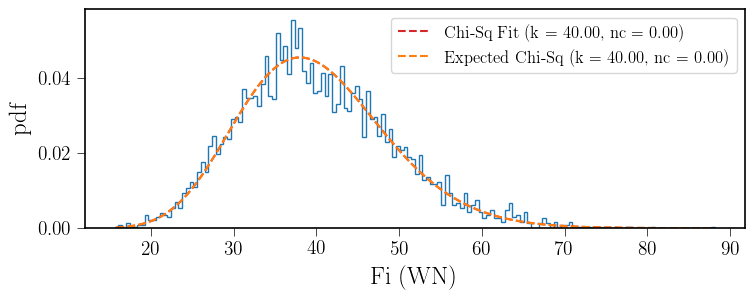

In [71]:
fi_wn_fps = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn.txt')
fi_wn_avg_nc = 0 #noise only case
ns, bins, patches = plt.hist(fi_wn_fps, histtype='step', bins=160,density=True, color='tab:blue')
# plt.title("Fe ".format(rn_amp))
# plt.show()
# plt.close()

fi_wn_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fi_wn_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_incoh, fi_wn_midpts, fi_wn_counts, p0 = [0],maxfev = 5000)


# opt_k = popt[0]
fi_wn_opt_k = 40
fi_wn_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fi_wn_fitted = []
fi_wn_expected = []
for pt in fi_wn_midpts:
    fi_wn_fitted.append(nc_chisq_wrapper(pt, fi_wn_opt_k, fi_wn_opt_nc))
    fi_wn_expected.append(nc_chisq_wrapper(pt, fi_wn_opt_k, fi_wn_avg_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fi_wn_midpts, fi_wn_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fi_wn_opt_k, fi_wn_opt_nc))
plt.plot(fi_wn_midpts, fi_wn_expected, ls='--', color='tab:orange', label='Expected Chi-Sq (k = {:.02f}, nc = {:.02f})'.format(fi_wn_opt_k, fi_wn_opt_nc))
plt.legend(loc='upper right')
plt.xlabel("Fi (WN)")
plt.ylabel("pdf")
plt.show()
plt.close()

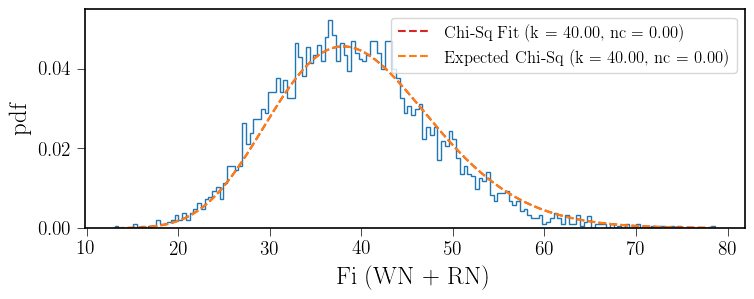

In [72]:
fi_wn_rn_fps = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_rn.txt')
fi_wn_rn_avg_nc = 0 #noise only case
ns, bins, patches = plt.hist(fi_wn_rn_fps, histtype='step', bins=160,density=True, color='tab:blue')
# plt.title("Fe ".format(rn_amp))
# plt.show()
# plt.close()

fi_wn_rn_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fi_wn_rn_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_incoh, fi_wn_rn_midpts, fi_wn_rn_counts, p0 = [0],maxfev = 5000)


# opt_k = popt[0]
fi_wn_rn_opt_k = 40
fi_wn_rn_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fi_wn_rn_fitted = []
fi_wn_rn_expected = []
for pt in fi_wn_rn_midpts:
    fi_wn_rn_fitted.append(nc_chisq_wrapper(pt, fi_wn_rn_opt_k, fi_wn_rn_opt_nc))
    fi_wn_rn_expected.append(nc_chisq_wrapper(pt, fi_wn_rn_opt_k, fi_wn_rn_avg_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fi_wn_rn_midpts, fi_wn_rn_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fi_wn_rn_opt_k, fi_wn_rn_opt_nc))
plt.plot(fi_wn_rn_midpts, fi_wn_rn_expected, ls='--', color='tab:orange', label='Expected Chi-Sq (k = {:.02f}, nc = {:.02f})'.format(fi_wn_rn_opt_k, fi_wn_rn_opt_nc))
plt.legend(loc='upper right')
plt.xlabel("Fi (WN + RN)")
plt.ylabel("pdf")
plt.show()
plt.close()

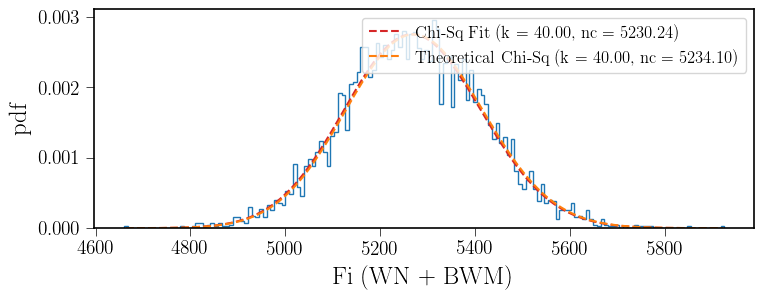

In [73]:
fi_wn_bwm_fps = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_bwm.txt')
fi_wn_bwm_avg_nc = np.mean(np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_bwm_ncs.txt'))
ns, bins, patches = plt.hist(fi_wn_bwm_fps, histtype='step', bins=160, density=True, color='tab:blue')
# plt.title("Fe ".format(rn_amp))
# plt.show()
# plt.close()

fi_wn_bwm_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fi_wn_bwm_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_incoh, fi_wn_bwm_midpts, fi_wn_bwm_counts, p0 = [5230],maxfev = 5000)


# opt_k = popt[0]
fi_wn_bwm_opt_k = 40
fi_wn_bwm_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fi_wn_bwm_fitted = []
fi_wn_bwm_expected = []
for pt in fi_wn_bwm_midpts:
    fi_wn_bwm_fitted.append(nc_chisq_wrapper(pt, fi_wn_bwm_opt_k, fi_wn_bwm_opt_nc))
    fi_wn_bwm_expected.append(nc_chisq_wrapper(pt, fi_wn_bwm_opt_k, fi_wn_bwm_avg_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fi_wn_bwm_midpts, fi_wn_bwm_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fi_wn_bwm_opt_k, fi_wn_bwm_opt_nc))
plt.plot(fi_wn_bwm_midpts, fi_wn_bwm_expected, ls='--', color='tab:orange', label='Theoretical Chi-Sq (k = {:.02f}, nc = {:.02f})'.format(fi_wn_bwm_opt_k, fi_wn_bwm_avg_nc))

plt.legend(loc='upper right')
plt.xlabel("Fi (WN + BWM)")
plt.ylabel("pdf")
plt.show()
plt.close()

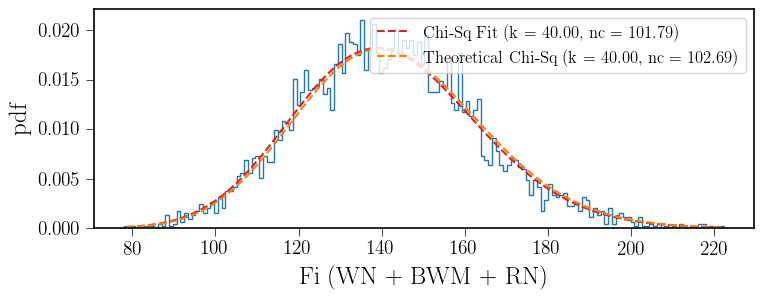

In [74]:
fi_wn_rn_bwm_fps = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_rn_bwm.txt')
fi_wn_rn_bwm_avg_nc = np.mean(np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fi_wn_rn_bwm_ncs.txt'))
ns, bins, patches = plt.hist(fi_wn_rn_bwm_fps, histtype='step', bins=160,density=True, color='tab:blue')
# plt.title("Fe ".format(rn_amp))
# plt.show()
# plt.close()

fi_wn_rn_bwm_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fi_wn_rn_bwm_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_incoh, fi_wn_rn_bwm_midpts, fi_wn_rn_bwm_counts, p0 = [120],maxfev = 5000)


# opt_k = popt[0]
fi_wn_rn_bwm_opt_k = 40
fi_wn_rn_bwm_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fi_wn_rn_bwm_fitted = []
fi_wn_rn_bwm_expected = []
for pt in fi_wn_rn_bwm_midpts:
    fi_wn_rn_bwm_fitted.append(nc_chisq_wrapper(pt, fi_wn_rn_bwm_opt_k, fi_wn_rn_bwm_opt_nc))
    fi_wn_rn_bwm_expected.append(nc_chisq_wrapper(pt, fi_wn_rn_bwm_opt_k, fi_wn_rn_bwm_avg_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fi_wn_rn_bwm_midpts, fi_wn_rn_bwm_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fi_wn_rn_bwm_opt_k,fi_wn_rn_bwm_opt_nc))
plt.plot(fi_wn_rn_bwm_midpts, fi_wn_rn_bwm_expected, ls='--', color='tab:orange', label='Theoretical Chi-Sq (k = {:.02f}, nc = {:.02f})'.format(fi_wn_rn_bwm_opt_k, fi_wn_rn_bwm_avg_nc))

plt.legend(loc='upper right')
plt.xlabel("Fi (WN + BWM + RN)")
plt.ylabel("pdf")
plt.show()
plt.close()

Fc

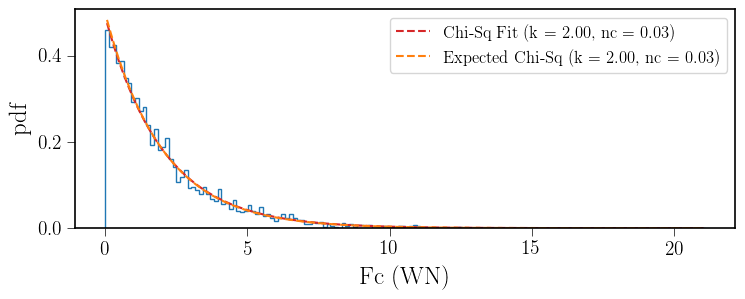

In [75]:
fc_wn_fps = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn.txt')
fc_wn_avg_nc = 0 #noise only case
ns, bins, patches = plt.hist(fc_wn_fps, histtype='step', bins=160,density=True, color='tab:blue')
# plt.title("Fe ".format(rn_amp))
# plt.show()
# plt.close()

fc_wn_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fc_wn_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_coh, fc_wn_midpts, fc_wn_counts, p0 = [0],maxfev = 5000)


# opt_k = popt[0]
fc_wn_opt_k = 2
fc_wn_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fc_wn_fitted = []
fc_wn_expected = []
for pt in fc_wn_midpts:
    fc_wn_fitted.append(nc_chisq_wrapper(pt, fc_wn_opt_k, fc_wn_opt_nc))
    fc_wn_expected.append(nc_chisq_wrapper(pt, fc_wn_opt_k,fc_wn_avg_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fc_wn_midpts, fc_wn_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fc_wn_opt_k, fc_wn_opt_nc))
plt.plot(fc_wn_midpts, fc_wn_expected, ls='--', color='tab:orange', label='Expected Chi-Sq (k = {:.02f}, nc = {:.02f})'.format(fc_wn_opt_k, fc_wn_opt_nc))
plt.legend(loc='upper right')
plt.xlabel("Fc (WN)")
plt.ylabel("pdf")
plt.show()
plt.close()

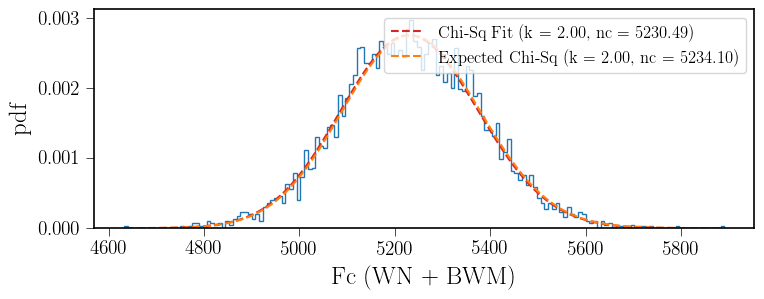

In [76]:
fc_wn_bwm_fps = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_bwm.txt')
fc_wn_bwm_avg_nc = np.mean(np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_bwm_ncs.txt')) #noise only case
ns, bins, patches = plt.hist(fc_wn_bwm_fps, histtype='step', bins=160,density=True, color='tab:blue')
# plt.title("Fe ".format(rn_amp))
# plt.show()
# plt.close()

fc_wn_bwm_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fc_wn_bwm_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_coh, fc_wn_bwm_midpts, fc_wn_bwm_counts, p0 = [5200],maxfev = 5000)


# opt_k = popt[0]
fc_wn_bwm_opt_k = 2
fc_wn_bwm_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fc_wn_bwm_fitted = []
fc_wn_bwm_expected = []
for pt in fc_wn_bwm_midpts:
    fc_wn_bwm_fitted.append(nc_chisq_wrapper(pt, fc_wn_bwm_opt_k, fc_wn_bwm_opt_nc))
    fc_wn_bwm_expected.append(nc_chisq_wrapper(pt, fc_wn_bwm_opt_k,fc_wn_bwm_avg_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fc_wn_bwm_midpts, fc_wn_bwm_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fc_wn_bwm_opt_k, fc_wn_bwm_opt_nc))
plt.plot(fc_wn_bwm_midpts, fc_wn_bwm_expected, ls='--', color='tab:orange', label='Expected Chi-Sq (k = {:.02f}, nc = {:.02f})'.format(fc_wn_bwm_opt_k, fc_wn_bwm_avg_nc))
plt.legend(loc='upper right')
plt.xlabel("Fc (WN + BWM)")
plt.ylabel("pdf")
plt.show()
plt.close()

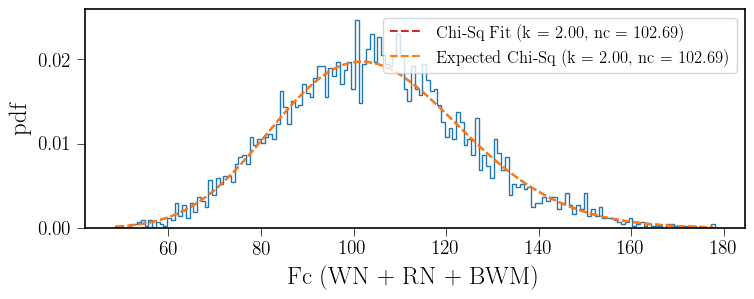

In [77]:
fc_wn_rn_bwm_fps = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_bwm.txt')
fc_wn_rn_bwm_avg_nc = np.mean(np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_bwm_ncs.txt')) #noise only case
ns, bins, patches = plt.hist(fc_wn_rn_bwm_fps, histtype='step', bins=160,density=True, color='tab:blue')
# plt.title("Fe ".format(rn_amp))
# plt.show()
# plt.close()

fc_wn_rn_bwm_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fc_wn_rn_bwm_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_coh, fc_wn_rn_bwm_midpts, fc_wn_rn_bwm_counts, p0 = [100],maxfev = 5000)


# opt_k = popt[0]
fc_wn_rn_bwm_opt_k = 2
fc_wn_rn_bwm_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fc_wn_rn_bwm_fitted = []
fc_wn_rn_bwm_expected = []
for pt in fc_wn_rn_bwm_midpts:
    fc_wn_rn_bwm_fitted.append(nc_chisq_wrapper(pt, fc_wn_rn_bwm_opt_k, fc_wn_rn_bwm_opt_nc))
    fc_wn_rn_bwm_expected.append(nc_chisq_wrapper(pt, fc_wn_rn_bwm_opt_k,fc_wn_rn_bwm_avg_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fc_wn_rn_bwm_midpts, fc_wn_rn_bwm_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fc_wn_rn_bwm_opt_k, fc_wn_rn_bwm_opt_nc))
plt.plot(fc_wn_rn_bwm_midpts, fc_wn_rn_bwm_expected, ls='--', color='tab:orange', label='Expected Chi-Sq (k = {:.02f}, nc = {:.02f})'.format(fc_wn_rn_bwm_opt_k, fc_wn_rn_bwm_avg_nc))
plt.legend(loc='upper right')
plt.xlabel("Fc (WN + RN + BWM)")
plt.ylabel("pdf")
plt.show()
plt.close()

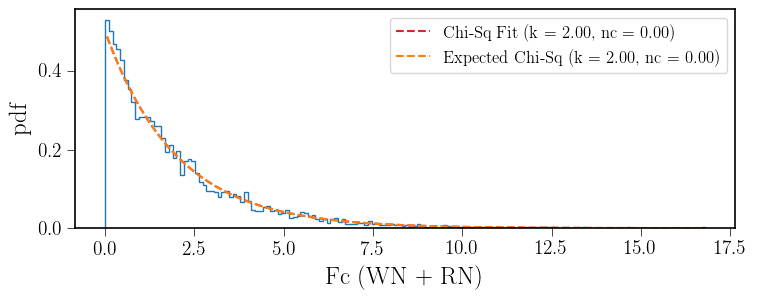

In [78]:
fc_wn_rn_fps = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn.txt')
fc_wn_rn_avg_nc = 0 #noise only case
ns, bins, patches = plt.hist(fc_wn_rn_fps, histtype='step', bins=160,density=True, color='tab:blue')
# plt.title("Fe ".format(rn_amp))
# plt.show()
# plt.close()

fc_wn_rn_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fc_wn_rn_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_coh, fc_wn_rn_midpts, fc_wn_rn_counts, p0 = [0],maxfev = 5000)


# opt_k = popt[0]
fc_wn_rn_opt_k = 2
fc_wn_rn_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fc_wn_rn_fitted = []
fc_wn_rn_expected = []
for pt in fc_wn_rn_midpts:
    fc_wn_rn_fitted.append(nc_chisq_wrapper(pt, fc_wn_rn_opt_k, fc_wn_rn_opt_nc))
    fc_wn_rn_expected.append(nc_chisq_wrapper(pt, fc_wn_rn_opt_k, fc_wn_rn_avg_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fc_wn_rn_midpts, fc_wn_rn_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fc_wn_rn_opt_k, fc_wn_rn_opt_nc))
plt.plot(fc_wn_rn_midpts, fc_wn_rn_expected, ls='--', color='tab:orange', label='Expected Chi-Sq (k = {:.02f}, nc = {:.02f})'.format(fc_wn_rn_opt_k, fc_wn_rn_avg_nc))
plt.legend(loc='upper right')
plt.xlabel("Fc (WN + RN)")
plt.ylabel("pdf")
plt.show()
plt.close()

# Subplots

Let's combine all the above to make a disgusting gigaplot

/tmp/ipykernel_7769/1876776890.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.03)


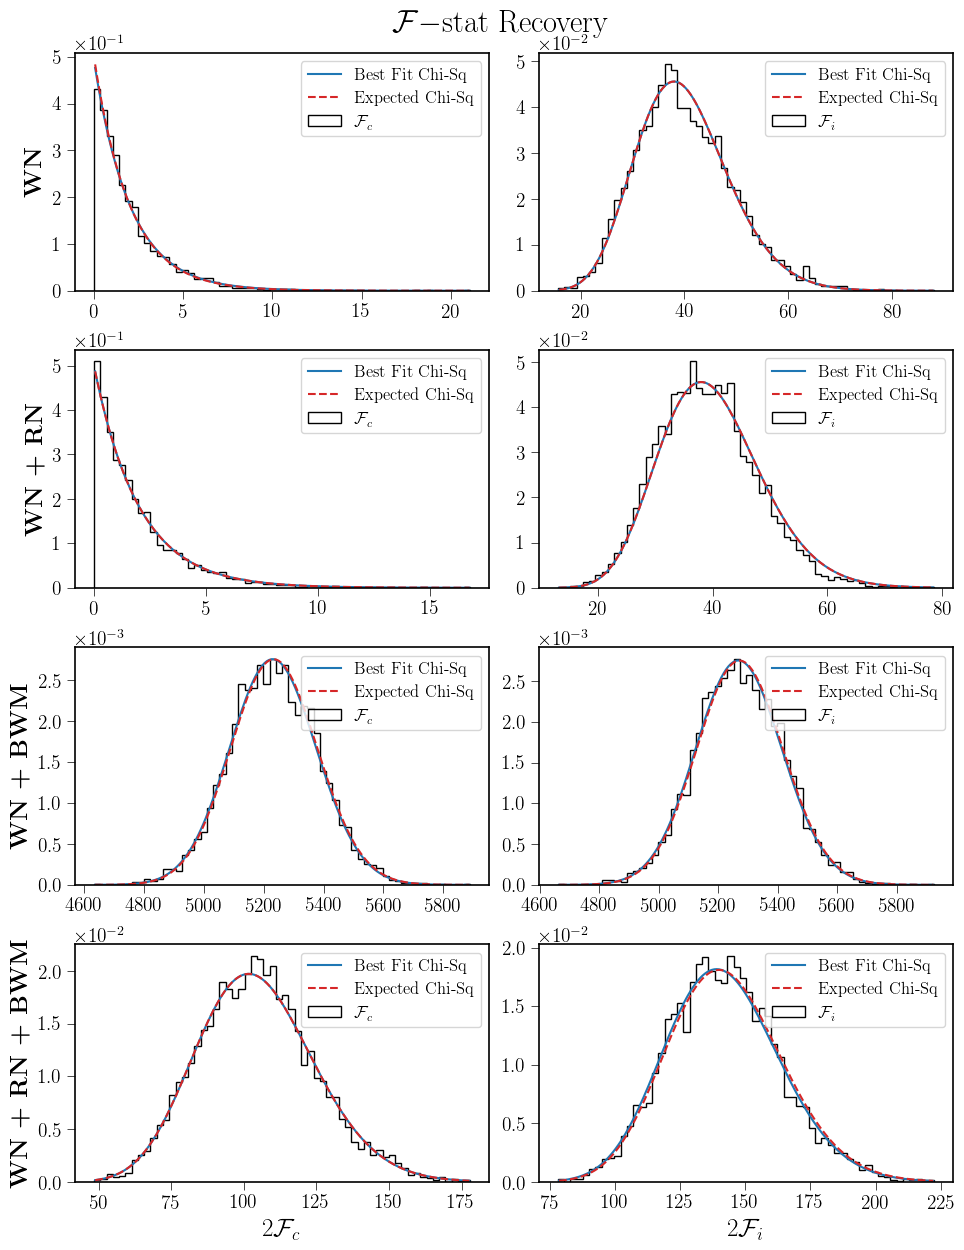

In [84]:
bigfig, bigaxs = plt.subplots(4, 2, figsize = (11.33,14.66), gridspec_kw = {'wspace':0.12, 'hspace':0.25})


# split axes up
fc_wn_ax = bigaxs[0,0]
fc_wn_rn_ax = bigaxs[1,0]
fc_wn_bwm_ax = bigaxs[2,0]
fc_wn_rn_bwm_ax = bigaxs[3,0]


fi_wn_ax = bigaxs[0,1]
fi_wn_rn_ax = bigaxs[1,1]
fi_wn_bwm_ax = bigaxs[2,1]
fi_wn_rn_bwm_ax = bigaxs[3,1]

# fc_plots
ns, bins, patches = fc_wn_ax.hist(fc_wn_fps, histtype='step', bins=60,density=True, color='black', label=r'$\pazocal{F}_c$')
fc_wn_ax.plot(fc_wn_midpts, fc_wn_fitted,  color='tab:blue',  label='Best Fit Chi-Sq')
fc_wn_ax.plot(fc_wn_midpts, fc_wn_expected, ls='--', color='tab:red',  label='Expected Chi-Sq')
fc_wn_ax.legend(loc='upper right', fontsize = 12)

ns, bins, patches = fc_wn_rn_ax.hist(fc_wn_rn_fps, histtype='step', bins=60,density=True, color='black', label=r'$\pazocal{F}_c$')
fc_wn_rn_ax.plot(fc_wn_rn_midpts, fc_wn_rn_fitted, color='tab:blue', label='Best Fit Chi-Sq')
fc_wn_rn_ax.plot(fc_wn_rn_midpts, fc_wn_rn_expected, ls='--', color='tab:red', label='Expected Chi-Sq')
fc_wn_rn_ax.legend(loc='upper right', fontsize = 12)

ns, bins, patches = fc_wn_bwm_ax.hist(fc_wn_bwm_fps, histtype='step', bins=60,density=True, color='black', label=r'$\pazocal{F}_c$')
fc_wn_bwm_ax.plot(fc_wn_bwm_midpts, fc_wn_bwm_fitted, color='tab:blue', label='Best Fit Chi-Sq')
fc_wn_bwm_ax.plot(fc_wn_bwm_midpts, fc_wn_bwm_expected, ls='--', color='tab:red', label='Expected Chi-Sq')
fc_wn_bwm_ax.legend(loc='upper right', fontsize = 12)


ns, bins, patches = fc_wn_rn_bwm_ax.hist(fc_wn_rn_bwm_fps, histtype='step', bins=60,density=True, color='black', label=r'$\pazocal{F}_c$')
fc_wn_rn_bwm_ax.plot(fc_wn_rn_bwm_midpts, fc_wn_rn_bwm_fitted, color='tab:blue', label='Best Fit Chi-Sq')
fc_wn_rn_bwm_ax.plot(fc_wn_rn_bwm_midpts, fc_wn_rn_bwm_expected, ls='--', color='tab:red', label='Expected Chi-Sq')
fc_wn_rn_bwm_ax.legend(loc='upper right', fontsize = 12)


# fi_plots
fi_wn_ax.hist(fi_wn_fps, bins=60,histtype='step', density=True, color='black', label=r'$\pazocal{F}_i$')
fi_wn_ax.plot(fi_wn_midpts, fi_wn_fitted,  color='tab:blue', label='Best Fit Chi-Sq')
fi_wn_ax.plot(fi_wn_midpts, fi_wn_expected, ls='--', color='tab:red', label='Expected Chi-Sq')
fi_wn_ax.legend(loc='upper right', fontsize = 12)

fi_wn_rn_ax.hist(fi_wn_rn_fps, bins=60,histtype='step', density=True, color='black', label=r'$\pazocal{F}_i$')
fi_wn_rn_ax.plot(fi_wn_rn_midpts, fi_wn_rn_fitted, color='tab:blue', label='Best Fit Chi-Sq')
fi_wn_rn_ax.plot(fi_wn_rn_midpts, fi_wn_rn_expected, ls='--', color='tab:red', label='Expected Chi-Sq')
fi_wn_rn_ax.legend(loc='upper right', fontsize = 12)

fi_wn_bwm_ax.hist(fi_wn_bwm_fps, bins=60,histtype='step', density=True, color='black', label=r'$\pazocal{F}_i$')
fi_wn_bwm_ax.plot(fi_wn_bwm_midpts, fi_wn_bwm_fitted, color='tab:blue', label='Best Fit Chi-Sq')
fi_wn_bwm_ax.plot(fi_wn_bwm_midpts, fi_wn_bwm_expected, ls='--', color='tab:red', label='Expected Chi-Sq')
fi_wn_bwm_ax.legend(loc='upper right', fontsize = 12)

fi_wn_rn_bwm_ax.hist(fi_wn_rn_bwm_fps, bins=60,histtype='step', density=True, color='black', label=r'$\pazocal{F}_i$')
fi_wn_rn_bwm_ax.plot(fi_wn_rn_bwm_midpts, fi_wn_rn_bwm_fitted, color='tab:blue', label='Best Fit Chi-Sq')
fi_wn_rn_bwm_ax.plot(fi_wn_rn_bwm_midpts, fi_wn_rn_bwm_expected, ls='--', color='tab:red', label='Expected Chi-Sq')
fi_wn_rn_bwm_ax.legend(loc='upper right', fontsize = 12)

#labels
fc_wn_rn_bwm_ax.set_xlabel(r'$2\pazocal{F}_c$', fontsize = 18)
fi_wn_rn_bwm_ax.set_xlabel(r'$2\pazocal{F}_i$', fontsize = 18)

fc_wn_ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fc_wn_rn_ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fc_wn_bwm_ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fc_wn_rn_bwm_ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

fi_wn_ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fi_wn_rn_ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fi_wn_bwm_ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fi_wn_rn_bwm_ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

fc_wn_ax.set_ylabel(r'\textbf{WN}', rotation='vertical', )
fc_wn_rn_ax.set_ylabel(r'\textbf{WN + RN}', rotation='vertical', )
fc_wn_bwm_ax.set_ylabel(r'\textbf{WN + BWM}', rotation='vertical', )
fc_wn_rn_bwm_ax.set_ylabel(r'\textbf{WN + RN + BWM}', rotation='vertical')

plt.suptitle("$\pazocal{F}-$stat Recovery",y = 0.91, fontsize=22)
plt.tight_layout(pad=1.03)
plt.savefig('/home/nima/nanograv/bwm_fpfe/fstat_recovery.pdf')
plt.show()
plt.close()

# Max Likely amplitude and polarization recovery
### Strong signal (log10_A = -13.5)

In [9]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []
prefit_irn_covs = []
psr_locs = np.loadtxt(psrloc_path)


rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = np.pi/8
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [10]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    nc_estimate = 0    
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series + bwm_signals[ipsr]
        prefit_resids =  wn_series + rn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

        # prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        # prefit_resids = wn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc

        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        

        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     
        
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    M_pinv = np.linalg.pinv(M)
    
    bp = M_pinv[0,0] * Np + M_pinv[0,1] * Nc
    bc = M_pinv[1,0] * Np + M_pinv[1,1] * Nc
    

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe, nc_estimate, bp, bc

In [11]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fe_worker, args)

results = np.array(results)
# print(results)
estimated_ncs = results[:,1]
fe_bs = results[:, (0,2,3)]

outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_strongbwm_piby8_polarized_verbose.txt'
np.savetxt(outfile, fe_bs)

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_strongbwm_ncs_piby8_polarized.txt'
np.savetxt(nc_outfile, estimated_ncs)

Finished iteration 1092 in 3.4s. Fe = 81.8975272333167
Finished iteration 756 in 3.5s. Fe = 90.8268808783326
Finished iteration 1176 in 3.8s. Fe = 57.520855444887296
Finished iteration 672 in 4.8s. Fe = 110.01981104107786Finished iteration 1008 in 4.9s. Fe = 61.523483542368545

Finished iteration 588 in 5.2s. Fe = 61.04511318243111
Finished iteration 840 in 5.6s. Fe = 50.395245134984194
Finished iteration 0 in 5.8s. Fe = 45.075847142377455
Finished iteration 168 in 6.0s. Fe = 65.54266807983112
Finished iteration 924 in 6.1s. Fe = 85.26881377578793
Finished iteration 420 in 6.9s. Fe = 58.80309577640402
Finished iteration 757 in 3.6s. Fe = 65.00217268817326Finished iteration 504 in 7.1s. Fe = 66.22608078853978Finished iteration 84 in 7.1s. Fe = 69.71599426450804


Finished iteration 252 in 7.4s. Fe = 90.82592749475148
Finished iteration 336 in 7.4s. Fe = 66.01158761559267
Finished iteration 1093 in 4.8s. Fe = 72.8569846338379
Finished iteration 673 in 3.4s. Fe = 48.119745939868906
Finish

Finished iteration 105 in 4.0s. Fe = 95.00092594943172
Finished iteration 690 in 6.5s. Fe = 92.53583934501299
Finished iteration 441 in 6.6s. Fe = 72.00367979398017
Finished iteration 270 in 6.6s. Fe = 79.11426470589906
Finished iteration 522 in 6.2s. Fe = 88.11814397885948
Finished iteration 354 in 6.7s. Fe = 85.83177741525691
Finished iteration 1112 in 7.3s. Fe = 47.81151934844745
Finished iteration 943 in 6.1s. Fe = 88.90787419316817
Finished iteration 858 in 3.6s. Fe = 59.7382805141999
Finished iteration 20 in 6.7s. Fe = 59.38750111626581
Finished iteration 523 in 2.6s. Fe = 86.84334445086529
Finished iteration 1028 in 6.8s. Fe = 81.65296597792678
Finished iteration 944 in 3.1s. Fe = 88.61845698523473
Finished iteration 859 in 3.2s. Fe = 59.2605442660359
Finished iteration 609 in 6.3s. Fe = 73.5096028160507
Finished iteration 779 in 7.2s. Fe = 77.39273722143656
Finished iteration 188 in 6.3s. Fe = 68.83943725983548
Finished iteration 442 in 5.4s. Fe = 81.0532958484202
Finished iter

Finished iteration 40 in 2.3s. Fe = 72.07682667392324
Finished iteration 290 in 3.0s. Fe = 80.4625993064318
Finished iteration 123 in 6.4s. Fe = 91.84323692719295
Finished iteration 206 in 6.4s. Fe = 65.07599200829105
Finished iteration 627 in 7.3s. Fe = 74.46649537556799
Finished iteration 1130 in 7.3s. Fe = 68.64561214332262
Finished iteration 963 in 6.7s. Fe = 63.42662197569331
Finished iteration 374 in 3.9s. Fe = 60.55548623387094
Finished iteration 544 in 3.9s. Fe = 109.33637697398896
Finished iteration 879 in 6.5s. Fe = 66.16805597959278
Finished iteration 799 in 5.9s. Fe = 48.82282201154871
Finished iteration 964 in 2.2s. Fe = 96.33286794565363
Finished iteration 711 in 5.8s. Fe = 70.0380802028831
Finished iteration 291 in 4.5s. Fe = 56.13369144220999
Finished iteration 1049 in 5.6s. Fe = 90.31597804078054
Finished iteration 461 in 6.4s. Fe = 96.36141606059456
Finished iteration 1216 in 6.6s. Fe = 104.05351730337445
Finished iteration 41 in 6.6s. Fe = 72.64856680290887
Finished 

Finished iteration 1152 in 1.8s. Fe = 71.61360903589092
Finished iteration 646 in 6.3s. Fe = 62.350106713489566
Finished iteration 309 in 5.2s. Fe = 35.43392987236069
Finished iteration 898 in 7.0s. Fe = 63.22938288622501
Finished iteration 143 in 6.4s. Fe = 96.33563356823015
Finished iteration 731 in 6.1s. Fe = 44.02430491175086
Finished iteration 480 in 6.6s. Fe = 55.37548805880386
Finished iteration 227 in 5.7s. Fe = 62.59035905448665
Finished iteration 818 in 5.9s. Fe = 47.741197435647436
Finished iteration 563 in 5.9s. Fe = 47.524725266788565
Finished iteration 395 in 6.5s. Fe = 70.33379970254619
Finished iteration 59 in 6.5s. Fe = 111.15388370205224
Finished iteration 984 in 6.5s. Fe = 75.45970933311102
Finished iteration 1068 in 6.5s. Fe = 82.20684589201805
Finished iteration 899 in 4.3s. Fe = 56.546974719043874
Finished iteration 1235 in 6.5s. Fe = 85.23499521652793
Finished iteration 144 in 4.6s. Fe = 72.18510811179013
Finished iteration 1153 in 6.9s. Fe = 66.35307574435592
Fi

Finished iteration 1004 in 6.6s. Fe = 90.84323544033411
Finished iteration 916 in 6.3s. Fe = 47.960194034642925
Finished iteration 751 in 5.2s. Fe = 71.93766585339075
Finished iteration 582 in 6.5s. Fe = 68.42690279620041
Finished iteration 836 in 6.6s. Fe = 99.32812394205875
Finished iteration 415 in 6.5s. Fe = 91.20537797088195
Finished iteration 666 in 5.9s. Fe = 56.6677897589393
Finished iteration 500 in 6.6s. Fe = 103.36059913105183
Finished iteration 77 in 5.2s. Fe = 84.83721825360574
Finished iteration 248 in 6.6s. Fe = 72.35202917127262
Finished iteration 162 in 7.0s. Fe = 73.92726537548269
Finished iteration 583 in 3.2s. Fe = 92.16024014320392
Finished iteration 1089 in 6.0s. Fe = 74.17722090265737
Finished iteration 1173 in 6.4s. Fe = 52.42844624616558
Finished iteration 917 in 4.5s. Fe = 72.80467500037966
Finished iteration 330 in 6.5s. Fe = 76.10498738342827
Finished iteration 1255 in 6.5s. Fe = 95.96051375118068
Finished iteration 752 in 5.6s. Fe = 95.01154243917641
Finish

Finished iteration 1442 in 6.1s. Fe = 81.26620737200648
Finished iteration 1610 in 1.8s. Fe = 70.76169894327893
Finished iteration 2198 in 5.3s. Fe = 80.38080860916506
Finished iteration 1864 in 6.6s. Fe = 79.00540384770227
Finished iteration 1778 in 5.5s. Fe = 96.7031276281167
Finished iteration 1946 in 5.9s. Fe = 56.20430024140049
Finished iteration 1277 in 5.5s. Fe = 68.7450025789986
Finished iteration 2281 in 6.1s. Fe = 102.13145111165777
Finished iteration 1528 in 5.7s. Fe = 78.44906713937542
Finished iteration 2448 in 5.9s. Fe = 63.452883477346866
Finished iteration 1361 in 6.8s. Fe = 61.06515700096064
Finished iteration 2364 in 7.8s. Fe = 70.25986381729865
Finished iteration 2113 in 6.7s. Fe = 85.3960136185831
Finished iteration 2030 in 6.5s. Fe = 67.28754692508684
Finished iteration 1696 in 6.7s. Fe = 62.24460202359529
Finished iteration 1443 in 6.5s. Fe = 74.7984207012044
Finished iteration 1611 in 5.7s. Fe = 45.26211518755981
Finished iteration 2199 in 5.9s. Fe = 51.854719010

Finished iteration 1630 in 6.6s. Fe = 122.78672376815754
Finished iteration 2383 in 6.7s. Fe = 90.32422757217603
Finished iteration 1798 in 6.2s. Fe = 77.51090893824099
Finished iteration 2131 in 6.2s. Fe = 53.07443757167735
Finished iteration 2217 in 5.7s. Fe = 55.885077691838724
Finished iteration 2301 in 7.1s. Fe = 69.35053604075802
Finished iteration 2468 in 7.1s. Fe = 72.2727988906268
Finished iteration 1965 in 6.4s. Fe = 58.20905630682394
Finished iteration 1716 in 4.4s. Fe = 79.45304713139072
Finished iteration 1380 in 5.8s. Fe = 81.83877938615059
Finished iteration 2050 in 7.4s. Fe = 38.99773482905164
Finished iteration 1884 in 5.8s. Fe = 55.42791110483422
Finished iteration 1296 in 7.3s. Fe = 47.55176408488588
Finished iteration 1462 in 5.2s. Fe = 99.76926276066249
Finished iteration 1631 in 4.9s. Fe = 64.15826743684683
Finished iteration 2302 in 4.2s. Fe = 67.22001346095048
Finished iteration 2218 in 5.4s. Fe = 93.83228041949513
Finished iteration 1547 in 7.0s. Fe = 109.88902

Finished iteration 1566 in 8.9s. Fe = 89.45580913602673
Finished iteration 1902 in 5.3s. Fe = 51.55543971617868
Finished iteration 2319 in 6.8s. Fe = 63.762529026935994
Finished iteration 2489 in 6.0s. Fe = 110.19061261978891
Finished iteration 1399 in 6.3s. Fe = 76.7299239089563
Finished iteration 1481 in 4.7s. Fe = 89.65627917214347
Finished iteration 1985 in 7.5s. Fe = 74.18997417188207
Finished iteration 1735 in 4.5s. Fe = 65.80398295176587
Finished iteration 1817 in 6.3s. Fe = 53.00556948013748
Finished iteration 2151 in 4.7s. Fe = 57.121862861506514
Finished iteration 1903 in 3.0s. Fe = 60.97732759246877Finished iteration 1986 in 2.3s. Fe = 87.69887399372091

Finished iteration 1482 in 2.4s. Fe = 61.412463846135935
Finished iteration 1314 in 6.2s. Fe = 61.775214687482496
Finished iteration 2404 in 6.5s. Fe = 80.86575141391603
Finished iteration 1818 in 2.6s. Fe = 50.84860811850071
Finished iteration 1400 in 4.5s. Fe = 80.21627073232237
Finished iteration 2070 in 6.6s. Fe = 52.431

Finished iteration 1500 in 6.9s. Fe = 79.43504986626512
Finished iteration 2003 in 5.4s. Fe = 61.48847505321181
Finished iteration 1837 in 6.3s. Fe = 73.30037580000081
Finished iteration 2421 in 4.0s. Fe = 73.3475555947197Finished iteration 1586 in 6.7s. Fe = 68.95152566156843

Finished iteration 1754 in 6.0s. Fe = 66.76851009663854
Finished iteration 2257 in 5.6s. Fe = 89.2325132153988
Finished iteration 1669 in 6.5s. Fe = 81.22556725957064
Finished iteration 1333 in 6.2s. Fe = 69.06272767838837
Finished iteration 1419 in 6.5s. Fe = 72.20160260898353
Finished iteration 2170 in 6.5s. Fe = 102.6373234870292
Finished iteration 2090 in 6.0s. Fe = 63.01818994708116
Finished iteration 2509 in 6.8s. Fe = 65.45994924829748
Finished iteration 1838 in 4.4s. Fe = 51.563051125215104
Finished iteration 2004 in 4.7s. Fe = 63.61545220857154
Finished iteration 2422 in 4.6s. Fe = 60.31322273465808
Finished iteration 1925 in 6.6s. Fe = 101.16078440294666
Finished iteration 1501 in 5.3s. Fe = 85.5541301

Finished iteration 3367 in 6.2s. Fe = 73.32001334533369
Finished iteration 2531 in 6.7s. Fe = 64.27505217458311
Finished iteration 3449 in 6.4s. Fe = 82.22595048471291
Finished iteration 3533 in 3.5s. Fe = 65.46335055921988
Finished iteration 3032 in 6.3s. Fe = 45.79743748391942Finished iteration 3700 in 6.7s. Fe = 65.5266541035037

Finished iteration 3117 in 2.7s. Fe = 71.40365433714615
Finished iteration 3534 in 2.4s. Fe = 81.07708391922598
Finished iteration 2949 in 6.5s. Fe = 60.78965068215326Finished iteration 3200 in 7.3s. Fe = 113.89856505164833

Finished iteration 2865 in 7.1s. Fe = 46.29754311515898
Finished iteration 3284 in 6.6s. Fe = 59.8404841348833
Finished iteration 3618 in 6.9s. Fe = 46.62593542588108
Finished iteration 3450 in 4.5s. Fe = 100.32885876305767
Finished iteration 3118 in 3.2s. Fe = 66.256311695876
Finished iteration 2614 in 6.8s. Fe = 67.6887572515282
Finished iteration 2785 in 6.9s. Fe = 72.20573132271124
Finished iteration 2700 in 6.7s. Fe = 68.5242786421

Finished iteration 3050 in 5.3s. Fe = 88.87357501250483
Finished iteration 3387 in 3.8s. Fe = 108.7014766147756
Finished iteration 3219 in 2.6s. Fe = 67.95576016882683
Finished iteration 3302 in 3.6s. Fe = 93.74260684154876
Finished iteration 3636 in 4.3s. Fe = 68.15873823868706
Finished iteration 2718 in 3.6s. Fe = 62.220409058351265Finished iteration 2884 in 5.3s. Fe = 68.60106790297516

Finished iteration 3472 in 3.5s. Fe = 63.64118086797596
Finished iteration 3554 in 6.8s. Fe = 80.5754468730875Finished iteration 3721 in 7.3s. Fe = 79.94749832647899

Finished iteration 2969 in 5.1s. Fe = 72.6287746658639
Finished iteration 2632 in 5.6s. Fe = 60.42013284966008
Finished iteration 3137 in 6.9s. Fe = 44.3884934574792
Finished iteration 2805 in 6.4s. Fe = 46.469859242417485
Finished iteration 2550 in 6.6s. Fe = 65.40319171637788
Finished iteration 3220 in 3.9s. Fe = 63.49217432226263
Finished iteration 3051 in 6.6s. Fe = 91.30952649842295
Finished iteration 3473 in 3.8s. Fe = 85.83474922

Finished iteration 3239 in 6.6s. Fe = 55.050680006941406
Finished iteration 3322 in 6.8s. Fe = 58.801693575850294
Finished iteration 2570 in 5.3s. Fe = 70.68214253576852
Finished iteration 3071 in 4.0s. Fe = 94.39139966293855
Finished iteration 3740 in 5.8s. Fe = 72.03222906850829
Finished iteration 3492 in 4.3s. Fe = 71.4664564995411
Finished iteration 2823 in 7.0s. Fe = 49.66498121130732
Finished iteration 2652 in 4.4s. Fe = 62.878026966264905
Finished iteration 3405 in 6.4s. Fe = 98.28185734575453
Finished iteration 3656 in 6.5s. Fe = 99.05682980097916
Finished iteration 2902 in 6.7s. Fe = 55.726226586612725
Finished iteration 2988 in 7.1s. Fe = 68.01370256475802
Finished iteration 2738 in 7.1s. Fe = 61.65411558155998
Finished iteration 3574 in 4.9s. Fe = 72.03651525655832
Finished iteration 3156 in 5.3s. Fe = 72.04991408347732
Finished iteration 3323 in 4.5s. Fe = 78.36485883226672
Finished iteration 3072 in 3.7s. Fe = 53.16104492708581
Finished iteration 2571 in 4.5s. Fe = 53.1507

Finished iteration 3257 in 6.3s. Fe = 85.20605157740353
Finished iteration 3007 in 4.6s. Fe = 57.02430487592081
Finished iteration 2588 in 6.1s. Fe = 101.07940631196453
Finished iteration 3512 in 5.8s. Fe = 78.38832737081441
Finished iteration 2842 in 6.9s. Fe = 100.79880228626314
Finished iteration 2671 in 7.0s. Fe = 95.6530661176428
Finished iteration 3675 in 4.0s. Fe = 67.85392137686569
Finished iteration 3094 in 4.6s. Fe = 42.36505206817694
Finished iteration 3008 in 1.7s. Fe = 95.31899082623775
Finished iteration 3341 in 6.5s. Fe = 78.11832759721548
Finished iteration 3759 in 6.6s. Fe = 26.94457693717407
Finished iteration 3594 in 7.2s. Fe = 52.68735510812347
Finished iteration 2758 in 6.9s. Fe = 63.970220867715625
Finished iteration 3425 in 6.9s. Fe = 79.11231739253006
Finished iteration 3175 in 6.0s. Fe = 52.616868551700875
Finished iteration 2922 in 6.7s. Fe = 61.208132709153304
Finished iteration 3676 in 4.9s. Fe = 68.16167212874026
Finished iteration 3258 in 6.8s. Fe = 69.856

Finished iteration 4119 in 5.0s. Fe = 90.94323024671417
Finished iteration 4369 in 6.7s. Fe = 73.24431480415026
Finished iteration 4621 in 6.1s. Fe = 67.98954725203438Finished iteration 3869 in 6.1s. Fe = 74.7782092076049

Finished iteration 4286 in 6.8s. Fe = 66.4913551035364
Finished iteration 3779 in 6.6s. Fe = 93.58001600468292
Finished iteration 4454 in 7.0s. Fe = 49.99196381495709
Finished iteration 4203 in 6.6s. Fe = 90.09220799111914Finished iteration 4704 in 5.8s. Fe = 57.326883380707464

Finished iteration 4537 in 6.2s. Fe = 63.478227615737396
Finished iteration 3786 in 6.8s. Fe = 75.14407483187367
Finished iteration 4036 in 6.8s. Fe = 63.61779394873575
Finished iteration 3953 in 7.1s. Fe = 46.97921732775619Finished iteration 4788 in 7.0s. Fe = 72.15415113067877

Finished iteration 4622 in 5.8s. Fe = 73.60306000578956
Finished iteration 4872 in 6.5s. Fe = 81.71620498142116
Finished iteration 4370 in 6.0s. Fe = 57.96259489771283
Finished iteration 4120 in 6.6s. Fe = 58.5775527

Finished iteration 4220 in 6.7s. Fe = 110.83183369223215
Finished iteration 4388 in 6.7s. Fe = 76.65085271046324
Finished iteration 3971 in 5.7s. Fe = 88.35437677888324
Finished iteration 4640 in 6.0s. Fe = 65.09369670327335
Finished iteration 3806 in 5.5s. Fe = 74.35961295703169
Finished iteration 4473 in 6.7s. Fe = 59.123263376317844
Finished iteration 4975 in 6.1s. Fe = 68.00477511861223
Finished iteration 4306 in 4.8s. Fe = 55.7660223044772
Finished iteration 4055 in 6.6s. Fe = 56.517208190549056
Finished iteration 4724 in 6.4s. Fe = 60.56054973213679
Finished iteration 4892 in 6.4s. Fe = 82.32303528699832
Finished iteration 4141 in 6.7s. Fe = 73.44525157111823
Finished iteration 4556 in 6.5s. Fe = 62.8938089271537
Finished iteration 4808 in 6.8s. Fe = 78.5945070330315Finished iteration 4221 in 5.8s. Fe = 117.30549133848211

Finished iteration 3889 in 6.8s. Fe = 73.37848562537872
Finished iteration 4389 in 6.5s. Fe = 103.54284849672794
Finished iteration 3972 in 5.9s. Fe = 53.43588

Finished iteration 4407 in 6.5s. Fe = 79.39061736171345
Finished iteration 4660 in 6.8s. Fe = 69.87707732729422
Finished iteration 4827 in 4.4s. Fe = 72.17693433699523
Finished iteration 4910 in 5.8s. Fe = 67.0166596692849
Finished iteration 4327 in 5.9s. Fe = 83.51680915989559
Finished iteration 4074 in 6.2s. Fe = 70.72793606529407
Finished iteration 4493 in 6.6s. Fe = 99.91764942750498Finished iteration 4994 in 5.4s. Fe = 65.72686683399851

Finished iteration 3826 in 5.8s. Fe = 71.45930290462492
Finished iteration 3991 in 6.2s. Fe = 70.28277950895792
Finished iteration 4744 in 6.7s. Fe = 71.97215456077147
Finished iteration 3908 in 6.5s. Fe = 61.49981006035658
Finished iteration 4240 in 6.6s. Fe = 63.263546454251
Finished iteration 4575 in 6.4s. Fe = 78.76633436322777
Finished iteration 4328 in 4.5s. Fe = 73.57584053032195
Finished iteration 4160 in 7.2s. Fe = 87.06262544743228
Finished iteration 4828 in 6.0s. Fe = 63.34567169778777
Finished iteration 4661 in 6.7s. Fe = 75.3384290745

Finished iteration 4094 in 5.5s. Fe = 45.59595555353279
Finished iteration 4259 in 5.0s. Fe = 57.55654412000638
Finished iteration 4013 in 6.5s. Fe = 72.68216210551552
Finished iteration 4427 in 6.1s. Fe = 56.39613940580605
Finished iteration 4514 in 6.2s. Fe = 56.15114574983018Finished iteration 3845 in 5.6s. Fe = 88.33937276344822

Finished iteration 4849 in 5.6s. Fe = 79.68960446982149
Finished iteration 4763 in 5.5s. Fe = 94.22075672357403
Finished iteration 4681 in 6.5s. Fe = 55.41989885162597
Finished iteration 4594 in 5.1s. Fe = 59.153838808550304
Finished iteration 3928 in 6.2s. Fe = 93.53022551892641
Finished iteration 4095 in 5.1s. Fe = 56.92577219347412
Finished iteration 4349 in 5.7s. Fe = 69.2131381141792
Finished iteration 4931 in 6.3s. Fe = 57.736830310607004
Finished iteration 4181 in 6.4s. Fe = 89.59034641721948
Finished iteration 4014 in 5.2s. Fe = 67.38712811448795
Finished iteration 4260 in 6.5s. Fe = 59.279948581966025
Finished iteration 4515 in 6.4s. Fe = 75.51602

Finished iteration 4951 in 3.9s. Fe = 86.6039182119037
Finished iteration 4115 in 3.5s. Fe = 55.86923659970411
Finished iteration 4784 in 3.6s. Fe = 70.45029313890338
Finished iteration 4451 in 2.8s. Fe = 45.61222581648198
Finished iteration 4702 in 2.5s. Fe = 84.7581413480124
Finished iteration 4616 in 2.7s. Fe = 67.83904123096231
Finished iteration 4281 in 2.8s. Fe = 43.68034359044874
Finished iteration 4952 in 2.9s. Fe = 111.38438604278339
Finished iteration 4785 in 2.8s. Fe = 67.40358846590378
Finished iteration 4282 in 1.4s. Fe = 63.01483748897903
Finished iteration 4703 in 2.0s. Fe = 39.8797817957455
Finished iteration 4617 in 2.1s. Fe = 99.39983162106964
Finished iteration 4786 in 2.1s. Fe = 69.75759902751648
Finished iteration 4953 in 2.3s. Fe = 78.45327477171102
Finished iteration 4283 in 2.0s. Fe = 103.44821770983282
Finished iteration 4618 in 1.5s. Fe = 115.6978947471521
Finished iteration 4787 in 1.5s. Fe = 87.76155599869963
Finished iteration 4954 in 1.6s. Fe = 67.14604439

In [86]:
maxlike_ncs = np.loadtxt("/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_strongbwm_ncs_piby8_polarized.txt")
maxlike_output = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_strongbwm_piby8_polarized_verbose.txt')

Using
$$\hat{h_0} = \sqrt{\hat{b}_{+}^2 + \hat{b}_{\times}^2}$$
$$\hat{\psi} = \tan^{-1}\left({\frac{\hat{b}_{\times}}{\hat{b}_{+}}}\right)$$

In [87]:
bps = maxlike_output[:,1]
bcs = maxlike_output[:,2]

injected_strain = -13.5
injected_pol = np.pi/8

maxlike_strains = np.log10(np.array([np.sqrt(bps[_i]**2 + bcs[_i]**2) for _i in range(len(bps))]))
maxlike_pols = np.array([0.5*np.arctan(bcs[_i]/bps[_i]) for _i in range(len(bps))])


#compute 1-sigma errors
median_strain = np.median(sorted(maxlike_strains))
strain_idx_gap = int(len(maxlike_strains) * .341)
median_idx = int(len(maxlike_strains)/2)
upper_strain = sorted(maxlike_strains)[median_idx + strain_idx_gap]
lower_strain = sorted(maxlike_strains)[median_idx - strain_idx_gap]

median_pol = np.median(sorted(maxlike_pols))
pol_idx_gap = int(len(maxlike_pols) * .341)
median_idx = int(len(maxlike_pols)/2)
upper_pol = sorted(maxlike_pols)[median_idx + pol_idx_gap]
lower_pol = sorted(maxlike_pols)[median_idx - pol_idx_gap]

print(median_strain, median_strain - lower_strain, upper_strain-median_strain)
print(median_pol, median_pol - lower_pol, upper_pol-median_pol)


-13.498469259368097 0.05945911416405103 0.055387238814912365
0.39139800802127334 0.06804468754076581 0.06015246616941694


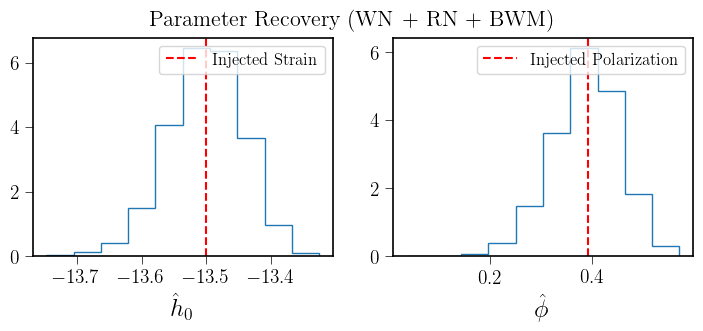

In [88]:
fig, axs = plt.subplots(1, 2)

# Strain recovery
strain_ax = axs[0]
strain_ax.hist(maxlike_strains, histtype='step', density=True)
strain_ax.set_xlabel(r"$\hat{h}_{0}$")
strain_ax.axvline(injected_strain, color='red', ls='--', label='Injected Strain')
strain_ax.legend()

pol_ax = axs[1]
pol_ax.hist(maxlike_pols, histtype='step', density=True)
pol_ax.set_xlabel(r"$\hat{\phi}$")
pol_ax.axvline(injected_pol, color='red', ls='--', label='Injected Polarization')
pol_ax.legend()

plt.suptitle("Parameter Recovery (WN + RN + BWM)", fontsize=16)
plt.show()

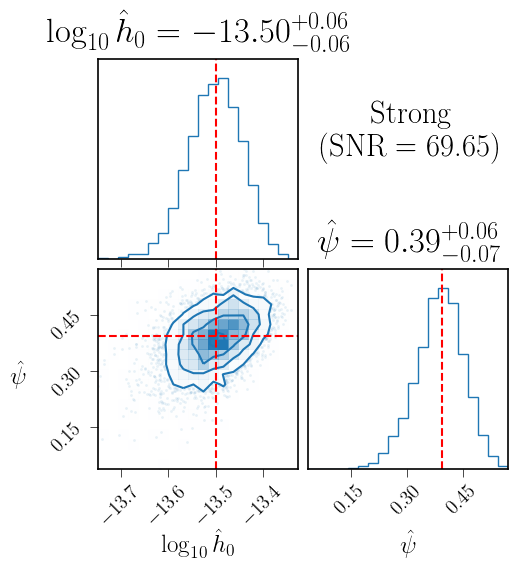

In [89]:
import corner
data = np.array([[maxlike_strains[_i], maxlike_pols[_i]] for _i in range(len(maxlike_strains))])
# print(data)

corner_fig = corner.corner(data, color='tab:blue', histtype='step',labels=[r'$\log_{10}\hat{h}_0$', r'$\hat{\psi}$'])

axs = corner_fig.get_axes()
axs[0].axvline(injected_strain, ls='--', color='red')
axs[2].axvline(injected_strain, ls='--', color='red')
axs[2].axhline(injected_pol, ls='--', color='red')
axs[2].set_ylabel(r'$\hat{\psi}$', rotation = 0, y = .40, x = -0.4)
axs[3].axvline(injected_pol, ls='--', color='red')

axs[0].set_title(r'$\log_{10}{\hat{h}_0} = -13.50^{+0.06}_{-0.06} $', fontsize=25, y=1.04)
axs[3].set_title(r'$\hat{\psi} = 0.39^{+0.06}_{-0.07} $', fontsize=25, y=1.04)

opt_snr = np.mean(maxlike_ncs)

# mysuptitle = plt.suptitle("Large Signal\n" +r"($\log_{10}{A_{\mathrm{RN}}} = $" +  "{:.02f})".format(np.log10(rn_amp))+ "\n"+ r"($\log_{10}{A_{\mathrm{bwm}}} = $" +  "{:.02f})".format(injected_strain), fontsize=18, y=1.15)
mysuptitle = plt.suptitle("Strong\n(SNR = {:.02f})".format(opt_snr), y = 0.85, x=0.75, fontsize=22)

plt.savefig('/home/nima/nanograv/bwm_fpfe/mles_recovery_strong.pdf', bbox_inches='tight', bbox_extra_artists=[mysuptitle])
# plt.suptitle("Maximum Likelihood Parameter Recovery", y = 1.04, ha= 'center', fontsize = 16, )
plt.show()

## Repeat with weaker injection
### Weak signal regime (log10h = -15)

In [16]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []
psr_locs = np.loadtxt(psrloc_path)


rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = np.pi/8
log10_h = -15
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [17]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    nc_estimate = 0    
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series + bwm_signals[ipsr]
        prefit_resids =  wn_series + rn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

        # prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        # prefit_resids = wn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc

        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        

        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     
        
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    M_pinv = np.linalg.pinv(M)
    
    bp = M_pinv[0,0] * Np + M_pinv[0,1] * Nc
    bc = M_pinv[1,0] * Np + M_pinv[1,1] * Nc
    

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe, nc_estimate, bp, bc

In [18]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fe_worker, args)

results = np.array(results)
# print(results)
estimated_ncs = results[:,1]
fe_bs = results[:, (0,2,3)]

outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_weakbwm_piby8_polarized_verbose.txt'
np.savetxt(outfile, fe_bs)

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_weakbwm_ncs_piby8_polarized.txt'
np.savetxt(nc_outfile, estimated_ncs)

Finished iteration 168 in 1.4s. Fe = 1.1088926985233694
Finished iteration 0 in 3.8s. Fe = 1.8782070579087624
Finished iteration 336 in 4.1s. Fe = 0.021082302915516823
Finished iteration 1 in 1.8s. Fe = 1.0426735117224217Finished iteration 924 in 5.6s. Fe = 1.9721078883634473

Finished iteration 84 in 5.8s. Fe = 3.405076684707459
Finished iteration 840 in 6.1s. Fe = 1.4502538433405394
Finished iteration 504 in 6.3s. Fe = 0.07207643346778207
Finished iteration 1092 in 6.4s. Fe = 0.9460050988904185
Finished iteration 252 in 6.6s. Fe = 3.1962631916682795
Finished iteration 420 in 6.7s. Fe = 2.0055747298751307
Finished iteration 1176 in 6.7s. Fe = 0.2793238202458531
Finished iteration 588 in 6.8s. Fe = 3.113355813588573
Finished iteration 672 in 6.9s. Fe = 7.071675849541343
Finished iteration 1008 in 7.1s. Fe = 0.3223617049316548
Finished iteration 756 in 7.1s. Fe = 2.222864005309962
Finished iteration 169 in 6.9s. Fe = 0.3924648389787088
Finished iteration 337 in 4.7s. Fe = 0.731724521423

Finished iteration 607 in 7.1s. Fe = 0.3788639382609063
Finished iteration 103 in 6.8s. Fe = 5.338271573090691
Finished iteration 1028 in 7.3s. Fe = 3.405260052870917
Finished iteration 21 in 4.0s. Fe = 0.8845514695981342
Finished iteration 1112 in 6.6s. Fe = 1.996581210301678
Finished iteration 776 in 2.8s. Fe = 0.6973845486786368Finished iteration 439 in 2.7s. Fe = 0.4580703317981488

Finished iteration 525 in 2.7s. Fe = 6.404569715961929Finished iteration 690 in 6.2s. Fe = 3.2949378750794143

Finished iteration 1194 in 6.9s. Fe = 3.149617709914877
Finished iteration 1029 in 3.0s. Fe = 0.15381749502241016
Finished iteration 860 in 6.8s. Fe = 1.185860804282818Finished iteration 943 in 6.9s. Fe = 3.1050521672432407

Finished iteration 187 in 6.8s. Fe = 0.17360948760418238
Finished iteration 1195 in 2.4s. Fe = 1.5575228966013457
Finished iteration 440 in 3.5s. Fe = 1.5091633156473467
Finished iteration 270 in 7.0s. Fe = 0.9708255915952502
Finished iteration 777 in 4.3s. Fe = 1.701364275

Finished iteration 122 in 4.4s. Fe = 2.5491742016320975
Finished iteration 710 in 6.7s. Fe = 0.7125239711148005
Finished iteration 963 in 5.2s. Fe = 2.8036112386312038
Finished iteration 627 in 5.8s. Fe = 1.32725249396645
Finished iteration 38 in 6.9s. Fe = 0.13331470469063536
Finished iteration 1213 in 6.5s. Fe = 0.5782527519025288
Finished iteration 1131 in 6.8s. Fe = 2.815409576281715
Finished iteration 288 in 6.8s. Fe = 1.2769498834151467
Finished iteration 459 in 6.1s. Fe = 1.9784102607651133
Finished iteration 878 in 6.1s. Fe = 5.955500290691695
Finished iteration 208 in 5.9s. Fe = 2.6457008207220625
Finished iteration 545 in 6.9s. Fe = 0.7772272823825654
Finished iteration 376 in 6.9s. Fe = 0.09603543137901188
Finished iteration 797 in 6.7s. Fe = 0.8898626065620633
Finished iteration 711 in 5.5s. Fe = 0.18171119488918838
Finished iteration 1049 in 7.0s. Fe = 2.4381236794303613
Finished iteration 1214 in 5.6s. Fe = 5.516116089452395
Finished iteration 39 in 5.8s. Fe = 0.199552345

Finished iteration 227 in 6.8s. Fe = 2.0480981915258125
Finished iteration 563 in 7.0s. Fe = 1.6365561529397818
Finished iteration 142 in 6.8s. Fe = 3.325317374905387
Finished iteration 1233 in 4.2s. Fe = 4.361111142013302
Finished iteration 308 in 5.9s. Fe = 0.2987004978359492
Finished iteration 1149 in 6.5s. Fe = 2.4478437213176383
Finished iteration 728 in 5.4s. Fe = 5.727507733096413
Finished iteration 479 in 6.8s. Fe = 1.3432289290063875
Finished iteration 647 in 6.4s. Fe = 4.374870662931668
Finished iteration 983 in 5.3s. Fe = 0.33102420571192354
Finished iteration 394 in 5.9s. Fe = 4.069169106718248
Finished iteration 818 in 6.3s. Fe = 1.374015763140051
Finished iteration 898 in 6.3s. Fe = 1.94708791353237
Finished iteration 1069 in 6.1s. Fe = 0.47317465238742584
Finished iteration 228 in 6.2s. Fe = 0.22173446511790285
Finished iteration 58 in 6.9s. Fe = 1.8562917943454917Finished iteration 564 in 6.6s. Fe = 3.3899571993730926

Finished iteration 1234 in 6.5s. Fe = 2.21089673085

Finished iteration 749 in 6.1s. Fe = 2.454318585764997
Finished iteration 414 in 1.8s. Fe = 0.3298429193323362Finished iteration 836 in 3.5s. Fe = 3.688746213792383

Finished iteration 1168 in 4.1s. Fe = 1.186809037782416Finished iteration 247 in 6.6s. Fe = 1.2454039186796177

Finished iteration 496 in 7.1s. Fe = 0.03058315956401616
Finished iteration 162 in 3.5s. Fe = 0.3353353578971595
Finished iteration 1002 in 5.6s. Fe = 1.6460476677998959Finished iteration 77 in 7.1s. Fe = 2.2846602612968456

Finished iteration 582 in 6.4s. Fe = 0.37220561192252993
Finished iteration 1253 in 3.9s. Fe = 0.08058599890498523
Finished iteration 750 in 3.8s. Fe = 8.528869585123763
Finished iteration 1088 in 7.0s. Fe = 3.9673129357378114
Finished iteration 329 in 6.4s. Fe = 5.1006461647062915
Finished iteration 78 in 2.7s. Fe = 0.23727153197587705
Finished iteration 415 in 5.1s. Fe = 2.2920100703249777
Finished iteration 837 in 5.3s. Fe = 1.7774167198626336
Finished iteration 667 in 6.9s. Fe = 1.7024981

Finished iteration 1860 in 6.6s. Fe = 0.42337669269093003
Finished iteration 1694 in 6.3s. Fe = 1.3882006621671137
Finished iteration 1358 in 6.6s. Fe = 1.0499842088413496Finished iteration 1442 in 5.3s. Fe = 1.0571703746460333

Finished iteration 2280 in 4.9s. Fe = 2.5371776003536413
Finished iteration 2028 in 6.8s. Fe = 0.5540955206583922
Finished iteration 1945 in 6.5s. Fe = 7.176017862625799
Finished iteration 1277 in 6.6s. Fe = 3.8870247736248227
Finished iteration 1611 in 6.3s. Fe = 2.3423136998318177
Finished iteration 2446 in 6.5s. Fe = 0.12279417735866105
Finished iteration 2196 in 6.3s. Fe = 0.7870581110928603
Finished iteration 1777 in 6.4s. Fe = 1.5493479514186026
Finished iteration 2365 in 6.5s. Fe = 4.206772038781076Finished iteration 1525 in 6.4s. Fe = 2.281465837906618

Finished iteration 2112 in 6.7s. Fe = 2.0380697290916547
Finished iteration 1861 in 6.2s. Fe = 0.18251101233477618
Finished iteration 1443 in 5.5s. Fe = 0.3746298202679443
Finished iteration 1359 in 5.7s

Finished iteration 2383 in 7.4s. Fe = 5.878980416992492
Finished iteration 2299 in 7.1s. Fe = 2.309411791289837
Finished iteration 1962 in 7.6s. Fe = 2.6184219855281126
Finished iteration 2215 in 7.5s. Fe = 1.8544026699977638
Finished iteration 1797 in 7.2s. Fe = 2.228065311896349
Finished iteration 1713 in 7.6s. Fe = 0.20230449757457772
Finished iteration 2046 in 7.6s. Fe = 0.3249016110116349
Finished iteration 1880 in 6.7s. Fe = 0.7142860208911909
Finished iteration 1378 in 7.2s. Fe = 1.2030399549385873
Finished iteration 1296 in 7.5s. Fe = 1.5510209246756115
Finished iteration 2133 in 7.4s. Fe = 1.1151841089655634
Finished iteration 1629 in 7.6s. Fe = 0.895404605012073
Finished iteration 2465 in 7.7s. Fe = 2.9552476549284594
Finished iteration 1462 in 6.5s. Fe = 4.19990584499899
Finished iteration 1545 in 7.5s. Fe = 0.010248477805234876
Finished iteration 2300 in 6.9s. Fe = 0.31410249940193047Finished iteration 1963 in 6.6s. Fe = 2.089816408582874

Finished iteration 2384 in 7.5s. F

Finished iteration 2151 in 7.7s. Fe = 2.588267551812315
Finished iteration 1815 in 5.1s. Fe = 2.0000409857164083
Finished iteration 1648 in 6.9s. Fe = 1.0206917999854532
Finished iteration 1733 in 7.7s. Fe = 1.1577955915749625
Finished iteration 1316 in 7.5s. Fe = 1.0671527535027092
Finished iteration 1981 in 7.8s. Fe = 1.8941666334931728
Finished iteration 2064 in 7.7s. Fe = 1.421742038738044
Finished iteration 1481 in 7.7s. Fe = 1.9419511920371793
Finished iteration 2483 in 7.7s. Fe = 1.217952269408143
Finished iteration 2320 in 7.9s. Fe = 0.7253338782592821
Finished iteration 2233 in 8.2s. Fe = 0.970430922518636
Finished iteration 1564 in 7.0s. Fe = 1.5290955892443066
Finished iteration 1899 in 7.6s. Fe = 1.1529885506397348
Finished iteration 1400 in 7.5s. Fe = 4.414068755931547
Finished iteration 2403 in 7.5s. Fe = 0.10400940146506892
Finished iteration 2152 in 7.7s. Fe = 0.20729131342572843
Finished iteration 1816 in 7.7s. Fe = 6.902412366512653
Finished iteration 1649 in 7.8s. Fe

Finished iteration 2339 in 4.8s. Fe = 0.1142024516263726
Finished iteration 2001 in 7.1s. Fe = 6.305278016146571
Finished iteration 1419 in 5.8s. Fe = 0.1958341740035248
Finished iteration 1916 in 7.5s. Fe = 0.040793545825993364
Finished iteration 2082 in 4.9s. Fe = 4.499142529867892
Finished iteration 2503 in 6.1s. Fe = 2.2992939841845015
Finished iteration 1499 in 7.7s. Fe = 1.9059393327907674
Finished iteration 1755 in 6.9s. Fe = 0.8078503832080886
Finished iteration 1336 in 6.0s. Fe = 0.42022672080509044
Finished iteration 2253 in 4.5s. Fe = 4.088270118172783
Finished iteration 2340 in 4.4s. Fe = 0.22961707524381658
Finished iteration 2421 in 8.2s. Fe = 0.8563460606778408
Finished iteration 1667 in 6.8s. Fe = 2.6974577531643344
Finished iteration 2083 in 4.4s. Fe = 3.891021045313373
Finished iteration 1583 in 6.1s. Fe = 1.5166785891264822
Finished iteration 1420 in 6.1s. Fe = 3.1062090522307892
Finished iteration 2170 in 8.2s. Fe = 4.28993240896111
Finished iteration 1835 in 8.6s. 

Finished iteration 3114 in 7.1s. Fe = 4.200982705542948
Finished iteration 3531 in 6.8s. Fe = 0.711214407465831
Finished iteration 3363 in 7.9s. Fe = 0.6423618889450989Finished iteration 2531 in 6.2s. Fe = 1.974208400519173

Finished iteration 2778 in 4.5s. Fe = 0.006545935220741986
Finished iteration 3197 in 7.4s. Fe = 0.9956043280779847
Finished iteration 2945 in 6.9s. Fe = 1.0196977314216762
Finished iteration 2614 in 5.3s. Fe = 0.18286088839607123
Finished iteration 3281 in 4.3s. Fe = 2.642840338527746
Finished iteration 2699 in 4.7s. Fe = 1.1550334149371198
Finished iteration 2863 in 6.8s. Fe = 0.5592389115671943
Finished iteration 3029 in 7.7s. Fe = 1.380438756345328
Finished iteration 2946 in 3.7s. Fe = 2.5917911353649123
Finished iteration 3448 in 7.7s. Fe = 3.142333302481231
Finished iteration 3616 in 7.6s. Fe = 1.1587405390792611
Finished iteration 2615 in 3.2s. Fe = 1.0082144337734749
Finished iteration 3698 in 7.4s. Fe = 3.217992809410331
Finished iteration 3115 in 6.5s. Fe

Finished iteration 2718 in 7.2s. Fe = 0.045040252745302184
Finished iteration 2799 in 6.1s. Fe = 5.358603805634512
Finished iteration 3216 in 5.5s. Fe = 2.708204144257512
Finished iteration 3300 in 7.4s. Fe = 4.6196298325110865
Finished iteration 2965 in 6.2s. Fe = 2.332279698853797
Finished iteration 3382 in 5.3s. Fe = 1.1094634432904176
Finished iteration 3635 in 7.7s. Fe = 0.7786922220135561
Finished iteration 2549 in 7.3s. Fe = 4.337649989658738
Finished iteration 2633 in 7.6s. Fe = 0.9917074104447965
Finished iteration 3550 in 6.4s. Fe = 4.176152109527869Finished iteration 3718 in 6.1s. Fe = 0.6128640830707031

Finished iteration 3133 in 7.2s. Fe = 3.2343044789399955
Finished iteration 2882 in 6.8s. Fe = 1.3470756347378445
Finished iteration 2719 in 6.8s. Fe = 0.6479436991892822
Finished iteration 3047 in 7.3s. Fe = 1.0278582030871877
Finished iteration 3383 in 4.3s. Fe = 1.0250662475514136
Finished iteration 3467 in 7.9s. Fe = 0.9572227299847504
Finished iteration 2800 in 7.4s. F

Finished iteration 2901 in 5.0s. Fe = 1.4392069300084678
Finished iteration 2568 in 7.2s. Fe = 2.943856290463657
Finished iteration 2652 in 7.8s. Fe = 1.5169274277846994
Finished iteration 2817 in 7.8s. Fe = 1.722092506526182
Finished iteration 3065 in 8.0s. Fe = 2.247044106682033
Finished iteration 3403 in 8.4s. Fe = 0.017336194315921604
Finished iteration 2985 in 8.0s. Fe = 1.3848571381808683
Finished iteration 3236 in 7.9s. Fe = 1.485415213813699
Finished iteration 3653 in 7.8s. Fe = 0.02138211493497854
Finished iteration 2902 in 3.5s. Fe = 3.9014583109419974
Finished iteration 2739 in 5.3s. Fe = 1.2446976471014612
Finished iteration 3570 in 7.8s. Fe = 4.871674573117734
Finished iteration 3737 in 7.9s. Fe = 4.983367370526202
Finished iteration 3151 in 7.6s. Fe = 0.8412668444508165
Finished iteration 3319 in 7.7s. Fe = 1.165856182237392
Finished iteration 3486 in 7.8s. Fe = 0.01348882837402997
Finished iteration 3404 in 5.3s. Fe = 2.123726616694669
Finished iteration 2569 in 7.6s. Fe

Finished iteration 3336 in 6.8s. Fe = 1.7580311354664078
Finished iteration 3422 in 7.0s. Fe = 0.331225357073106
Finished iteration 2759 in 7.1s. Fe = 0.45019657678299974
Finished iteration 3505 in 7.4s. Fe = 4.392763783059767
Finished iteration 3003 in 6.9s. Fe = 0.9710818256317139
Finished iteration 2836 in 7.6s. Fe = 1.8154297456589166
Finished iteration 2922 in 7.1s. Fe = 0.20007482145797997
Finished iteration 3170 in 7.2s. Fe = 0.3852834868339584Finished iteration 3255 in 7.0s. Fe = 2.448979957780427

Finished iteration 3589 in 6.9s. Fe = 0.4673064190159401
Finished iteration 2589 in 7.0s. Fe = 6.556572185899477
Finished iteration 2673 in 7.3s. Fe = 6.54684494413944
Finished iteration 3084 in 7.6s. Fe = 4.819557925334987
Finished iteration 3672 in 7.2s. Fe = 1.3644397336142133
Finished iteration 3755 in 7.1s. Fe = 0.8073431005660083
Finished iteration 3337 in 7.5s. Fe = 1.2344133182219033
Finished iteration 3423 in 7.2s. Fe = 0.5758679685093582
Finished iteration 2760 in 7.5s. Fe 

Finished iteration 4032 in 8.1s. Fe = 1.1684375165292318
Finished iteration 3274 in 7.3s. Fe = 2.1229936636145115
Finished iteration 3608 in 7.4s. Fe = 1.9456843081997217
Finished iteration 3189 in 7.6s. Fe = 1.0719588650712946
Finished iteration 3022 in 7.2s. Fe = 0.4013356972986428
Finished iteration 2855 in 7.8s. Fe = 0.8264074112879178
Finished iteration 3103 in 7.2s. Fe = 0.6136275426646557
Finished iteration 3952 in 7.5s. Fe = 0.46065291938792496
Finished iteration 3774 in 7.3s. Fe = 3.6302458949233762
Finished iteration 3356 in 7.4s. Fe = 5.6862777156679485
Finished iteration 3868 in 7.6s. Fe = 0.5324755002401648
Finished iteration 3442 in 7.2s. Fe = 1.9083918210835538
Finished iteration 3691 in 7.3s. Fe = 5.2268048256995145
Finished iteration 3525 in 7.3s. Fe = 3.129567858167199
Finished iteration 3787 in 7.6s. Fe = 3.4619055253343616
Finished iteration 4033 in 8.0s. Fe = 0.11902767041449101
Finished iteration 3275 in 7.5s. Fe = 1.4339318077801795
Finished iteration 3609 in 7.2

Finished iteration 4301 in 7.3s. Fe = 2.4438005768082034
Finished iteration 4217 in 7.4s. Fe = 3.059667505788112
Finished iteration 4969 in 7.2s. Fe = 0.3398845850124633
Finished iteration 4802 in 7.6s. Fe = 3.9407689347646704
Finished iteration 4552 in 7.4s. Fe = 9.25315709730706
Finished iteration 4385 in 7.2s. Fe = 0.5901379228038867
Finished iteration 4468 in 7.4s. Fe = 4.301587206728452
Finished iteration 4719 in 7.1s. Fe = 0.4269822716848381
Finished iteration 4886 in 7.5s. Fe = 10.282328918581914
Finished iteration 4051 in 7.3s. Fe = 0.8829008683523547
Finished iteration 4134 in 7.6s. Fe = 0.4782865939017652
Finished iteration 3806 in 7.4s. Fe = 0.9771090869948945
Finished iteration 3971 in 7.6s. Fe = 1.7391653786215644
Finished iteration 4636 in 7.4s. Fe = 3.14229180231372
Finished iteration 3887 in 7.4s. Fe = 4.592367178036863
Finished iteration 4302 in 7.4s. Fe = 1.2733880654593512
Finished iteration 4218 in 7.3s. Fe = 0.8705743811554552
Finished iteration 4970 in 7.4s. Fe = 

Finished iteration 4070 in 7.4s. Fe = 0.38153550526496277
Finished iteration 3989 in 7.6s. Fe = 0.5852466412229977
Finished iteration 4153 in 7.5s. Fe = 1.9062962029074781
Finished iteration 4821 in 7.6s. Fe = 0.3499611100732333
Finished iteration 4738 in 6.5s. Fe = 0.29748522225406304Finished iteration 4989 in 7.6s. Fe = 4.05776756813445

Finished iteration 4571 in 6.9s. Fe = 0.06235333641699229
Finished iteration 4487 in 7.2s. Fe = 0.03499962845452961
Finished iteration 4905 in 6.9s. Fe = 8.061783636427647
Finished iteration 3825 in 7.3s. Fe = 2.3880891952577543
Finished iteration 4405 in 7.5s. Fe = 0.5282944317119844
Finished iteration 4655 in 7.2s. Fe = 0.015008673238975702
Finished iteration 3906 in 7.3s. Fe = 1.138465042448691
Finished iteration 4321 in 7.4s. Fe = 5.493677113758068
Finished iteration 4237 in 7.2s. Fe = 1.7025963912998352
Finished iteration 4071 in 7.3s. Fe = 6.480141714039273
Finished iteration 3990 in 7.5s. Fe = 1.401913077511099
Finished iteration 4154 in 7.3s.

Finished iteration 4758 in 7.0s. Fe = 0.0014877435799234508
Finished iteration 4674 in 7.0s. Fe = 3.0537077627727127
Finished iteration 4256 in 6.9s. Fe = 0.9419068728898576
Finished iteration 4340 in 6.4s. Fe = 7.6418601256912355
Finished iteration 4173 in 7.1s. Fe = 5.269553759006859
Finished iteration 4009 in 7.0s. Fe = 4.000322554400034
Finished iteration 3925 in 6.7s. Fe = 3.0147093680690693
Finished iteration 4841 in 6.7s. Fe = 5.951320489617603
Finished iteration 4091 in 6.9s. Fe = 0.301603257297965
Finished iteration 4425 in 6.6s. Fe = 1.237778436568884
Finished iteration 4591 in 6.7s. Fe = 1.3815828772975811
Finished iteration 3845 in 6.8s. Fe = 2.8623927966766742
Finished iteration 4925 in 6.8s. Fe = 0.03531953629656057
Finished iteration 4507 in 6.7s. Fe = 0.10204495448168889
Finished iteration 4759 in 6.7s. Fe = 2.3274998986029196
Finished iteration 4257 in 6.5s. Fe = 1.7106521670561503
Finished iteration 4675 in 7.1s. Fe = 2.4219577333454145
Finished iteration 4341 in 6.7s

Finished iteration 4445 in 6.5s. Fe = 0.5028863008476179
Finished iteration 4945 in 6.1s. Fe = 0.5322647850083362Finished iteration 4779 in 6.5s. Fe = 1.8977361576363776

Finished iteration 4527 in 6.4s. Fe = 1.5082284883724333
Finished iteration 4029 in 5.6s. Fe = 3.511183200243326
Finished iteration 3945 in 6.2s. Fe = 0.8155860481134237
Finished iteration 4862 in 6.4s. Fe = 0.7122019074834117
Finished iteration 4278 in 5.6s. Fe = 0.6665512321951016
Finished iteration 4362 in 5.6s. Fe = 0.28033010597544744
Finished iteration 4194 in 5.8s. Fe = 1.0726524273811675
Finished iteration 4695 in 6.5s. Fe = 1.515849975372269
Finished iteration 4112 in 5.9s. Fe = 0.9358065084451939
Finished iteration 4611 in 5.8s. Fe = 10.244030940073554
Finished iteration 4446 in 6.6s. Fe = 2.3202044322772513
Finished iteration 4030 in 5.6s. Fe = 1.101309765338955
Finished iteration 4946 in 6.2s. Fe = 2.474906791778626
Finished iteration 4528 in 6.5s. Fe = 1.1852674606945632
Finished iteration 4780 in 6.8s. F

In [9]:
maxlike_ncs = np.loadtxt("/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_weakbwm_ncs_piby8_polarized.txt")
maxlike_output = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_weakbwm_piby8_polarized_verbose.txt')

In [10]:
bps = maxlike_output[:,1]
bcs = maxlike_output[:,2]

injected_strain = -15
injected_pol = np.pi/8

maxlike_strains = np.log10(np.array([np.sqrt(bps[_i]**2 + bcs[_i]**2) for _i in range(len(bps))]))
maxlike_pols = np.array([0.5*np.arctan(bcs[_i]/bps[_i]) for _i in range(len(bps))])


#compute 1-sigma errors
median_strain = np.median(sorted(maxlike_strains))
strain_idx_gap = int(len(maxlike_strains) * .341)
median_idx = int(len(maxlike_strains)/2)
upper_strain = sorted(maxlike_strains)[median_idx + strain_idx_gap]
lower_strain = sorted(maxlike_strains)[median_idx - strain_idx_gap]

median_pol = np.median(sorted(maxlike_pols))
pol_idx_gap = int(len(maxlike_pols) * .341)
median_idx = int(len(maxlike_pols)/2)
upper_pol = sorted(maxlike_pols)[median_idx + pol_idx_gap]
lower_pol = sorted(maxlike_pols)[median_idx - pol_idx_gap]

print(median_strain, median_strain - lower_strain, upper_strain-median_strain)
print(median_pol, median_pol - lower_pol, upper_pol-median_pol)


-14.325049172776277 0.3169042610175996 0.22956649316062716
0.044775325471365326 0.6588722667289663 0.5735705005873335


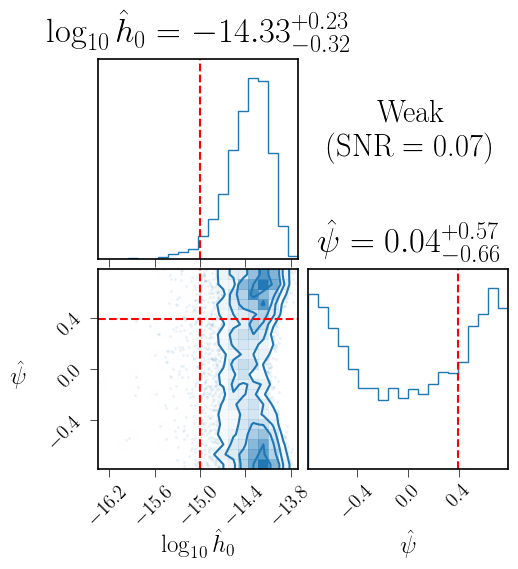

In [11]:
import corner
data = np.array([[maxlike_strains[_i], maxlike_pols[_i]] for _i in range(len(maxlike_strains))])
# print(data)

corner_fig = corner.corner(data, color='tab:blue', histtype='step',labels=[r'$\log_{10}\hat{h}_0$', r'$\hat{\psi}$'])

axs = corner_fig.get_axes()
axs[0].axvline(injected_strain, ls='--', color='red')
axs[2].axvline(injected_strain, ls='--', color='red')
axs[2].axhline(injected_pol, ls='--', color='red')
axs[2].set_ylabel(r'$\hat{\psi}$', rotation = 0, y = .40, x = -0.4)
axs[3].axvline(injected_pol, ls='--', color='red')

axs[0].set_title(r'$\log_{10}{\hat{h}_0} = -14.33^{+0.23}_{-0.32} $', fontsize=25, y=1.04)
axs[3].set_title(r'$\hat{\psi} = 0.04^{+0.57}_{-0.66} $', fontsize=25, y=1.04)

opt_snr = np.mean(maxlike_ncs)
mysuptitle = plt.suptitle("Weak\n(SNR = {:.02f})".format(opt_snr), y = 0.85, x=0.75, fontsize=22)
# mysuptitle = plt.suptitle("Weak Signal\n" +r"($\log_{10}{A_{\mathrm{RN}}} = $" +  "{:.02f})".format(np.log10(rn_amp))+ "\n"+ r"($\log_{10}{A_{\mathrm{bwm}}} = $" +  "{:.02f})".format(injected_strain), fontsize=18, y=1.15)


plt.savefig('/home/nima/nanograv/bwm_fpfe/mles_recovery_weak.pdf', bbox_inches='tight', bbox_extra_artists=[mysuptitle])
# plt.suptitle("Maximum Likelihood Parameter Recovery", y = 1.04, ha= 'center', fontsize = 16, )
plt.show()

## Weak-Intermediate Signal

In [12]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []
psr_locs = np.loadtxt(psrloc_path)


rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = np.pi/8
log10_h = np.log10(3e-15)
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [23]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    nc_estimate = 0    
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series + bwm_signals[ipsr]
        prefit_resids =  wn_series + rn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

        # prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        # prefit_resids = wn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc

        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        

        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     
        
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    M_pinv = np.linalg.pinv(M)
    
    bp = M_pinv[0,0] * Np + M_pinv[0,1] * Nc
    bc = M_pinv[1,0] * Np + M_pinv[1,1] * Nc
    

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe, nc_estimate, bp, bc

In [24]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fe_worker, args)

results = np.array(results)
# print(results)
estimated_ncs = results[:,1]
fe_bs = results[:, (0,2,3)]

outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_weakinterbwm_piby8_polarized_verbose.txt'
np.savetxt(outfile, fe_bs)

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_weakinterbwm_ncs_piby8_polarized.txt'
np.savetxt(nc_outfile, estimated_ncs)

Finished iteration 840 in 5.9s. Fe = 0.6599893477854737Finished iteration 420 in 5.9s. Fe = 1.7281657377362998

Finished iteration 168 in 6.5s. Fe = 1.330214075276416Finished iteration 336 in 6.5s. Fe = 0.34407505652936277Finished iteration 0 in 6.5s. Fe = 0.7125780889376483

Finished iteration 1008 in 6.5s. Fe = 0.33255568536455093

Finished iteration 84 in 6.6s. Fe = 3.7489958403930252
Finished iteration 1176 in 6.6s. Fe = 0.030913542625072128Finished iteration 672 in 6.6s. Fe = 9.80840334446478
Finished iteration 588 in 6.7s. Fe = 2.9100247755996977
Finished iteration 924 in 6.6s. Fe = 3.4253835551622176

Finished iteration 756 in 6.7s. Fe = 4.02276473859457
Finished iteration 504 in 6.8s. Fe = 0.40574745084012614
Finished iteration 1092 in 6.9s. Fe = 2.2461147882944728Finished iteration 252 in 6.9s. Fe = 4.932528116914343

Finished iteration 421 in 6.5s. Fe = 0.6722739483937351
Finished iteration 841 in 6.7s. Fe = 2.493442193130499
Finished iteration 169 in 6.4s. Fe = 0.77827735187

Finished iteration 691 in 6.8s. Fe = 1.081060162849947
Finished iteration 523 in 6.5s. Fe = 3.261961287323502
Finished iteration 607 in 6.9s. Fe = 0.0953998340405478
Finished iteration 775 in 6.9s. Fe = 1.5915719317807737
Finished iteration 1027 in 6.6s. Fe = 0.9236321861765407
Finished iteration 103 in 6.6s. Fe = 7.968263527977287
Finished iteration 1111 in 6.9s. Fe = 2.3922708235461334
Finished iteration 272 in 6.4s. Fe = 0.5505861253654143
Finished iteration 440 in 6.8s. Fe = 1.2460943958837487
Finished iteration 188 in 5.2s. Fe = 1.9611746865575785
Finished iteration 1196 in 6.6s. Fe = 0.9798766924551141
Finished iteration 944 in 5.5s. Fe = 4.800131774143511Finished iteration 356 in 5.3s. Fe = 0.1354300875598069

Finished iteration 860 in 6.5s. Fe = 2.5556694453349564
Finished iteration 20 in 5.6s. Fe = 0.08084133921588556
Finished iteration 608 in 5.9s. Fe = 1.204088759657704
Finished iteration 524 in 6.6s. Fe = 0.7044161280578813
Finished iteration 692 in 6.8s. Fe = 2.23981480597

Finished iteration 963 in 6.4s. Fe = 2.7760482835543443
Finished iteration 39 in 6.2s. Fe = 0.5562779754501643
Finished iteration 1130 in 6.5s. Fe = 0.6570901245983151
Finished iteration 1046 in 6.8s. Fe = 5.292744250537561
Finished iteration 795 in 6.1s. Fe = 1.340518508186895
Finished iteration 207 in 6.2s. Fe = 8.184978314399475
Finished iteration 375 in 6.4s. Fe = 0.017051673706379365Finished iteration 1215 in 6.5s. Fe = 1.901934024489541

Finished iteration 711 in 6.5s. Fe = 0.7571868467490538
Finished iteration 122 in 6.5s. Fe = 3.817382700856677
Finished iteration 543 in 6.6s. Fe = 0.06977538137699839
Finished iteration 880 in 6.4s. Fe = 0.8412224620396148
Finished iteration 627 in 6.8s. Fe = 2.1171354750650186
Finished iteration 292 in 6.8s. Fe = 5.115011353997478
Finished iteration 460 in 6.9s. Fe = 2.653969225299903
Finished iteration 40 in 6.2s. Fe = 3.5983012574234445
Finished iteration 964 in 6.6s. Fe = 5.1195282769083
Finished iteration 1131 in 6.7s. Fe = 4.03951339362762

Finished iteration 394 in 6.5s. Fe = 5.683518843322841
Finished iteration 562 in 6.4s. Fe = 1.8006527579534044
Finished iteration 814 in 7.1s. Fe = 1.3764605209106027
Finished iteration 983 in 6.3s. Fe = 0.6417255317588527
Finished iteration 899 in 6.8s. Fe = 2.2967858406286883
Finished iteration 227 in 6.9s. Fe = 2.015261392554904
Finished iteration 141 in 6.2s. Fe = 2.101045275117976
Finished iteration 1235 in 6.6s. Fe = 3.478705508309265
Finished iteration 59 in 7.2s. Fe = 9.240427437146785
Finished iteration 731 in 6.6s. Fe = 1.1146632228440625
Finished iteration 479 in 7.0s. Fe = 1.673876380629623
Finished iteration 311 in 6.3s. Fe = 1.51603146375535
Finished iteration 1066 in 6.7s. Fe = 2.0309508872702735
Finished iteration 1150 in 6.9s. Fe = 1.0593382603527963
Finished iteration 563 in 6.2s. Fe = 0.6466479596642268
Finished iteration 395 in 6.4s. Fe = 0.7156329672489827
Finished iteration 815 in 6.4s. Fe = 3.841311163382116Finished iteration 646 in 6.6s. Fe = 0.14776021669643055

Finished iteration 160 in 6.4s. Fe = 3.2828595240044782
Finished iteration 1254 in 6.9s. Fe = 2.3165472945025
Finished iteration 582 in 6.5s. Fe = 0.8300125202192636
Finished iteration 498 in 6.5s. Fe = 1.2367138049572672
Finished iteration 78 in 6.7s. Fe = 0.9747806764130382
Finished iteration 1002 in 6.7s. Fe = 3.240036092803832
Finished iteration 1085 in 6.5s. Fe = 0.5308493163617964
Finished iteration 751 in 6.0s. Fe = 0.8855609945327857
Finished iteration 246 in 6.7s. Fe = 9.375494678049808
Finished iteration 665 in 6.7s. Fe = 0.41279935175927607
Finished iteration 415 in 6.5s. Fe = 4.112114786615203
Finished iteration 919 in 6.1s. Fe = 4.020747743491471
Finished iteration 1169 in 6.7s. Fe = 7.060582778822821
Finished iteration 834 in 6.6s. Fe = 0.23178029326116192
Finished iteration 331 in 6.8s. Fe = 0.5240520965136797
Finished iteration 161 in 6.6s. Fe = 1.1301471277039403
Finished iteration 1255 in 6.6s. Fe = 5.6178874263102765Finished iteration 583 in 6.6s. Fe = 4.265931890183

Finished iteration 1609 in 6.4s. Fe = 1.251522279119114
Finished iteration 1693 in 6.6s. Fe = 2.574353769235124
Finished iteration 1945 in 6.5s. Fe = 8.151265754337329
Finished iteration 2113 in 6.1s. Fe = 2.847115985157293
Finished iteration 2280 in 6.2s. Fe = 1.3144911083130073
Finished iteration 1526 in 6.0s. Fe = 1.190453732030788
Finished iteration 1275 in 6.7s. Fe = 3.329659386455314
Finished iteration 2364 in 6.5s. Fe = 0.7110514447253578
Finished iteration 1861 in 6.8s. Fe = 0.8125493097290502
Finished iteration 2029 in 6.3s. Fe = 1.2991283180527011
Finished iteration 1442 in 6.6s. Fe = 2.308787718377772
Finished iteration 1777 in 7.0s. Fe = 0.7277793658040796
Finished iteration 2197 in 6.7s. Fe = 0.010825338269849473
Finished iteration 1946 in 5.2s. Fe = 0.11607590974552864
Finished iteration 1610 in 6.4s. Fe = 4.5605622731712225
Finished iteration 2448 in 7.1s. Fe = 0.29539684504261865
Finished iteration 1359 in 6.7s. Fe = 0.4884486110308872
Finished iteration 2281 in 5.3s. F

Finished iteration 1293 in 7.2s. Fe = 0.04918214075472373Finished iteration 2132 in 6.5s. Fe = 1.1389944826479288

Finished iteration 2465 in 7.0s. Fe = 2.9928986745139357
Finished iteration 2383 in 6.5s. Fe = 7.407268306307469
Finished iteration 2048 in 6.8s. Fe = 1.7521484994810181
Finished iteration 1461 in 6.6s. Fe = 2.8748528726746834
Finished iteration 1965 in 6.8s. Fe = 0.5463727754985703
Finished iteration 1880 in 6.7s. Fe = 1.5962885186318796
Finished iteration 1796 in 6.6s. Fe = 1.2224471806626591
Finished iteration 2300 in 6.9s. Fe = 0.5486237155516046
Finished iteration 1378 in 6.6s. Fe = 1.1002931271566565
Finished iteration 1629 in 6.6s. Fe = 2.142765366711651
Finished iteration 1546 in 6.6s. Fe = 1.6264521676501622
Finished iteration 1713 in 6.7s. Fe = 0.777225287780744
Finished iteration 2216 in 7.0s. Fe = 4.142430024261333Finished iteration 2133 in 6.7s. Fe = 2.4918363175194713Finished iteration 1294 in 6.7s. Fe = 4.582256423577823


Finished iteration 2466 in 6.7s. Fe

Finished iteration 2234 in 6.3s. Fe = 5.345192755382981
Finished iteration 1899 in 6.4s. Fe = 2.4783238374229466
Finished iteration 1984 in 6.2s. Fe = 1.747613987168666
Finished iteration 1815 in 6.7s. Fe = 1.8127635786853076
Finished iteration 2319 in 6.4s. Fe = 1.53707679292451
Finished iteration 1732 in 6.3s. Fe = 3.86444355975269
Finished iteration 1480 in 6.7s. Fe = 3.1140608559329275Finished iteration 1648 in 6.7s. Fe = 2.098363107923567

Finished iteration 1313 in 6.4s. Fe = 1.6179436674539047
Finished iteration 2067 in 6.3s. Fe = 0.06409035535491614
Finished iteration 2402 in 6.1s. Fe = 1.0180829395924091
Finished iteration 1397 in 6.9s. Fe = 3.8515399512687534
Finished iteration 1565 in 6.6s. Fe = 0.18193025607078855
Finished iteration 2152 in 6.5s. Fe = 0.005269105889548975
Finished iteration 2486 in 6.7s. Fe = 0.02387864718516274
Finished iteration 2235 in 6.4s. Fe = 1.2673526127946049
Finished iteration 1900 in 6.5s. Fe = 2.9075710370331724
Finished iteration 1985 in 6.4s. 

Finished iteration 1499 in 6.0s. Fe = 3.1904756777732275
Finished iteration 1751 in 5.9s. Fe = 0.39497799336264205
Finished iteration 2086 in 6.8s. Fe = 2.197624308952688
Finished iteration 1919 in 6.4s. Fe = 3.74480061513728
Finished iteration 2253 in 6.6s. Fe = 3.662465745783491
Finished iteration 2171 in 6.2s. Fe = 1.2560459439020153
Finished iteration 1584 in 6.5s. Fe = 1.3744092049876302
Finished iteration 1332 in 6.7s. Fe = 1.1576422431083517
Finished iteration 2004 in 6.2s. Fe = 2.585604146101118
Finished iteration 1834 in 6.7s. Fe = 1.7137541925819122
Finished iteration 1667 in 6.8s. Fe = 2.7934531144504833
Finished iteration 2421 in 6.6s. Fe = 1.6039054240790294
Finished iteration 2339 in 6.2s. Fe = 0.7493455853667581
Finished iteration 2505 in 6.9s. Fe = 2.052058015247001
Finished iteration 1500 in 6.1s. Fe = 2.013453776761252
Finished iteration 1416 in 7.1s. Fe = 0.8447536414577373
Finished iteration 1752 in 6.2s. Fe = 0.8701496298557823
Finished iteration 2087 in 6.4s. Fe =

Finished iteration 3197 in 6.5s. Fe = 0.382785710132617
Finished iteration 3114 in 6.4s. Fe = 5.739247089740183
Finished iteration 3449 in 6.5s. Fe = 2.296192636838973
Finished iteration 3030 in 6.4s. Fe = 2.7782508188740693
Finished iteration 3532 in 6.3s. Fe = 2.0477281760210517
Finished iteration 2695 in 6.6s. Fe = 0.05870061078498788
Finished iteration 2946 in 6.4s. Fe = 3.532299854168261
Finished iteration 2611 in 6.8s. Fe = 1.8700674244815914
Finished iteration 3282 in 6.2s. Fe = 0.12092445293257613
Finished iteration 3616 in 6.2s. Fe = 2.493806838099567
Finished iteration 2863 in 6.8s. Fe = 0.2746392323000701
Finished iteration 3700 in 6.2s. Fe = 7.664440086507502
Finished iteration 3366 in 6.8s. Fe = 3.3776014900225637
Finished iteration 2528 in 6.3s. Fe = 0.7665541457004709
Finished iteration 3198 in 6.2s. Fe = 1.4278146025133265
Finished iteration 2780 in 6.7s. Fe = 0.8586447083359794
Finished iteration 3115 in 6.4s. Fe = 0.0057995642338465134
Finished iteration 3450 in 6.6s.

Finished iteration 3384 in 7.0s. Fe = 5.821853864326279
Finished iteration 2965 in 6.0s. Fe = 2.3695737777108357
Finished iteration 3468 in 6.2s. Fe = 1.3658946736706141
Finished iteration 3635 in 6.6s. Fe = 0.15671683570292644
Finished iteration 3216 in 6.5s. Fe = 3.7017436873603167
Finished iteration 2714 in 6.6s. Fe = 0.9472799755631388
Finished iteration 2630 in 6.3s. Fe = 4.136352470855424
Finished iteration 3133 in 6.4s. Fe = 5.3204606383345245
Finished iteration 3719 in 6.7s. Fe = 1.0871504183540657
Finished iteration 2883 in 6.6s. Fe = 9.207428962774788
Finished iteration 3552 in 6.3s. Fe = 2.442778785774726
Finished iteration 3049 in 6.6s. Fe = 0.5452887834203285
Finished iteration 2801 in 6.4s. Fe = 4.590976369480848
Finished iteration 2547 in 6.7s. Fe = 1.025038107773109
Finished iteration 3301 in 6.5s. Fe = 7.733151092231726
Finished iteration 3385 in 6.6s. Fe = 0.6583783782704555
Finished iteration 2966 in 6.4s. Fe = 0.3003481706995788
Finished iteration 3636 in 6.4s. Fe =

Finished iteration 3404 in 6.2s. Fe = 2.791592049110977
Finished iteration 2733 in 6.8s. Fe = 5.337961133647305
Finished iteration 2901 in 6.6s. Fe = 0.6172038722228271
Finished iteration 3235 in 6.7s. Fe = 5.444545097359444
Finished iteration 2985 in 6.7s. Fe = 1.1866499138790598
Finished iteration 2566 in 6.4s. Fe = 0.12776787430255318
Finished iteration 3487 in 6.3s. Fe = 4.082968946317892
Finished iteration 3654 in 6.6s. Fe = 0.8622039685032409
Finished iteration 2649 in 7.1s. Fe = 10.368459468617939
Finished iteration 3068 in 6.8s. Fe = 0.913449024102185
Finished iteration 3738 in 6.4s. Fe = 0.7365987235831246
Finished iteration 3571 in 6.6s. Fe = 3.9679520295599233
Finished iteration 2820 in 6.8s. Fe = 1.2999347099707546
Finished iteration 3153 in 6.2s. Fe = 2.9934108818290968
Finished iteration 3405 in 6.1s. Fe = 6.637753804157519
Finished iteration 3320 in 6.6s. Fe = 2.5959156201003855
Finished iteration 2734 in 6.4s. Fe = 9.891431968303436
Finished iteration 2902 in 6.6s. Fe =

Finished iteration 3004 in 6.4s. Fe = 1.0843672109287814
Finished iteration 3087 in 6.2s. Fe = 4.4996426232181745
Finished iteration 3254 in 6.5s. Fe = 1.6719916902243313
Finished iteration 2585 in 6.7s. Fe = 7.55183030866851Finished iteration 3338 in 6.9s. Fe = 0.8292839180635363

Finished iteration 3673 in 6.8s. Fe = 2.4725577431363033
Finished iteration 2753 in 6.3s. Fe = 0.3385066474705273
Finished iteration 3424 in 6.8s. Fe = 1.5578117352654008
Finished iteration 3757 in 6.7s. Fe = 8.101061777225011
Finished iteration 2839 in 6.4s. Fe = 3.9856925388319984
Finished iteration 3172 in 6.9s. Fe = 2.6967228335878937
Finished iteration 3507 in 6.7s. Fe = 0.0709771241706276
Finished iteration 3590 in 7.0s. Fe = 2.1189372082281825
Finished iteration 2668 in 6.8s. Fe = 0.8191882066182965
Finished iteration 2921 in 6.7s. Fe = 2.0182998877891394
Finished iteration 3088 in 5.9s. Fe = 0.7696056748375084
Finished iteration 3005 in 6.7s. Fe = 0.8653976128233467
Finished iteration 3255 in 6.7s. F

Finished iteration 3692 in 6.3s. Fe = 1.288273540404608
Finished iteration 3357 in 6.5s. Fe = 0.4748616319260997
Finished iteration 3864 in 6.6s. Fe = 3.2444070695926417
Finished iteration 3106 in 6.6s. Fe = 4.130981873807033
Finished iteration 3776 in 6.8s. Fe = 2.215848631871583
Finished iteration 3526 in 6.6s. Fe = 0.5880514983372466
Finished iteration 3609 in 5.4s. Fe = 0.1688796199067683
Finished iteration 3782 in 6.9s. Fe = 11.856757159605412
Finished iteration 3948 in 6.9s. Fe = 2.0398610014609213
Finished iteration 4032 in 6.8s. Fe = 1.2979847130034041
Finished iteration 3191 in 5.6s. Fe = 0.47061765636758834
Finished iteration 3274 in 5.4s. Fe = 1.9581251683857461
Finished iteration 4116 in 6.0s. Fe = 0.4227254175141662
Finished iteration 2687 in 6.7s. Fe = 2.323696040273078
Finished iteration 4200 in 5.9s. Fe = 2.028297730240757
Finished iteration 3693 in 6.5s. Fe = 3.8770996973332705
Finished iteration 3358 in 6.6s. Fe = 1.1840900720541903
Finished iteration 3865 in 6.7s. Fe

Finished iteration 4050 in 6.8s. Fe = 3.691698601492811
Finished iteration 3967 in 6.5s. Fe = 3.541125863390966
Finished iteration 4720 in 6.8s. Fe = 0.1514359034505189
Finished iteration 4804 in 6.6s. Fe = 0.5294370741139208
Finished iteration 3883 in 6.4s. Fe = 0.14135706795596364
Finished iteration 4302 in 6.6s. Fe = 2.6464892855339275
Finished iteration 3802 in 6.2s. Fe = 1.8093788563548037
Finished iteration 4637 in 6.6s. Fe = 2.5588381662410806
Finished iteration 4386 in 6.8s. Fe = 1.313089806063621
Finished iteration 4554 in 6.2s. Fe = 3.3417795852959857
Finished iteration 4135 in 6.9s. Fe = 1.3942839872664614
Finished iteration 4887 in 7.4s. Fe = 3.416295684632211
Finished iteration 4470 in 6.5s. Fe = 2.5906009327826554
Finished iteration 4219 in 6.7s. Fe = 1.0743908731327114
Finished iteration 4972 in 6.4s. Fe = 0.48177775673337486
Finished iteration 3968 in 6.4s. Fe = 0.22239659811860918
Finished iteration 4051 in 6.7s. Fe = 2.013816798630443
Finished iteration 4805 in 6.2s. 

Finished iteration 4405 in 6.6s. Fe = 1.3599394183173776Finished iteration 4154 in 6.6s. Fe = 1.7789858014662854

Finished iteration 4823 in 6.7s. Fe = 0.6945999997304002
Finished iteration 4573 in 6.6s. Fe = 3.583495481612461
Finished iteration 3822 in 6.7s. Fe = 2.2412199021064736
Finished iteration 4905 in 6.8s. Fe = 11.325817727029936
Finished iteration 4739 in 6.5s. Fe = 4.368348398563163
Finished iteration 4991 in 6.5s. Fe = 2.3818254912675583
Finished iteration 3902 in 6.6s. Fe = 0.42809213699214244
Finished iteration 4237 in 7.0s. Fe = 1.9058961097199627
Finished iteration 4656 in 6.6s. Fe = 0.7387148468570385
Finished iteration 4070 in 6.4s. Fe = 0.4870225302552869
Finished iteration 4489 in 6.8s. Fe = 0.6687339075113189
Finished iteration 3987 in 6.1s. Fe = 2.089054468804206
Finished iteration 4322 in 6.5s. Fe = 5.7861538926124565
Finished iteration 4406 in 6.8s. Fe = 0.5066082898000913
Finished iteration 4155 in 6.9s. Fe = 1.0300479186178504
Finished iteration 4824 in 6.8s. 

Finished iteration 3842 in 6.0s. Fe = 1.5380449056693941
Finished iteration 4843 in 6.1s. Fe = 0.2969494325662086
Finished iteration 4425 in 6.4s. Fe = 2.557059701238375Finished iteration 4006 in 6.3s. Fe = 1.0423109719686152

Finished iteration 4924 in 6.5s. Fe = 2.527896440714188
Finished iteration 4090 in 6.1s. Fe = 0.5881957840215245
Finished iteration 4257 in 5.8s. Fe = 3.3636933463849195
Finished iteration 4174 in 6.2s. Fe = 0.3303540949978575
Finished iteration 4759 in 6.3s. Fe = 0.9957215063974223
Finished iteration 4593 in 6.7s. Fe = 3.1696787820214523
Finished iteration 4342 in 5.9s. Fe = 4.180554919555698
Finished iteration 4509 in 5.9s. Fe = 1.6750802606714286
Finished iteration 4677 in 5.9s. Fe = 0.19629445335968843
Finished iteration 4844 in 5.8s. Fe = 2.689303221741331
Finished iteration 3922 in 6.3s. Fe = 10.35799735616733
Finished iteration 3843 in 5.9s. Fe = 0.9557987354350448
Finished iteration 4426 in 5.8s. Fe = 5.147297365616141
Finished iteration 4007 in 5.8s. Fe 

Finished iteration 3863 in 6.0s. Fe = 0.8063059029198754Finished iteration 4529 in 5.9s. Fe = 2.4691394189679636

Finished iteration 4194 in 6.4s. Fe = 1.7010775764129205
Finished iteration 4613 in 5.9s. Fe = 0.21101713416525777
Finished iteration 4362 in 6.2s. Fe = 1.0422888918905104
Finished iteration 3942 in 6.3s. Fe = 1.8965443261050663
Finished iteration 4864 in 5.6s. Fe = 5.874987194663052
Finished iteration 4446 in 6.2s. Fe = 3.780087976096777
Finished iteration 4278 in 5.6s. Fe = 1.6035889221255333
Finished iteration 4779 in 5.9s. Fe = 2.692265177903049
Finished iteration 4945 in 5.7s. Fe = 1.5659731610032783
Finished iteration 4027 in 5.8s. Fe = 4.844546797617629
Finished iteration 4698 in 5.5s. Fe = 0.3236320983817377
Finished iteration 4530 in 5.7s. Fe = 4.846665598342413
Finished iteration 4111 in 6.0s. Fe = 3.6332660649935544
Finished iteration 4195 in 5.7s. Fe = 4.30915447010797
Finished iteration 4614 in 5.8s. Fe = 0.8365715399486296
Finished iteration 4865 in 5.3s. Fe =

In [19]:
maxlike_ncs = np.loadtxt("/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_weakinterbwm_ncs_piby8_polarized.txt")
maxlike_output = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_weakinterbwm_piby8_polarized_verbose.txt')

In [20]:
bps = maxlike_output[:,1]
bcs = maxlike_output[:,2]

injected_strain = np.log10(3e-15)
injected_pol = np.pi/8

maxlike_strains = np.log10(np.array([np.sqrt(bps[_i]**2 + bcs[_i]**2) for _i in range(len(bps))]))
maxlike_pols = np.array([0.5*np.arctan(bcs[_i]/bps[_i]) for _i in range(len(bps))])


#compute 1-sigma errors
median_strain = np.median(sorted(maxlike_strains))
strain_idx_gap = int(len(maxlike_strains) * .341)
median_idx = int(len(maxlike_strains)/2)
upper_strain = sorted(maxlike_strains)[median_idx + strain_idx_gap]
lower_strain = sorted(maxlike_strains)[median_idx - strain_idx_gap]

median_pol = np.median(sorted(maxlike_pols))
pol_idx_gap = int(len(maxlike_pols) * .341)
median_idx = int(len(maxlike_pols)/2)
upper_pol = sorted(maxlike_pols)[median_idx + pol_idx_gap]
lower_pol = sorted(maxlike_pols)[median_idx - pol_idx_gap]

print(median_strain, median_strain - lower_strain, upper_strain-median_strain)
print(median_pol, median_pol - lower_pol, upper_pol-median_pol)


-14.189530594278935 0.28320511286159444 0.2021231235462988
0.2931559722025236 0.6694671125890886 0.30801448102391754


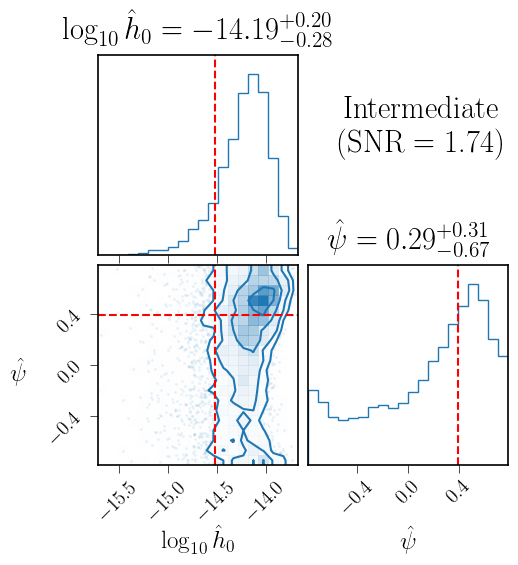

In [22]:
import corner
data = np.array([[maxlike_strains[_i], maxlike_pols[_i]] for _i in range(len(maxlike_strains))])
# print(data)

corner_fig = corner.corner(data, color='tab:blue', histtype='step',labels=[r'$\log_{10}\hat{h}_0$', r'$\hat{\psi}$'])

axs = corner_fig.get_axes()
axs[0].axvline(injected_strain, ls='--', color='red')
axs[2].axvline(injected_strain, ls='--', color='red')
axs[2].axhline(injected_pol, ls='--', color='red')
axs[2].set_ylabel(r'$\hat{\psi}$', rotation = 0, y = .40, x = -0.4)
axs[3].axvline(injected_pol, ls='--', color='red')

axs[0].set_title(r'$\log_{10}{\hat{h}_0} = -14.19^{+0.20}_{-0.28} $', fontsize=22, y=1.04)
axs[3].set_title(r'$\hat{\psi} = 0.29^{+0.31}_{-0.67} $', fontsize=22, y=1.04)
opt_snr = np.mean(maxlike_ncs)
mysuptitle = plt.suptitle("Intermediate\n(SNR = {:.02f})".format(opt_snr), y = 0.85, x=0.77, fontsize=22)
# mysuptitle = plt.suptitle("Intermediate Signal\n" +r"($\log_{10}{A_{\mathrm{RN}}} = $" +  "{:.02f})".format(np.log10(rn_amp))+ "\n"+ r"($\log_{10}{A_{\mathrm{bwm}}} = $" +  "{:.02f})".format(injected_strain), fontsize=18, y=1.15)

plt.savefig('/home/nima/nanograv/bwm_fpfe/mles_recovery_weakintermediate.pdf', bbox_inches='tight', bbox_extra_artists=[mysuptitle])
# plt.suptitle("Maximum Likelihood Parameter Recovery", y = 1.04, ha= 'center', fontsize = 16, )
plt.show()

## Intermediate Signal
### A = 7e-15

In [28]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []
psr_locs = np.loadtxt(psrloc_path)


rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = np.pi/8
log10_h = np.log10(7e-15)
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [29]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    nc_estimate = 0    
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series + bwm_signals[ipsr]
        prefit_resids =  wn_series + rn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

        # prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        # prefit_resids = wn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc

        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        

        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     
        
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    M_pinv = np.linalg.pinv(M)
    
    bp = M_pinv[0,0] * Np + M_pinv[0,1] * Nc
    bc = M_pinv[1,0] * Np + M_pinv[1,1] * Nc
    

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe, nc_estimate, bp, bc

In [30]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fe_worker, args)

results = np.array(results)
# print(results)
estimated_ncs = results[:,1]
fe_bs = results[:, (0,2,3)]

outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_interbwm_piby8_polarized_verbose.txt'
np.savetxt(outfile, fe_bs)

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_interbwm_ncs_piby8_polarized.txt'
np.savetxt(nc_outfile, estimated_ncs)

Finished iteration 252 in 2.6s. Fe = 10.076553736981252
Finished iteration 672 in 4.0s. Fe = 16.953354104241914
Finished iteration 1092 in 4.5s. Fe = 6.517829937917099
Finished iteration 588 in 4.5s. Fe = 4.174858470171224
Finished iteration 756 in 5.7s. Fe = 9.294061975330386
Finished iteration 840 in 6.3s. Fe = 0.7509561268311171
Finished iteration 420 in 6.4s. Fe = 2.844843523681001
Finished iteration 336 in 6.8s. Fe = 2.6615563340780346
Finished iteration 253 in 4.8s. Fe = 4.958446710541438
Finished iteration 0 in 7.6s. Fe = 0.05281592115396245
Finished iteration 168 in 7.7s. Fe = 3.4443525989494064
Finished iteration 1176 in 7.7s. Fe = 1.205588757642527Finished iteration 924 in 7.7s. Fe = 8.003430659534907
Finished iteration 84 in 7.7s. Fe = 6.108329921974979

Finished iteration 1008 in 7.8s. Fe = 2.0244394166495816
Finished iteration 504 in 7.9s. Fe = 2.7445852557550827
Finished iteration 673 in 5.8s. Fe = 2.030064580147601
Finished iteration 589 in 5.8s. Fe = 0.41435368696074204

Finished iteration 103 in 7.2s. Fe = 14.899743208329621
Finished iteration 1195 in 6.8s. Fe = 6.853458338735932
Finished iteration 943 in 7.1s. Fe = 9.62740476956186
Finished iteration 523 in 7.4s. Fe = 8.082885309643048
Finished iteration 273 in 6.9s. Fe = 9.595538270334185
Finished iteration 1027 in 7.4s. Fe = 0.0724103046238407
Finished iteration 608 in 7.2s. Fe = 4.522696990363393Finished iteration 19 in 7.3s. Fe = 14.163341121451758

Finished iteration 860 in 6.9s. Fe = 6.966782497594136
Finished iteration 1112 in 7.0s. Fe = 0.6840040656735278Finished iteration 440 in 6.8s. Fe = 2.391452326769965

Finished iteration 187 in 7.2s. Fe = 3.956057355847399
Finished iteration 776 in 7.8s. Fe = 0.5630342129679846
Finished iteration 692 in 7.7s. Fe = 4.200031089862278
Finished iteration 356 in 7.3s. Fe = 1.3994794061382558
Finished iteration 104 in 7.0s. Fe = 7.858420075623059
Finished iteration 1196 in 6.9s. Fe = 3.9691581014973316
Finished iteration 524 in 7.1s. Fe = 3.498205456154649
F

Finished iteration 794 in 7.4s. Fe = 0.09676861132480716
Finished iteration 542 in 7.6s. Fe = 2.2834667458093305
Finished iteration 627 in 7.3s. Fe = 5.36839720801855
Finished iteration 711 in 7.3s. Fe = 3.579633920790579
Finished iteration 1215 in 7.4s. Fe = 4.044988530649716
Finished iteration 123 in 7.0s. Fe = 9.524365302782591
Finished iteration 39 in 7.3s. Fe = 2.941225006759904
Finished iteration 1132 in 7.1s. Fe = 5.1945378654030145
Finished iteration 460 in 7.3s. Fe = 6.707170513580893
Finished iteration 1047 in 7.2s. Fe = 2.4922096802461295
Finished iteration 206 in 7.5s. Fe = 3.3354327003311033
Finished iteration 963 in 7.4s. Fe = 4.392418144052181
Finished iteration 376 in 7.4s. Fe = 1.8368157897778694
Finished iteration 293 in 7.3s. Fe = 1.6817967634591628
Finished iteration 880 in 7.5s. Fe = 3.891118400445837
Finished iteration 795 in 7.7s. Fe = 3.2969101134762546Finished iteration 543 in 7.4s. Fe = 1.5178647190894168

Finished iteration 628 in 7.4s. Fe = 3.831308422443226

Finished iteration 731 in 6.7s. Fe = 0.2517583083547793
Finished iteration 814 in 6.9s. Fe = 4.57800378575083
Finished iteration 313 in 6.8s. Fe = 1.172181568896892
Finished iteration 395 in 7.4s. Fe = 3.5852136066023457
Finished iteration 562 in 7.3s. Fe = 5.090675678723293
Finished iteration 898 in 7.7s. Fe = 3.6650700880219302
Finished iteration 1151 in 7.4s. Fe = 8.631407457236355
Finished iteration 647 in 7.0s. Fe = 1.1726411032607278
Finished iteration 225 in 7.3s. Fe = 3.0622024938645604
Finished iteration 143 in 7.2s. Fe = 14.500681882337032
Finished iteration 1235 in 7.3s. Fe = 8.04457482640119
Finished iteration 1066 in 7.0s. Fe = 6.003371990453023
Finished iteration 59 in 7.3s. Fe = 16.623237520756753
Finished iteration 983 in 7.2s. Fe = 2.9346239539936194
Finished iteration 480 in 6.8s. Fe = 1.0469420128808165
Finished iteration 732 in 7.3s. Fe = 2.597182292005095
Finished iteration 815 in 6.9s. Fe = 4.127926195030832
Finished iteration 314 in 6.9s. Fe = 3.2033469742545337


Finished iteration 581 in 7.0s. Fe = 1.737925752940179
Finished iteration 499 in 7.3s. Fe = 8.748786522229125
Finished iteration 666 in 7.6s. Fe = 1.1670231393361368
Finished iteration 244 in 7.5s. Fe = 0.8489567688015863
Finished iteration 79 in 6.6s. Fe = 1.0652039730372482
Finished iteration 917 in 7.3s. Fe = 4.17605294788091
Finished iteration 333 in 7.6s. Fe = 3.6329919584095594
Finished iteration 1002 in 7.6s. Fe = 8.099508713341738
Finished iteration 1085 in 7.3s. Fe = 0.26894526018495546
Finished iteration 834 in 7.4s. Fe = 0.5649009020379362
Finished iteration 163 in 7.5s. Fe = 11.779547668243218
Finished iteration 1171 in 6.9s. Fe = 19.08122822195132
Finished iteration 415 in 7.4s. Fe = 9.423819989026923
Finished iteration 1255 in 6.9s. Fe = 11.383687378327133Finished iteration 752 in 7.6s. Fe = 10.565657475600474

Finished iteration 582 in 7.0s. Fe = 3.417122107367616
Finished iteration 500 in 7.2s. Fe = 15.87282412888294
Finished iteration 80 in 6.5s. Fe = 4.368738569551034

Finished iteration 1442 in 7.3s. Fe = 6.483518176339624
Finished iteration 1862 in 7.3s. Fe = 2.0744505754713813
Finished iteration 1359 in 7.1s. Fe = 3.0645068849112773
Finished iteration 2113 in 7.2s. Fe = 7.523751346077523
Finished iteration 1945 in 7.3s. Fe = 11.773257307846567
Finished iteration 2447 in 7.3s. Fe = 1.0049982320067103
Finished iteration 2364 in 7.2s. Fe = 3.5709398920754047
Finished iteration 1610 in 7.4s. Fe = 6.952616904519105
Finished iteration 2197 in 6.9s. Fe = 1.0038724547636737
Finished iteration 1277 in 7.5s. Fe = 6.305599754181252
Finished iteration 2281 in 7.2s. Fe = 13.030037452305242
Finished iteration 1779 in 7.1s. Fe = 5.573916745062602
Finished iteration 1694 in 7.1s. Fe = 1.4743850502403486
Finished iteration 1527 in 7.2s. Fe = 5.154236355492909
Finished iteration 1443 in 7.0s. Fe = 4.66745935338052Finished iteration 1863 in 7.0s. Fe = 2.629730291570565
Finished iteration 2030 in 7.2s. Fe = 3.315950620644296

Finished iteration 1360 in 7.3s. Fe = 4.9

Finished iteration 1629 in 7.4s. Fe = 6.308982660868235
Finished iteration 2216 in 7.0s. Fe = 9.513758664131792
Finished iteration 1296 in 7.4s. Fe = 0.2748490397474409
Finished iteration 1964 in 7.5s. Fe = 1.2641230534400174
Finished iteration 1462 in 7.5s. Fe = 12.635840944990775
Finished iteration 1881 in 7.4s. Fe = 5.248365126774167
Finished iteration 2466 in 7.4s. Fe = 0.7136810080516958
Finished iteration 2384 in 7.6s. Fe = 8.549222728927905Finished iteration 2300 in 7.2s. Fe = 2.6891619182582436

Finished iteration 2133 in 7.8s. Fe = 6.916636504751172
Finished iteration 1546 in 7.8s. Fe = 4.342377010029528
Finished iteration 1630 in 7.2s. Fe = 21.56609820863627
Finished iteration 1379 in 7.9s. Fe = 17.52426721032797
Finished iteration 1713 in 7.8s. Fe = 3.5985626387998453
Finished iteration 1799 in 7.6s. Fe = 7.13673445644448
Finished iteration 2049 in 7.7s. Fe = 3.338002976412704
Finished iteration 1297 in 7.1s. Fe = 0.3932613145484432
Finished iteration 2217 in 7.7s. Fe = 1.16

Finished iteration 2319 in 7.3s. Fe = 3.3735341122001388
Finished iteration 2152 in 7.1s. Fe = 1.2727204610536464
Finished iteration 1900 in 7.4s. Fe = 7.235597448667931Finished iteration 1481 in 6.9s. Fe = 8.838830110885972

Finished iteration 2485 in 7.3s. Fe = 15.19672536319649
Finished iteration 2236 in 7.4s. Fe = 3.939464029909012
Finished iteration 1316 in 7.3s. Fe = 6.416052032487196
Finished iteration 1984 in 7.3s. Fe = 3.007557903581669
Finished iteration 1818 in 7.2s. Fe = 0.40288781681362734
Finished iteration 1398 in 7.6s. Fe = 5.484504376806734
Finished iteration 1649 in 6.9s. Fe = 2.730402300930831
Finished iteration 1732 in 6.6s. Fe = 8.635509591845612
Finished iteration 2068 in 7.7s. Fe = 5.190835674028637
Finished iteration 2404 in 7.5s. Fe = 6.827011881516219
Finished iteration 2320 in 7.5s. Fe = 0.5528687283622222
Finished iteration 1565 in 7.7s. Fe = 0.8031633694296489
Finished iteration 2153 in 7.0s. Fe = 3.677461751663399
Finished iteration 1901 in 7.2s. Fe = 3.49

Finished iteration 1668 in 7.8s. Fe = 4.193942333917033
Finished iteration 1919 in 7.0s. Fe = 2.4827628549722034
Finished iteration 2171 in 7.6s. Fe = 4.562904576733933
Finished iteration 1417 in 7.4s. Fe = 11.5620884858645
Finished iteration 2423 in 7.1s. Fe = 10.779701224589699
Finished iteration 1584 in 7.3s. Fe = 4.245544227449964
Finished iteration 2255 in 7.4s. Fe = 1.5675717092370198
Finished iteration 2087 in 7.6s. Fe = 7.8732248010945565
Finished iteration 1751 in 7.3s. Fe = 2.8325738019312863
Finished iteration 2504 in 7.4s. Fe = 1.5834828186855188
Finished iteration 1838 in 6.9s. Fe = 0.6646705221690038
Finished iteration 2339 in 7.7s. Fe = 3.691127623001662
Finished iteration 1501 in 7.1s. Fe = 9.122426483609072
Finished iteration 2004 in 7.2s. Fe = 4.254977162017029
Finished iteration 1336 in 7.4s. Fe = 0.9920149921468449
Finished iteration 1920 in 7.0s. Fe = 0.04882741584647121
Finished iteration 1669 in 7.9s. Fe = 8.339278199116299
Finished iteration 2172 in 7.7s. Fe = 2

Finished iteration 3198 in 7.5s. Fe = 3.851044525734271
Finished iteration 3282 in 7.3s. Fe = 1.688852931031294
Finished iteration 3031 in 7.1s. Fe = 0.954827959310801
Finished iteration 3534 in 7.2s. Fe = 6.819984042984103Finished iteration 2864 in 6.5s. Fe = 3.3283594743501532

Finished iteration 3699 in 7.3s. Fe = 3.040148158429616
Finished iteration 3618 in 6.9s. Fe = 1.390254216950499
Finished iteration 3450 in 7.7s. Fe = 12.745585625673652
Finished iteration 2780 in 7.5s. Fe = 2.9557162945687203
Finished iteration 2696 in 7.8s. Fe = 16.01145778785669
Finished iteration 2531 in 7.5s. Fe = 3.8917574820578067
Finished iteration 2948 in 7.1s. Fe = 0.2303066020913183
Finished iteration 3115 in 6.9s. Fe = 1.1839767725380537
Finished iteration 2614 in 7.4s. Fe = 3.1202494162552035
Finished iteration 3367 in 7.0s. Fe = 4.268801243477221
Finished iteration 3199 in 7.0s. Fe = 5.065173573815225
Finished iteration 2865 in 6.8s. Fe = 0.09904877574229422
Finished iteration 3032 in 7.4s. Fe = 1

Finished iteration 2550 in 7.0s. Fe = 6.4342793277289605
Finished iteration 2715 in 7.5s. Fe = 6.076529688675449
Finished iteration 3469 in 6.9s. Fe = 12.581931017900542
Finished iteration 3301 in 7.1s. Fe = 13.712007538039838
Finished iteration 2967 in 6.9s. Fe = 5.9523742184174955
Finished iteration 2884 in 7.0s. Fe = 3.275229749956388
Finished iteration 3050 in 7.2s. Fe = 9.411569987042755
Finished iteration 2799 in 7.6s. Fe = 12.166104576701612
Finished iteration 3134 in 7.1s. Fe = 3.092681750253996
Finished iteration 3554 in 7.3s. Fe = 6.400184454145912Finished iteration 3637 in 7.2s. Fe = 6.059646604290386

Finished iteration 3218 in 7.2s. Fe = 0.37993797699461573
Finished iteration 3719 in 6.7s. Fe = 3.3445534841768536
Finished iteration 3387 in 6.7s. Fe = 16.55918136119155
Finished iteration 2633 in 7.5s. Fe = 6.435680464820988
Finished iteration 2716 in 7.1s. Fe = 14.901246864268149
Finished iteration 2551 in 7.4s. Fe = 13.580460521518331
Finished iteration 3470 in 7.4s. Fe = 

Finished iteration 2569 in 7.8s. Fe = 2.992944204252297
Finished iteration 2651 in 7.1s. Fe = 5.355627698755726
Finished iteration 3656 in 6.9s. Fe = 12.159646291877586
Finished iteration 3738 in 7.2s. Fe = 2.0077866004633464
Finished iteration 3237 in 7.2s. Fe = 1.7455862387276917
Finished iteration 2734 in 7.3s. Fe = 17.63962627559293
Finished iteration 2903 in 6.7s. Fe = 5.8070089331169195
Finished iteration 3406 in 7.5s. Fe = 10.959283307737113
Finished iteration 2818 in 7.4s. Fe = 1.103754126240735
Finished iteration 3489 in 6.9s. Fe = 0.6252833885661968
Finished iteration 3321 in 7.5s. Fe = 2.854219882434868
Finished iteration 2987 in 7.4s. Fe = 4.147142380719438
Finished iteration 3070 in 7.4s. Fe = 0.21011213151599792
Finished iteration 2652 in 7.0s. Fe = 3.2503499852459865Finished iteration 3574 in 7.5s. Fe = 5.550471018364234

Finished iteration 3154 in 7.6s. Fe = 0.6792083933930492
Finished iteration 3657 in 7.3s. Fe = 5.033679714660427Finished iteration 2570 in 7.9s. Fe = 3

Finished iteration 2753 in 7.4s. Fe = 2.6576322559350434
Finished iteration 2922 in 6.5s. Fe = 1.8643250131157452
Finished iteration 3675 in 6.5s. Fe = 6.703376845466646
Finished iteration 3508 in 6.5s. Fe = 0.6993504902589447
Finished iteration 3006 in 6.5s. Fe = 10.896175257307032
Finished iteration 2837 in 6.4s. Fe = 3.7504127629429522
Finished iteration 3089 in 7.6s. Fe = 2.8685756370729916
Finished iteration 3173 in 6.4s. Fe = 2.392837396822677
Finished iteration 3593 in 6.5s. Fe = 5.0091272790526045
Finished iteration 3257 in 7.3s. Fe = 7.472510158553771
Finished iteration 3341 in 7.0s. Fe = 6.053128596862712
Finished iteration 2589 in 6.7s. Fe = 13.268535734271069
Finished iteration 2671 in 7.1s. Fe = 10.852248647311141
Finished iteration 3425 in 7.5s. Fe = 11.330306893282891
Finished iteration 3758 in 7.2s. Fe = 11.088227826851007
Finished iteration 2754 in 7.4s. Fe = 0.37895517535897993
Finished iteration 2923 in 7.1s. Fe = 7.6099812707513195
Finished iteration 3676 in 7.2s. F

Finished iteration 3275 in 7.6s. Fe = 2.7393567637873297
Finished iteration 4284 in 7.6s. Fe = 12.611525112355135
Finished iteration 4368 in 7.4s. Fe = 1.8746431205466645
Finished iteration 3949 in 7.1s. Fe = 7.457437944993697
Finished iteration 4452 in 7.2s. Fe = 17.033289137554238
Finished iteration 4536 in 7.4s. Fe = 2.652286391308201
Finished iteration 3777 in 7.5s. Fe = 3.9340138474826185Finished iteration 4033 in 7.8s. Fe = 3.3908451596344698

Finished iteration 3784 in 7.4s. Fe = 6.809706259195952Finished iteration 4620 in 7.5s. Fe = 17.571585764771115

Finished iteration 4704 in 7.7s. Fe = 2.4454597064768175
Finished iteration 3695 in 7.3s. Fe = 1.0926899672424968
Finished iteration 4117 in 7.3s. Fe = 9.094090210126131
Finished iteration 4201 in 7.2s. Fe = 4.073855207521874
Finished iteration 3867 in 7.1s. Fe = 3.930715159266009
Finished iteration 4788 in 7.4s. Fe = 5.218541808853601
Finished iteration 4369 in 7.1s. Fe = 5.285049777128199
Finished iteration 4285 in 7.3s. Fe = 2

Finished iteration 4555 in 6.6s. Fe = 7.645188141472362
Finished iteration 4890 in 7.1s. Fe = 8.442599750510052
Finished iteration 4136 in 7.0s. Fe = 3.488983545645068
Finished iteration 4052 in 7.5s. Fe = 4.006570969669123
Finished iteration 4388 in 7.6s. Fe = 7.272934455477519
Finished iteration 4639 in 7.0s. Fe = 9.714866125871767
Finished iteration 4304 in 6.6s. Fe = 7.611497031727536
Finished iteration 4723 in 7.5s. Fe = 22.93522414164383
Finished iteration 4471 in 7.1s. Fe = 3.111066695148864Finished iteration 4972 in 7.3s. Fe = 2.830036332296599

Finished iteration 4807 in 7.1s. Fe = 1.3126793623112398
Finished iteration 4220 in 6.9s. Fe = 16.35604469708987
Finished iteration 3886 in 6.8s. Fe = 4.471275396618196
Finished iteration 3804 in 6.8s. Fe = 1.1091400319389608
Finished iteration 4556 in 6.8s. Fe = 2.084915778186258
Finished iteration 3969 in 7.9s. Fe = 3.9830764641468024
Finished iteration 4891 in 7.2s. Fe = 17.841100479193987
Finished iteration 4137 in 6.9s. Fe = 3.5067

Finished iteration 4407 in 6.8s. Fe = 6.2127206860665956
Finished iteration 4991 in 6.7s. Fe = 5.619041557723142
Finished iteration 4071 in 7.2s. Fe = 14.660473284781816
Finished iteration 4239 in 6.4s. Fe = 2.076497206954255
Finished iteration 4155 in 7.5s. Fe = 3.4539927857192687
Finished iteration 3905 in 7.2s. Fe = 3.7869610850502733
Finished iteration 4575 in 6.6s. Fe = 6.1396597305267395
Finished iteration 4910 in 6.4s. Fe = 7.010451548706875Finished iteration 4490 in 7.5s. Fe = 11.738916104127702

Finished iteration 4658 in 8.0s. Fe = 5.645620192972156
Finished iteration 4324 in 6.6s. Fe = 3.777763485250058
Finished iteration 3988 in 7.1s. Fe = 7.57415599775579
Finished iteration 3824 in 7.3s. Fe = 2.1536446799245716
Finished iteration 4742 in 7.4s. Fe = 4.275866327649078
Finished iteration 4826 in 7.6s. Fe = 3.8975604173779494
Finished iteration 4408 in 7.6s. Fe = 11.246659053814868
Finished iteration 4072 in 7.1s. Fe = 1.9367096506605745
Finished iteration 4992 in 7.4s. Fe = 4

Finished iteration 4930 in 6.8s. Fe = 2.624708903514477
Finished iteration 4344 in 6.5s. Fe = 2.054185343501958
Finished iteration 4175 in 7.1s. Fe = 7.959860329767629
Finished iteration 4091 in 6.6s. Fe = 3.723798879265119
Finished iteration 4259 in 7.0s. Fe = 1.1850384088942305
Finished iteration 4595 in 6.6s. Fe = 1.2848762914743344
Finished iteration 4427 in 6.8s. Fe = 2.440495113747105
Finished iteration 4510 in 6.8s. Fe = 1.6085077630502171
Finished iteration 3925 in 6.8s. Fe = 9.560813924747714
Finished iteration 3844 in 6.7s. Fe = 0.40825807141579906
Finished iteration 4678 in 6.6s. Fe = 3.7176246834693085
Finished iteration 4762 in 7.1s. Fe = 1.866916219263861
Finished iteration 4008 in 7.0s. Fe = 5.507535975357121
Finished iteration 4846 in 7.0s. Fe = 10.679424624004803
Finished iteration 4931 in 6.6s. Fe = 3.193267445980655
Finished iteration 4345 in 6.7s. Fe = 4.931414994213382
Finished iteration 4092 in 6.7s. Fe = 6.409129353337322Finished iteration 4176 in 7.1s. Fe = 0.19

Finished iteration 4698 in 5.7s. Fe = 2.2554269023867435
Finished iteration 4112 in 6.7s. Fe = 6.499305053523187
Finished iteration 4781 in 6.7s. Fe = 3.6690833894626262
Finished iteration 4028 in 6.8s. Fe = 2.8004746622670242
Finished iteration 4365 in 6.6s. Fe = 4.257979819258212
Finished iteration 4280 in 6.5s. Fe = 1.5952296903317926
Finished iteration 4196 in 6.5s. Fe = 8.641334289422424
Finished iteration 4952 in 6.5s. Fe = 16.905899729704068
Finished iteration 4448 in 6.6s. Fe = 2.444531831875446
Finished iteration 4532 in 5.6s. Fe = 1.5507269335538008
Finished iteration 4616 in 6.4s. Fe = 3.8583549606000753
Finished iteration 3946 in 6.2s. Fe = 3.293971861972296
Finished iteration 4866 in 6.4s. Fe = 5.720003455835636
Finished iteration 4699 in 6.4s. Fe = 8.714989872927424Finished iteration 4113 in 6.2s. Fe = 4.763230532795324

Finished iteration 4782 in 6.3s. Fe = 8.814396865941086
Finished iteration 4029 in 6.5s. Fe = 4.849826804165115
Finished iteration 4366 in 6.5s. Fe = 7.9

In [16]:
maxlike_ncs = np.loadtxt("/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_interbwm_ncs_piby8_polarized.txt")
maxlike_output = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_interbwm_piby8_polarized_verbose.txt')

In [17]:
bps = maxlike_output[:,1]
bcs = maxlike_output[:,2]

injected_strain = np.log10(7e-15)
injected_pol = np.pi/8

maxlike_strains = np.log10(np.array([np.sqrt(bps[_i]**2 + bcs[_i]**2) for _i in range(len(bps))]))
maxlike_pols = np.array([0.5*np.arctan(bcs[_i]/bps[_i]) for _i in range(len(bps))])


#compute 1-sigma errors
median_strain = np.median(sorted(maxlike_strains))
strain_idx_gap = int(len(maxlike_strains) * .341)
median_idx = int(len(maxlike_strains)/2)
upper_strain = sorted(maxlike_strains)[median_idx + strain_idx_gap]
lower_strain = sorted(maxlike_strains)[median_idx - strain_idx_gap]

median_pol = np.median(sorted(maxlike_pols))
pol_idx_gap = int(len(maxlike_pols) * .341)
median_idx = int(len(maxlike_pols)/2)
upper_pol = sorted(maxlike_pols)[median_idx + pol_idx_gap]
lower_pol = sorted(maxlike_pols)[median_idx - pol_idx_gap]

print(median_strain, median_strain - lower_strain, upper_strain-median_strain)
print(median_pol, median_pol - lower_pol, upper_pol-median_pol)


-14.100125573775063 0.2399140452761621 0.17923747801008894
0.35495575919745964 0.4467683236428764 0.2326273039519387


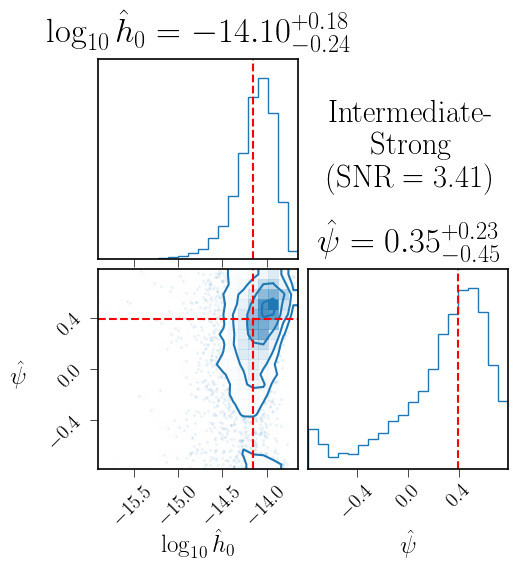

In [18]:
import corner
data = np.array([[maxlike_strains[_i], maxlike_pols[_i]] for _i in range(len(maxlike_strains))])
# print(data)

corner_fig = corner.corner(data, color='tab:blue', histtype='step',labels=[r'$\log_{10}\hat{h}_0$', r'$\hat{\psi}$'])

axs = corner_fig.get_axes()
f = plt.gcf()
axs[0].axvline(injected_strain, ls='--', color='red')
axs[2].axvline(injected_strain, ls='--', color='red')
axs[2].axhline(injected_pol, ls='--', color='red')
axs[2].set_ylabel(r'$\hat{\psi}$', rotation = 0, y = .40, x = -0.4)
axs[3].axvline(injected_pol, ls='--', color='red')

axs[0].set_title(r'$\log_{10}{\hat{h}_0} = -14.10^{+0.18}_{-0.24} $', fontsize=25, y=1.04)
axs[3].set_title(r'$\hat{\psi} = 0.35^{+0.23}_{-0.45} $', fontsize=25, y=1.04)
opt_snr = np.mean(maxlike_ncs)
mysuptitle = plt.suptitle("Intermediate-\nStrong\n(SNR = {:.02f})".format(opt_snr), y = 0.85, x=0.75, fontsize=22)
# mysuptitle = plt.suptitle("Intermediate-Large Signal\n" +r"($\log_{10}{A_{\mathrm{RN}}} = $" +  "{:.02f})".format(np.log10(rn_amp))+ "\n"+ r"($\log_{10}{A_{\mathrm{bwm}}} = $" +  "{:.02f})".format(injected_strain), fontsize=18, y=1.15)

plt.savefig('/home/nima/nanograv/bwm_fpfe/mles_recovery_inter.pdf', bbox_inches='tight', bbox_extra_artists=[mysuptitle])
# plt.suptitle("Maximum Likelihood Parameter Recovery", y = 1.04, ha= 'center', fontsize = 16, )
plt.show()

# Weak-Intermediate

In [34]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []
psr_locs = np.loadtxt(psrloc_path)


rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = np.pi/8
log10_h = np.log10(5e-15)
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

In [35]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    nc_estimate = 0    
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series + bwm_signals[ipsr]
        prefit_resids =  wn_series + rn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

        # prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        # prefit_resids = wn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc

        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        

        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     
        
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    M_pinv = np.linalg.pinv(M)
    
    bp = M_pinv[0,0] * Np + M_pinv[0,1] * Nc
    bc = M_pinv[1,0] * Np + M_pinv[1,1] * Nc
    

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe, nc_estimate, bp, bc

In [36]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fe_worker, args)

results = np.array(results)
# print(results)
estimated_ncs = results[:,1]
fe_bs = results[:, (0,2,3)]

outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_weakinterbwm_piby8_polarized_verbose.txt'
np.savetxt(outfile, fe_bs)

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_weakinterbwm_ncs_piby8_polarized.txt'
np.savetxt(nc_outfile, estimated_ncs)

Finished iteration 588 in 5.5s. Fe = 3.263858994478999
Finished iteration 924 in 6.1s. Fe = 5.435824478996771
Finished iteration 1176 in 6.3s. Fe = 0.33966852178617263
Finished iteration 504 in 6.4s. Fe = 1.2965837249230783
Finished iteration 420 in 6.4s. Fe = 2.007922002363551
Finished iteration 672 in 6.5s. Fe = 13.102296096124789
Finished iteration 84 in 6.5s. Fe = 4.6500802529768395Finished iteration 756 in 6.5s. Fe = 6.379830728363358

Finished iteration 1092 in 6.5s. Fe = 4.1033897348042245Finished iteration 336 in 6.6s. Fe = 1.2242330668624148

Finished iteration 252 in 6.6s. Fe = 7.225958298361647Finished iteration 0 in 6.7s. Fe = 0.10411437662860568

Finished iteration 1008 in 6.8s. Fe = 0.8999149225235272
Finished iteration 168 in 6.8s. Fe = 2.1087007087283576
Finished iteration 840 in 6.9s. Fe = 0.4268901089505617
Finished iteration 589 in 6.5s. Fe = 0.4533076219102187
Finished iteration 925 in 6.5s. Fe = 0.078877913799717
Finished iteration 673 in 6.2s. Fe = 1.9947237295588

Finished iteration 187 in 6.7s. Fe = 2.138076143053625
Finished iteration 355 in 6.9s. Fe = 1.8777790589710042
Finished iteration 19 in 6.6s. Fe = 10.926607301846087
Finished iteration 607 in 6.8s. Fe = 0.3691009865707085
Finished iteration 272 in 6.4s. Fe = 1.5443719591500455
Finished iteration 439 in 5.8s. Fe = 1.7529577527675428
Finished iteration 860 in 5.8s. Fe = 4.482643343105732
Finished iteration 1195 in 6.7s. Fe = 4.530981267777812Finished iteration 944 in 6.5s. Fe = 6.948567345749223

Finished iteration 524 in 6.5s. Fe = 1.8227281638179862
Finished iteration 1111 in 6.7s. Fe = 4.041066665554643
Finished iteration 104 in 6.7s. Fe = 5.338530814601845
Finished iteration 1028 in 6.9s. Fe = 6.209467542928003
Finished iteration 692 in 6.5s. Fe = 2.941340319709049
Finished iteration 777 in 6.7s. Fe = 4.704770134549354
Finished iteration 188 in 7.0s. Fe = 2.92593315555915
Finished iteration 356 in 6.6s. Fe = 0.4888721184997742
Finished iteration 20 in 6.6s. Fe = 0.5165384316469591
Fi

Finished iteration 122 in 6.7s. Fe = 5.642756456729693
Finished iteration 963 in 6.4s. Fe = 3.3056505854771947
Finished iteration 1047 in 6.6s. Fe = 1.4386301622092261
Finished iteration 880 in 6.2s. Fe = 2.087587802887063
Finished iteration 458 in 6.6s. Fe = 4.1676731489277055
Finished iteration 796 in 6.4s. Fe = 0.3771922101289247
Finished iteration 711 in 7.0s. Fe = 1.8898277553997533
Finished iteration 292 in 6.1s. Fe = 7.575062891120734
Finished iteration 627 in 6.7s. Fe = 3.4641837130750255
Finished iteration 207 in 6.7s. Fe = 9.683132958058737
Finished iteration 39 in 6.8s. Fe = 1.4701688627882987
Finished iteration 375 in 6.7s. Fe = 0.15863204246102106
Finished iteration 1131 in 6.7s. Fe = 5.8207824677733475Finished iteration 544 in 6.6s. Fe = 11.807096882558351

Finished iteration 123 in 6.6s. Fe = 6.546286445596567
Finished iteration 1215 in 6.8s. Fe = 2.694878649233841
Finished iteration 964 in 6.4s. Fe = 7.784686216869622
Finished iteration 1048 in 6.6s. Fe = 16.79613080310

Finished iteration 563 in 6.9s. Fe = 0.21390502307747708
Finished iteration 1067 in 6.2s. Fe = 6.43005254447459
Finished iteration 815 in 6.7s. Fe = 3.7060360508445314Finished iteration 312 in 6.3s. Fe = 1.7923806620383838

Finished iteration 730 in 6.4s. Fe = 5.752656165627038
Finished iteration 142 in 6.4s. Fe = 3.8550171337771078
Finished iteration 394 in 6.8s. Fe = 7.85503383745222
Finished iteration 1150 in 6.6s. Fe = 1.9878461846976945
Finished iteration 983 in 6.5s. Fe = 1.5095921144926763
Finished iteration 226 in 6.7s. Fe = 4.666720955920015
Finished iteration 478 in 6.6s. Fe = 5.537148752716731
Finished iteration 647 in 6.9s. Fe = 1.6828856998114599
Finished iteration 1234 in 6.5s. Fe = 6.351511050492898
Finished iteration 900 in 6.4s. Fe = 0.6916418981880317
Finished iteration 59 in 6.4s. Fe = 12.653249850477813
Finished iteration 1068 in 6.4s. Fe = 5.364066321720164
Finished iteration 313 in 6.4s. Fe = 0.4997006755136888
Finished iteration 564 in 6.7s. Fe = 5.06723436063663

Finished iteration 332 in 5.7s. Fe = 0.9417973697911821
Finished iteration 835 in 6.3s. Fe = 2.262081091113467
Finished iteration 161 in 6.5s. Fe = 1.7405840021972765
Finished iteration 1086 in 6.9s. Fe = 4.16340277047473
Finished iteration 750 in 6.9s. Fe = 15.733410254355304
Finished iteration 413 in 6.8s. Fe = 5.708364844726913
Finished iteration 78 in 6.9s. Fe = 2.2694550776226006
Finished iteration 583 in 6.7s. Fe = 6.69917442494226
Finished iteration 666 in 6.7s. Fe = 0.36726116662814945
Finished iteration 498 in 6.6s. Fe = 2.6845655576698704
Finished iteration 1253 in 6.7s. Fe = 1.5483513404918472
Finished iteration 246 in 6.5s. Fe = 12.66402995467743
Finished iteration 1003 in 6.1s. Fe = 5.22773441410291
Finished iteration 1170 in 6.7s. Fe = 4.225990248033817
Finished iteration 920 in 6.7s. Fe = 2.6049584457140265
Finished iteration 162 in 6.2s. Fe = 2.5313973531181464
Finished iteration 333 in 6.7s. Fe = 1.9364474154985019
Finished iteration 836 in 6.8s. Fe = 8.764683929857057

Finished iteration 1358 in 7.0s. Fe = 1.7205668771063287
Finished iteration 1442 in 6.8s. Fe = 4.1175703189779025
Finished iteration 1777 in 6.2s. Fe = 0.46337603690816537
Finished iteration 1945 in 6.7s. Fe = 9.683678902883146
Finished iteration 2029 in 6.6s. Fe = 2.347437979910394
Finished iteration 1694 in 6.7s. Fe = 0.8884916641749805
Finished iteration 2281 in 6.3s. Fe = 9.501042495093113
Finished iteration 2448 in 6.6s. Fe = 1.0001682422088027
Finished iteration 1276 in 6.6s. Fe = 0.9536816535981868
Finished iteration 2197 in 6.6s. Fe = 0.22876626804294387
Finished iteration 1610 in 6.9s. Fe = 5.478006960422188
Finished iteration 1527 in 6.3s. Fe = 3.076002163243479
Finished iteration 2113 in 6.5s. Fe = 4.906851037450225
Finished iteration 1862 in 6.4s. Fe = 0.8384173750566125
Finished iteration 2365 in 6.6s. Fe = 6.136334434843938
Finished iteration 1359 in 6.9s. Fe = 1.4978951194877774
Finished iteration 1443 in 6.8s. Fe = 2.679350918868409
Finished iteration 1778 in 6.4s. Fe =

Finished iteration 1796 in 6.7s. Fe = 1.8927419032996744
Finished iteration 1461 in 6.7s. Fe = 4.607899590417977
Finished iteration 2215 in 7.1s. Fe = 5.821600031315804
Finished iteration 1546 in 6.8s. Fe = 2.7058319604060306
Finished iteration 1965 in 6.1s. Fe = 0.8671979761906098
Finished iteration 2300 in 6.7s. Fe = 1.340310188543822
Finished iteration 1295 in 6.5s. Fe = 1.571137116590764
Finished iteration 2132 in 6.8s. Fe = 2.281243875992548
Finished iteration 2467 in 6.6s. Fe = 4.769763227522702
Finished iteration 2384 in 6.8s. Fe = 5.912194303297347
Finished iteration 1629 in 6.6s. Fe = 3.947291385399841
Finished iteration 2048 in 6.7s. Fe = 3.341595872327578
Finished iteration 1881 in 6.6s. Fe = 3.112460313962213
Finished iteration 1378 in 6.6s. Fe = 1.554711556060411
Finished iteration 1714 in 6.4s. Fe = 0.7947987738238003
Finished iteration 2216 in 6.5s. Fe = 6.549511715852384
Finished iteration 1462 in 6.7s. Fe = 9.266697321594773
Finished iteration 1797 in 6.9s. Fe = 4.8131

Finished iteration 1480 in 6.4s. Fe = 4.903951208056817
Finished iteration 2234 in 6.6s. Fe = 8.046648826103397
Finished iteration 2151 in 6.5s. Fe = 2.294896931907484
Finished iteration 1900 in 6.7s. Fe = 4.7930016145771495
Finished iteration 1648 in 6.8s. Fe = 3.7331996727014305
Finished iteration 2486 in 5.8s. Fe = 0.3697172985033472
Finished iteration 2403 in 6.8s. Fe = 1.8277842497206704
Finished iteration 2235 in 1.9s. Fe = 0.39884427148316604
Finished iteration 1985 in 6.8s. Fe = 2.5217832214933766
Finished iteration 2067 in 6.0s. Fe = 0.6040560724256815
Finished iteration 2319 in 6.3s. Fe = 2.176722824085909
Finished iteration 1566 in 7.0s. Fe = 7.0589887679418615
Finished iteration 1733 in 7.0s. Fe = 2.6104922103533608
Finished iteration 1816 in 6.1s. Fe = 4.492142075798803
Finished iteration 1314 in 7.2s. Fe = 0.8577108715157213
Finished iteration 1397 in 7.4s. Fe = 5.497948481642427
Finished iteration 1481 in 7.2s. Fe = 5.982705214440441
Finished iteration 2236 in 5.2s. Fe =

Finished iteration 1333 in 6.9s. Fe = 5.135717247410163
Finished iteration 1498 in 6.7s. Fe = 0.3137436210352004
Finished iteration 1918 in 7.3s. Fe = 1.7699310570034426Finished iteration 1666 in 7.1s. Fe = 7.966335375096798

Finished iteration 2173 in 7.1s. Fe = 6.998305079705617
Finished iteration 1752 in 4.3s. Fe = 1.0960648682547152
Finished iteration 1334 in 2.4s. Fe = 0.6334647152816586
Finished iteration 2086 in 7.1s. Fe = 2.7570516235175075
Finished iteration 1835 in 5.4s. Fe = 4.982481927497461
Finished iteration 2338 in 7.0s. Fe = 0.23637416824904192
Finished iteration 1499 in 3.0s. Fe = 5.032177279379912
Finished iteration 2254 in 7.3s. Fe = 0.505037639229551
Finished iteration 2422 in 6.2s. Fe = 3.9285437883323273
Finished iteration 1586 in 6.7s. Fe = 1.8036860303781084Finished iteration 2505 in 6.5s. Fe = 3.306425695233825

Finished iteration 1667 in 4.7s. Fe = 3.4466137327322732Finished iteration 2004 in 6.9s. Fe = 3.1417080256737293

Finished iteration 1919 in 4.8s. Fe =

Finished iteration 3030 in 5.7s. Fe = 4.658152312083662
Finished iteration 2528 in 5.2s. Fe = 0.6132053035226323
Finished iteration 3448 in 4.8s. Fe = 4.130302356170606
Finished iteration 2612 in 6.4s. Fe = 9.534416684873317
Finished iteration 2696 in 6.9s. Fe = 12.356776972160418
Finished iteration 3114 in 6.8s. Fe = 7.834676730876171
Finished iteration 2947 in 7.4s. Fe = 0.9980222078802857
Finished iteration 2781 in 4.8s. Fe = 4.835346627623201
Finished iteration 3700 in 7.6s. Fe = 7.999207364638899
Finished iteration 3281 in 6.2s. Fe = 0.327436166277932
Finished iteration 2865 in 7.2s. Fe = 0.054869524791373275Finished iteration 3197 in 6.4s. Fe = 0.3271323489134425

Finished iteration 3617 in 7.1s. Fe = 1.4633823742564946
Finished iteration 3366 in 7.4s. Fe = 5.175239177716058
Finished iteration 3031 in 6.3s. Fe = 0.2821904019799692
Finished iteration 3533 in 6.8s. Fe = 2.9354271518623607
Finished iteration 3449 in 5.1s. Fe = 4.172916807474672
Finished iteration 2529 in 7.5s. Fe = 

Finished iteration 3217 in 6.3s. Fe = 14.316486285798206Finished iteration 3384 in 6.9s. Fe = 8.022720742271368

Finished iteration 3718 in 6.6s. Fe = 3.219846202267366
Finished iteration 3132 in 6.8s. Fe = 3.616413245981051
Finished iteration 2548 in 3.6s. Fe = 0.8320732858922562
Finished iteration 2883 in 7.1s. Fe = 7.978392766568728
Finished iteration 2967 in 6.6s. Fe = 3.6607806864611536
Finished iteration 3301 in 4.4s. Fe = 10.443996686808692
Finished iteration 3552 in 4.5s. Fe = 4.012161378475685
Finished iteration 3218 in 3.5s. Fe = 0.40067376819683487
Finished iteration 2715 in 6.7s. Fe = 3.7572378888502005
Finished iteration 2549 in 4.0s. Fe = 7.197324172639774Finished iteration 2884 in 3.1s. Fe = 1.6774203682432625

Finished iteration 3634 in 6.9s. Fe = 2.500637633926486
Finished iteration 3553 in 2.1s. Fe = 7.6296777958755895
Finished iteration 2632 in 6.1s. Fe = 0.6018825067121407
Finished iteration 3133 in 5.0s. Fe = 7.963782054236759
Finished iteration 3719 in 5.8s. Fe = 

Finished iteration 3069 in 7.0s. Fe = 3.8365866892168445
Finished iteration 3738 in 4.9s. Fe = 1.093610033769421
Finished iteration 2733 in 6.9s. Fe = 7.951471449266661Finished iteration 2901 in 6.6s. Fe = 0.3523660712015483

Finished iteration 3574 in 2.8s. Fe = 3.858423191911335
Finished iteration 2568 in 7.5s. Fe = 7.603758395327186
Finished iteration 3152 in 5.5s. Fe = 4.0524599759159035Finished iteration 3237 in 7.0s. Fe = 0.9522487706627664

Finished iteration 3484 in 7.4s. Fe = 0.91418176512301
Finished iteration 3403 in 5.9s. Fe = 1.231036271053509
Finished iteration 3319 in 6.7s. Fe = 0.44787530137590104
Finished iteration 2987 in 5.0s. Fe = 2.708090900429544
Finished iteration 3653 in 5.9s. Fe = 0.8447632613287743
Finished iteration 3070 in 5.5s. Fe = 0.11280485628984258
Finished iteration 3575 in 4.7s. Fe = 7.2878156989869955Finished iteration 3739 in 5.1s. Fe = 0.17346068654038307

Finished iteration 2822 in 6.2s. Fe = 2.8895153175220707Finished iteration 2902 in 4.9s. Fe =

Finished iteration 3592 in 5.5s. Fe = 3.222211048568836
Finished iteration 3337 in 6.4s. Fe = 2.593873383218
Finished iteration 3006 in 6.7s. Fe = 7.697613057026188
Finished iteration 2923 in 2.6s. Fe = 5.860978412997562
Finished iteration 2843 in 3.3s. Fe = 6.880696600310853
Finished iteration 3170 in 6.2s. Fe = 1.426809592826408
Finished iteration 3424 in 7.1s. Fe = 2.875319153193779
Finished iteration 2753 in 6.5s. Fe = 1.2194868234446667
Finished iteration 3757 in 7.1s. Fe = 9.55295648437105
Finished iteration 2670 in 6.8s. Fe = 6.081971952218136
Finished iteration 2586 in 6.5s. Fe = 4.306220237130208
Finished iteration 3502 in 6.4s. Fe = 0.6405694368787717
Finished iteration 3256 in 7.1s. Fe = 3.7471999858600133
Finished iteration 2924 in 4.4s. Fe = 6.4476372478960124
Finished iteration 3671 in 7.0s. Fe = 3.4019173241498293
Finished iteration 3089 in 6.8s. Fe = 1.641332352341101
Finished iteration 3593 in 6.6s. Fe = 3.130154677801416
Finished iteration 3338 in 7.0s. Fe = 1.7852813

Finished iteration 3785 in 6.6s. Fe = 0.5139277833283413Finished iteration 3106 in 6.4s. Fe = 3.847517910993711

Finished iteration 3189 in 6.5s. Fe = 4.35320876188793
Finished iteration 4116 in 6.7s. Fe = 1.3226142379468504
Finished iteration 3273 in 6.8s. Fe = 19.221918380438677
Finished iteration 3521 in 6.5s. Fe = 2.05101981543936
Finished iteration 3778 in 5.5s. Fe = 2.175051866516662
Finished iteration 4033 in 6.7s. Fe = 1.7430740731572851
Finished iteration 3610 in 6.7s. Fe = 0.21839961867603197
Finished iteration 4200 in 6.9s. Fe = 2.250587993449596
Finished iteration 3866 in 5.9s. Fe = 5.085000057718316
Finished iteration 3522 in 2.7s. Fe = 2.3715202356585747
Finished iteration 3950 in 6.9s. Fe = 0.1967453494840517
Finished iteration 3786 in 5.7s. Fe = 7.803238872937501
Finished iteration 3359 in 6.6s. Fe = 1.5449849498216053Finished iteration 3274 in 3.6s. Fe = 2.3504219298127946

Finished iteration 3190 in 5.5s. Fe = 9.095760889102
Finished iteration 3692 in 7.1s. Fe = 2.727

Finished iteration 4968 in 5.1s. Fe = 1.6764276589977913Finished iteration 4136 in 6.7s. Fe = 2.0830477382333936

Finished iteration 4637 in 7.6s. Fe = 1.943685814057826
Finished iteration 4553 in 3.1s. Fe = 4.784218075421861Finished iteration 3970 in 6.9s. Fe = 4.037178845787624

Finished iteration 4386 in 5.4s. Fe = 2.791966056638364Finished iteration 4888 in 3.0s. Fe = 5.489597898304705

Finished iteration 4301 in 6.9s. Fe = 0.3300360374385598
Finished iteration 3883 in 6.8s. Fe = 0.5451896659168743
Finished iteration 3804 in 4.8s. Fe = 0.492986722085065
Finished iteration 4805 in 6.1s. Fe = 5.442208839577888
Finished iteration 4721 in 7.3s. Fe = 2.927452145999009
Finished iteration 4053 in 7.6s. Fe = 1.813487108850934
Finished iteration 4218 in 7.8s. Fe = 3.3988747792940224
Finished iteration 4470 in 7.4s. Fe = 4.37150539066487
Finished iteration 4137 in 6.3s. Fe = 1.8761779414323434
Finished iteration 4638 in 5.0s. Fe = 1.0776202901628675
Finished iteration 3884 in 3.4s. Fe = 3.45

Finished iteration 4908 in 7.4s. Fe = 3.3594110258155667
Finished iteration 3989 in 7.1s. Fe = 0.15343642099014615
Finished iteration 4739 in 5.5s. Fe = 5.9653414208066335
Finished iteration 4823 in 2.9s. Fe = 1.4699790193827904
Finished iteration 4319 in 2.7s. Fe = 8.11545523104169
Finished iteration 3825 in 7.2s. Fe = 6.659280457890492Finished iteration 4236 in 6.2s. Fe = 4.56477495123337

Finished iteration 4405 in 6.0s. Fe = 2.7487496617941174
Finished iteration 4657 in 7.1s. Fe = 1.355533562279782
Finished iteration 4740 in 2.8s. Fe = 0.7197192720442591
Finished iteration 4489 in 5.2s. Fe = 1.4804933203745079
Finished iteration 4572 in 6.7s. Fe = 10.071182708451278
Finished iteration 4155 in 7.9s. Fe = 1.9634377238652858
Finished iteration 3990 in 5.7s. Fe = 4.478812647405777
Finished iteration 4073 in 7.2s. Fe = 1.1710356927943233Finished iteration 3904 in 7.5s. Fe = 8.532733122616714

Finished iteration 4987 in 7.2s. Fe = 3.418363929392621
Finished iteration 4909 in 7.1s. Fe = 2

Finished iteration 3833 in 7.4s. Fe = 1.2997490911663379
Finished iteration 4995 in 7.0s. Fe = 3.159773393004406
Finished iteration 4247 in 5.9s. Fe = 3.3543880848068937
Finished iteration 4499 in 3.4s. Fe = 2.2410359850580237
Finished iteration 4751 in 5.8s. Fe = 0.4463177884083824
Finished iteration 4414 in 6.9s. Fe = 2.3099080198537187
Finished iteration 3913 in 7.0s. Fe = 3.4079083991556325
Finished iteration 4918 in 7.8s. Fe = 1.6774471123458239
Finished iteration 4834 in 6.4s. Fe = 4.055378249682829
Finished iteration 4666 in 6.9s. Fe = 2.2437765864625643
Finished iteration 4500 in 3.3s. Fe = 1.0147760173407807
Finished iteration 4082 in 7.1s. Fe = 8.338092591094382
Finished iteration 4582 in 6.5s. Fe = 2.2781168897137687
Finished iteration 4000 in 6.8s. Fe = 0.07492180032742665Finished iteration 4164 in 7.4s. Fe = 2.3776092813856855

Finished iteration 4328 in 6.6s. Fe = 2.9870027330062
Finished iteration 3834 in 7.1s. Fe = 1.778578693245405
Finished iteration 4835 in 2.8s. Fe =

Finished iteration 4103 in 4.9s. Fe = 5.908172410742845
Finished iteration 3852 in 5.6s. Fe = 0.19995878018214652
Finished iteration 4940 in 2.4s. Fe = 3.080580371788831
Finished iteration 4268 in 4.1s. Fe = 0.17984072929024442
Finished iteration 4019 in 6.4s. Fe = 0.48328108626351385
Finished iteration 4104 in 2.9s. Fe = 0.6114199321473054
Finished iteration 4771 in 6.0s. Fe = 9.575934821741184
Finished iteration 4603 in 6.0s. Fe = 11.92850645245686
Finished iteration 4434 in 5.4s. Fe = 5.343061991880635
Finished iteration 4853 in 6.5s. Fe = 1.4444925667200936Finished iteration 4689 in 4.2s. Fe = 3.544716193455844

Finished iteration 4184 in 6.7s. Fe = 2.8769845271277514
Finished iteration 3932 in 6.6s. Fe = 1.4653382006120863
Finished iteration 3853 in 3.9s. Fe = 3.0896825100453635
Finished iteration 4519 in 7.1s. Fe = 1.1626304717390534
Finished iteration 4347 in 6.7s. Fe = 0.2158602588892483
Finished iteration 4269 in 4.1s. Fe = 8.814608008978505
Finished iteration 4105 in 4.3s. Fe

In [76]:
maxlike_ncs = np.loadtxt("/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_weakinterbwm_ncs_piby8_polarized.txt")
maxlike_output = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_weakinterbwm_piby8_polarized_verbose.txt')

In [80]:
bps = maxlike_output[:,1]
bcs = maxlike_output[:,2]

injected_strain = np.log10(5e-15)
print(injected_strain)
injected_pol = np.pi/8

maxlike_strains = np.array([np.log10(np.sqrt(bps[_i]**2 + bcs[_i]**2)) for _i in range(len(bps))])
maxlike_pols = np.array([0.5*np.arctan(bcs[_i]/bps[_i]) for _i in range(len(bps))])


#compute 1-sigma errors
median_strain = np.median(sorted(maxlike_strains))
strain_idx_gap = int(len(maxlike_strains) * .341)
median_idx = int(len(maxlike_strains)/2)
upper_strain = sorted(maxlike_strains)[median_idx + strain_idx_gap]
lower_strain = sorted(maxlike_strains)[median_idx - strain_idx_gap]

median_pol = np.median(sorted(maxlike_pols))
pol_idx_gap = int(len(maxlike_pols) * .341)
median_idx = int(len(maxlike_pols)/2)
upper_pol = sorted(maxlike_pols)[median_idx + pol_idx_gap]
lower_pol = sorted(maxlike_pols)[median_idx - pol_idx_gap]

print(median_strain, median_strain-lower_strain, upper_strain-median_strain)
print(median_pol, median_pol - lower_pol, upper_pol-median_pol)


-14.301029995663981
-14.189530594278935 0.28320511286159444 0.2021231235462988
0.2931559722025236 0.6694671125890886 0.30801448102391754


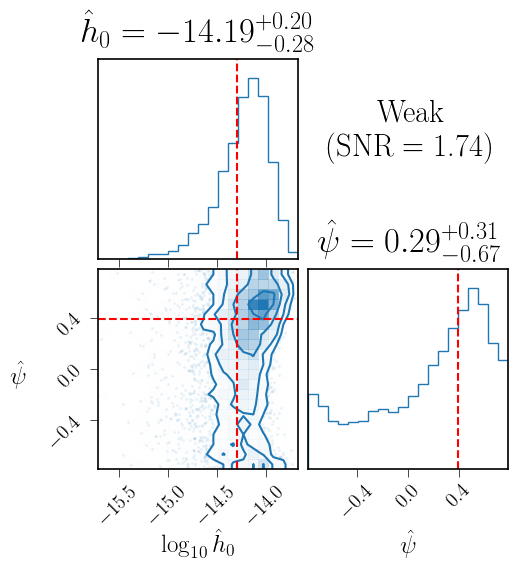

In [81]:
import corner
data = np.array([[maxlike_strains[_i], maxlike_pols[_i]] for _i in range(len(maxlike_strains))])
# print(data)

corner_fig = corner.corner(data, color='tab:blue', histtype='step',labels=[r'$\log_{10}\hat{h}_0$', r'$\hat{\psi}$'])

axs = corner_fig.get_axes()
axs[0].axvline(injected_strain, ls='--', color='red')
axs[2].axvline(injected_strain, ls='--', color='red')
axs[2].axhline(injected_pol, ls='--', color='red')
axs[2].set_ylabel(r'$\hat{\psi}$', rotation = 0, y = .40, x = -0.4)
axs[3].axvline(injected_pol, ls='--', color='red')

axs[0].set_title(r'${\hat{h}_0} = -14.19^{+0.20}_{-0.28} $', fontsize=25, y=1.04)
axs[3].set_title(r'$\hat{\psi} = 0.29^{+0.31}_{-0.67} $', fontsize=25, y=1.04)
opt_snr = np.mean(maxlike_ncs)
mysuptitle = plt.suptitle("Weak\n(SNR = {:.02f})".format(opt_snr), y = 0.85, x=0.75, fontsize=22)
# mysuptitle = plt.suptitle("Intermediate Signal\n" +r"($\log_{10}{A_{\mathrm{RN}}} = $" +  "{:.02f})".format(np.log10(rn_amp))+ "\n"+ r"($\log_{10}{A_{\mathrm{bwm}}} = $" +  "{:.02f})".format(injected_strain), fontsize=18, y=1.15)

plt.savefig('/home/nima/nanograv/bwm_fpfe/mles_recovery_weakintermediate.pdf', bbox_inches='tight', bbox_extra_artists=[mysuptitle])
# plt.suptitle("Maximum Likelihood Parameter Recovery", y = 1.04, ha= 'center', fontsize = 16, )
plt.show()

# Intermediate Strong (SNR ~ 4.5)

In [4]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []
psr_locs = np.loadtxt(psrloc_path)


rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = np.pi/8
log10_h = np.log10(8.5e-15)
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute RN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute RN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    

NameError: name 'psrloc_path' is not defined

In [42]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    nc_estimate = 0    
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]

        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series + bwm_signals[ipsr]
        prefit_resids =  wn_series + rn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr]

        # prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        # prefit_resids = wn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc

        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        

        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     
        
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    M_pinv = np.linalg.pinv(M)
    
    bp = M_pinv[0,0] * Np + M_pinv[0,1] * Nc
    bc = M_pinv[1,0] * Np + M_pinv[1,1] * Nc
    

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe, nc_estimate, bp, bc

In [43]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fe_worker, args)

results = np.array(results)
# print(results)
estimated_ncs = results[:,1]
fe_bs = results[:, (0,2,3)]

outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_snr4bwm_piby8_polarized_verbose.txt'
np.savetxt(outfile, fe_bs)

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_snr4bwm_ncs_piby8_polarized.txt'
np.savetxt(nc_outfile, estimated_ncs)

Finished iteration 756 in 5.3s. Fe = 11.845375110180221
Finished iteration 336 in 5.9s. Fe = 4.105188484319062Finished iteration 588 in 6.0s. Fe = 5.223747776705544
Finished iteration 504 in 6.0s. Fe = 4.196226103635682

Finished iteration 168 in 6.1s. Fe = 4.811731216374795
Finished iteration 84 in 6.2s. Fe = 7.567656873605827
Finished iteration 672 in 7.9s. Fe = 20.207287310476676
Finished iteration 1008 in 8.1s. Fe = 3.2334724869072393
Finished iteration 420 in 8.9s. Fe = 3.8381743644578616
Finished iteration 924 in 9.3s. Fe = 10.294774994361237
Finished iteration 252 in 9.6s. Fe = 12.580140015366798
Finished iteration 0 in 10.4s. Fe = 0.37998177923233667
Finished iteration 1176 in 10.7s. Fe = 2.2206686342540234
Finished iteration 840 in 10.9s. Fe = 1.3596453400224358
Finished iteration 1092 in 11.6s. Fe = 8.694299790024587
Finished iteration 757 in 6.8s. Fe = 4.11490101357745
Finished iteration 505 in 7.3s. Fe = 2.87623102029427
Finished iteration 337 in 7.4s. Fe = 1.88175089371965

Finished iteration 1110 in 9.7s. Fe = 5.742387929271279
Finished iteration 523 in 10.8s. Fe = 10.465308488586414
Finished iteration 443 in 8.2s. Fe = 3.7955353729740287
Finished iteration 188 in 5.9s. Fe = 5.954939375338132
Finished iteration 776 in 8.4s. Fe = 1.3129602714084438Finished iteration 1028 in 6.5s. Fe = 10.491347595469897

Finished iteration 18 in 11.6s. Fe = 7.096091837591446
Finished iteration 357 in 10.4s. Fe = 1.2028457551685752
Finished iteration 271 in 11.1s. Fe = 2.039513574885009
Finished iteration 860 in 5.9s. Fe = 9.19552656337611
Finished iteration 102 in 7.3s. Fe = 2.6948482138864884
Finished iteration 943 in 8.7s. Fe = 12.0415065623508
Finished iteration 690 in 12.6s. Fe = 13.073432042327571
Finished iteration 444 in 5.5s. Fe = 6.861704301484558
Finished iteration 777 in 3.8s. Fe = 9.16094876002307
Finished iteration 607 in 9.5s. Fe = 2.188756902640756
Finished iteration 272 in 3.7s. Fe = 4.624176067445391
Finished iteration 1029 in 5.2s. Fe = 4.947046268661856

Finished iteration 542 in 9.2s. Fe = 3.5156209338573716
Finished iteration 1216 in 9.9s. Fe = 17.039931187656443
Finished iteration 291 in 9.4s. Fe = 2.276034648397909
Finished iteration 626 in 9.4s. Fe = 2.635597692757262
Finished iteration 1129 in 10.2s. Fe = 3.5247704901756496Finished iteration 210 in 10.6s. Fe = 6.3675741483344135

Finished iteration 963 in 9.0s. Fe = 5.57313351257488
Finished iteration 1046 in 11.1s. Fe = 13.996712874365132
Finished iteration 119 in 9.6s. Fe = 12.653347419809776Finished iteration 462 in 9.8s. Fe = 20.127599844785408

Finished iteration 1217 in 2.5s. Fe = 23.40456554430891
Finished iteration 38 in 9.1s. Fe = 2.615145243520516
Finished iteration 711 in 7.2s. Fe = 5.212628244674179
Finished iteration 378 in 10.6s. Fe = 9.568077507849784
Finished iteration 627 in 4.0s. Fe = 7.162197028614632
Finished iteration 39 in 2.3s. Fe = 4.410156814741461
Finished iteration 797 in 8.8s. Fe = 7.58147692074218
Finished iteration 543 in 6.2s. Fe = 2.635474891543733

Finished iteration 983 in 7.8s. Fe = 4.369037533495667
Finished iteration 559 in 9.6s. Fe = 2.3285551357382963
Finished iteration 1146 in 10.8s. Fe = 0.48164864903223265
Finished iteration 730 in 10.6s. Fe = 9.563991148912026
Finished iteration 57 in 8.6s. Fe = 10.470554825745605
Finished iteration 1067 in 9.7s. Fe = 11.651650920102076
Finished iteration 815 in 10.6s. Fe = 4.809983502920625
Finished iteration 1235 in 5.3s. Fe = 10.331352491770575
Finished iteration 483 in 8.2s. Fe = 5.378043040040453
Finished iteration 1147 in 3.3s. Fe = 7.5918091291883005Finished iteration 232 in 9.1s. Fe = 9.975005631258252

Finished iteration 984 in 6.5s. Fe = 6.689466225106047
Finished iteration 138 in 10.0s. Fe = 5.335479449374407
Finished iteration 897 in 10.5s. Fe = 3.2983868196929405
Finished iteration 310 in 11.1s. Fe = 6.001562179254764
Finished iteration 400 in 9.0s. Fe = 12.197661956305057
Finished iteration 649 in 9.8s. Fe = 1.1004632565817851
Finished iteration 560 in 8.8s. Fe = 6.1156996

Finished iteration 579 in 3.2s. Fe = 16.507695537804523
Finished iteration 502 in 3.9s. Fe = 16.793228181222702
Finished iteration 329 in 4.5s. Fe = 13.35345396984415Finished iteration 156 in 10.9s. Fe = 0.7886213538677432

Finished iteration 835 in 7.3s. Fe = 5.692087962136856
Finished iteration 1087 in 8.0s. Fe = 5.65540811320567
Finished iteration 1004 in 8.0s. Fe = 12.42803802944163
Finished iteration 1260 in 6.5s. Fe = 13.172829793972454
Finished iteration 750 in 5.7s. Fe = 23.865581838653874
Finished iteration 77 in 11.0s. Fe = 10.425073834790265
Finished iteration 1168 in 8.9s. Fe = 4.254733348954499
Finished iteration 915 in 9.9s. Fe = 2.027551297826677
Finished iteration 1261 in 3.7s. Fe = 7.730469130110334
Finished iteration 580 in 7.9s. Fe = 6.458775732941825
Finished iteration 751 in 2.7s. Fe = 5.6813489424209305
Finished iteration 418 in 10.0s. Fe = 12.340450427172623
Finished iteration 836 in 8.2s. Fe = 15.034327930280739Finished iteration 668 in 10.6s. Fe = 5.70162996526

Finished iteration 1694 in 6.1s. Fe = 2.2794447895362575Finished iteration 2444 in 6.4s. Fe = 6.779116111438466
Finished iteration 2029 in 4.0s. Fe = 5.522658786904193

Finished iteration 1280 in 6.6s. Fe = 5.692150265011137
Finished iteration 2279 in 9.7s. Fe = 20.555223245520295
Finished iteration 2196 in 7.9s. Fe = 8.166328524657299
Finished iteration 1610 in 6.6s. Fe = 8.42421406227318
Finished iteration 1862 in 6.4s. Fe = 3.367115175351273
Finished iteration 2363 in 6.3s. Fe = 7.2636600647308445
Finished iteration 1695 in 3.4s. Fe = 8.41685303462108
Finished iteration 2445 in 3.8s. Fe = 5.136799075216362
Finished iteration 1945 in 10.2s. Fe = 13.706080811841652
Finished iteration 1281 in 3.7s. Fe = 9.958348616630502
Finished iteration 1778 in 6.3s. Fe = 14.052429434262407
Finished iteration 1526 in 8.8s. Fe = 6.277518697762253
Finished iteration 2110 in 7.2s. Fe = 2.1328922002992368
Finished iteration 2446 in 3.7s. Fe = 5.424399468127762
Finished iteration 1445 in 10.4s. Fe = 4.62

Finished iteration 1628 in 4.7s. Fe = 1.7559053608930286
Finished iteration 2298 in 9.7s. Fe = 0.6782988327071032
Finished iteration 2128 in 4.1s. Fe = 7.116850684726217
Finished iteration 2383 in 5.8s. Fe = 14.482943357584338
Finished iteration 2217 in 6.1s. Fe = 2.083027286643331
Finished iteration 2462 in 7.6s. Fe = 8.440513226691802
Finished iteration 1546 in 5.1s. Fe = 5.935425496778095
Finished iteration 1714 in 6.5s. Fe = 3.2045308803276207
Finished iteration 1881 in 6.7s. Fe = 7.2159334364511825
Finished iteration 2299 in 2.7s. Fe = 1.4857754192730417
Finished iteration 1462 in 7.0s. Fe = 15.528338362508958
Finished iteration 2049 in 7.0s. Fe = 4.935011442143006
Finished iteration 1386 in 5.3s. Fe = 9.681521532289638
Finished iteration 1963 in 5.6s. Fe = 9.797637933446913
Finished iteration 1299 in 10.9s. Fe = 1.7608935148842584
Finished iteration 1629 in 6.9s. Fe = 8.445890817067419
Finished iteration 1797 in 8.7s. Fe = 8.903212493049088
Finished iteration 1463 in 4.0s. Fe = 1

Finished iteration 2482 in 7.9s. Fe = 0.11541708147152208
Finished iteration 1984 in 7.3s. Fe = 4.054613543212975Finished iteration 1816 in 8.2s. Fe = 4.211354070211613

Finished iteration 1647 in 7.6s. Fe = 7.653723692261531
Finished iteration 1899 in 3.6s. Fe = 8.995879230895225
Finished iteration 1480 in 7.7s. Fe = 9.376938223436834
Finished iteration 1405 in 8.9s. Fe = 5.745459063201362
Finished iteration 1319 in 7.6s. Fe = 11.039149790031246
Finished iteration 2319 in 6.6s. Fe = 4.636782277667493
Finished iteration 1563 in 6.3s. Fe = 4.0855045288187
Finished iteration 2235 in 9.0s. Fe = 0.21963357334944061
Finished iteration 1900 in 4.3s. Fe = 9.43318402421399
Finished iteration 2068 in 8.4s. Fe = 7.136553129207521
Finished iteration 1733 in 9.6s. Fe = 5.709800250611842
Finished iteration 2148 in 8.9s. Fe = 0.9233661187721778
Finished iteration 2404 in 9.3s. Fe = 8.92179165148478
Finished iteration 1817 in 8.7s. Fe = 1.441396203998452
Finished iteration 1985 in 8.9s. Fe = 6.307337

Finished iteration 1668 in 4.4s. Fe = 5.969351480849023
Finished iteration 2003 in 11.1s. Fe = 5.0505135764071865
Finished iteration 2425 in 4.9s. Fe = 10.692315092038466
Finished iteration 2166 in 9.2s. Fe = 3.8368561216850474
Finished iteration 1582 in 9.6s. Fe = 3.447008390346307
Finished iteration 1920 in 13.1s. Fe = 0.16891360135630273Finished iteration 2086 in 11.8s. Fe = 5.076728323231903

Finished iteration 1501 in 8.1s. Fe = 11.362983728368345
Finished iteration 2336 in 8.1s. Fe = 5.286424523218267
Finished iteration 1750 in 12.9s. Fe = 5.455539801637897
Finished iteration 1338 in 6.0s. Fe = 3.799514983525563
Finished iteration 1836 in 10.8s. Fe = 18.29945738287521
Finished iteration 2254 in 9.3s. Fe = 0.07538000687311691
Finished iteration 2502 in 6.3s. Fe = 14.182405470341116
Finished iteration 1425 in 8.7s. Fe = 3.976817075380918
Finished iteration 1669 in 7.1s. Fe = 10.363851601422857
Finished iteration 2004 in 7.6s. Fe = 5.455568713977629Finished iteration 1502 in 6.4s. F

Finished iteration 2538 in 7.1s. Fe = 12.182103009798073
Finished iteration 2863 in 7.2s. Fe = 2.364873469339006
Finished iteration 2616 in 7.5s. Fe = 7.056586858780053
Finished iteration 3113 in 11.5s. Fe = 6.533876206640752
Finished iteration 3614 in 8.5s. Fe = 4.939955069995171
Finished iteration 2519 in 8.6s. Fe = 10.579999340949186
Finished iteration 3282 in 9.5s. Fe = 2.8514027813236904
Finished iteration 3031 in 8.9s. Fe = 1.8249458270622885
Finished iteration 3448 in 9.1s. Fe = 6.822973776738808
Finished iteration 3532 in 9.3s. Fe = 5.52760568529703
Finished iteration 3198 in 6.4s. Fe = 5.334332418003558
Finished iteration 2697 in 8.4s. Fe = 6.233602812847941
Finished iteration 2864 in 7.7s. Fe = 4.869764965560117
Finished iteration 2617 in 8.4s. Fe = 5.6330676617623485
Finished iteration 2947 in 9.2s. Fe = 3.6745527692540336
Finished iteration 3365 in 9.4s. Fe = 5.5610854167271855
Finished iteration 2782 in 11.5s. Fe = 4.211782317896278
Finished iteration 2539 in 10.2s. Fe = 6

Finished iteration 2882 in 4.8s. Fe = 6.7605138448509825
Finished iteration 3382 in 4.4s. Fe = 3.8327255761446697
Finished iteration 3550 in 8.3s. Fe = 9.683795397554674
Finished iteration 3465 in 7.5s. Fe = 6.836154619762257
Finished iteration 3216 in 4.1s. Fe = 9.30686078586816
Finished iteration 2714 in 7.5s. Fe = 5.795855276099488
Finished iteration 2968 in 5.6s. Fe = 9.580235095388762
Finished iteration 3131 in 7.6s. Fe = 8.984659714839292
Finished iteration 3053 in 3.8s. Fe = 5.908019226412665
Finished iteration 2636 in 5.9s. Fe = 9.903217073685814
Finished iteration 3304 in 7.5s. Fe = 3.2494733850689714Finished iteration 2558 in 8.1s. Fe = 19.918959379964733

Finished iteration 3551 in 3.5s. Fe = 8.065751129636709
Finished iteration 3217 in 3.2s. Fe = 14.649627439267535
Finished iteration 2883 in 4.8s. Fe = 7.168258322373154
Finished iteration 3383 in 4.4s. Fe = 5.948667726834315
Finished iteration 3635 in 7.6s. Fe = 1.3191678783357803
Finished iteration 3715 in 7.8s. Fe = 7.321

Finished iteration 3732 in 8.4s. Fe = 15.53541474782185
Finished iteration 3482 in 10.5s. Fe = 4.0118996942089975
Finished iteration 2734 in 9.9s. Fe = 21.119775811758167
Finished iteration 2900 in 5.0s. Fe = 1.76128821582185
Finished iteration 3573 in 8.5s. Fe = 18.041775058378512
Finished iteration 3235 in 5.1s. Fe = 14.010485465381619Finished iteration 2819 in 7.2s. Fe = 3.3486874068477235

Finished iteration 3150 in 4.9s. Fe = 2.4747338965497523
Finished iteration 2987 in 10.4s. Fe = 5.592070690738828
Finished iteration 3323 in 5.5s. Fe = 7.893937205707877
Finished iteration 3403 in 11.5s. Fe = 4.121222336895806
Finished iteration 2579 in 6.5s. Fe = 1.2994011043710163
Finished iteration 3072 in 6.8s. Fe = 2.0403319009909846
Finished iteration 3483 in 5.7s. Fe = 8.470613026938603
Finished iteration 3655 in 7.1s. Fe = 6.012699529322915
Finished iteration 2735 in 5.8s. Fe = 20.92368588855136
Finished iteration 3574 in 5.9s. Fe = 7.185146587768778
Finished iteration 2656 in 9.1s. Fe = 

Finished iteration 3254 in 5.9s. Fe = 7.52245468118738
Finished iteration 2837 in 6.0s. Fe = 5.402267028610888Finished iteration 3594 in 7.0s. Fe = 1.338180328946994

Finished iteration 3751 in 6.8s. Fe = 1.352283727651912
Finished iteration 3342 in 5.1s. Fe = 4.078849102038394
Finished iteration 3091 in 8.5s. Fe = 5.130875683127904
Finished iteration 3005 in 5.7s. Fe = 1.379660730374242
Finished iteration 3169 in 9.8s. Fe = 7.4652745807660015
Finished iteration 3422 in 6.8s. Fe = 1.972187713726988
Finished iteration 2752 in 6.3s. Fe = 7.025005232751846
Finished iteration 3752 in 3.6s. Fe = 13.378374365300159
Finished iteration 3504 in 6.5s. Fe = 4.361331767097209
Finished iteration 2675 in 6.5s. Fe = 3.2089776609063696
Finished iteration 3674 in 6.7s. Fe = 12.327902314638122
Finished iteration 3255 in 6.7s. Fe = 1.0895647281031093Finished iteration 2920 in 6.8s. Fe = 3.030718453673997

Finished iteration 2600 in 10.0s. Fe = 6.186894113952263
Finished iteration 3595 in 7.3s. Fe = 6.370

Finished iteration 3689 in 9.2s. Fe = 10.67700422640534
Finished iteration 3795 in 6.3s. Fe = 4.021372099508118Finished iteration 4369 in 4.5s. Fe = 7.009472787004757
Finished iteration 3187 in 10.0s. Fe = 14.540513283724387

Finished iteration 3951 in 2.2s. Fe = 6.937481158581454
Finished iteration 4284 in 11.0s. Fe = 15.337072861991315
Finished iteration 4370 in 1.6s. Fe = 2.480803118154372
Finished iteration 2939 in 6.1s. Fe = 10.151251679624938
Finished iteration 3868 in 9.5s. Fe = 4.934718002062634
Finished iteration 4452 in 9.3s. Fe = 20.0986658901627
Finished iteration 4035 in 6.5s. Fe = 9.5214306185555
Finished iteration 3952 in 3.4s. Fe = 1.7130189941775678
Finished iteration 3439 in 10.8s. Fe = 7.652202420602458
Finished iteration 4118 in 7.8s. Fe = 6.789673305862946
Finished iteration 4536 in 3.4s. Fe = 4.053874895119438
Finished iteration 3869 in 4.9s. Fe = 6.499511955995932
Finished iteration 4202 in 9.4s. Fe = 10.908635173452174
Finished iteration 3773 in 8.5s. Fe = 8.953

Finished iteration 4304 in 10.2s. Fe = 9.942223478452615Finished iteration 4554 in 4.4s. Fe = 10.594056639609791

Finished iteration 4469 in 11.1s. Fe = 5.735396076217299
Finished iteration 4720 in 8.2s. Fe = 1.5871853231177069
Finished iteration 4221 in 10.5s. Fe = 25.75772768370485
Finished iteration 4968 in 10.7s. Fe = 4.530160546763967
Finished iteration 4884 in 8.6s. Fe = 5.359582103986319
Finished iteration 4389 in 10.8s. Fe = 17.023818104475218
Finished iteration 4801 in 10.5s. Fe = 1.3245317777590127
Finished iteration 3887 in 11.6s. Fe = 2.0940924113376043
Finished iteration 4636 in 8.3s. Fe = 7.472832668588312
Finished iteration 3971 in 8.5s. Fe = 10.874586718592116
Finished iteration 3815 in 7.0s. Fe = 5.991346505088066
Finished iteration 4135 in 7.8s. Fe = 0.12871872446448546
Finished iteration 4054 in 9.2s. Fe = 7.579655981592795
Finished iteration 3816 in 2.0s. Fe = 1.7894786276636436
Finished iteration 4055 in 2.6s. Fe = 2.630426071049098
Finished iteration 4305 in 9.3s.

Finished iteration 3991 in 6.3s. Fe = 5.84159117448232
Finished iteration 4985 in 6.5s. Fe = 5.495474028097645
Finished iteration 4407 in 7.6s. Fe = 8.255058592509599
Finished iteration 4573 in 7.6s. Fe = 3.468155208112573
Finished iteration 4072 in 8.1s. Fe = 3.177443670301341
Finished iteration 4738 in 7.2s. Fe = 5.678456229827432
Finished iteration 4155 in 6.5s. Fe = 4.937548782024302
Finished iteration 4488 in 10.1s. Fe = 1.6661150940216556
Finished iteration 4653 in 11.4s. Fe = 0.2985733171415515
Finished iteration 4156 in 2.1s. Fe = 2.3060102501763886
Finished iteration 4408 in 5.0s. Fe = 13.990015443729915
Finished iteration 4409 in 1.7s. Fe = 4.014731550043487
Finished iteration 4325 in 8.9s. Fe = 9.484168564985618
Finished iteration 4410 in 2.0s. Fe = 11.277017533243734
Finished iteration 4489 in 5.4s. Fe = 4.24175119188315
Finished iteration 3992 in 9.5s. Fe = 3.8760868448247128
Finished iteration 3836 in 11.3s. Fe = 13.481181442880938Finished iteration 4903 in 10.8s. Fe = 10

Finished iteration 4921 in 9.9s. Fe = 1.5342821492674399
Finished iteration 4175 in 9.3s. Fe = 10.349318297509708
Finished iteration 4090 in 5.0s. Fe = 3.5033197420674793
Finished iteration 4843 in 8.9s. Fe = 3.4324441991877728
Finished iteration 4260 in 7.9s. Fe = 3.0652516355372863
Finished iteration 3924 in 9.3s. Fe = 7.053663812164519
Finished iteration 4429 in 4.8s. Fe = 10.20013551252163
Finished iteration 4674 in 10.4s. Fe = 13.565941639024494
Finished iteration 4344 in 9.0s. Fe = 3.2091982064130056
Finished iteration 4011 in 6.3s. Fe = 14.818314337036238
Finished iteration 4758 in 10.9s. Fe = 3.7663969371325945
Finished iteration 4591 in 7.4s. Fe = 4.784397763332318
Finished iteration 4922 in 6.5s. Fe = 3.5865700662845494
Finished iteration 4261 in 4.6s. Fe = 5.73878430590199
Finished iteration 3925 in 5.8s. Fe = 11.980853706077314
Finished iteration 4012 in 3.4s. Fe = 7.516819813609817
Finished iteration 4592 in 3.5s. Fe = 14.539661830522018
Finished iteration 4759 in 3.7s. Fe

Finished iteration 4282 in 6.7s. Fe = 3.4470887488230963
Finished iteration 3945 in 4.7s. Fe = 6.089664140385866
Finished iteration 4113 in 6.7s. Fe = 6.627119066206696
Finished iteration 4777 in 9.6s. Fe = 0.7700696497384875
Finished iteration 4194 in 5.1s. Fe = 6.302130091126686
Finished iteration 4945 in 5.0s. Fe = 7.281554550083694
Finished iteration 4613 in 2.4s. Fe = 1.6875583890522372Finished iteration 4865 in 2.4s. Fe = 17.726187247404546

Finished iteration 4529 in 5.4s. Fe = 8.420286419905887
Finished iteration 4367 in 5.5s. Fe = 9.710051994804765
Finished iteration 4614 in 1.8s. Fe = 0.657803952426358
Finished iteration 3946 in 4.4s. Fe = 3.8252032097331115
Finished iteration 4283 in 4.6s. Fe = 16.588104137568195
Finished iteration 4451 in 6.0s. Fe = 0.5835766955531035
Finished iteration 4114 in 4.9s. Fe = 8.074418684773935
Finished iteration 4698 in 8.2s. Fe = 3.5544266250644174
Finished iteration 4778 in 5.6s. Fe = 5.618371248529975
Finished iteration 4195 in 6.2s. Fe = 12

In [94]:
maxlike_ncs = np.loadtxt("/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_interstrongbwm_ncs_piby8_polarized.txt")
maxlike_output = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_interstrongbwm_piby8_polarized_verbose.txt')

In [97]:
bps = maxlike_output[:,1]
bcs = maxlike_output[:,2]

injected_strain = np.log10(1.5e-14)
injected_pol = np.pi/8

maxlike_strains = np.log10(np.array([np.sqrt(bps[_i]**2 + bcs[_i]**2) for _i in range(len(bps))]))
maxlike_pols = np.array([0.5*np.arctan(bcs[_i]/bps[_i]) for _i in range(len(bps))])


#compute 1-sigma errors
median_strain = np.median(sorted(maxlike_strains))
strain_idx_gap = int(len(maxlike_strains) * .341)
median_idx = int(len(maxlike_strains)/2)
upper_strain = sorted(maxlike_strains)[median_idx + strain_idx_gap]
lower_strain = sorted(maxlike_strains)[median_idx - strain_idx_gap]

median_pol = np.median(sorted(maxlike_pols))
pol_idx_gap = int(len(maxlike_pols) * .341)
median_idx = int(len(maxlike_pols)/2)
upper_pol = sorted(maxlike_pols)[median_idx + pol_idx_gap]
lower_pol = sorted(maxlike_pols)[median_idx - pol_idx_gap]

print(median_strain, median_strain - lower_strain, upper_strain-median_strain)
print(median_pol, median_pol - lower_pol, upper_pol-median_pol)


-13.81425340274749 0.1259994509182949 0.10610017332407473
0.38955269378486435 0.15447705018699992 0.12196378350617743


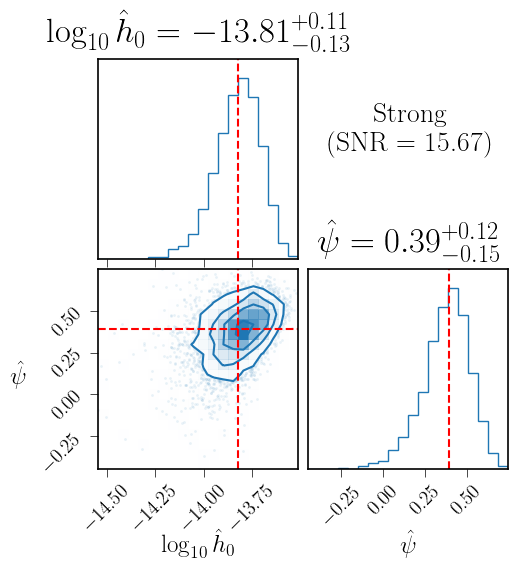

In [100]:
import corner
data = np.array([[maxlike_strains[_i], maxlike_pols[_i]] for _i in range(len(maxlike_strains))])
# print(data)

corner_fig = corner.corner(data, color='tab:blue', histtype='step',labels=[r'$\log_{10}\hat{h}_0$', r'$\hat{\psi}$'])

axs = corner_fig.get_axes()
axs[0].axvline(injected_strain, ls='--', color='red')
axs[2].axvline(injected_strain, ls='--', color='red')
axs[2].axhline(injected_pol, ls='--', color='red')
axs[2].set_ylabel(r'$\hat{\psi}$', rotation = 0, y = .40, x = -0.4)
axs[3].axvline(injected_pol, ls='--', color='red')

axs[0].set_title(r'$\log_{10}{\hat{h}_0} = -13.81^{+0.11}_{-0.13} $', fontsize=25, y=1.04)
axs[3].set_title(r'$\hat{\psi} = 0.39^{+0.12}_{-0.15} $', fontsize=25, y=1.04)
opt_snr = np.mean(maxlike_ncs)
mysuptitle = plt.suptitle("Strong\n(SNR = {:.02f})".format(opt_snr), y = 0.85, x=0.75, fontsize=20)
# mysuptitle = plt.suptitle("Intermediate Signal\n" +r"($\log_{10}{A_{\mathrm{RN}}} = $" +  "{:.02f})".format(np.log10(rn_amp))+ "\n"+ r"($\log_{10}{A_{\mathrm{bwm}}} = $" +  "{:.02f})".format(injected_strain), fontsize=18, y=1.15)

plt.savefig('/home/nima/nanograv/bwm_fpfe/mles_recovery_strong.pdf', bbox_inches='tight', bbox_extra_artists=[mysuptitle])
# plt.suptitle("Maximum Likelihood Parameter Recovery", y = 1.04, ha= 'center', fontsize = 16, )
plt.show()

# Max Likely amplitude and polarization recovery
### Strong signal (log10_A = -13.5, log10_Airn in [-17,-14])

In [23]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []
prefit_irn_covs = []
irn_amps = []
irn_gammas = []
psr_locs = np.loadtxt(psrloc_path)


rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = np.pi/8
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute cRN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute cRN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    
     # =====================================
    # Compute iRN Cov
    # =====================================

    irn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    irn_freqs = np.arange(1, 301) * irn_f0
    
    irn_amp = 10**np.random.uniform(-17,-14.5)
    irn_amps.append(irn_amp)
    irn_gamma = np.random.uniform(2,6)
    irn_gammas.append(irn_gamma)
    
    psd = compute_redpsd(irn_amp, irn_gamma, irn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    irn_cov = hasens.corr_from_psd(irn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute iRN Cov
    # ===================================== 
    prefit_irn_covs.append(irn_cov)
    

In [24]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    nc_estimate = 0    
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]
        irn_series = create_rn_timseries(base_long_toases[ipsr], irn_amps[ipsr], irn_gammas[ipsr], components=300)[:len(base_toases[ipsr])]
        
        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series + irn_series + bwm_signals[ipsr]
        prefit_resids =  wn_series + rn_series + irn_series + bwm_signals[ipsr]
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr] + prefit_irn_covs[ipsr]

        # prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        # prefit_resids = wn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc

        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        

        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     
        
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    M_pinv = np.linalg.pinv(M)
    
    bp = M_pinv[0,0] * Np + M_pinv[0,1] * Nc
    bc = M_pinv[1,0] * Np + M_pinv[1,1] * Nc
    

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe, nc_estimate, bp, bc

In [25]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fe_worker, args)

results = np.array(results)
# print(results)
estimated_ncs = results[:,1]
fe_bs = results[:, (0,2,3)]

outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_irn_strongbwm_piby8_polarized_verbose.txt'
np.savetxt(outfile, fe_bs)

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_irn_strongbwm_ncs_piby8_polarized.txt'
np.savetxt(nc_outfile, estimated_ncs)

Finished iteration 840 in 6.8s. Fe = 65.3868640194789
Finished iteration 1092 in 6.9s. Fe = 61.99528592106561
Finished iteration 504 in 7.2s. Fe = 38.18954454061165
Finished iteration 1176 in 7.3s. Fe = 67.60142450314359
Finished iteration 336 in 8.5s. Fe = 45.1812851860994
Finished iteration 588 in 8.9s. Fe = 53.87752862109939
Finished iteration 84 in 9.7s. Fe = 77.74579604863904
Finished iteration 924 in 9.9s. Fe = 61.9207269262788
Finished iteration 1008 in 10.6s. Fe = 42.226070382399
Finished iteration 168 in 10.8s. Fe = 79.35601713048304
Finished iteration 672 in 10.9s. Fe = 51.03448776186771Finished iteration 252 in 10.9s. Fe = 74.76992827553003Finished iteration 420 in 10.9s. Fe = 57.08916081123958


Finished iteration 0 in 11.0s. Fe = 94.99368999728675
Finished iteration 756 in 11.1s. Fe = 69.90844875774329
Finished iteration 841 in 8.8s. Fe = 38.57097938692779
Finished iteration 1093 in 8.9s. Fe = 91.44265170034218
Finished iteration 1177 in 9.0s. Fe = 76.88179670491252
Finish

Finished iteration 439 in 10.7s. Fe = 55.934400724393726
Finished iteration 1195 in 10.5s. Fe = 100.3918384006011
Finished iteration 355 in 10.6s. Fe = 51.08380846780883
Finished iteration 19 in 10.5s. Fe = 68.84711890749328
Finished iteration 272 in 10.2s. Fe = 52.38899343972378
Finished iteration 691 in 11.1s. Fe = 66.69929461190877
Finished iteration 187 in 10.5s. Fe = 77.44949337092984
Finished iteration 944 in 9.8s. Fe = 35.943145335463896
Finished iteration 1112 in 10.5s. Fe = 51.620362246753515
Finished iteration 104 in 10.7s. Fe = 60.98068664017604
Finished iteration 524 in 10.5s. Fe = 74.62578401555585
Finished iteration 608 in 10.6s. Fe = 62.69198450945963
Finished iteration 440 in 9.8s. Fe = 67.40458049854746
Finished iteration 775 in 10.8s. Fe = 58.936176388312774
Finished iteration 860 in 10.6s. Fe = 44.78830494614789
Finished iteration 1028 in 10.7s. Fe = 59.99002079892613
Finished iteration 356 in 10.0s. Fe = 87.93747561081769
Finished iteration 1196 in 10.4s. Fe = 50.85

Finished iteration 206 in 10.4s. Fe = 58.825920645370225
Finished iteration 38 in 10.9s. Fe = 87.19806869765883
Finished iteration 1131 in 10.4s. Fe = 70.63884485668522
Finished iteration 1215 in 10.0s. Fe = 80.22841040771365
Finished iteration 627 in 10.7s. Fe = 40.06562610626399
Finished iteration 794 in 10.8s. Fe = 81.13902975427067
Finished iteration 543 in 11.2s. Fe = 79.98850458192496
Finished iteration 124 in 10.3s. Fe = 64.35654941241056
Finished iteration 879 in 10.4s. Fe = 81.34937196657295
Finished iteration 1047 in 8.8s. Fe = 106.60603995398868
Finished iteration 459 in 9.7s. Fe = 57.51237163139241
Finished iteration 711 in 10.1s. Fe = 76.70731705493685
Finished iteration 964 in 10.6s. Fe = 63.95487878385528
Finished iteration 39 in 8.8s. Fe = 68.63563685291751
Finished iteration 375 in 10.8s. Fe = 59.5046501475822
Finished iteration 292 in 10.9s. Fe = 57.04178931815869
Finished iteration 207 in 10.1s. Fe = 78.59544793662255
Finished iteration 1132 in 10.6s. Fe = 65.8005649

Finished iteration 143 in 11.0s. Fe = 60.63232459880801
Finished iteration 646 in 10.9s. Fe = 61.99432186776123
Finished iteration 394 in 9.9s. Fe = 50.887327810853726
Finished iteration 983 in 10.2s. Fe = 88.43683422871509
Finished iteration 1066 in 10.6s. Fe = 65.6272813301706
Finished iteration 898 in 10.9s. Fe = 47.04905928830731
Finished iteration 479 in 9.5s. Fe = 71.03035581233016
Finished iteration 226 in 10.7s. Fe = 91.54788385035974
Finished iteration 58 in 9.7s. Fe = 86.77564437890217
Finished iteration 1151 in 10.7s. Fe = 63.92044006562912
Finished iteration 563 in 11.0s. Fe = 51.78282977075533
Finished iteration 1235 in 10.9s. Fe = 65.80741199529797
Finished iteration 814 in 8.9s. Fe = 60.35563952647108
Finished iteration 311 in 10.6s. Fe = 62.09285019373111
Finished iteration 730 in 11.1s. Fe = 70.19444883273798
Finished iteration 899 in 7.1s. Fe = 62.35834981805935Finished iteration 144 in 10.0s. Fe = 55.95361044221421

Finished iteration 647 in 10.5s. Fe = 63.5472916203

Finished iteration 245 in 11.0s. Fe = 69.07905193525849
Finished iteration 1085 in 10.5s. Fe = 56.39064622768622
Finished iteration 917 in 10.3s. Fe = 45.1825300138399
Finished iteration 1170 in 10.6s. Fe = 82.45178440464005
Finished iteration 1254 in 11.0s. Fe = 59.20686419460981
Finished iteration 749 in 10.3s. Fe = 103.63559873918375
Finished iteration 666 in 10.1s. Fe = 75.54649550434357
Finished iteration 582 in 9.7s. Fe = 51.8889949765309
Finished iteration 78 in 10.9s. Fe = 62.53383218567433
Finished iteration 163 in 9.7s. Fe = 53.05401526231096
Finished iteration 414 in 10.2s. Fe = 54.103654825733344
Finished iteration 499 in 9.2s. Fe = 67.6759148910341
Finished iteration 833 in 10.2s. Fe = 40.232628316248196
Finished iteration 1086 in 9.3s. Fe = 75.79629537513912
Finished iteration 331 in 10.6s. Fe = 62.26530910796595
Finished iteration 1003 in 11.0s. Fe = 85.17767801710478
Finished iteration 918 in 9.9s. Fe = 86.13410895896513
Finished iteration 246 in 11.2s. Fe = 57.05079405

Finished iteration 1609 in 11.2s. Fe = 43.424334324959204
Finished iteration 2112 in 10.5s. Fe = 73.49673819307878
Finished iteration 2448 in 10.2s. Fe = 72.24849654989887
Finished iteration 2196 in 10.5s. Fe = 74.16216110001562
Finished iteration 1945 in 11.0s. Fe = 97.4969556515367
Finished iteration 1777 in 10.5s. Fe = 84.20696805818082
Finished iteration 1274 in 10.5s. Fe = 58.58769199169859
Finished iteration 2364 in 10.6s. Fe = 68.96198800606449
Finished iteration 2281 in 10.9s. Fe = 82.01843163133269
Finished iteration 1862 in 10.8s. Fe = 50.76664595603437
Finished iteration 1358 in 11.0s. Fe = 49.974220280002044
Finished iteration 2029 in 10.7s. Fe = 80.88001323911473
Finished iteration 1694 in 10.7s. Fe = 74.19617564472051
Finished iteration 1443 in 10.1s. Fe = 88.39922586221398
Finished iteration 1526 in 10.8s. Fe = 72.06918830504014
Finished iteration 1946 in 9.1s. Fe = 38.93550656875642
Finished iteration 1778 in 9.2s. Fe = 56.152677243366085
Finished iteration 1275 in 8.7s

Finished iteration 2467 in 10.9s. Fe = 66.84418588039804
Finished iteration 2215 in 9.9s. Fe = 62.706451682016386
Finished iteration 2383 in 10.2s. Fe = 116.2427551976787
Finished iteration 1881 in 11.4s. Fe = 49.7599176600561
Finished iteration 1377 in 10.6s. Fe = 80.35982080341661
Finished iteration 1964 in 9.9s. Fe = 40.430020956877314
Finished iteration 1293 in 9.4s. Fe = 63.106758047395424
Finished iteration 2048 in 10.6s. Fe = 73.9047498591136
Finished iteration 1545 in 10.5s. Fe = 76.4771049961791
Finished iteration 2300 in 10.6s. Fe = 63.70237014580903
Finished iteration 1797 in 10.0s. Fe = 62.986607678885434
Finished iteration 2131 in 10.8s. Fe = 52.93959370272368
Finished iteration 1462 in 10.1s. Fe = 74.14056807730336
Finished iteration 1713 in 9.5s. Fe = 53.880097546123366
Finished iteration 1629 in 11.2s. Fe = 45.68943174740871
Finished iteration 2468 in 10.5s. Fe = 43.38628202219164
Finished iteration 2384 in 10.0s. Fe = 50.382840571241346
Finished iteration 2216 in 10.3s

Finished iteration 2486 in 9.9s. Fe = 88.54784060265672
Finished iteration 1564 in 9.7s. Fe = 84.03600834828872
Finished iteration 1396 in 10.3s. Fe = 88.01556621971204
Finished iteration 1816 in 9.9s. Fe = 60.7960899160322
Finished iteration 1900 in 10.3s. Fe = 80.60856090534861
Finished iteration 2067 in 10.9s. Fe = 52.64093766617063
Finished iteration 2150 in 10.1s. Fe = 96.87753306692251
Finished iteration 1481 in 10.8s. Fe = 46.811881430426595
Finished iteration 1983 in 11.1s. Fe = 78.4218000355001
Finished iteration 1732 in 10.8s. Fe = 80.01393977481786
Finished iteration 1313 in 9.4s. Fe = 58.435001454230886
Finished iteration 2235 in 10.3s. Fe = 71.52423928258507
Finished iteration 1648 in 10.8s. Fe = 43.29484627356276
Finished iteration 2319 in 10.1s. Fe = 60.13893687518277
Finished iteration 2487 in 10.0s. Fe = 33.9351656059347
Finished iteration 2403 in 11.5s. Fe = 39.28574671842634
Finished iteration 1565 in 10.5s. Fe = 38.535446236878386
Finished iteration 1817 in 9.9s. Fe

Finished iteration 2421 in 10.6s. Fe = 61.42731714218805Finished iteration 2169 in 10.5s. Fe = 63.512762019535465

Finished iteration 1666 in 10.7s. Fe = 66.36781621348815
Finished iteration 2337 in 10.8s. Fe = 59.378606584939064
Finished iteration 1500 in 10.7s. Fe = 57.68487541281546
Finished iteration 1919 in 10.5s. Fe = 97.78646916038166
Finished iteration 2002 in 10.3s. Fe = 33.63016136524222
Finished iteration 2086 in 10.9s. Fe = 64.90842579415904
Finished iteration 1751 in 10.4s. Fe = 45.403419599508254
Finished iteration 1332 in 10.3s. Fe = 78.77911652331589
Finished iteration 2506 in 10.5s. Fe = 83.40438181116349Finished iteration 1416 in 10.8s. Fe = 45.996818034253344

Finished iteration 1836 in 9.7s. Fe = 39.30033308772575
Finished iteration 2254 in 10.0s. Fe = 100.86643429892429
Finished iteration 1584 in 10.5s. Fe = 75.6898856416253
Finished iteration 2422 in 9.7s. Fe = 85.80899040391418
Finished iteration 2170 in 9.9s. Fe = 64.24728673322697
Finished iteration 1667 in 10.

Finished iteration 2946 in 10.2s. Fe = 105.77148959597996
Finished iteration 3532 in 10.2s. Fe = 38.607219992660106
Finished iteration 3281 in 10.1s. Fe = 84.46542435470874
Finished iteration 3616 in 10.7s. Fe = 55.27412978827014
Finished iteration 3365 in 10.8s. Fe = 71.75029669627219
Finished iteration 3700 in 10.9s. Fe = 84.10739638042924
Finished iteration 3198 in 10.9s. Fe = 82.60611975095213
Finished iteration 2527 in 10.2s. Fe = 28.507243490135203
Finished iteration 3114 in 10.4s. Fe = 70.72581187418353
Finished iteration 3030 in 10.8s. Fe = 82.6673488736102
Finished iteration 2779 in 9.5s. Fe = 74.75756860222033
Finished iteration 3449 in 10.8s. Fe = 78.20420460436247
Finished iteration 2695 in 9.8s. Fe = 75.21533116826156
Finished iteration 2611 in 10.6s. Fe = 43.08237983104434
Finished iteration 2863 in 10.6s. Fe = 40.69818147688122
Finished iteration 2947 in 10.9s. Fe = 65.45741176071179
Finished iteration 3533 in 11.0s. Fe = 43.71248182992891
Finished iteration 3282 in 10.5

Finished iteration 2546 in 10.4s. Fe = 66.84419789241765
Finished iteration 3635 in 10.9s. Fe = 45.926489937576655
Finished iteration 2714 in 9.7s. Fe = 61.832796641011576
Finished iteration 3384 in 10.6s. Fe = 88.91865820941388
Finished iteration 3217 in 10.5s. Fe = 49.610495208747935
Finished iteration 2630 in 10.7s. Fe = 80.29909915508978
Finished iteration 3301 in 10.0s. Fe = 61.17932130041575
Finished iteration 3049 in 10.1s. Fe = 66.56202438521353
Finished iteration 3468 in 11.0s. Fe = 75.84696346613002
Finished iteration 3133 in 10.6s. Fe = 59.34794449778376
Finished iteration 2798 in 9.9s. Fe = 91.43260855282706
Finished iteration 3719 in 10.8s. Fe = 67.19208516990464
Finished iteration 2966 in 9.9s. Fe = 47.13542293791659
Finished iteration 3552 in 10.9s. Fe = 58.36461473442468
Finished iteration 2882 in 10.8s. Fe = 81.44064345718873
Finished iteration 2547 in 9.8s. Fe = 79.2923408069
Finished iteration 2715 in 10.0s. Fe = 91.21420246124497
Finished iteration 3636 in 11.2s. Fe

Finished iteration 2733 in 10.4s. Fe = 91.49340702993483
Finished iteration 3738 in 10.6s. Fe = 41.218270008695164
Finished iteration 2565 in 11.2s. Fe = 91.02765313325955
Finished iteration 3487 in 11.1s. Fe = 69.16010531407687
Finished iteration 3068 in 9.7s. Fe = 64.21752485809799
Finished iteration 3152 in 10.1s. Fe = 50.01047536264892
Finished iteration 2649 in 10.9s. Fe = 48.75688255909544
Finished iteration 3571 in 10.9s. Fe = 74.14647657852011
Finished iteration 3236 in 10.8s. Fe = 52.444674774944986
Finished iteration 2901 in 10.7s. Fe = 65.7620519848194
Finished iteration 3404 in 10.1s. Fe = 77.4477759428045
Finished iteration 2817 in 10.8s. Fe = 60.6933362525249
Finished iteration 2985 in 10.5s. Fe = 39.97541928620842
Finished iteration 3655 in 10.9s. Fe = 63.50348227432475
Finished iteration 3321 in 10.2s. Fe = 84.04452558772697
Finished iteration 3739 in 9.2s. Fe = 61.93053239198671
Finished iteration 3488 in 9.4s. Fe = 67.38498132280824
Finished iteration 2734 in 10.8s. F

Finished iteration 3087 in 10.4s. Fe = 44.53288893794844
Finished iteration 2753 in 9.8s. Fe = 69.03608993662903
Finished iteration 3506 in 9.4s. Fe = 90.73717820264119
Finished iteration 2584 in 10.6s. Fe = 67.50339796940158
Finished iteration 3255 in 10.1s. Fe = 109.64719321479743
Finished iteration 3423 in 10.8s. Fe = 66.2311863454101
Finished iteration 3004 in 9.9s. Fe = 94.72297932979774
Finished iteration 2668 in 9.8s. Fe = 62.844862154773445
Finished iteration 3590 in 10.7s. Fe = 101.61144570947013
Finished iteration 3340 in 10.6s. Fe = 54.84244240726949
Finished iteration 3674 in 10.4s. Fe = 78.78750523715803Finished iteration 2836 in 10.7s. Fe = 53.384362155111766

Finished iteration 3758 in 11.1s. Fe = 62.52681728859953
Finished iteration 3172 in 9.8s. Fe = 29.593838350643754
Finished iteration 2920 in 10.9s. Fe = 64.60434201689458
Finished iteration 2754 in 9.8s. Fe = 93.77304317873839
Finished iteration 3088 in 10.9s. Fe = 54.29466132924562
Finished iteration 3507 in 10.0s.

Finished iteration 3106 in 11.1s. Fe = 32.07914270863863
Finished iteration 2687 in 10.6s. Fe = 78.37101198592606
Finished iteration 3274 in 10.8s. Fe = 75.9185064640893
Finished iteration 3359 in 10.8s. Fe = 69.84380209941527
Finished iteration 3442 in 9.5s. Fe = 37.37031606556272
Finished iteration 3023 in 10.7s. Fe = 50.00467345096628
Finished iteration 3864 in 10.4s. Fe = 74.32374287342368
Finished iteration 2939 in 10.6s. Fe = 58.07024361470322
Finished iteration 3693 in 10.5s. Fe = 60.50019090740582
Finished iteration 3777 in 10.6s. Fe = 40.118422183397534
Finished iteration 2855 in 10.7s. Fe = 50.500248383664264
Finished iteration 3191 in 10.4s. Fe = 65.67444632594805
Finished iteration 3526 in 10.6s. Fe = 63.596596695166525
Finished iteration 3609 in 10.5s. Fe = 68.18219774896858
Finished iteration 3781 in 10.8s. Fe = 94.10896426996231
Finished iteration 3107 in 10.5s. Fe = 48.14983934116347
Finished iteration 3948 in 10.4s. Fe = 86.85588437096274
Finished iteration 3275 in 10.

Finished iteration 4971 in 10.1s. Fe = 51.114812462808054
Finished iteration 3799 in 10.3s. Fe = 72.0908943305217
Finished iteration 4469 in 10.4s. Fe = 82.13110425929248
Finished iteration 4888 in 10.5s. Fe = 72.5905829250326
Finished iteration 4302 in 10.8s. Fe = 45.20245089896436
Finished iteration 4553 in 10.5s. Fe = 52.262496667138194
Finished iteration 4637 in 10.6s. Fe = 66.95508900329608
Finished iteration 4134 in 10.6s. Fe = 63.83253145742224
Finished iteration 4218 in 9.7s. Fe = 72.64080050328351
Finished iteration 4386 in 10.7s. Fe = 69.3919349695046
Finished iteration 4721 in 10.0s. Fe = 52.67831865601704
Finished iteration 3967 in 10.7s. Fe = 61.806857385374165
Finished iteration 3883 in 10.8s. Fe = 94.71298257951247
Finished iteration 4972 in 9.3s. Fe = 73.58836983535427
Finished iteration 4051 in 11.0s. Fe = 71.42814675133252Finished iteration 4805 in 11.4s. Fe = 49.55696433585709

Finished iteration 3800 in 9.7s. Fe = 66.99759027081971
Finished iteration 4889 in 10.1s. 

Finished iteration 4740 in 10.9s. Fe = 86.58736860411156
Finished iteration 4656 in 10.9s. Fe = 82.67877452512238
Finished iteration 4907 in 11.0s. Fe = 71.14383192291695
Finished iteration 4572 in 10.0s. Fe = 91.51649019800985
Finished iteration 4488 in 10.2s. Fe = 75.77436520798281
Finished iteration 4824 in 10.5s. Fe = 92.92489258684165
Finished iteration 4991 in 8.9s. Fe = 87.45979186238199
Finished iteration 4153 in 10.6s. Fe = 54.920247237324304
Finished iteration 3902 in 10.7s. Fe = 63.071630977885235
Finished iteration 3986 in 10.8s. Fe = 69.8250312598279
Finished iteration 4322 in 10.9s. Fe = 75.45479146098577
Finished iteration 4405 in 10.6s. Fe = 67.18559221853606
Finished iteration 4237 in 10.7s. Fe = 58.62146047027635
Finished iteration 3819 in 10.4s. Fe = 76.42913557705134
Finished iteration 4070 in 10.3s. Fe = 74.0504738578784
Finished iteration 4741 in 10.5s. Fe = 90.29290508244597
Finished iteration 4657 in 10.1s. Fe = 77.38398145813848
Finished iteration 4908 in 10.3s

Finished iteration 4256 in 10.0s. Fe = 86.78175025544077
Finished iteration 4173 in 9.5s. Fe = 82.13700659055458
Finished iteration 4424 in 9.7s. Fe = 62.91002254690635
Finished iteration 3922 in 10.3s. Fe = 81.84218366885221
Finished iteration 4341 in 10.5s. Fe = 71.79856924394707
Finished iteration 4844 in 10.3s. Fe = 46.963232037239365
Finished iteration 4927 in 9.7s. Fe = 56.7494788302817
Finished iteration 4592 in 10.2s. Fe = 67.31067681560704
Finished iteration 4508 in 10.1s. Fe = 64.00685987578234
Finished iteration 3839 in 10.2s. Fe = 58.638378104052975
Finished iteration 4677 in 9.6s. Fe = 68.55001515972003
Finished iteration 4007 in 9.7s. Fe = 104.19200242405918Finished iteration 4090 in 9.7s. Fe = 90.16351140597486

Finished iteration 4761 in 9.8s. Fe = 76.28777466624199
Finished iteration 4257 in 9.7s. Fe = 53.18783905884122
Finished iteration 4174 in 9.6s. Fe = 60.990717748946984
Finished iteration 4425 in 9.8s. Fe = 77.000795977233
Finished iteration 4342 in 9.8s. Fe = 65

Finished iteration 4613 in 9.9s. Fe = 83.16049957849296
Finished iteration 3943 in 10.0s. Fe = 53.78912201115885Finished iteration 3859 in 10.1s. Fe = 78.13795237235351

Finished iteration 4865 in 9.8s. Fe = 80.04217324347866
Finished iteration 4445 in 10.1s. Fe = 57.50417548290127
Finished iteration 4277 in 10.0s. Fe = 66.04978835513404
Finished iteration 4194 in 10.0s. Fe = 63.86503243435584
Finished iteration 4110 in 10.7s. Fe = 54.362211746644356
Finished iteration 4027 in 10.3s. Fe = 43.07424333838775
Finished iteration 4781 in 9.9s. Fe = 31.52653871903164
Finished iteration 4948 in 10.3s. Fe = 87.2569564352375
Finished iteration 4529 in 9.9s. Fe = 72.83830030108336
Finished iteration 4698 in 9.8s. Fe = 38.18939148865256
Finished iteration 4614 in 9.7s. Fe = 98.03698873289473
Finished iteration 4362 in 10.2s. Fe = 59.49645772981398
Finished iteration 4866 in 9.2s. Fe = 37.516654912475495Finished iteration 3860 in 9.8s. Fe = 25.45012845176736

Finished iteration 3944 in 9.9s. Fe = 

In [26]:
maxlike_ncs = np.loadtxt("/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_irn_strongbwm_ncs_piby8_polarized.txt")
maxlike_output = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_irn_strongbwm_piby8_polarized_verbose.txt')

Using
$$\hat{h_0} = \sqrt{\hat{b}_{+}^2 + \hat{b}_{\times}^2}$$
$$\hat{\psi} = \tan^{-1}\left({\frac{\hat{b}_{\times}}{\hat{b}_{+}}}\right)$$

In [27]:
bps = maxlike_output[:,1]
bcs = maxlike_output[:,2]

injected_strain = -13.5
injected_pol = np.pi/8

maxlike_strains = np.log10(np.array([np.sqrt(bps[_i]**2 + bcs[_i]**2) for _i in range(len(bps))]))
maxlike_pols = np.array([0.5*np.arctan(bcs[_i]/bps[_i]) for _i in range(len(bps))])


#compute 1-sigma errors
median_strain = np.median(sorted(maxlike_strains))
strain_idx_gap = int(len(maxlike_strains) * .341)
median_idx = int(len(maxlike_strains)/2)
upper_strain = sorted(maxlike_strains)[median_idx + strain_idx_gap]
lower_strain = sorted(maxlike_strains)[median_idx - strain_idx_gap]

median_pol = np.median(sorted(maxlike_pols))
pol_idx_gap = int(len(maxlike_pols) * .341)
median_idx = int(len(maxlike_pols)/2)
upper_pol = sorted(maxlike_pols)[median_idx + pol_idx_gap]
lower_pol = sorted(maxlike_pols)[median_idx - pol_idx_gap]

print(median_strain, median_strain - lower_strain, upper_strain-median_strain)
print(median_pol, median_pol - lower_pol, upper_pol-median_pol)


-13.494843807512538 0.0632143530690108 0.055358702927090775
0.39158374825319875 0.07190453402962305 0.06642416207749219


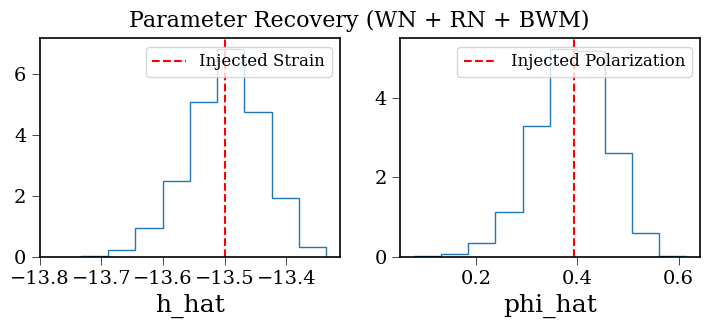

In [28]:
fig, axs = plt.subplots(1, 2)

# Strain recovery
strain_ax = axs[0]
strain_ax.hist(maxlike_strains, histtype='step', density=True)
strain_ax.set_xlabel("h_hat")
strain_ax.axvline(injected_strain, color='red', ls='--', label='Injected Strain')
strain_ax.legend()

pol_ax = axs[1]
pol_ax.hist(maxlike_pols, histtype='step', density=True)
pol_ax.set_xlabel("phi_hat")
pol_ax.axvline(injected_pol, color='red', ls='--', label='Injected Polarization')
pol_ax.legend()

plt.suptitle("Parameter Recovery (WN + RN + BWM)", fontsize=16)
plt.show()

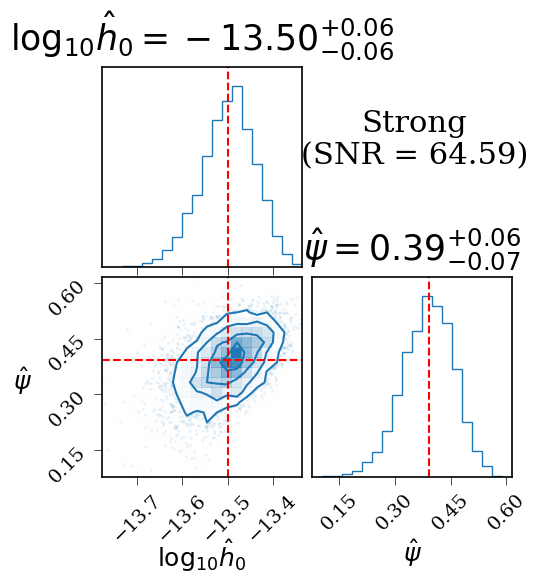

In [29]:
import corner
data = np.array([[maxlike_strains[_i], maxlike_pols[_i]] for _i in range(len(maxlike_strains))])
# print(data)

corner_fig = corner.corner(data, color='tab:blue', histtype='step',labels=[r'$\log_{10}\hat{h}_0$', r'$\hat{\psi}$'])

axs = corner_fig.get_axes()
axs[0].axvline(injected_strain, ls='--', color='red')
axs[2].axvline(injected_strain, ls='--', color='red')
axs[2].axhline(injected_pol, ls='--', color='red')
axs[2].set_ylabel(r'$\hat{\psi}$', rotation = 0, y = .40, x = -0.4)
axs[3].axvline(injected_pol, ls='--', color='red')

axs[0].set_title(r'$\log_{10}{\hat{h}_0} = -13.50^{+0.06}_{-0.06} $', fontsize=25, y=1.04)
axs[3].set_title(r'$\hat{\psi} = 0.39^{+0.06}_{-0.07} $', fontsize=25, y=1.04)

opt_snr = np.mean(maxlike_ncs)

# mysuptitle = plt.suptitle("Large Signal\n" +r"($\log_{10}{A_{\mathrm{RN}}} = $" +  "{:.02f})".format(np.log10(rn_amp))+ "\n"+ r"($\log_{10}{A_{\mathrm{bwm}}} = $" +  "{:.02f})".format(injected_strain), fontsize=18, y=1.15)
mysuptitle = plt.suptitle("Strong\n(SNR = {:.02f})".format(opt_snr), y = 0.85, x=0.75, fontsize=22)

plt.savefig('/home/nima/nanograv/bwm_fpfe/mles_recovery_strong.pdf', bbox_inches='tight', bbox_extra_artists=[mysuptitle])
# plt.suptitle("Maximum Likelihood Parameter Recovery", y = 1.04, ha= 'center', fontsize = 16, )
plt.show()

# Max Likely amplitude and polarization recovery
### No signal (log10_A = -13.5, log10_Airn in [-17,-14])

In [34]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []
prefit_irn_covs = []
irn_amps = []
irn_gammas = []
psr_locs = np.loadtxt(psrloc_path)


rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = np.pi/8
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute cRN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute cRN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    
     # =====================================
    # Compute iRN Cov
    # =====================================

    irn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    irn_freqs = np.arange(1, 301) * irn_f0
    
    irn_amp = 10**np.random.uniform(-17,-14.5)
    irn_amps.append(irn_amp)
    irn_gamma = np.random.uniform(2,6)
    irn_gammas.append(irn_gamma)
    
    psd = compute_redpsd(irn_amp, irn_gamma, irn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    irn_cov = hasens.corr_from_psd(irn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute iRN Cov
    # ===================================== 
    prefit_irn_covs.append(irn_cov)
    

In [35]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    nc_estimate = 0    
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]
        irn_series = create_rn_timseries(base_long_toases[ipsr], irn_amps[ipsr], irn_gammas[ipsr], components=300)[:len(base_toases[ipsr])]
        
        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series + irn_series 
        prefit_resids =  wn_series + rn_series + irn_series
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr] + prefit_irn_covs[ipsr]

        # prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        # prefit_resids = wn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc

        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        

        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     
        
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    M_pinv = np.linalg.pinv(M)
    
    bp = M_pinv[0,0] * Np + M_pinv[0,1] * Nc
    bc = M_pinv[1,0] * Np + M_pinv[1,1] * Nc
    

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe, nc_estimate, bp, bc

In [32]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fe_worker, args)

results = np.array(results)
# print(results)
estimated_ncs = results[:,1]
fe_bs = results[:, (0,2,3)]

outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_irn_nobwm_piby8_polarized_verbose.txt'
np.savetxt(outfile, fe_bs)

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_irn_nobwm_ncs_piby8_polarized.txt'
np.savetxt(nc_outfile, estimated_ncs)

Finished iteration 252 in 8.3s. Fe = 0.111086253902034
Finished iteration 168 in 11.6s. Fe = 1.5748654357583634
Finished iteration 672 in 11.8s. Fe = 3.5272964323792797Finished iteration 0 in 11.8s. Fe = 4.469260016446232

Finished iteration 336 in 12.3s. Fe = 6.962987116333265
Finished iteration 1008 in 12.3s. Fe = 1.5406281569414908
Finished iteration 924 in 12.4s. Fe = 0.1475208101748849Finished iteration 1176 in 12.4s. Fe = 0.030422355432175453Finished iteration 840 in 12.4s. Fe = 0.13552001290223192Finished iteration 588 in 12.4s. Fe = 0.6702975186004639



Finished iteration 1092 in 12.6s. Fe = 2.775264318898029
Finished iteration 420 in 12.6s. Fe = 0.3893682032394644
Finished iteration 504 in 12.7s. Fe = 4.686222718972683Finished iteration 84 in 12.7s. Fe = 0.15098050959303358

Finished iteration 756 in 12.9s. Fe = 0.9919257133733528
Finished iteration 253 in 10.5s. Fe = 8.416760015363264
Finished iteration 169 in 11.0s. Fe = 3.154931129537003
Finished iteration 1 in 10.9s. Fe =

Finished iteration 103 in 11.5s. Fe = 0.9551150528020234
Finished iteration 19 in 11.5s. Fe = 0.5017496792585618
Finished iteration 775 in 11.3s. Fe = 1.7437037079250615
Finished iteration 607 in 10.2s. Fe = 0.7101600842887358
Finished iteration 1111 in 11.9s. Fe = 0.07015696234782395
Finished iteration 355 in 12.3s. Fe = 0.4452655451009997
Finished iteration 439 in 11.9s. Fe = 1.2750995507374119
Finished iteration 1195 in 11.1s. Fe = 4.590238430962971
Finished iteration 1028 in 12.7s. Fe = 3.3211304520189797
Finished iteration 272 in 11.6s. Fe = 1.0313803742622956
Finished iteration 691 in 12.0s. Fe = 1.0981963602687836
Finished iteration 187 in 12.0s. Fe = 0.20091831823040499
Finished iteration 104 in 10.4s. Fe = 0.25631035486231685
Finished iteration 523 in 12.0s. Fe = 2.1996502143873826
Finished iteration 859 in 12.4s. Fe = 3.139850492482146
Finished iteration 944 in 12.1s. Fe = 4.4121406543186446
Finished iteration 20 in 11.8s. Fe = 2.2430664329855237
Finished iteration 608 in 10.

Finished iteration 710 in 9.5s. Fe = 1.9300045820402196
Finished iteration 794 in 11.0s. Fe = 1.6739024368835074
Finished iteration 458 in 11.8s. Fe = 0.27198852062138185
Finished iteration 877 in 11.8s. Fe = 0.6592438921318687
Finished iteration 290 in 11.6s. Fe = 4.959038719917591
Finished iteration 962 in 12.2s. Fe = 2.657536108875555
Finished iteration 123 in 11.8s. Fe = 0.532322518072102
Finished iteration 1214 in 11.9s. Fe = 0.37811332577718876Finished iteration 39 in 11.8s. Fe = 0.03321204550443953

Finished iteration 1047 in 11.8s. Fe = 6.027063500528017
Finished iteration 542 in 11.3s. Fe = 3.045921076271889
Finished iteration 206 in 12.0s. Fe = 3.6237142598987004
Finished iteration 375 in 11.1s. Fe = 1.474913936610073
Finished iteration 1131 in 11.5s. Fe = 0.44917349041067983
Finished iteration 711 in 11.6s. Fe = 1.4047925685662026
Finished iteration 795 in 11.4s. Fe = 2.4774907665704355
Finished iteration 878 in 10.6s. Fe = 2.59027661333411
Finished iteration 627 in 12.5s. F

Finished iteration 729 in 12.1s. Fe = 1.3195650914160288
Finished iteration 393 in 10.9s. Fe = 1.015199128000191
Finished iteration 560 in 12.0s. Fe = 1.8695270075291148
Finished iteration 981 in 11.8s. Fe = 1.5405241861034369
Finished iteration 58 in 11.3s. Fe = 7.392312423888172
Finished iteration 1233 in 10.2s. Fe = 5.154477747047517
Finished iteration 896 in 11.9s. Fe = 2.000470198765568
Finished iteration 1150 in 11.7s. Fe = 1.9578770396310707
Finished iteration 310 in 10.6s. Fe = 3.642047027708176
Finished iteration 142 in 11.3s. Fe = 1.8613371170941224
Finished iteration 225 in 11.5s. Fe = 4.065494811631058
Finished iteration 1067 in 11.9s. Fe = 6.072891743342121
Finished iteration 478 in 12.0s. Fe = 0.38504289122101587
Finished iteration 814 in 11.9s. Fe = 2.209329523425693
Finished iteration 394 in 11.5s. Fe = 6.2337138439406665
Finished iteration 646 in 11.8s. Fe = 0.22372504654222097
Finished iteration 730 in 11.9s. Fe = 0.4818584013624506
Finished iteration 561 in 11.7s. Fe

Finished iteration 579 in 11.4s. Fe = 1.0046853183140727Finished iteration 1168 in 11.9s. Fe = 0.10320695109716133

Finished iteration 1085 in 12.4s. Fe = 0.0935004668695819
Finished iteration 161 in 11.2s. Fe = 1.046597809347558
Finished iteration 1000 in 10.7s. Fe = 0.8311483364489334
Finished iteration 329 in 12.1s. Fe = 4.587989834958622
Finished iteration 1252 in 11.5s. Fe = 0.9170051037220309
Finished iteration 77 in 10.6s. Fe = 0.973186068617044
Finished iteration 413 in 11.9s. Fe = 2.650056302908436
Finished iteration 915 in 12.0s. Fe = 1.7228093825747504
Finished iteration 497 in 10.9s. Fe = 0.6340678703371697
Finished iteration 244 in 11.6s. Fe = 1.1732260991100758
Finished iteration 833 in 11.5s. Fe = 4.081361989017946
Finished iteration 665 in 11.4s. Fe = 2.4333143159893504
Finished iteration 1086 in 9.7s. Fe = 0.4555938509923213
Finished iteration 749 in 12.1s. Fe = 3.686423487702001
Finished iteration 1169 in 11.7s. Fe = 5.433514159923341
Finished iteration 580 in 11.7s. 

Finished iteration 2194 in 11.9s. Fe = 1.341957676770806
Finished iteration 1859 in 11.4s. Fe = 0.037300643374452935
Finished iteration 1273 in 11.4s. Fe = 0.9050533266606143
Finished iteration 1943 in 11.4s. Fe = 2.1531598837347636
Finished iteration 1440 in 11.3s. Fe = 7.578266797774792
Finished iteration 2362 in 11.6s. Fe = 1.0252884818838481
Finished iteration 1692 in 11.4s. Fe = 1.5678530535029978
Finished iteration 1356 in 12.3s. Fe = 1.9663853730881045
Finished iteration 2111 in 11.6s. Fe = 1.029409416572743
Finished iteration 1524 in 12.1s. Fe = 0.6670662395988904
Finished iteration 2027 in 11.8s. Fe = 3.326554791813363
Finished iteration 2446 in 11.1s. Fe = 0.29535461580914857
Finished iteration 1609 in 11.6s. Fe = 3.0707834786323867
Finished iteration 2279 in 12.0s. Fe = 2.972483325459925
Finished iteration 1776 in 10.6s. Fe = 3.4711268566896925
Finished iteration 2195 in 11.4s. Fe = 0.9904882526477665
Finished iteration 1860 in 11.9s. Fe = 1.0381113915618267
Finished iterati

Finished iteration 1962 in 11.7s. Fe = 0.7180870644464047
Finished iteration 1627 in 11.7s. Fe = 2.210758012594844
Finished iteration 1542 in 11.8s. Fe = 3.9490118738292566
Finished iteration 1292 in 10.2s. Fe = 1.2028312390600975
Finished iteration 1794 in 11.8s. Fe = 0.24428800148978044
Finished iteration 1878 in 11.8s. Fe = 1.4534273852825836
Finished iteration 1374 in 11.5s. Fe = 2.124406242777376
Finished iteration 2213 in 11.6s. Fe = 1.7406098094170261
Finished iteration 1711 in 11.9s. Fe = 0.9420371418047633
Finished iteration 2046 in 11.6s. Fe = 1.0907160306481976
Finished iteration 2465 in 11.9s. Fe = 2.80390979526892
Finished iteration 2381 in 11.3s. Fe = 5.430786099609978Finished iteration 2130 in 11.6s. Fe = 4.973290441482849

Finished iteration 2298 in 11.6s. Fe = 1.0473953919555976
Finished iteration 1460 in 11.8s. Fe = 5.6612595731751725
Finished iteration 1628 in 11.1s. Fe = 1.2235247021999816
Finished iteration 1963 in 12.1s. Fe = 2.002801181794325
Finished iteration 1

Finished iteration 2064 in 10.9s. Fe = 2.527606404698608Finished iteration 1478 in 12.4s. Fe = 1.049572849744037

Finished iteration 2483 in 11.9s. Fe = 2.7094924771475646
Finished iteration 2316 in 10.9s. Fe = 3.0772208587477525
Finished iteration 1311 in 11.0s. Fe = 4.0350533130079995
Finished iteration 1393 in 11.6s. Fe = 2.0876417633510664
Finished iteration 1981 in 11.4s. Fe = 4.315667984139342
Finished iteration 1561 in 12.1s. Fe = 3.383982745506211
Finished iteration 1897 in 10.9s. Fe = 1.0659272277171308
Finished iteration 1730 in 12.2s. Fe = 0.8674983647879768
Finished iteration 2400 in 11.5s. Fe = 0.4069331318064589
Finished iteration 2232 in 11.7s. Fe = 1.1466252731099065
Finished iteration 1647 in 11.0s. Fe = 0.36768147991831174
Finished iteration 2149 in 11.6s. Fe = 0.45963763479441205
Finished iteration 1813 in 11.7s. Fe = 1.2298768564225895
Finished iteration 2065 in 11.0s. Fe = 0.0911464116167104
Finished iteration 2484 in 11.1s. Fe = 0.0425498605929672
Finished iterati

Finished iteration 1831 in 10.8s. Fe = 0.2092759198767415
Finished iteration 2335 in 10.8s. Fe = 3.205431436269794
Finished iteration 1665 in 11.9s. Fe = 2.5564840453251274
Finished iteration 1748 in 12.0s. Fe = 0.763634564430831
Finished iteration 1497 in 11.7s. Fe = 3.4459881082648893
Finished iteration 2502 in 12.3s. Fe = 0.10518510686995039
Finished iteration 2083 in 11.8s. Fe = 0.8113893459839427
Finished iteration 1412 in 11.7s. Fe = 2.6953193364780113
Finished iteration 2251 in 11.8s. Fe = 2.2534550897362675
Finished iteration 2419 in 10.1s. Fe = 0.21055489354600737
Finished iteration 1916 in 12.5s. Fe = 1.362527544479977
Finished iteration 2168 in 10.2s. Fe = 1.2954047074057595
Finished iteration 1330 in 12.2s. Fe = 1.0997197140437664
Finished iteration 1580 in 12.2s. Fe = 6.16695853463142
Finished iteration 2000 in 10.3s. Fe = 0.7025940462818033
Finished iteration 1832 in 11.7s. Fe = 1.1694470449498091
Finished iteration 2336 in 10.7s. Fe = 4.711478759091598
Finished iteration

Finished iteration 3278 in 11.0s. Fe = 0.06857632004337504
Finished iteration 3613 in 12.1s. Fe = 0.16006624818278764
Finished iteration 2524 in 11.6s. Fe = 0.44203029376837955
Finished iteration 3696 in 11.9s. Fe = 3.4824093154142903
Finished iteration 2608 in 12.0s. Fe = 0.18491780031666855
Finished iteration 3362 in 12.3s. Fe = 1.095243208858215
Finished iteration 2692 in 11.4s. Fe = 0.8451293669932589
Finished iteration 2859 in 10.4s. Fe = 0.4132779751716845
Finished iteration 2775 in 11.9s. Fe = 5.129627009035989
Finished iteration 3446 in 11.6s. Fe = 0.8996358799427259Finished iteration 3195 in 10.4s. Fe = 0.9275764282391925

Finished iteration 3111 in 10.5s. Fe = 4.801506724990833
Finished iteration 3027 in 11.8s. Fe = 0.34661135553305283
Finished iteration 2943 in 12.0s. Fe = 0.9062493542177279
Finished iteration 3530 in 12.1s. Fe = 4.778089308240789
Finished iteration 3697 in 11.2s. Fe = 1.4598045161677287
Finished iteration 2525 in 11.7s. Fe = 0.1786546904810413Finished itera

Finished iteration 3045 in 12.1s. Fe = 0.9509067723708812Finished iteration 3381 in 11.5s. Fe = 7.063675308680974

Finished iteration 3213 in 11.7s. Fe = 0.757572972847828
Finished iteration 3632 in 11.8s. Fe = 6.057614734353265
Finished iteration 2543 in 11.2s. Fe = 0.006407974960864632
Finished iteration 2878 in 11.7s. Fe = 0.7484118765657386
Finished iteration 3548 in 11.2s. Fe = 1.417535453004909
Finished iteration 3129 in 12.4s. Fe = 2.107630077320442
Finished iteration 3715 in 11.9s. Fe = 4.567499596796504
Finished iteration 2627 in 11.7s. Fe = 1.3994788941385103
Finished iteration 3297 in 11.4s. Fe = 0.46589248268985156
Finished iteration 2794 in 11.8s. Fe = 7.5193619805304195
Finished iteration 2711 in 11.9s. Fe = 1.7687770149979327
Finished iteration 3465 in 12.3s. Fe = 4.161910805620408
Finished iteration 2962 in 11.5s. Fe = 4.808798750800599
Finished iteration 3214 in 11.2s. Fe = 0.6901066951809686
Finished iteration 3382 in 11.8s. Fe = 1.7988221971711815Finished iteration 3

Finished iteration 3064 in 11.2s. Fe = 2.4021425506830285
Finished iteration 3650 in 11.5s. Fe = 0.06294279531066409
Finished iteration 2812 in 11.9s. Fe = 1.6573129901321442
Finished iteration 3400 in 11.0s. Fe = 3.460899286570676
Finished iteration 2729 in 11.8s. Fe = 0.2171461622569957
Finished iteration 3232 in 11.2s. Fe = 2.3365095374573723
Finished iteration 2562 in 11.5s. Fe = 1.6311668352044868
Finished iteration 2646 in 11.4s. Fe = 1.0902998910388255
Finished iteration 2897 in 11.3s. Fe = 0.7357120433551003
Finished iteration 3567 in 11.8s. Fe = 0.6017834524587532
Finished iteration 3734 in 11.6s. Fe = 0.4048138118488859
Finished iteration 3148 in 10.9s. Fe = 0.21492763847347127
Finished iteration 2981 in 11.3s. Fe = 1.6855084251183157
Finished iteration 3316 in 11.3s. Fe = 1.2801865406689048
Finished iteration 3484 in 11.8s. Fe = 0.23720004354290575
Finished iteration 3651 in 11.3s. Fe = 2.2347528817383426
Finished iteration 3065 in 11.5s. Fe = 1.247687684282004
Finished iter

Finished iteration 3752 in 12.4s. Fe = 0.3297149498562443
Finished iteration 3418 in 12.2s. Fe = 2.8279301273987567
Finished iteration 3502 in 12.0s. Fe = 2.3068309126505104
Finished iteration 3251 in 11.4s. Fe = 0.5864266056744718
Finished iteration 2916 in 11.6s. Fe = 0.934352293247179
Finished iteration 3334 in 11.2s. Fe = 1.2912134814823835
Finished iteration 2581 in 11.8s. Fe = 2.360572096044237
Finished iteration 2748 in 11.8s. Fe = 6.245835514110622
Finished iteration 3083 in 11.9s. Fe = 3.4797362399496183
Finished iteration 2831 in 11.8s. Fe = 0.2780183876624282
Finished iteration 3000 in 11.7s. Fe = 1.6545495714185035
Finished iteration 3670 in 10.9s. Fe = 0.6171583222880701
Finished iteration 2665 in 11.9s. Fe = 0.09427294126724257
Finished iteration 3586 in 11.5s. Fe = 0.2532530921411868
Finished iteration 3167 in 12.5s. Fe = 0.337543794236771
Finished iteration 3753 in 12.5s. Fe = 0.06613263849614313
Finished iteration 3419 in 11.8s. Fe = 0.08910933688213549
Finished iterat

Finished iteration 2934 in 11.9s. Fe = 2.4272887573663264
Finished iteration 2683 in 11.6s. Fe = 2.187734561377817
Finished iteration 3771 in 11.3s. Fe = 1.7525161551421844
Finished iteration 3269 in 11.6s. Fe = 3.64504886748573
Finished iteration 3688 in 11.4s. Fe = 0.7719712082337882
Finished iteration 3020 in 11.1s. Fe = 4.092722486469759
Finished iteration 3186 in 11.4s. Fe = 2.5852328737901287
Finished iteration 2850 in 11.6s. Fe = 1.7313796703603512
Finished iteration 2600 in 11.6s. Fe = 2.509178304414576
Finished iteration 3521 in 11.0s. Fe = 0.04882004778723883
Finished iteration 3437 in 12.0s. Fe = 0.39359241919622673Finished iteration 2767 in 11.4s. Fe = 7.380371115371169

Finished iteration 3605 in 11.7s. Fe = 2.464488343443179
Finished iteration 3102 in 11.6s. Fe = 2.3818800303140755
Finished iteration 2935 in 11.8s. Fe = 0.6399171495559879
Finished iteration 2684 in 11.8s. Fe = 0.6498916609225404
Finished iteration 3353 in 12.3s. Fe = 3.5932682197688433
Finished iteration 

Finished iteration 4799 in 11.8s. Fe = 0.03346360910288029
Finished iteration 4631 in 12.0s. Fe = 4.419858792800438
Finished iteration 4380 in 11.8s. Fe = 3.755982129496493
Finished iteration 3795 in 10.6s. Fe = 1.875226350013706
Finished iteration 4883 in 11.6s. Fe = 2.43606528696063
Finished iteration 3962 in 11.8s. Fe = 3.7435704459164096
Finished iteration 4716 in 11.4s. Fe = 7.412854709430065
Finished iteration 4966 in 11.9s. Fe = 3.8216369161488646
Finished iteration 4464 in 11.8s. Fe = 5.065525673239836
Finished iteration 4213 in 11.9s. Fe = 0.06461304635914485
Finished iteration 4129 in 12.0s. Fe = 0.79778864465796
Finished iteration 4548 in 11.2s. Fe = 0.520605553209256
Finished iteration 4046 in 11.9s. Fe = 2.5832012198545766
Finished iteration 3879 in 11.1s. Fe = 2.4743869215051353
Finished iteration 4297 in 11.7s. Fe = 0.9935505747743936
Finished iteration 4800 in 12.0s. Fe = 4.1871526743900365
Finished iteration 4632 in 11.9s. Fe = 1.2359799282067763
Finished iteration 379

Finished iteration 4147 in 10.4s. Fe = 1.198020298321333
Finished iteration 3897 in 11.5s. Fe = 0.5784392694721205
Finished iteration 4399 in 12.0s. Fe = 0.2528943320988092
Finished iteration 4818 in 12.0s. Fe = 0.0021861516589224894
Finished iteration 3814 in 10.5s. Fe = 1.0067657920287327
Finished iteration 4315 in 10.8s. Fe = 1.0571054915446765
Finished iteration 4065 in 11.7s. Fe = 0.29021237811645234
Finished iteration 4650 in 11.3s. Fe = 0.6840178659558501
Finished iteration 4232 in 11.5s. Fe = 0.2840270927037864
Finished iteration 4567 in 10.5s. Fe = 1.833859864353494
Finished iteration 4902 in 11.9s. Fe = 1.0236854579297678
Finished iteration 3981 in 12.2s. Fe = 5.044711326735651
Finished iteration 4483 in 10.5s. Fe = 2.04217282514254
Finished iteration 4985 in 11.9s. Fe = 3.7331475388788724
Finished iteration 4735 in 11.4s. Fe = 1.0008744061962789
Finished iteration 3898 in 11.6s. Fe = 4.660622331984313
Finished iteration 4148 in 11.9s. Fe = 1.7841110538938774
Finished iterati

Finished iteration 4501 in 10.2s. Fe = 1.0924421514600322
Finished iteration 4251 in 11.2s. Fe = 1.090030588451188Finished iteration 4418 in 10.8s. Fe = 0.17890245478766226

Finished iteration 4334 in 10.5s. Fe = 2.3160760146325017
Finished iteration 4084 in 11.2s. Fe = 1.794862701524837
Finished iteration 4669 in 11.3s. Fe = 4.766806300684445
Finished iteration 4586 in 11.1s. Fe = 5.123347664117796
Finished iteration 4000 in 11.2s. Fe = 0.838435243011347
Finished iteration 4921 in 10.5s. Fe = 4.355058347128221
Finished iteration 4754 in 10.1s. Fe = 0.2590503140006729
Finished iteration 4837 in 11.1s. Fe = 8.025477006387701
Finished iteration 4166 in 10.3s. Fe = 4.215678027738147
Finished iteration 3917 in 10.9s. Fe = 2.5946515096043967
Finished iteration 3834 in 10.7s. Fe = 1.5649607793029583
Finished iteration 4502 in 10.5s. Fe = 1.8947267129238834
Finished iteration 4419 in 10.6s. Fe = 1.9951628973670499
Finished iteration 4335 in 10.8s. Fe = 2.514830164913738
Finished iteration 425

Finished iteration 4521 in 10.7s. Fe = 3.4770450191528774
Finished iteration 4271 in 10.7s. Fe = 6.004235202556385
Finished iteration 4774 in 11.1s. Fe = 1.7103210713327883
Finished iteration 4606 in 11.1s. Fe = 4.482764882582218Finished iteration 4438 in 11.3s. Fe = 1.5743062617166024

Finished iteration 4186 in 10.8s. Fe = 2.4649769989317636
Finished iteration 4857 in 10.7s. Fe = 5.102590834302978
Finished iteration 4689 in 10.9s. Fe = 0.3635008322637778
Finished iteration 3937 in 10.8s. Fe = 0.22518608132532925
Finished iteration 4941 in 11.0s. Fe = 0.1084515123674218
Finished iteration 4020 in 11.3s. Fe = 5.295796015640183
Finished iteration 4355 in 10.6s. Fe = 7.131714603585575
Finished iteration 4105 in 10.4s. Fe = 2.2555134037442497
Finished iteration 3854 in 10.8s. Fe = 2.1215297604339156
Finished iteration 4522 in 10.7s. Fe = 4.118873670959406
Finished iteration 4272 in 10.6s. Fe = 0.17020986992380796
Finished iteration 4607 in 10.9s. Fe = 10.772047253593934
Finished iteration

Process ForkPoolWorker-52:
Process ForkPoolWorker-53:
Process ForkPoolWorker-55:
Process ForkPoolWorker-46:
Process ForkPoolWorker-54:
Process ForkPoolWorker-58:
Process ForkPoolWorker-49:
Process ForkPoolWorker-48:
Process ForkPoolWorker-60:
Process ForkPoolWorker-59:
Process ForkPoolWorker-51:
Process ForkPoolWorker-50:
Process ForkPoolWorker-56:
Process ForkPoolWorker-47:
Process ForkPoolWorker-57:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/nima/anaconda3/envs/nano15_v1p1/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/hom

KeyboardInterrupt
  File "/home/nima/anaconda3/envs/nano15_v1p1/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/nima/anaconda3/envs/nano15_v1p1/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/nima/anaconda3/envs/nano15_v1p1/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/nima/anaconda3/envs/nano15_v1p1/lib/python3.9/multiprocessing/connection.py", line 384, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
  File "/home/nima/anaconda3/envs/nano15_v1p1/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/nima/anaconda3/envs/nano15_v1p1/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
KeyboardInterrupt
  File "/home/nima/anaconda3/envs/nano15_v1p1/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return se

In [36]:
maxlike_ncs = np.loadtxt("/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_irn_nobwm_ncs_piby8_polarized.txt")
maxlike_output = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_irn_nobwm_piby8_polarized_verbose.txt')

Using
$$\hat{h_0} = \sqrt{\hat{b}_{+}^2 + \hat{b}_{\times}^2}$$
$$\hat{\psi} = \tan^{-1}\left({\frac{\hat{b}_{\times}}{\hat{b}_{+}}}\right)$$

In [37]:
bps = maxlike_output[:,1]
bcs = maxlike_output[:,2]

injected_strain = -13.5
injected_pol = np.pi/8

maxlike_strains = np.log10(np.array([np.sqrt(bps[_i]**2 + bcs[_i]**2) for _i in range(len(bps))]))
maxlike_pols = np.array([0.5*np.arctan(bcs[_i]/bps[_i]) for _i in range(len(bps))])


#compute 1-sigma errors
median_strain = np.median(sorted(maxlike_strains))
strain_idx_gap = int(len(maxlike_strains) * .341)
median_idx = int(len(maxlike_strains)/2)
upper_strain = sorted(maxlike_strains)[median_idx + strain_idx_gap]
lower_strain = sorted(maxlike_strains)[median_idx - strain_idx_gap]

median_pol = np.median(sorted(maxlike_pols))
pol_idx_gap = int(len(maxlike_pols) * .341)
median_idx = int(len(maxlike_pols)/2)
upper_pol = sorted(maxlike_pols)[median_idx + pol_idx_gap]
lower_pol = sorted(maxlike_pols)[median_idx - pol_idx_gap]

print(median_strain, median_strain - lower_strain, upper_strain-median_strain)
print(median_pol, median_pol - lower_pol, upper_pol-median_pol)


-14.321067690809526 0.3095717244795537 0.22702686542575456
-0.023443628954317057 0.5990237825028301 0.6494173024396055


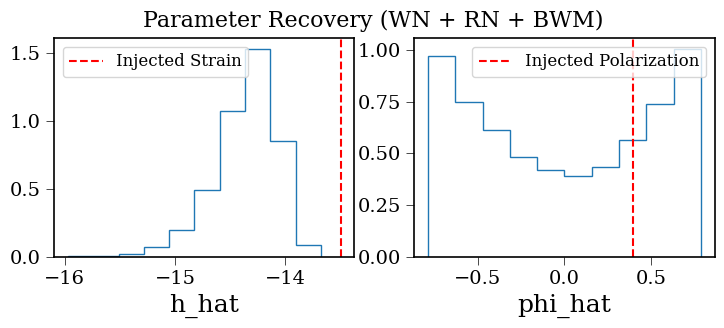

In [38]:
fig, axs = plt.subplots(1, 2)

# Strain recovery
strain_ax = axs[0]
strain_ax.hist(maxlike_strains, histtype='step', density=True)
strain_ax.set_xlabel("h_hat")
strain_ax.axvline(injected_strain, color='red', ls='--', label='Injected Strain')
strain_ax.legend()

pol_ax = axs[1]
pol_ax.hist(maxlike_pols, histtype='step', density=True)
pol_ax.set_xlabel("phi_hat")
pol_ax.axvline(injected_pol, color='red', ls='--', label='Injected Polarization')
pol_ax.legend()

plt.suptitle("Parameter Recovery (WN + RN + BWM)", fontsize=16)
plt.show()

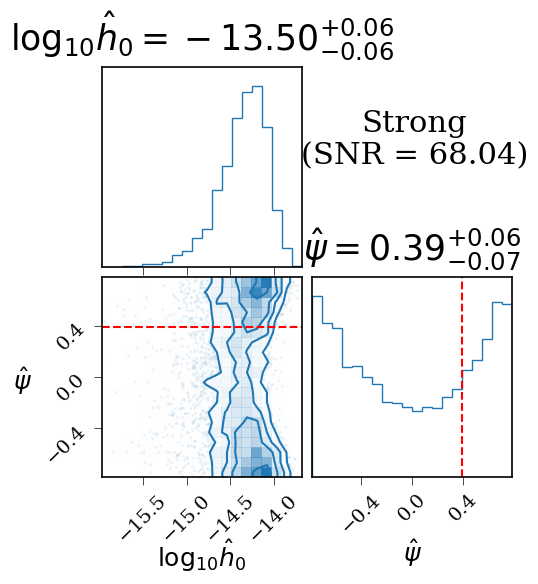

In [65]:
import corner
data = np.array([[maxlike_strains[_i], maxlike_pols[_i]] for _i in range(len(maxlike_strains))])
# print(data)

corner_fig = corner.corner(data, color='tab:blue', histtype='step',labels=[r'$\log_{10}\hat{h}_0$', r'$\hat{\psi}$'])

axs = corner_fig.get_axes()
axs[0].axvline(injected_strain, ls='--', color='red')
axs[2].axvline(injected_strain, ls='--', color='red')
axs[2].axhline(injected_pol, ls='--', color='red')
axs[2].set_ylabel(r'$\hat{\psi}$', rotation = 0, y = .40, x = -0.4)
axs[3].axvline(injected_pol, ls='--', color='red')

axs[0].set_title(r'$\log_{10}{\hat{h}_0} = -13.50^{+0.06}_{-0.06} $', fontsize=25, y=1.04)
axs[3].set_title(r'$\hat{\psi} = 0.39^{+0.06}_{-0.07} $', fontsize=25, y=1.04)

opt_snr = np.mean(maxlike_ncs)

# mysuptitle = plt.suptitle("Large Signal\n" +r"($\log_{10}{A_{\mathrm{RN}}} = $" +  "{:.02f})".format(np.log10(rn_amp))+ "\n"+ r"($\log_{10}{A_{\mathrm{bwm}}} = $" +  "{:.02f})".format(injected_strain), fontsize=18, y=1.15)
mysuptitle = plt.suptitle("Strong\n(SNR = {:.02f})".format(opt_snr), y = 0.85, x=0.75, fontsize=22)

plt.savefig('/home/nima/nanograv/bwm_fpfe/mles_recovery_strong.pdf', bbox_inches='tight', bbox_extra_artists=[mysuptitle])
# plt.suptitle("Maximum Likelihood Parameter Recovery", y = 1.04, ha= 'center', fontsize = 16, )
plt.show()

In [40]:
maxlike_ncs = np.loadtxt("/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_irn_nobwm_ncs_piby8_polarized.txt")
maxlike_output = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_irn_nobwm_piby8_polarized_verbose.txt')

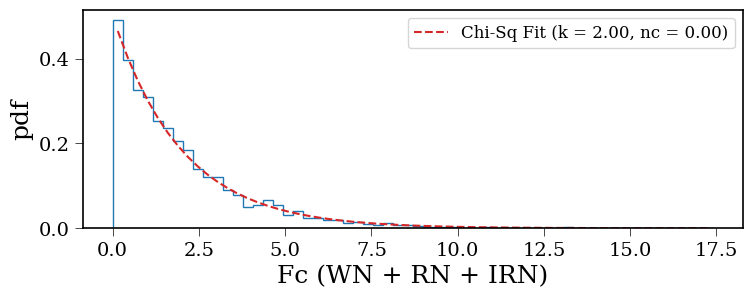

In [64]:
fcs = maxlike_output[:, 0]
fig, ax = plt.subplots()
ns, bins, patches = ax.hist(fcs, bins=60, histtype='step', density=True)


fc_wn_rn_irn_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fc_wn_rn_irn_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_coh, fc_wn_rn_irn_midpts, fc_wn_rn_irn_counts, p0 = [0],maxfev = 5000)


# opt_k = popt[0]
fc_wn_rn_irn_opt_k = 2
fc_wn_rn_irn_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fc_wn_rn_irn_fitted = []
fc_wn_rn_irn_expected = []
for pt in fc_wn_rn_irn_midpts:
    fc_wn_rn_irn_fitted.append(nc_chisq_wrapper(pt, fc_wn_rn_irn_opt_k, fc_wn_rn_irn_opt_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fc_wn_rn_irn_midpts, fc_wn_rn_irn_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fc_wn_rn_opt_k, fc_wn_rn_opt_nc))
plt.legend(loc='upper right')
plt.xlabel("Fc (WN + RN + IRN)")
plt.ylabel("pdf")
plt.show()
plt.close()

# Max Likely amplitude and polarization recovery
### No signal (log10_A = -13.5, HD-correlated Agw = 3e-15, log10_Airn in [-17,-14])

In [34]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_rn_covs = []
prefit_irn_covs = []
irn_amps = []
irn_gammas = []
psr_locs = np.loadtxt(psrloc_path)


rn_amp = 3e-15
rn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)
    prefit_covs.append(np.identity(len(base_toas)) * (100e-9)**2)

bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = np.pi/8
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)

    # =====================================
    # Compute cRN Cov
    # =====================================

    rn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    rn_freqs = np.arange(1, 301) * rn_f0
    psd = compute_redpsd(rn_amp, rn_gamma, rn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    rn_cov = hasens.corr_from_psd(rn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute cRN Cov
    # ===================================== 
    prefit_rn_covs.append(rn_cov)
    
     # =====================================
    # Compute iRN Cov
    # =====================================

    irn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    irn_freqs = np.arange(1, 301) * irn_f0
    
    irn_amp = 10**np.random.uniform(-17,-14.5)
    irn_amps.append(irn_amp)
    irn_gamma = np.random.uniform(2,6)
    irn_gammas.append(irn_gamma)
    
    psd = compute_redpsd(irn_amp, irn_gamma, irn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    irn_cov = hasens.corr_from_psd(irn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute iRN Cov
    # ===================================== 
    prefit_irn_covs.append(irn_cov)
    

In [35]:
def fe_worker(iteration, npsrs):
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    Np = 0
    Nc = 0

    Mpp = 0
    Mcc = 0
    Mpc = 0
    
    nc_estimate = 0    
    for ipsr in range(npsrs):
        
        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]
        irn_series = create_rn_timseries(base_long_toases[ipsr], irn_amps[ipsr], irn_gammas[ipsr], components=300)[:len(base_toases[ipsr])]
        
        
        prefit_toas = base_toases[ipsr] + wn_series + rn_series + irn_series 
        prefit_resids =  wn_series + rn_series + irn_series
        noise_cov = prefit_covs[ipsr] + prefit_rn_covs[ipsr] + prefit_irn_covs[ipsr]

        # prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
        # prefit_resids = wn_series + bwm_signals[ipsr]
        # noise_cov = prefit_covs[ipsr]
        
       
        Rmtx = make_Rmat_wn(prefit_toas)
        postfit_cov = Rmtx@noise_cov@Rmtx.T
        postfit_cov_inv = np.linalg.pinv(postfit_cov)
        
        postfit_resids =  Rmtx@prefit_resids
        postfit_template = Rmtx@ramp_templates[ipsr]
        postfit_signal = Rmtx@bwm_signals[ipsr]

        
        #If anyone is watching kratos, I'M DUMB BRO
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = np.array(postfit_template) * fp
        Ac = np.array(postfit_template) * fc

        Np_contribution = inner_prod(postfit_resids, Ap, postfit_cov_inv)
        Nc_contribution = inner_prod(postfit_resids, Ac, postfit_cov_inv)

        Np += Np_contribution
        Nc += Nc_contribution
        

        Mpp += inner_prod(Ap, Ap, postfit_cov_inv)
        Mcc += inner_prod(Ac, Ac, postfit_cov_inv)
        Mpc += inner_prod(Ap, Ac, postfit_cov_inv)     
        
        nc_estimate += inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)
   
    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    M_pinv = np.linalg.pinv(M)
    
    bp = M_pinv[0,0] * Np + M_pinv[0,1] * Nc
    bc = M_pinv[1,0] * Np + M_pinv[1,1] * Nc
    

    # print(M)
    
    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]
            
    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start, Fe))
    return Fe, nc_estimate, bp, bc

In [32]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fe_worker, args)

results = np.array(results)
# print(results)
estimated_ncs = results[:,1]
fe_bs = results[:, (0,2,3)]

outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_irn_nobwm_piby8_polarized_verbose.txt'
np.savetxt(outfile, fe_bs)

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_irn_nobwm_ncs_piby8_polarized.txt'
np.savetxt(nc_outfile, estimated_ncs)

Finished iteration 252 in 8.3s. Fe = 0.111086253902034
Finished iteration 168 in 11.6s. Fe = 1.5748654357583634
Finished iteration 672 in 11.8s. Fe = 3.5272964323792797Finished iteration 0 in 11.8s. Fe = 4.469260016446232

Finished iteration 336 in 12.3s. Fe = 6.962987116333265
Finished iteration 1008 in 12.3s. Fe = 1.5406281569414908
Finished iteration 924 in 12.4s. Fe = 0.1475208101748849Finished iteration 1176 in 12.4s. Fe = 0.030422355432175453Finished iteration 840 in 12.4s. Fe = 0.13552001290223192Finished iteration 588 in 12.4s. Fe = 0.6702975186004639



Finished iteration 1092 in 12.6s. Fe = 2.775264318898029
Finished iteration 420 in 12.6s. Fe = 0.3893682032394644
Finished iteration 504 in 12.7s. Fe = 4.686222718972683Finished iteration 84 in 12.7s. Fe = 0.15098050959303358

Finished iteration 756 in 12.9s. Fe = 0.9919257133733528
Finished iteration 253 in 10.5s. Fe = 8.416760015363264
Finished iteration 169 in 11.0s. Fe = 3.154931129537003
Finished iteration 1 in 10.9s. Fe =

Finished iteration 103 in 11.5s. Fe = 0.9551150528020234
Finished iteration 19 in 11.5s. Fe = 0.5017496792585618
Finished iteration 775 in 11.3s. Fe = 1.7437037079250615
Finished iteration 607 in 10.2s. Fe = 0.7101600842887358
Finished iteration 1111 in 11.9s. Fe = 0.07015696234782395
Finished iteration 355 in 12.3s. Fe = 0.4452655451009997
Finished iteration 439 in 11.9s. Fe = 1.2750995507374119
Finished iteration 1195 in 11.1s. Fe = 4.590238430962971
Finished iteration 1028 in 12.7s. Fe = 3.3211304520189797
Finished iteration 272 in 11.6s. Fe = 1.0313803742622956
Finished iteration 691 in 12.0s. Fe = 1.0981963602687836
Finished iteration 187 in 12.0s. Fe = 0.20091831823040499
Finished iteration 104 in 10.4s. Fe = 0.25631035486231685
Finished iteration 523 in 12.0s. Fe = 2.1996502143873826
Finished iteration 859 in 12.4s. Fe = 3.139850492482146
Finished iteration 944 in 12.1s. Fe = 4.4121406543186446
Finished iteration 20 in 11.8s. Fe = 2.2430664329855237
Finished iteration 608 in 10.

Finished iteration 710 in 9.5s. Fe = 1.9300045820402196
Finished iteration 794 in 11.0s. Fe = 1.6739024368835074
Finished iteration 458 in 11.8s. Fe = 0.27198852062138185
Finished iteration 877 in 11.8s. Fe = 0.6592438921318687
Finished iteration 290 in 11.6s. Fe = 4.959038719917591
Finished iteration 962 in 12.2s. Fe = 2.657536108875555
Finished iteration 123 in 11.8s. Fe = 0.532322518072102
Finished iteration 1214 in 11.9s. Fe = 0.37811332577718876Finished iteration 39 in 11.8s. Fe = 0.03321204550443953

Finished iteration 1047 in 11.8s. Fe = 6.027063500528017
Finished iteration 542 in 11.3s. Fe = 3.045921076271889
Finished iteration 206 in 12.0s. Fe = 3.6237142598987004
Finished iteration 375 in 11.1s. Fe = 1.474913936610073
Finished iteration 1131 in 11.5s. Fe = 0.44917349041067983
Finished iteration 711 in 11.6s. Fe = 1.4047925685662026
Finished iteration 795 in 11.4s. Fe = 2.4774907665704355
Finished iteration 878 in 10.6s. Fe = 2.59027661333411
Finished iteration 627 in 12.5s. F

Finished iteration 729 in 12.1s. Fe = 1.3195650914160288
Finished iteration 393 in 10.9s. Fe = 1.015199128000191
Finished iteration 560 in 12.0s. Fe = 1.8695270075291148
Finished iteration 981 in 11.8s. Fe = 1.5405241861034369
Finished iteration 58 in 11.3s. Fe = 7.392312423888172
Finished iteration 1233 in 10.2s. Fe = 5.154477747047517
Finished iteration 896 in 11.9s. Fe = 2.000470198765568
Finished iteration 1150 in 11.7s. Fe = 1.9578770396310707
Finished iteration 310 in 10.6s. Fe = 3.642047027708176
Finished iteration 142 in 11.3s. Fe = 1.8613371170941224
Finished iteration 225 in 11.5s. Fe = 4.065494811631058
Finished iteration 1067 in 11.9s. Fe = 6.072891743342121
Finished iteration 478 in 12.0s. Fe = 0.38504289122101587
Finished iteration 814 in 11.9s. Fe = 2.209329523425693
Finished iteration 394 in 11.5s. Fe = 6.2337138439406665
Finished iteration 646 in 11.8s. Fe = 0.22372504654222097
Finished iteration 730 in 11.9s. Fe = 0.4818584013624506
Finished iteration 561 in 11.7s. Fe

Finished iteration 579 in 11.4s. Fe = 1.0046853183140727Finished iteration 1168 in 11.9s. Fe = 0.10320695109716133

Finished iteration 1085 in 12.4s. Fe = 0.0935004668695819
Finished iteration 161 in 11.2s. Fe = 1.046597809347558
Finished iteration 1000 in 10.7s. Fe = 0.8311483364489334
Finished iteration 329 in 12.1s. Fe = 4.587989834958622
Finished iteration 1252 in 11.5s. Fe = 0.9170051037220309
Finished iteration 77 in 10.6s. Fe = 0.973186068617044
Finished iteration 413 in 11.9s. Fe = 2.650056302908436
Finished iteration 915 in 12.0s. Fe = 1.7228093825747504
Finished iteration 497 in 10.9s. Fe = 0.6340678703371697
Finished iteration 244 in 11.6s. Fe = 1.1732260991100758
Finished iteration 833 in 11.5s. Fe = 4.081361989017946
Finished iteration 665 in 11.4s. Fe = 2.4333143159893504
Finished iteration 1086 in 9.7s. Fe = 0.4555938509923213
Finished iteration 749 in 12.1s. Fe = 3.686423487702001
Finished iteration 1169 in 11.7s. Fe = 5.433514159923341
Finished iteration 580 in 11.7s. 

Finished iteration 2194 in 11.9s. Fe = 1.341957676770806
Finished iteration 1859 in 11.4s. Fe = 0.037300643374452935
Finished iteration 1273 in 11.4s. Fe = 0.9050533266606143
Finished iteration 1943 in 11.4s. Fe = 2.1531598837347636
Finished iteration 1440 in 11.3s. Fe = 7.578266797774792
Finished iteration 2362 in 11.6s. Fe = 1.0252884818838481
Finished iteration 1692 in 11.4s. Fe = 1.5678530535029978
Finished iteration 1356 in 12.3s. Fe = 1.9663853730881045
Finished iteration 2111 in 11.6s. Fe = 1.029409416572743
Finished iteration 1524 in 12.1s. Fe = 0.6670662395988904
Finished iteration 2027 in 11.8s. Fe = 3.326554791813363
Finished iteration 2446 in 11.1s. Fe = 0.29535461580914857
Finished iteration 1609 in 11.6s. Fe = 3.0707834786323867
Finished iteration 2279 in 12.0s. Fe = 2.972483325459925
Finished iteration 1776 in 10.6s. Fe = 3.4711268566896925
Finished iteration 2195 in 11.4s. Fe = 0.9904882526477665
Finished iteration 1860 in 11.9s. Fe = 1.0381113915618267
Finished iterati

Finished iteration 1962 in 11.7s. Fe = 0.7180870644464047
Finished iteration 1627 in 11.7s. Fe = 2.210758012594844
Finished iteration 1542 in 11.8s. Fe = 3.9490118738292566
Finished iteration 1292 in 10.2s. Fe = 1.2028312390600975
Finished iteration 1794 in 11.8s. Fe = 0.24428800148978044
Finished iteration 1878 in 11.8s. Fe = 1.4534273852825836
Finished iteration 1374 in 11.5s. Fe = 2.124406242777376
Finished iteration 2213 in 11.6s. Fe = 1.7406098094170261
Finished iteration 1711 in 11.9s. Fe = 0.9420371418047633
Finished iteration 2046 in 11.6s. Fe = 1.0907160306481976
Finished iteration 2465 in 11.9s. Fe = 2.80390979526892
Finished iteration 2381 in 11.3s. Fe = 5.430786099609978Finished iteration 2130 in 11.6s. Fe = 4.973290441482849

Finished iteration 2298 in 11.6s. Fe = 1.0473953919555976
Finished iteration 1460 in 11.8s. Fe = 5.6612595731751725
Finished iteration 1628 in 11.1s. Fe = 1.2235247021999816
Finished iteration 1963 in 12.1s. Fe = 2.002801181794325
Finished iteration 1

Finished iteration 2064 in 10.9s. Fe = 2.527606404698608Finished iteration 1478 in 12.4s. Fe = 1.049572849744037

Finished iteration 2483 in 11.9s. Fe = 2.7094924771475646
Finished iteration 2316 in 10.9s. Fe = 3.0772208587477525
Finished iteration 1311 in 11.0s. Fe = 4.0350533130079995
Finished iteration 1393 in 11.6s. Fe = 2.0876417633510664
Finished iteration 1981 in 11.4s. Fe = 4.315667984139342
Finished iteration 1561 in 12.1s. Fe = 3.383982745506211
Finished iteration 1897 in 10.9s. Fe = 1.0659272277171308
Finished iteration 1730 in 12.2s. Fe = 0.8674983647879768
Finished iteration 2400 in 11.5s. Fe = 0.4069331318064589
Finished iteration 2232 in 11.7s. Fe = 1.1466252731099065
Finished iteration 1647 in 11.0s. Fe = 0.36768147991831174
Finished iteration 2149 in 11.6s. Fe = 0.45963763479441205
Finished iteration 1813 in 11.7s. Fe = 1.2298768564225895
Finished iteration 2065 in 11.0s. Fe = 0.0911464116167104
Finished iteration 2484 in 11.1s. Fe = 0.0425498605929672
Finished iterati

Finished iteration 1831 in 10.8s. Fe = 0.2092759198767415
Finished iteration 2335 in 10.8s. Fe = 3.205431436269794
Finished iteration 1665 in 11.9s. Fe = 2.5564840453251274
Finished iteration 1748 in 12.0s. Fe = 0.763634564430831
Finished iteration 1497 in 11.7s. Fe = 3.4459881082648893
Finished iteration 2502 in 12.3s. Fe = 0.10518510686995039
Finished iteration 2083 in 11.8s. Fe = 0.8113893459839427
Finished iteration 1412 in 11.7s. Fe = 2.6953193364780113
Finished iteration 2251 in 11.8s. Fe = 2.2534550897362675
Finished iteration 2419 in 10.1s. Fe = 0.21055489354600737
Finished iteration 1916 in 12.5s. Fe = 1.362527544479977
Finished iteration 2168 in 10.2s. Fe = 1.2954047074057595
Finished iteration 1330 in 12.2s. Fe = 1.0997197140437664
Finished iteration 1580 in 12.2s. Fe = 6.16695853463142
Finished iteration 2000 in 10.3s. Fe = 0.7025940462818033
Finished iteration 1832 in 11.7s. Fe = 1.1694470449498091
Finished iteration 2336 in 10.7s. Fe = 4.711478759091598
Finished iteration

Finished iteration 3278 in 11.0s. Fe = 0.06857632004337504
Finished iteration 3613 in 12.1s. Fe = 0.16006624818278764
Finished iteration 2524 in 11.6s. Fe = 0.44203029376837955
Finished iteration 3696 in 11.9s. Fe = 3.4824093154142903
Finished iteration 2608 in 12.0s. Fe = 0.18491780031666855
Finished iteration 3362 in 12.3s. Fe = 1.095243208858215
Finished iteration 2692 in 11.4s. Fe = 0.8451293669932589
Finished iteration 2859 in 10.4s. Fe = 0.4132779751716845
Finished iteration 2775 in 11.9s. Fe = 5.129627009035989
Finished iteration 3446 in 11.6s. Fe = 0.8996358799427259Finished iteration 3195 in 10.4s. Fe = 0.9275764282391925

Finished iteration 3111 in 10.5s. Fe = 4.801506724990833
Finished iteration 3027 in 11.8s. Fe = 0.34661135553305283
Finished iteration 2943 in 12.0s. Fe = 0.9062493542177279
Finished iteration 3530 in 12.1s. Fe = 4.778089308240789
Finished iteration 3697 in 11.2s. Fe = 1.4598045161677287
Finished iteration 2525 in 11.7s. Fe = 0.1786546904810413Finished itera

Finished iteration 3045 in 12.1s. Fe = 0.9509067723708812Finished iteration 3381 in 11.5s. Fe = 7.063675308680974

Finished iteration 3213 in 11.7s. Fe = 0.757572972847828
Finished iteration 3632 in 11.8s. Fe = 6.057614734353265
Finished iteration 2543 in 11.2s. Fe = 0.006407974960864632
Finished iteration 2878 in 11.7s. Fe = 0.7484118765657386
Finished iteration 3548 in 11.2s. Fe = 1.417535453004909
Finished iteration 3129 in 12.4s. Fe = 2.107630077320442
Finished iteration 3715 in 11.9s. Fe = 4.567499596796504
Finished iteration 2627 in 11.7s. Fe = 1.3994788941385103
Finished iteration 3297 in 11.4s. Fe = 0.46589248268985156
Finished iteration 2794 in 11.8s. Fe = 7.5193619805304195
Finished iteration 2711 in 11.9s. Fe = 1.7687770149979327
Finished iteration 3465 in 12.3s. Fe = 4.161910805620408
Finished iteration 2962 in 11.5s. Fe = 4.808798750800599
Finished iteration 3214 in 11.2s. Fe = 0.6901066951809686
Finished iteration 3382 in 11.8s. Fe = 1.7988221971711815Finished iteration 3

Finished iteration 3064 in 11.2s. Fe = 2.4021425506830285
Finished iteration 3650 in 11.5s. Fe = 0.06294279531066409
Finished iteration 2812 in 11.9s. Fe = 1.6573129901321442
Finished iteration 3400 in 11.0s. Fe = 3.460899286570676
Finished iteration 2729 in 11.8s. Fe = 0.2171461622569957
Finished iteration 3232 in 11.2s. Fe = 2.3365095374573723
Finished iteration 2562 in 11.5s. Fe = 1.6311668352044868
Finished iteration 2646 in 11.4s. Fe = 1.0902998910388255
Finished iteration 2897 in 11.3s. Fe = 0.7357120433551003
Finished iteration 3567 in 11.8s. Fe = 0.6017834524587532
Finished iteration 3734 in 11.6s. Fe = 0.4048138118488859
Finished iteration 3148 in 10.9s. Fe = 0.21492763847347127
Finished iteration 2981 in 11.3s. Fe = 1.6855084251183157
Finished iteration 3316 in 11.3s. Fe = 1.2801865406689048
Finished iteration 3484 in 11.8s. Fe = 0.23720004354290575
Finished iteration 3651 in 11.3s. Fe = 2.2347528817383426
Finished iteration 3065 in 11.5s. Fe = 1.247687684282004
Finished iter

Finished iteration 3752 in 12.4s. Fe = 0.3297149498562443
Finished iteration 3418 in 12.2s. Fe = 2.8279301273987567
Finished iteration 3502 in 12.0s. Fe = 2.3068309126505104
Finished iteration 3251 in 11.4s. Fe = 0.5864266056744718
Finished iteration 2916 in 11.6s. Fe = 0.934352293247179
Finished iteration 3334 in 11.2s. Fe = 1.2912134814823835
Finished iteration 2581 in 11.8s. Fe = 2.360572096044237
Finished iteration 2748 in 11.8s. Fe = 6.245835514110622
Finished iteration 3083 in 11.9s. Fe = 3.4797362399496183
Finished iteration 2831 in 11.8s. Fe = 0.2780183876624282
Finished iteration 3000 in 11.7s. Fe = 1.6545495714185035
Finished iteration 3670 in 10.9s. Fe = 0.6171583222880701
Finished iteration 2665 in 11.9s. Fe = 0.09427294126724257
Finished iteration 3586 in 11.5s. Fe = 0.2532530921411868
Finished iteration 3167 in 12.5s. Fe = 0.337543794236771
Finished iteration 3753 in 12.5s. Fe = 0.06613263849614313
Finished iteration 3419 in 11.8s. Fe = 0.08910933688213549
Finished iterat

Finished iteration 2934 in 11.9s. Fe = 2.4272887573663264
Finished iteration 2683 in 11.6s. Fe = 2.187734561377817
Finished iteration 3771 in 11.3s. Fe = 1.7525161551421844
Finished iteration 3269 in 11.6s. Fe = 3.64504886748573
Finished iteration 3688 in 11.4s. Fe = 0.7719712082337882
Finished iteration 3020 in 11.1s. Fe = 4.092722486469759
Finished iteration 3186 in 11.4s. Fe = 2.5852328737901287
Finished iteration 2850 in 11.6s. Fe = 1.7313796703603512
Finished iteration 2600 in 11.6s. Fe = 2.509178304414576
Finished iteration 3521 in 11.0s. Fe = 0.04882004778723883
Finished iteration 3437 in 12.0s. Fe = 0.39359241919622673Finished iteration 2767 in 11.4s. Fe = 7.380371115371169

Finished iteration 3605 in 11.7s. Fe = 2.464488343443179
Finished iteration 3102 in 11.6s. Fe = 2.3818800303140755
Finished iteration 2935 in 11.8s. Fe = 0.6399171495559879
Finished iteration 2684 in 11.8s. Fe = 0.6498916609225404
Finished iteration 3353 in 12.3s. Fe = 3.5932682197688433
Finished iteration 

Finished iteration 4799 in 11.8s. Fe = 0.03346360910288029
Finished iteration 4631 in 12.0s. Fe = 4.419858792800438
Finished iteration 4380 in 11.8s. Fe = 3.755982129496493
Finished iteration 3795 in 10.6s. Fe = 1.875226350013706
Finished iteration 4883 in 11.6s. Fe = 2.43606528696063
Finished iteration 3962 in 11.8s. Fe = 3.7435704459164096
Finished iteration 4716 in 11.4s. Fe = 7.412854709430065
Finished iteration 4966 in 11.9s. Fe = 3.8216369161488646
Finished iteration 4464 in 11.8s. Fe = 5.065525673239836
Finished iteration 4213 in 11.9s. Fe = 0.06461304635914485
Finished iteration 4129 in 12.0s. Fe = 0.79778864465796
Finished iteration 4548 in 11.2s. Fe = 0.520605553209256
Finished iteration 4046 in 11.9s. Fe = 2.5832012198545766
Finished iteration 3879 in 11.1s. Fe = 2.4743869215051353
Finished iteration 4297 in 11.7s. Fe = 0.9935505747743936
Finished iteration 4800 in 12.0s. Fe = 4.1871526743900365
Finished iteration 4632 in 11.9s. Fe = 1.2359799282067763
Finished iteration 379

Finished iteration 4147 in 10.4s. Fe = 1.198020298321333
Finished iteration 3897 in 11.5s. Fe = 0.5784392694721205
Finished iteration 4399 in 12.0s. Fe = 0.2528943320988092
Finished iteration 4818 in 12.0s. Fe = 0.0021861516589224894
Finished iteration 3814 in 10.5s. Fe = 1.0067657920287327
Finished iteration 4315 in 10.8s. Fe = 1.0571054915446765
Finished iteration 4065 in 11.7s. Fe = 0.29021237811645234
Finished iteration 4650 in 11.3s. Fe = 0.6840178659558501
Finished iteration 4232 in 11.5s. Fe = 0.2840270927037864
Finished iteration 4567 in 10.5s. Fe = 1.833859864353494
Finished iteration 4902 in 11.9s. Fe = 1.0236854579297678
Finished iteration 3981 in 12.2s. Fe = 5.044711326735651
Finished iteration 4483 in 10.5s. Fe = 2.04217282514254
Finished iteration 4985 in 11.9s. Fe = 3.7331475388788724
Finished iteration 4735 in 11.4s. Fe = 1.0008744061962789
Finished iteration 3898 in 11.6s. Fe = 4.660622331984313
Finished iteration 4148 in 11.9s. Fe = 1.7841110538938774
Finished iterati

Finished iteration 4501 in 10.2s. Fe = 1.0924421514600322
Finished iteration 4251 in 11.2s. Fe = 1.090030588451188Finished iteration 4418 in 10.8s. Fe = 0.17890245478766226

Finished iteration 4334 in 10.5s. Fe = 2.3160760146325017
Finished iteration 4084 in 11.2s. Fe = 1.794862701524837
Finished iteration 4669 in 11.3s. Fe = 4.766806300684445
Finished iteration 4586 in 11.1s. Fe = 5.123347664117796
Finished iteration 4000 in 11.2s. Fe = 0.838435243011347
Finished iteration 4921 in 10.5s. Fe = 4.355058347128221
Finished iteration 4754 in 10.1s. Fe = 0.2590503140006729
Finished iteration 4837 in 11.1s. Fe = 8.025477006387701
Finished iteration 4166 in 10.3s. Fe = 4.215678027738147
Finished iteration 3917 in 10.9s. Fe = 2.5946515096043967
Finished iteration 3834 in 10.7s. Fe = 1.5649607793029583
Finished iteration 4502 in 10.5s. Fe = 1.8947267129238834
Finished iteration 4419 in 10.6s. Fe = 1.9951628973670499
Finished iteration 4335 in 10.8s. Fe = 2.514830164913738
Finished iteration 425

Finished iteration 4521 in 10.7s. Fe = 3.4770450191528774
Finished iteration 4271 in 10.7s. Fe = 6.004235202556385
Finished iteration 4774 in 11.1s. Fe = 1.7103210713327883
Finished iteration 4606 in 11.1s. Fe = 4.482764882582218Finished iteration 4438 in 11.3s. Fe = 1.5743062617166024

Finished iteration 4186 in 10.8s. Fe = 2.4649769989317636
Finished iteration 4857 in 10.7s. Fe = 5.102590834302978
Finished iteration 4689 in 10.9s. Fe = 0.3635008322637778
Finished iteration 3937 in 10.8s. Fe = 0.22518608132532925
Finished iteration 4941 in 11.0s. Fe = 0.1084515123674218
Finished iteration 4020 in 11.3s. Fe = 5.295796015640183
Finished iteration 4355 in 10.6s. Fe = 7.131714603585575
Finished iteration 4105 in 10.4s. Fe = 2.2555134037442497
Finished iteration 3854 in 10.8s. Fe = 2.1215297604339156
Finished iteration 4522 in 10.7s. Fe = 4.118873670959406
Finished iteration 4272 in 10.6s. Fe = 0.17020986992380796
Finished iteration 4607 in 10.9s. Fe = 10.772047253593934
Finished iteration

In [36]:
maxlike_ncs = np.loadtxt("/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_irn_nobwm_ncs_piby8_polarized.txt")
maxlike_output = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_irn_nobwm_piby8_polarized_verbose.txt')

Using
$$\hat{h_0} = \sqrt{\hat{b}_{+}^2 + \hat{b}_{\times}^2}$$
$$\hat{\psi} = \tan^{-1}\left({\frac{\hat{b}_{\times}}{\hat{b}_{+}}}\right)$$

In [37]:
bps = maxlike_output[:,1]
bcs = maxlike_output[:,2]

injected_strain = -13.5
injected_pol = np.pi/8

maxlike_strains = np.log10(np.array([np.sqrt(bps[_i]**2 + bcs[_i]**2) for _i in range(len(bps))]))
maxlike_pols = np.array([0.5*np.arctan(bcs[_i]/bps[_i]) for _i in range(len(bps))])


#compute 1-sigma errors
median_strain = np.median(sorted(maxlike_strains))
strain_idx_gap = int(len(maxlike_strains) * .341)
median_idx = int(len(maxlike_strains)/2)
upper_strain = sorted(maxlike_strains)[median_idx + strain_idx_gap]
lower_strain = sorted(maxlike_strains)[median_idx - strain_idx_gap]

median_pol = np.median(sorted(maxlike_pols))
pol_idx_gap = int(len(maxlike_pols) * .341)
median_idx = int(len(maxlike_pols)/2)
upper_pol = sorted(maxlike_pols)[median_idx + pol_idx_gap]
lower_pol = sorted(maxlike_pols)[median_idx - pol_idx_gap]

print(median_strain, median_strain - lower_strain, upper_strain-median_strain)
print(median_pol, median_pol - lower_pol, upper_pol-median_pol)


-14.321067690809526 0.3095717244795537 0.22702686542575456
-0.023443628954317057 0.5990237825028301 0.6494173024396055


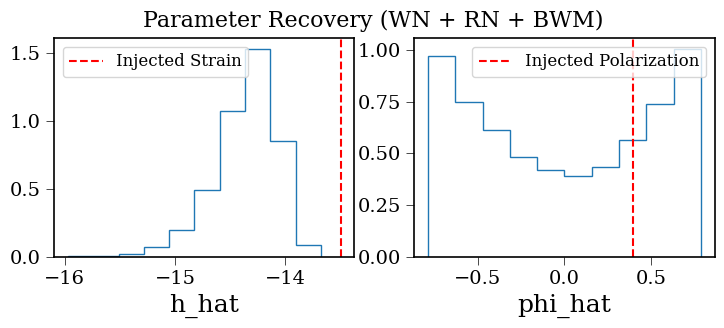

In [38]:
fig, axs = plt.subplots(1, 2)

# Strain recovery
strain_ax = axs[0]
strain_ax.hist(maxlike_strains, histtype='step', density=True)
strain_ax.set_xlabel("h_hat")
strain_ax.axvline(injected_strain, color='red', ls='--', label='Injected Strain')
strain_ax.legend()

pol_ax = axs[1]
pol_ax.hist(maxlike_pols, histtype='step', density=True)
pol_ax.set_xlabel("phi_hat")
pol_ax.axvline(injected_pol, color='red', ls='--', label='Injected Polarization')
pol_ax.legend()

plt.suptitle("Parameter Recovery (WN + RN + BWM)", fontsize=16)
plt.show()

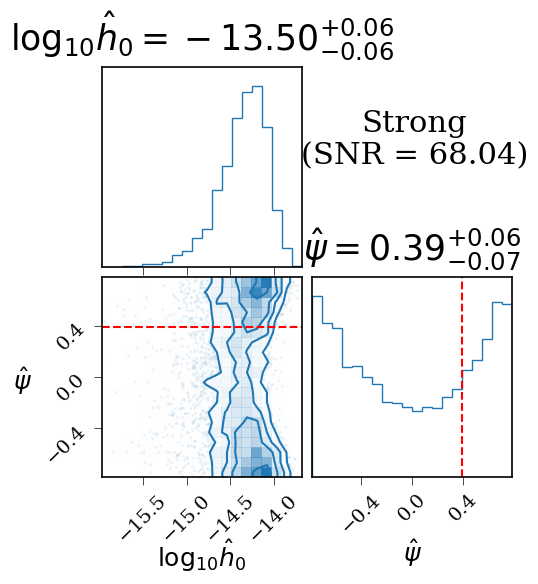

In [65]:
import corner
data = np.array([[maxlike_strains[_i], maxlike_pols[_i]] for _i in range(len(maxlike_strains))])
# print(data)

corner_fig = corner.corner(data, color='tab:blue', histtype='step',labels=[r'$\log_{10}\hat{h}_0$', r'$\hat{\psi}$'])

axs = corner_fig.get_axes()
axs[0].axvline(injected_strain, ls='--', color='red')
axs[2].axvline(injected_strain, ls='--', color='red')
axs[2].axhline(injected_pol, ls='--', color='red')
axs[2].set_ylabel(r'$\hat{\psi}$', rotation = 0, y = .40, x = -0.4)
axs[3].axvline(injected_pol, ls='--', color='red')

axs[0].set_title(r'$\log_{10}{\hat{h}_0} = -13.50^{+0.06}_{-0.06} $', fontsize=25, y=1.04)
axs[3].set_title(r'$\hat{\psi} = 0.39^{+0.06}_{-0.07} $', fontsize=25, y=1.04)

opt_snr = np.mean(maxlike_ncs)

# mysuptitle = plt.suptitle("Large Signal\n" +r"($\log_{10}{A_{\mathrm{RN}}} = $" +  "{:.02f})".format(np.log10(rn_amp))+ "\n"+ r"($\log_{10}{A_{\mathrm{bwm}}} = $" +  "{:.02f})".format(injected_strain), fontsize=18, y=1.15)
mysuptitle = plt.suptitle("Strong\n(SNR = {:.02f})".format(opt_snr), y = 0.85, x=0.75, fontsize=22)

plt.savefig('/home/nima/nanograv/bwm_fpfe/mles_recovery_strong.pdf', bbox_inches='tight', bbox_extra_artists=[mysuptitle])
# plt.suptitle("Maximum Likelihood Parameter Recovery", y = 1.04, ha= 'center', fontsize = 16, )
plt.show()

In [40]:
maxlike_ncs = np.loadtxt("/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_irn_nobwm_ncs_piby8_polarized.txt")
maxlike_output = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_irn_nobwm_piby8_polarized_verbose.txt')

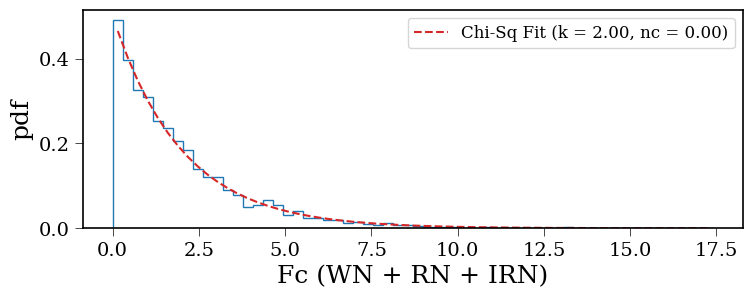

In [64]:
fcs = maxlike_output[:, 0]
fig, ax = plt.subplots()
ns, bins, patches = ax.hist(fcs, bins=60, histtype='step', density=True)


fc_wn_rn_irn_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fc_wn_rn_irn_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_coh, fc_wn_rn_irn_midpts, fc_wn_rn_irn_counts, p0 = [0],maxfev = 5000)


# opt_k = popt[0]
fc_wn_rn_irn_opt_k = 2
fc_wn_rn_irn_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fc_wn_rn_irn_fitted = []
fc_wn_rn_irn_expected = []
for pt in fc_wn_rn_irn_midpts:
    fc_wn_rn_irn_fitted.append(nc_chisq_wrapper(pt, fc_wn_rn_irn_opt_k, fc_wn_rn_irn_opt_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fc_wn_rn_irn_midpts, fc_wn_rn_irn_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fc_wn_rn_opt_k, fc_wn_rn_opt_nc))
plt.legend(loc='upper right')
plt.xlabel("Fc (WN + RN + IRN)")
plt.ylabel("pdf")
plt.show()
plt.close()

# Same as above, but injecting HD red noise

Borrowing some code from PTA replicator using scheme from Chamberlin et al 2014 (GWB Opt Stat)

Also involves some heavy rewriting of existing Fc code since we can't treat things as block-diagonal mostly

In [9]:
from scipy import interpolate as interp
def create_gwb(
    psrlocs,
    psr_toases,
    Amp,
    gam,
    seed,
    npts,
    noCorr=False,
    turnover=False,
    clm=[np.sqrt(4.0 * np.pi)],
    lmax=0,
    f0=1e-9,
    beta=1,
    power=1,
    userSpec=None,
    howml=10,
):
    """
    Function to create GW-induced residuals from a stochastic GWB as defined
    in Chamberlin, Creighton, Demorest, et al. (2014).
    :param psrlocs: list of psr locations to inject GWB into
    :param psr_toas: list of toas to inject GWB into (in seconds)
    :param Amp: Amplitude of red noise in GW units
    :param gam: Red noise power law spectral index
    :param noCorr: Add red noise with no spatial correlations
    :param seed: Random number seed
    :param turnover: Produce spectrum with turnover at frequency f0
    :param clm: coefficients of spherical harmonic decomposition of GW power
    :param lmax: maximum multipole of GW power decomposition
    :param f0: Frequency of spectrum turnover
    :param beta: Spectral index of power spectram for f << f0
    :param power: Fudge factor for flatness of spectrum turnover
    :param userSpec: User-supplied characteristic strain spectrum
                     (first column is freqs, second is spectrum)
    :param npts: Number of points used in interpolation
    :param howml: Lowest frequency is 1/(howml * T)
    :returns: list of residuals for each pulsar
    """

    # number of pulsars
    Npulsars = len(psrlocs)

    # gw start and end times for entire data set
    start = float(np.min(psr_toases[:][0]) - 86400)
    stop = float(np.max(psr_toases[:][-1]) + 86400)

    # duration of the signal
    dur = stop - start

    # make a vector of evenly sampled data points (sec)
    ut = np.linspace(start, stop, npts)
    dt = dur/npts
    
    # compute the overlap reduction function
    if noCorr:
        ORF = np.diag(np.ones(Npulsars) * 2)
    else:
        # ===================================================================
        # Don't need to instantiate psrlocs, since we're passing them in
        # psrlocs = np.zeros((Npulsars, 2))

        # for ii in range(Npulsars):
        #     if "RAJ" and "DECJ" in psrs[ii].loc:
        #         psrlocs[ii] = np.double(psrs[ii]["RAJ"]), np.double(psrs[ii]["DECJ"])
        #     elif "ELONG" and "ELAT" in psrs[ii].loc:
        #         fac = 1.0
        #         #fac = 180.0 / np.pi
        #         # check for B name
        #         if "B" in psrs[ii].name:
        #             epoch = "1950"
        #         else:
        #             epoch = "2000"
        #         coords = ephem.Equatorial(
        #             ephem.Ecliptic(str(psrs[ii].loc["ELONG"] * fac), str(psrs[ii].loc["ELAT"] * fac)), epoch=epoch
        #         )
        #         psrlocs[ii] = float(repr(coords.ra)), float(repr(coords.dec))
        # ===================================================================

        psrlocs[:, 1] = np.pi / 2.0 - psrlocs[:, 1] #convert to polar angle
        anisbasis = np.array(anis.CorrBasis(psrlocs, lmax))
        ORF = sum(clm[kk] * anisbasis[kk] for kk in range(len(anisbasis))) #defaults to excluding anisotropy
        ORF *= 2.0

    # Define frequencies spanning from DC to Nyquist.
    # This is a vector spanning these frequencies in increments of 1/(dur*howml).
    f = np.arange(0, 1 / (2 * dt), 1 / (dur * howml)) # howml defaults to 10, so we'll simulate red noise with 10x baseline
    f[0] = f[1]  # avoid divide by 0 warning
    Nf = len(f)

    # Use Cholesky transform to take 'square root' of ORF
    M = np.linalg.cholesky(ORF)

    # Create random frequency series from zero mean, unit variance, Gaussian distributions
    w = np.zeros((Npulsars, Nf), complex)
    for ll in range(Npulsars):
        w[ll, :] = np.random.randn(Nf) + 1j * np.random.randn(Nf)

    # strain amplitude

    f1yr = 1 / 3.16e7
    alpha = -0.5 * (gam - 3)
    hcf = Amp * (f / f1yr) ** (alpha)
    
    # Simplify to only ever HD-correlated Plaw
    #=========================================================================        
    # if userSpec is None:

    #     f1yr = 1 / 3.16e7
    #     alpha = -0.5 * (gam - 3)
    #     hcf = Amp * (f / f1yr) ** (alpha)


    # elif userSpec is not None:

    #     freqs = userSpec[:, 0]
    #     if len(userSpec[:, 0]) != len(freqs):
    #         raise ValueError("Number of supplied spectral points does not match number of frequencies!")
    #     else:
    #         fspec_in = interp.interp1d(np.log10(freqs), np.log10(userSpec[:, 1]), kind="linear")
    #         fspec_ex = extrap1d(fspec_in)
    #         hcf = 10.0 ** fspec_ex(np.log10(f))
    #===========================================================================

    C = 1 / 96 / np.pi**2 * hcf**2 / f**3 * dur * howml

    # inject residuals in the frequency domain
    Res_f = np.dot(M, w)
    for ll in range(Npulsars):
        Res_f[ll] = Res_f[ll] * C ** (0.5)  # rescale by frequency dependent factor
        Res_f[ll, 0] = 0  # set DC bin to zero to avoid infinities
        Res_f[ll, -1] = 0  # set Nyquist bin to zero also

    # Now fill in bins after Nyquist (for fft data packing) and take inverse FT
    Res_f2 = np.zeros((Npulsars, 2 * Nf - 2), complex)
    Res_t = np.zeros((Npulsars, 2 * Nf - 2))
    Res_f2[:, 0:Nf] = Res_f[:, 0:Nf]
    Res_f2[:, Nf : (2 * Nf - 2)] = np.conj(Res_f[:, (Nf - 2) : 0 : -1])
    Res_t = np.real(np.fft.ifft(Res_f2) / dt)

    # shorten data and interpolate onto TOAs
    Res = np.zeros((Npulsars, npts))
    res_gw = []
    for ll in range(Npulsars):
        Res[ll, :] = Res_t[ll, 10 : (npts + 10)]
        f = interp.interp1d(ut, Res[ll, :], kind="linear")
        res_gw.append(f(psr_toases[ll][:]))

    # # return res_gw
    # ct = 0
    # for psr in psrs:
    #     dt = res_gw[ct] / 86400.0 * u.day
    #     psr.toas.adjust_TOAs(TimeDelta(dt.to('day')))
    #     psr.update_residuals()
    #     ct += 1
    
    return res_gw

In [10]:
psr_locs = np.loadtxt(psrloc_path)
psr_thetas = psr_locs[:,0]
psr_phis = psr_locs[:,1]

In [11]:
def simple_HD(phi, theta):
    cosThetaIJ = np.cos(theta[0]) * np.cos(theta[1]) \
                    + np.sin(theta[0]) * np.sin(theta[1]) \
                    * np.cos(phi[0] - phi[1])
    x = (1. - cosThetaIJ) / 2.
    chiIJ = [1.5*x*np.log(x) - 0.25*x + 0.5 if x!=0 else 1.]
    
    return chiIJ

In [12]:
base_toases = []
base_long_toases = []
residses = []
prefit_covs = []
prefit_crn_covs = []
prefit_irn_covs = []
irn_amps = []
irn_gammas = []



irn_amp = 3e-15
irn_gamma = 13./3.

crn_amp = 3e-15
crn_gamma = 13./3.


for ipsr in range(npsrs):
    base_toas = np.linspace(0, 10 * 365.25 * 24 * 3600, num=120)
    base_long_toas = np.linspace(0, 100 * 365.25 * 24 * 3600, num=1200)
    base_toases.append(base_toas)
    base_long_toases.append(base_long_toas)

    resids= np.zeros(120)
    residses.append(resids)

prefit_covs = [[np.zeros((120,120),)
          if r!=c
          else np.identity(120)*(100e-9)**2
          for r in range(npsrs)]
          for c in range(npsrs)]

full_wn_cov = np.block(prefit_covs)    
    
bwm_signals = []
ramp_templates = []

gw_theta = np.mean(psr_locs[:][0])
gw_phi = np.mean(psr_locs[:][1])
gw_pol = np.pi/8
log10_h = -13.5
gw_t0 = 10 * 365.25 * 24 * 3600 * (2/5)

# =====================================
# Compute cRN Cov in one shot (thanks Jeff)
# =====================================

crn_f0 = 1/(np.amax(base_long_toases) - np.amin(base_long_toases))
crn_freqs = np.arange(1, 301) * crn_f0
crn_psd = compute_redpsd(crn_amp, crn_gamma, crn_freqs)


Ch_blocks = [[(simple_HD([psr_phis[r],psr_phis[c]],[psr_thetas[r],psr_thetas[c]]) * hasens.corr_from_psdIJ(freqs=crn_freqs, psd=crn_psd, toasI=base_toases[r],
                            toasJ=base_toases[c], fast=True))
          if r!=c
          else hasens.corr_from_psdIJ(freqs=crn_freqs, psd=crn_psd, toasI=base_toases[r],
                               toasJ=base_toases[c], fast=True)
          for r in range(len(base_toases))]
          for c in range(len(base_toases))]

prefit_crn_cov = np.block(Ch_blocks)      
#=======================================
# End cRN Cov in one shot (thanks Jeff)
#=======================================


for ipsr in range(npsrs):
    psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])    
    bwm_resids = bwm_delay(base_toases[ipsr], psr_vec, log10_h = log10_h, cos_gwtheta = np.cos(gw_theta), gwphi = gw_phi, t0 = gw_t0, gwpol=gw_pol)
    bwm_signals.append(bwm_resids)

    ramp_template = np.zeros(len(base_toases[ipsr]))
    for toa_idx, toa in enumerate(base_toases[ipsr]):
        if toa > gw_t0:
            ramp_template[toa_idx] = toa - gw_t0

    ramp_templates.append(ramp_template)
    
    # =====================================
    # Compute iRN Cov
    # =====================================

    irn_f0 = 1/(max(base_long_toases[ipsr] - min(base_long_toases[ipsr])))
    irn_freqs = np.arange(1, 301) * irn_f0
    
    irn_amp = 10**np.random.uniform(-17,-14.5)
    irn_amps.append(irn_amp)
    irn_gamma = np.random.uniform(2,6)
    irn_gammas.append(irn_gamma)
    
    psd = compute_redpsd(irn_amp, irn_gamma, irn_freqs)
    # psr_freqs = 1/(max(base_toases[ipsr] - min(base_toases[ipsr]))) * np.arange(1, 30.5, 1)
    irn_cov = hasens.corr_from_psd(irn_freqs, psd, base_toases[ipsr], fast=True)

    # =====================================
    # End Compute iRN Cov
    # ===================================== 
    prefit_irn_covs.append(irn_cov)
    
fullpta_irn_covlist = [[np.zeros((120,120),)
          if r!=c
          else prefit_irn_covs[r]
          for r in range(npsrs)]
          for c in range(npsrs)]

fullpta_irn_cov = np.block(fullpta_irn_covlist)    

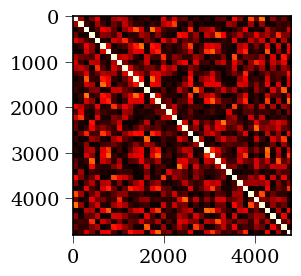

(4800, 4800)

In [13]:
plt.imshow(prefit_crn_cov, cmap='hot', interpolation='nearest')
plt.show()

prefit_crn_cov.shape

<ipython-input-14-f4859287b1b4>:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(fullpta_irn_cov), cmap='hot', interpolation='nearest',)


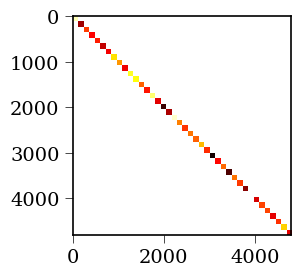

(4800, 4800)

In [14]:
plt.imshow(np.log10(fullpta_irn_cov), cmap='hot', interpolation='nearest',)
plt.show()

fullpta_irn_cov.shape

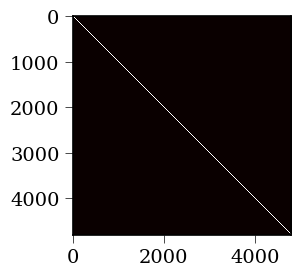

(4800, 4800)

In [15]:
plt.imshow(np.block(prefit_covs),cmap='hot',interpolation='nearest')
plt.show()

np.block(prefit_covs).shape

In [27]:
def fe_worker(iteration, npsrs):
    # Fe single run worker, uses create_gwb to create correlated RN series
    # Let's try to flatten everything in this first run
#     start_time = time.time()
#     print("Beginning run")
    fe_tot = 0
    np.random.seed(iteration)
    start = time.time()

    crn_serieses = create_gwb(
        psr_locs,
        base_toases,
        crn_amp,
        crn_gamma,
        iteration,
        npts=1200,
        noCorr=False,
        turnover=False,
        clm=[np.sqrt(4.0 * np.pi)],
        lmax=0,
        f0=1e-9,
        beta=1,
        power=1,
        userSpec=None,
        howml=10,
    )

    irn_serieses = []
    wn_serieses = []
    for ipsr in range(npsrs):

        wn_series = np.random.normal(loc=0, scale=100e-9, size = (len(base_toases[ipsr])))
        wn_serieses.append(wn_series)
        # rn_series = create_rn_timseries(base_long_toases[ipsr], rn_amp, rn_gamma, components=300)[:len(base_toases[ipsr])]
        irn_series = create_rn_timseries(base_long_toases[ipsr], irn_amps[ipsr], irn_gammas[ipsr], components=300)[:len(base_toases[ipsr])]
        irn_serieses.append(irn_series)


    wn_flattened = np.array(flatten(wn_serieses))
    irn_flattened =  np.array(flatten(irn_serieses))
    crn_flattened =  np.array(flatten(crn_serieses))


    prefit_toas_flattened =  np.array(flatten(base_toases))+ wn_flattened + crn_flattened + irn_flattened 
    prefit_resids_flattened =  np.array(wn_flattened) + np.array(irn_flattened) + np.array(crn_flattened)
    prefit_noise_cov = full_wn_cov + fullpta_irn_cov + prefit_crn_cov

#     print("Trying to invert full noise covariance matrix of size " + str(prefit_noise_cov.shape))
    prefit_noise_cov_inv = np.linalg.pinv(prefit_noise_cov)
#     print("Completed noise covariance matrix inversion")

    Rmtx = make_Rmat(prefit_toas_flattened, prefit_noise_cov_inv)
    # prefit_toas = base_toases[ipsr] + wn_series + bwm_signals[ipsr]
    # prefit_resids = wn_series + bwm_signals[ipsr]
    # noise_cov = prefit_covs[ipsr]

#     cp1 = time.time()
#     print("Checkpoint 1 (Instantiate noise covariance inverse and R-matrix) completed in {:.02f} seconds".format(cp1-start_time))

    postfit_cov = Rmtx@prefit_noise_cov@Rmtx.T
    postfit_cov_inv = np.linalg.pinv(postfit_cov)

    postfit_resids =  Rmtx@prefit_resids_flattened
    postfit_template = Rmtx@flatten(ramp_templates) # fix this to be flattened
    postfit_signal = Rmtx@flatten(bwm_signals) 

#     cp2 = time.time()
#     print("Checkpoint 2 (Fitting covariance matrix and residuals, template and signals using R-matrix) completed in {:.02f} seconds".format(cp2-cp1))

    Aps = []
    Acs = []

    for ipsr in range(npsrs):
        psr_vec = hp.ang2vec(psr_locs[ipsr][0], psr_locs[ipsr][1])   
        apc = utils.create_gw_antenna_pattern(psr_vec, gw_theta, gw_phi)
        fp = apc[0]
        fc = apc[1]

        Ap = ramp_templates[ipsr] * fp
        Ac = ramp_templates[ipsr] * fc
        Aps.append(Ap)
        Acs.append(Ac)

    Ap_prefit = np.array(flatten(Aps))
    Ac_prefit = np.array(flatten(Acs))

    Ap_postfit = Rmtx@Ap_prefit
    Ac_postfit = Rmtx@Ac_prefit

#     cp3 = time.time()
#     print("Checkpoint 3 (Instantiating Ap and Ac) completed in {:.02f} seconds".format(cp3-cp2))
#     print("Beginning to compute Np, Nc")

    Np = inner_prod(postfit_resids, Ap_postfit, postfit_cov_inv)
    Nc = inner_prod(postfit_resids, Ac_postfit, postfit_cov_inv)

#     cp4 = time.time()
#     print("Checkpoint 4 (Computed Np and Nc) completed in {:.02f} seconds".format(cp4-cp3))
#     print("Computing 2x2 Mij")

    Mpp = inner_prod(Ap_postfit, Ap_postfit, postfit_cov_inv)
    Mcc = inner_prod(Ac_postfit, Ac_postfit, postfit_cov_inv)
    Mpc = inner_prod(Ap_postfit, Ac_postfit, postfit_cov_inv)     

#     cp5 = time.time()
#     print("Chekcpoint 5 (Computing Mij) completed in {:.02f} seconds".format(cp5-cp4))

    nc_estimate = inner_prod(postfit_signal, postfit_signal, postfit_cov_inv)

    N = np.zeros(2)
    N[0] = Np
    N[1] = Nc

    # print(N)

    M = np.zeros((2,2))
    M[0,0] = Mpp
    M[1,0] = M[0,1] = Mpc
    M[1,1] = Mcc
    M_pinv = np.linalg.pinv(M)

    bp = M_pinv[0,0] * Np + M_pinv[0,1] * Nc
    bc = M_pinv[1,0] * Np + M_pinv[1,1] * Nc


    # print(M)

    Fe = 0
    for _i in range(2):
        for _j in range(2):
            Fe += N[_i] * M_pinv[_i, _j] * N[_j]

    end = time.time()
    print("Finished iteration {} in {:.01f}s. Fe = {}".format(iteration, end-start_time, Fe))
    return Fe, nc_estimate, bp, bc

In [ ]:
Niter = 5000
pool = mp.Pool(processes=15)
args = [[iter, npsrs] for iter in range(Niter)]
results = pool.starmap(fe_worker, args)

Fes = [res[0] for res in results]
estimated_ncs = [res[1] for res in results]
45

outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_irn_nobwm_hdcrn.txt'
np.savetxt(outfile, np.array(Fes))

nc_outfile = '/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_irn_hdcrn_nobwm_ncs.txt'
np.savetxt(nc_outfile, np.array(estimated_ncs))

(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)(4800, 3)

(4800, 4800)Computing internal product

Computing internal product(4800, 3)

(4800, 4800)
Computing internal product
(4800, 3)
(4800, 3)
(4800, 4800)
(4800, 4800)
Computing internal productComputing internal product

(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)(4800, 3)
(4800, 4800)
(4800, 4800)

Computing internal productComputing internal product

Computing final product
Completed result
Computing final product
Completed result(4800, 3)

(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing final product
Completed result
Computing final product
Completed result
Comp

Finished iteration 255 in 3524.1s. Fe = 1.0711436110861103
Finished iteration 927 in 3527.8s. Fe = 0.22563050805097282Finished iteration 759 in 3527.8s. Fe = 0.639330596266434

Finished iteration 3 in 3528.2s. Fe = 3.3218579553900476
Finished iteration 423 in 3530.8s. Fe = 0.183362410777385
Finished iteration 675 in 3534.1s. Fe = 0.05547545373880179
Finished iteration 843 in 3547.1s. Fe = 0.8270842283735872
Finished iteration 507 in 3567.3s. Fe = 2.1354749472603434
Finished iteration 171 in 3581.6s. Fe = 0.46494471377950297
Finished iteration 87 in 3582.5s. Fe = 0.059852099059907446
Finished iteration 1179 in 3598.1s. Fe = 0.3624823301593637
Finished iteration 591 in 3606.9s. Fe = 2.3604585748333275
Finished iteration 339 in 3609.7s. Fe = 1.1526304313643418
Finished iteration 1011 in 3610.5s. Fe = 1.4268677433942951
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final produc

Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing final product
Completed result
Computing final product
Completed result
Finished iteration 763 in 6269.7s. Fe = 0.3061570304395118
Finished iteration 259 in 6273.0s. Fe = 0.6772890548892467
Finished iteration 1099 in 6293.6s. Fe = 3.9496291825086085
Finished iteration 7 in 6297.7s. Fe = 0.28476140949749484
Finished iteration 

Finished iteration 178 in 8512.3s. Fe = 923.1129464797873
Finished iteration 598 in 8529.3s. Fe = 4.431614540706141
Finished iteration 1018 in 8536.8s. Fe = 1.4295024076396114
Finished iteration 1186 in 8579.9s. Fe = 2.04748857487883
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing inter

Computing final product
Completed result
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 266 in 10982.9s. Fe = 1.0157980416084478
Finished iteration 14 in 11003.7s. Fe = 4.184536415733185
Finished iteration 1106 in 11025.4s. Fe = 1.0573530804953233
Finished iteration 770 in 11057.7s. Fe = 1.0484648251800657
Finished iteration 686 in 11110.9s. Fe = 8.500935083406336
Finished iteration 938 in 11129.3s. Fe = 3.0686676889171856
Finished iteration 854 in 11138.0s. Fe = 1.9530006647821274
Finished iteration 434 in 11160.1s. Fe = 2.4504246407077623
Finished iteration 98 in 11160.8s. Fe = 1.6986787179909577
Finished iteration 350 in 11205.3s. Fe = 1.4230044643045408
Finished iteration 518 in 11219.2s. Fe = 2.2957608078171265
Finished iteration 602 in 11224.7s. Fe = 3.0799993268519663
Finished iteration 182 in 11259.9s. Fe = 0.974749336422915
Finished iteration 1022 in 11276.8s. Fe = 2.7033184

Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 270 in 13673.7s. Fe = 2.947195

Finished iteration 861 in 15904.6s. Fe = 1.9416283456439885
Finished iteration 105 in 15929.7s. Fe = 1.7187098140555295
Finished iteration 441 in 15941.2s. Fe = 0.8844078180444683
Finished iteration 357 in 15970.0s. Fe = 0.47178594773796534
Finished iteration 525 in 15986.0s. Fe = 1.5805757028275227
Finished iteration 609 in 15987.1s. Fe = 0.3442399336581078
(4800, 3)
(4800, 4800)
Computing internal product
Finished iteration 1029 in 16056.3s. Fe = 3.6434871744536452
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Finished iteration 189 in 16087.8s. Fe = 4.853240355565526
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 1197 in 16158.1s. Fe = 0.08132101465447945
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4

Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 277 in 18482.7s. Fe = 0.55252563855733
Finished iteration 25 in 18492.0s. Fe = 2.7582175134445293
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 781 in 18550.3s. Fe = 0.9354261638759302
Finished iteration 949 in 18571.0s. Fe = 1.2770405619951535
Finished iteration 697 in 18588.2s. Fe = 2.17361239894536
Finished iteration 1117 in 18605.0s. Fe = 0.3889000397851412
Finished iteration 865 in 18661.8s. Fe = 0.5170169670391109
Finished iteration 109 in 18668.0s. Fe = 0.9628073009089123
F

Finished iteration 196 in 20860.3s. Fe = 0.007098039647373312
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 1204 in 20925.7s. Fe = 2.0240892403947863
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computin

Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 32 in 23291.3s. Fe = 0.109681393001613
Finished iteration 704 in 23357.6s. Fe = 5.962258051462452
Finished iteration 1124 in 23364.5s. Fe = 0.6241601582535669
Finished iteration 956 in 23375.0s. Fe = 0.1518308786255373
Finished iteration 116 in 23417.2s. Fe = 6.604385902330186
Finished iteration 872 in 23432.1s. Fe = 1.4425980070376372
Finished iteration 452 in 23475.0s. Fe = 0.0436678266449493
Finished iteration 620 in 23485.5s. Fe = 0.8643807118248893
Finished iteration 1040 in 23508.0s. Fe = 3.1833722733636254
Finished iteration 368 in 23511.6s. Fe = 0.5378007750449629
Finished iteration 536 in 23531.9s. Fe = 2.7458785777372183
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Compu

Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 792 in 25954.8s. Fe = 0.8053948901757072
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 288 in 25998.0s. Fe = 0.992302010330825
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed r

Finished iteration 1047 in 28248.4s. Fe = 2.630224885711678
Finished iteration 459 in 28268.0s. Fe = 0.12196232305783172
Finished iteration 627 in 28273.2s. Fe = 0.27278740028129816
(4800, 3)
(4800, 4800)
Computing internal product
Finished iteration 375 in 28327.8s. Fe = 0.017141629511745637
Computing final product
Completed result
Finished iteration 543 in 28344.9s. Fe = 0.4063823585405721
Finished iteration 1215 in 28367.8s. Fe = 1.5768607234062921
(4800, 3)
(4800, 4800)
Computing internal product
Finished iteration 207 in 28390.8s. Fe = 2.732688474621087
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final produ

Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final productComputing final product

Completed resultCompleted result

(4800, 3)
(4800, 4800)
Computing internal product
Finished iteration 799 in 30750.3s. Fe = 3.036364658262996
Computing final product
Completed result
Finished iteration 295 in 30803.6s. Fe = 4.009442948263242
Finished iteration 43 in 30850.7s. Fe = 1.302078548903707
Finished iteration 1135 in 30866.1s. Fe = 1.396122139103881
Finished iteration 715 in 30907.4s. Fe = 0.9627744079202472
Finished iteration 127 in 30921.2s. Fe = 0.39528699175712256
Finished iteration 967 in 30925.4s. Fe = 4.775140469802839
Finished iteration 883 in 30967.3s. Fe = 0.4383130716317676
Finished iteration 463 in 30973.0s. Fe = 0.8392320820585628
Finished iteration 1051 in 30991.2s. Fe = 4.056480903593773

Computing final product
Completed result
Finished iteration 1222 in 33177.0s. Fe = 34.53488476369857
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Comple

Finished iteration 302 in 35595.8s. Fe = 0.6486571410570895
Finished iteration 1142 in 35617.4s. Fe = 5.614398561361214
Finished iteration 50 in 35642.5s. Fe = 0.44042308872209557
Finished iteration 722 in 35675.9s. Fe = 2.2826044246750428
Finished iteration 974 in 35691.0s. Fe = 1.57187709043197
Finished iteration 890 in 35738.6s. Fe = 3.946829806118134
Finished iteration 470 in 35740.4s. Fe = 1.8355198039664726
Finished iteration 134 in 35740.5s. Fe = 0.1414852440738367
Finished iteration 638 in 35789.4s. Fe = 8.437526021914337
Finished iteration 1058 in 35800.8s. Fe = 3.336792394699832
(4800, 3)
(4800, 4800)
Computing internal product
Finished iteration 386 in 35814.0s. Fe = 0.5995620063391838
Computing final product
Completed result
Finished iteration 554 in 35868.0s. Fe = 3.098778397460703
Finished iteration 218 in 35873.0s. Fe = 1.6085547144655035
(4800, 3)
(4800, 4800)
Computing internal product
Finished iteration 1226 in 35920.9s. Fe = 2.4601053629328398
Computing final product

(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 810 in 38219.7s. Fe = 0.31599702842827626
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 1146 in 38328.1s. Fe = 6.468466604836515
Finished iteration 306 in 38346.6s. Fe = 0.7780842611046446
Finished i

Finished iteration 141 in 40535.7s. Fe = 0.5894893679994447
(4800, 3)
(4800, 4800)
Computing internal product
Finished iteration 645 in 40591.2s. Fe = 2.820539536363176
Finished iteration 393 in 40593.0s. Fe = 0.8648261167718176
Computing final product
Completed result
Finished iteration 561 in 40649.5s. Fe = 2.3650110787002467
(4800, 3)
(4800, 4800)
Computing internal product
Finished iteration 225 in 40687.3s. Fe = 0.2496698742859241
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 1233 in 40725.5s. Fe = 0.04593366630106695
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4

Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 817 in 43024.7s. Fe = 1.4687221759496012
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 1153 in 43084.8s. Fe = 1.5543754004606471
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 733 in 43144.3s. Fe = 1.1373199804417589
Finished iteration 313 in 43156.8s. Fe = 0.1853459250575279
Finished iteration 61 in 43201.9s. Fe = 0.5976559476143523
Finished iteration 985 in 43208.2s. Fe = 7.586375751921095
Finished iteration 481 in 43230.7s. Fe = 0.36468880354006034
Finished iteration 901 in 43253.9s. Fe = 5.3220041450634366
Finished iteration 1069 in 43263.7s. Fe = 1.3725198944698067
Finished iteration 145 in 43294.7s. Fe = 0.668770968550255
Finished iteration 649 in 43296.6s. Fe = 2.083093174753784


Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 1240 in 45535.2s. Fe = 3.9574086932120798
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 821 in 45760.1s. Fe = 3.289751572

Finished iteration 740 in 47936.2s. Fe = 4.064396617984425
Finished iteration 320 in 47942.3s. Fe = 2.5609714168572193
Finished iteration 992 in 47983.6s. Fe = 2.366148589115415
Finished iteration 68 in 47998.8s. Fe = 0.5692258023042276
Finished iteration 488 in 48031.0s. Fe = 1.3682246118414378
Finished iteration 908 in 48047.8s. Fe = 0.526811015825873
Finished iteration 152 in 48052.1s. Fe = 1.038489883850599
Finished iteration 656 in 48091.4s. Fe = 1.2322853471068533
Finished iteration 572 in 48111.2s. Fe = 0.47826518473529916
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 1076 in 48120.3s. Fe = 0.12123002489223139
Finished iteration 404 in 48169.9s. Fe = 0.03234290238669364
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 236 in 48204.9s. Fe = 0.6852094625153765
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished

Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing final product
Completed result
Finished iteration 828 in 50499.3s. Fe = 1.3549393433051289
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Finished iteration 1164 in 50577.2s. Fe = 0.26491592053002155
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 744 in 50629.2s. Fe = 0.9321920477651743
Finished iteration 324 in 50698.8s. Fe = 4.698230

Finished iteration 579 in 52901.2s. Fe = 1.2062889842890303
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 1083 in 52935.0s. Fe = 0.61787177180559
(4800, 3)
(4800, 4800)
Computing internal product
Finished iteration 411 in 52972.9s. Fe = 4.408535520960309
Computing final product
Completed result
Finished iteration 243 in 52985.5s. Fe = 0.29547043513798177
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 1251 in 53031.4s. Fe = 1.444410226575244
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing fina

Finished iteration 835 in 55312.6s. Fe = 0.3057443292667981
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Finished iteration 1171 in 55365.8s. Fe = 0.15139841362220752
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 751 in 55419.6s. Fe = 0.47724944191371876
Finished iteration 331 in 55452.7s. Fe = 1.7072605670327128
Finished iteration 1003 in 55476.8s. Fe = 0.6687129538478919
Finished iteration 79 in 55490.6s. Fe = 3.4197723386703816
Finished iteration 163 in 55562.4s. Fe = 2.699129813911113
Finished iteration 499 in 55570.7s. Fe = 4.143236066358452
Finished iteration 919 in 55573.4s. Fe = 7.2410497927498145
Finished iteration 667 in 55624.1s. Fe = 0.041672023809088334
Finished iteration 583 in 55629.2s. Fe = 0.49400139083169375
(4800, 3)
(4800, 4800)
Computing internal product
Computing fin

Finished iteration 1258 in 57818.5s. Fe = 1.5930872522215567
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 839 in 58025.8s. Fe = 1.191054544881594
(4800, 3)
(4800, 4800)
Computing internal product
Computing f

Finished iteration 1598 in 60242.9s. Fe = 2.7625452316886916
Finished iteration 1514 in 60292.7s. Fe = 4.679156556473389
Finished iteration 1682 in 60293.9s. Fe = 6.9185834983993475
(4800, 3)
(4800, 4800)
Computing internal product
Finished iteration 1934 in 60342.0s. Fe = 0.7278609240164204
Computing final product
Completed result
Finished iteration 1766 in 60345.0s. Fe = 0.773166175117109
Finished iteration 1850 in 60370.1s. Fe = 0.20195800561495117
Finished iteration 2102 in 60396.3s. Fe = 1.1030188489486004
Finished iteration 2018 in 60418.9s. Fe = 2.844991840659272
Finished iteration 2186 in 60435.2s. Fe = 1.062941927102666
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 2270 in 60501.4s. Fe = 1.4335813665484884
Finished iteration 2354 in 60512.4s. Fe = 2.272525530476408
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing 

Computing internal product
Computing final product
Completed result
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 1266 in 62762.1s. Fe = 0.9793920450477596
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing final product
Completed result
Finished iteration 1350 in 62895.6s. Fe = 1.9874531382346634
Finished iteration 1434 in 62913.2s. Fe = 4.144147502245691
Finished iteration 1602 in 62965.6s. Fe = 7.606994593440996
Finished ite

Finished iteration 1941 in 65151.9s. Fe = 2.8258025636399626
Finished iteration 2109 in 65211.7s. Fe = 0.3155437441600915
Finished iteration 2025 in 65227.2s. Fe = 1.9872804167545244
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Finished iteration 2193 in 65262.7s. Fe = 2.5910864012363373
Computing final product
Completed result
Finished iteration 2277 in 65294.7s. Fe = 0.1298097610412261
Finished iteration 2445 in 65312.6s. Fe = 0.2022610285200669
Finished iteration 2361 in 65340.0s. Fe = 1.9289417995151628
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Comp

(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Computing final product
Completed result
Finished iteration 1441 in 67652.0s. Fe = 0.63087778458262
(4800, 3)
(4800, 4800)
Computing internal product
Finished iteration 1357 in 67655.3s. Fe = 0.8837516839343887
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 1609 in 67749.2s. Fe = 2.3119083336333306
Finished iteration 1525 in 67788.1s. Fe = 4.102319913445179
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 1861 in 67842.1s. Fe = 1.5423052569006606
Finished iteration 1777 in 67843.3s. Fe = 0.003888214919068145
Finished iteration 1693 in 67854.9s. Fe = 3.5689803013964294
Finished iteration 1945 in 67893.4s. Fe = 0.12900340274141772
Finished iterati

Finished iteration 2284 in 70098.8s. Fe = 1.3358310821359898
Finished iteration 2452 in 70113.2s. Fe = 0.9587869249470459
(4800, 3)
(4800, 4800)
Computing internal product
Finished iteration 2368 in 70136.0s. Fe = 0.24892799260669354
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
Finished iteration 1277 in 70245.0s. Fe = 0.41713604854806424
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Computing internal product
Computing final product
Completed result
(4800, 3)
(4800, 4800)
Com

In [40]:
maxlike_ncs = np.loadtxt("/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_irn_nobwm_ncs_piby8_polarized.txt")
maxlike_output = np.loadtxt('/home/nima/nanograv/bwm_fpfe/production_runs/Fc_wn_rn_irn_nobwm_piby8_polarized_verbose.txt')

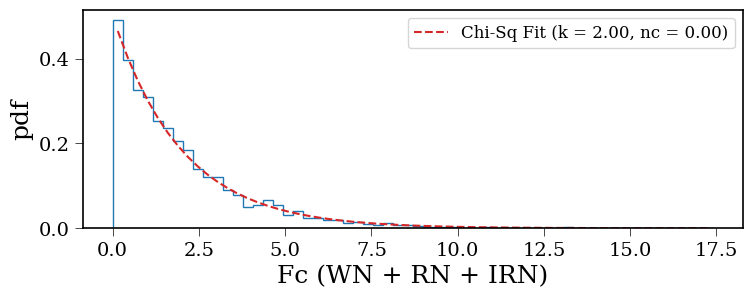

In [64]:
fcs = maxlike_output[:, 0]
fig, ax = plt.subplots()
ns, bins, patches = ax.hist(fcs, bins=60, histtype='step', density=True)


fc_wn_rn_irn_midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
fc_wn_rn_irn_counts = ns
popt, pcov = curve_fit(nc_chisq_fixedk_coh, fc_wn_rn_irn_midpts, fc_wn_rn_irn_counts, p0 = [0],maxfev = 5000)


# opt_k = popt[0]
fc_wn_rn_irn_opt_k = 2
fc_wn_rn_irn_opt_nc = popt[0]
# n, bins, patches = plt.hist(Fps, bins=80, histtype='step', density=True, label='Simulation Results')
fc_wn_rn_irn_fitted = []
fc_wn_rn_irn_expected = []
for pt in fc_wn_rn_irn_midpts:
    fc_wn_rn_irn_fitted.append(nc_chisq_wrapper(pt, fc_wn_rn_irn_opt_k, fc_wn_rn_irn_opt_nc))
# plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(opt_k))
plt.plot(fc_wn_rn_irn_midpts, fc_wn_rn_irn_fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(fc_wn_rn_opt_k, fc_wn_rn_opt_nc))
plt.legend(loc='upper right')
plt.xlabel("Fc (WN + RN + IRN)")
plt.ylabel("pdf")
plt.show()
plt.close()